In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf

# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

from atlasify import atlasify
import pickle

2022-01-29 04:31:05.252310: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:31:06.013855: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 04:31:06.014876: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 04:31:06.029802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-01-29 04:31:06.029858: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 04:31:06.033740: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

In [2]:
sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_VVZ_RD.arrow')
sig['is_signal'] = True
# sig_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/SIG_2021_11_16_no_iso_TEST.arrow')
bg_full = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_FULLBG_RD.arrow')
bg_full['is_signal'] = False
# bg_test = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/FULLBG_2021_11_16_no_iso_TEST.arrow')

In [3]:
bg_ZZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ZZ_RD.arrow')
bg_Zjets_old = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20211129_iso_e4m1_Zjets_RD.arrow')
bg_Zjets = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zjets_RD.arrow')
bg_Zgamma = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_Zgamma_RD.arrow')
bg_WZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_WZ_RD.arrow')
bg_tZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tZ_RD.arrow')
bg_tWZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_tWZ_RD.arrow')
bg_ttZ = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_ttZ_RD.arrow')
bg_other = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/20220117_iso_e4m1_others_RD.arrow')

bg_sources = [bg_ZZ, bg_Zjets, bg_Zgamma, bg_WZ, bg_tZ, bg_tWZ, bg_ttZ, bg_other]

In [4]:
for df in bg_sources:
    print(sum(df.wgt) / sum(bg_full.wgt))

0.9717740665613699
0.008909331116206785
0.0010556883632736617
0.004347097929154949
0.00016711686720929022
0.0025379501654372405
0.005859107932870372
0.006691005792313908


In [5]:
len(bg_Zjets_old)

130

In [6]:
len(bg_Zjets)

132

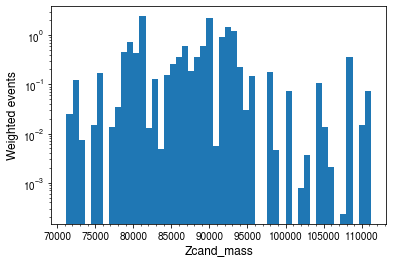

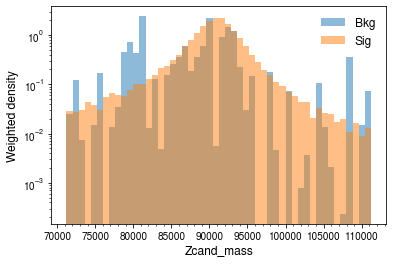

In [7]:
feat = 'Zcand_mass'


bg_source = bg_Zjets

plt.hist(bg_source[feat], weights=bg_source.wgt, bins=50)
plt.yscale('log')

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted events', fontsize=12)
plt.minorticks_on()

plt.show()

_, b, _ = plt.hist(bg_source[feat], weights=bg_source.wgt, density=False, bins=50, alpha=0.5, label='Bkg')
plt.hist(sig[feat], weights=sig.wgt, density=False, bins=b, alpha=0.5, label='Sig')

plt.legend(frameon=False, fontsize=12)

plt.xlabel(feat, fontsize=12)
plt.ylabel('Weighted density', fontsize=12)
plt.minorticks_on()

plt.yscale('log')

In [8]:
# train_feats = ['Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 'pt_1', 'pt_2', 'Wlep2_pt_sqrt']
# train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
#                'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
#                'Zlep1_phi', 'Zlep2_phi', 'Wlep1_phi', 'Wlep2_phi', 
#                'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
#                'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
#                'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
#                'METSig', 'MET', 'Nlep', 'Njet',
#                'other_mass', 'leptonic_HT', 'total_HT', 'HT', 
#                'SR']

train_feats_raw = sorted([f for f in sig.columns if f not in ['index', 'wgt', 'is_signal', 'Zcand_mass', 'chisq']])

X = pd.concat([sig[train_feats_raw], bg_full[train_feats_raw]], ignore_index=True)

In [9]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg_full] + bg_sources:
    df[train_feats_raw] = min_max_scaler.transform(df[train_feats_raw])

# Signal vs ZZ

ZZ events account for

In [10]:
current_bg = bg_ZZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

97.177406656137

percent of the total background. The amount relative to signal is

In [11]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 1626.9569530451513 %
Weight: 8163.991874259401 %


Because this background is so large, we will train on only a small portion of the events

In [12]:
current_bg = bg_ZZ.sample(frac=0.1, random_state=314)

The new amount relative to signal is

In [13]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 162.69614621535501 %
Weight: 811.7219751931631 %


Now we can scan over different training setups.

In [14]:
np.asarray(train_feats_raw)

array(['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi',
       'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi',
       'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi',
       'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi',
       'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT',
       'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
       'total_HT'], dtype='<U11')

In [15]:
train_feat_sets = [train_feats_raw, 
                   [f for f in train_feats_raw if f not in ['Wlep1_phi', 'Wlep2_phi', 'Zlep1_phi', 'Zlep2_phi']],
                   [f for f in train_feats_raw if f not in ['MET', 'METSig']],
                   [f for f in train_feats_raw if f not in ['pt_1', 'pt_2', 'pt_3', 'pt_4']],
                   [f for f in train_feats_raw if f not in ['Njet', 'Nlep']]
                  ]

In [18]:
EPOCHS = 5000
patience = 500
batch_size = 512
num_nodes = 32
dropout = 0.1
learn_rate = 1e-5

for i, train_feats in enumerate(train_feat_sets):
    print('Running with training features:', train_feats)
    # Save training setup
    with open('models/background_id_models/classifier_ZZ_train_feat_test_' + str(i) + '_setup.txt', 'w') as file:
        file.write('Epochs: ' + str(EPOCHS) + '\n')
        file.write('Patience: ' + str(patience) + '\n')
        file.write('Learning rate: ' + str(learn_rate) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n\n')
        file.write('Training features:\n' + '\n'.join(train_feats))
    
    # Generate train and test samples
    sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
    bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

    n_sig = sum(sig_train.wgt)
    n_bg = sum(bg_train.wgt)

    x_train_sig = sig_train[train_feats]
    x_train_bg = bg_train[train_feats]

    x_train = pd.concat([x_train_sig, x_train_bg])
    y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
    w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                        (n_sig + n_bg) / n_bg * bg_train['wgt']]))

    n_sig_test = sum(sig_test.wgt)
    n_bg_test = sum(bg_test.wgt)

    x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
    y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
    w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                       (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))
    
    # Generate and fit model
    K.clear_session()
    classifier_ZZ = Sequential()
    classifier_ZZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier_ZZ.add(Dropout(dropout))
    classifier_ZZ.add(Dense(num_nodes, activation='relu'))
    classifier_ZZ.add(Dropout(dropout))
    classifier_ZZ.add(Dense(num_nodes, activation='relu'))
    classifier_ZZ.add(Dropout(dropout))
    classifier_ZZ.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier_ZZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    history = classifier_ZZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                verbose=1, callbacks=[callback], shuffle=True)
    
    # Save model and history
    classifier_ZZ.save('models/background_id_models/classifier_ZZ_train_feat_test_' + str(i))
    with open('models/background_id_models/classifier_ZZ_train_feat_test_' + str(i) + '_history.pkl', 
              'wb') as file_pi:
        pickle.dump(history.history, file_pi)

Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.5308 - val_loss: 0.0013 - val_accuracy: 0.5418
Epoch 2/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.5327 - val_loss: 0.0013 - val_accuracy: 0.5473
Epoch 3/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.5331 - val_loss: 0.0013 - val_accuracy: 0.5531
Epoch 4/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.5361 - val_loss: 0.0013 - val_accuracy: 

171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6215 - val_loss: 0.0010 - val_accuracy: 0.6349
Epoch 55/5000
171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6232 - val_loss: 0.0010 - val_accuracy: 0.6349
Epoch 56/5000
171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6230 - val_loss: 0.0010 - val_accuracy: 0.6351
Epoch 57/5000
171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6235 - val_loss: 0.0010 - val_accuracy: 0.6354
Epoch 58/5000
171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6250 - val_loss: 0.0010 - val_accuracy: 0.6356
Epoch 59/5000
171/171 [==============================] - 1s 5ms/step - loss: 0.0011 - accuracy: 0.6251 - val_loss: 0.0010 - val_accuracy: 0.6356
Epoch 60/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6283 - val_loss: 0.0010 - val_accuracy: 0.6366

171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6467 - val_loss: 9.4318e-04 - val_accuracy: 0.6455
Epoch 110/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6472 - val_loss: 9.4225e-04 - val_accuracy: 0.6457
Epoch 111/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8648e-04 - accuracy: 0.6489 - val_loss: 9.4133e-04 - val_accuracy: 0.6459
Epoch 112/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6497 - val_loss: 9.4037e-04 - val_accuracy: 0.6458
Epoch 113/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8383e-04 - accuracy: 0.6510 - val_loss: 9.3947e-04 - val_accuracy: 0.6459
Epoch 114/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6469 - val_loss: 9.3867e-04 - val_accuracy: 0.6468
Epoch 115/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6472 - v

171/171 [==============================] - 1s 6ms/step - loss: 9.6504e-04 - accuracy: 0.6684 - val_loss: 9.0676e-04 - val_accuracy: 0.6647
Epoch 163/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5624e-04 - accuracy: 0.6645 - val_loss: 9.0625e-04 - val_accuracy: 0.6653
Epoch 164/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5994e-04 - accuracy: 0.6646 - val_loss: 9.0581e-04 - val_accuracy: 0.6666
Epoch 165/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7278e-04 - accuracy: 0.6623 - val_loss: 9.0515e-04 - val_accuracy: 0.6652
Epoch 166/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7024e-04 - accuracy: 0.6621 - val_loss: 9.0468e-04 - val_accuracy: 0.6660
Epoch 167/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7257e-04 - accuracy: 0.6654 - val_loss: 9.0418e-04 - val_accuracy: 0.6663
Epoch 168/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6315e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.4936e-04 - accuracy: 0.6704 - val_loss: 8.8394e-04 - val_accuracy: 0.6755
Epoch 216/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3600e-04 - accuracy: 0.6700 - val_loss: 8.8350e-04 - val_accuracy: 0.6755
Epoch 217/5000
171/171 [==============================] - 1s 5ms/step - loss: 9.3399e-04 - accuracy: 0.6710 - val_loss: 8.8315e-04 - val_accuracy: 0.6758
Epoch 218/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2922e-04 - accuracy: 0.6731 - val_loss: 8.8269e-04 - val_accuracy: 0.6753
Epoch 219/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3326e-04 - accuracy: 0.6736 - val_loss: 8.8230e-04 - val_accuracy: 0.6759
Epoch 220/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3573e-04 - accuracy: 0.6710 - val_loss: 8.8199e-04 - val_accuracy: 0.6763
Epoch 221/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2605e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.2748e-04 - accuracy: 0.6790 - val_loss: 8.6639e-04 - val_accuracy: 0.6810
Epoch 269/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3106e-04 - accuracy: 0.6765 - val_loss: 8.6615e-04 - val_accuracy: 0.6813
Epoch 270/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3313e-04 - accuracy: 0.6765 - val_loss: 8.6587e-04 - val_accuracy: 0.6815
Epoch 271/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2369e-04 - accuracy: 0.6778 - val_loss: 8.6560e-04 - val_accuracy: 0.6816
Epoch 272/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2640e-04 - accuracy: 0.6785 - val_loss: 8.6527e-04 - val_accuracy: 0.6817
Epoch 273/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3135e-04 - accuracy: 0.6771 - val_loss: 8.6497e-04 - val_accuracy: 0.6817
Epoch 274/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1888e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.1190e-04 - accuracy: 0.6773 - val_loss: 8.5209e-04 - val_accuracy: 0.6862
Epoch 322/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9995e-04 - accuracy: 0.6845 - val_loss: 8.5180e-04 - val_accuracy: 0.6860
Epoch 323/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0024e-04 - accuracy: 0.6793 - val_loss: 8.5155e-04 - val_accuracy: 0.6858
Epoch 324/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0425e-04 - accuracy: 0.6799 - val_loss: 8.5134e-04 - val_accuracy: 0.6859
Epoch 325/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9586e-04 - accuracy: 0.6794 - val_loss: 8.5108e-04 - val_accuracy: 0.6860
Epoch 326/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9476e-04 - accuracy: 0.6833 - val_loss: 8.5090e-04 - val_accuracy: 0.6866
Epoch 327/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8359e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.9644e-04 - accuracy: 0.6817 - val_loss: 8.3882e-04 - val_accuracy: 0.6878
Epoch 375/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7499e-04 - accuracy: 0.6847 - val_loss: 8.3846e-04 - val_accuracy: 0.6877
Epoch 376/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7542e-04 - accuracy: 0.6850 - val_loss: 8.3828e-04 - val_accuracy: 0.6879
Epoch 377/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8409e-04 - accuracy: 0.6870 - val_loss: 8.3802e-04 - val_accuracy: 0.6877
Epoch 378/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9835e-04 - accuracy: 0.6806 - val_loss: 8.3785e-04 - val_accuracy: 0.6882
Epoch 379/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9403e-04 - accuracy: 0.6843 - val_loss: 8.3763e-04 - val_accuracy: 0.6880
Epoch 380/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7565e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6854e-04 - accuracy: 0.6861 - val_loss: 8.2645e-04 - val_accuracy: 0.6895
Epoch 428/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8015e-04 - accuracy: 0.6883 - val_loss: 8.2619e-04 - val_accuracy: 0.6893
Epoch 429/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7215e-04 - accuracy: 0.6852 - val_loss: 8.2600e-04 - val_accuracy: 0.6891
Epoch 430/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7489e-04 - accuracy: 0.6863 - val_loss: 8.2579e-04 - val_accuracy: 0.6896
Epoch 431/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7555e-04 - accuracy: 0.6879 - val_loss: 8.2553e-04 - val_accuracy: 0.6892
Epoch 432/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7994e-04 - accuracy: 0.6855 - val_loss: 8.2536e-04 - val_accuracy: 0.6898
Epoch 433/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7310e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.3977e-04 - accuracy: 0.6883 - val_loss: 8.1496e-04 - val_accuracy: 0.6908
Epoch 481/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5451e-04 - accuracy: 0.6879 - val_loss: 8.1481e-04 - val_accuracy: 0.6909
Epoch 482/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5441e-04 - accuracy: 0.6880 - val_loss: 8.1460e-04 - val_accuracy: 0.6905
Epoch 483/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5643e-04 - accuracy: 0.6862 - val_loss: 8.1441e-04 - val_accuracy: 0.6912
Epoch 484/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6396e-04 - accuracy: 0.6866 - val_loss: 8.1418e-04 - val_accuracy: 0.6912
Epoch 485/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5202e-04 - accuracy: 0.6876 - val_loss: 8.1393e-04 - val_accuracy: 0.6905
Epoch 486/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3334e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.5309e-04 - accuracy: 0.6915 - val_loss: 8.0424e-04 - val_accuracy: 0.6921
Epoch 534/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4971e-04 - accuracy: 0.6894 - val_loss: 8.0405e-04 - val_accuracy: 0.6920
Epoch 535/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4318e-04 - accuracy: 0.6902 - val_loss: 8.0380e-04 - val_accuracy: 0.6915
Epoch 536/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6656e-04 - accuracy: 0.6859 - val_loss: 8.0364e-04 - val_accuracy: 0.6917
Epoch 537/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4988e-04 - accuracy: 0.6884 - val_loss: 8.0346e-04 - val_accuracy: 0.6917
Epoch 538/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4341e-04 - accuracy: 0.6892 - val_loss: 8.0335e-04 - val_accuracy: 0.6923
Epoch 539/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3042e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.2980e-04 - accuracy: 0.6899 - val_loss: 7.9432e-04 - val_accuracy: 0.6928
Epoch 587/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3884e-04 - accuracy: 0.6920 - val_loss: 7.9408e-04 - val_accuracy: 0.6926
Epoch 588/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4780e-04 - accuracy: 0.6916 - val_loss: 7.9393e-04 - val_accuracy: 0.6925
Epoch 589/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2638e-04 - accuracy: 0.6936 - val_loss: 7.9379e-04 - val_accuracy: 0.6924
Epoch 590/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2356e-04 - accuracy: 0.6896 - val_loss: 7.9371e-04 - val_accuracy: 0.6930
Epoch 591/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3324e-04 - accuracy: 0.6903 - val_loss: 7.9351e-04 - val_accuracy: 0.6927
Epoch 592/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0938e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.2133e-04 - accuracy: 0.6904 - val_loss: 7.8521e-04 - val_accuracy: 0.6947
Epoch 640/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2837e-04 - accuracy: 0.6935 - val_loss: 7.8503e-04 - val_accuracy: 0.6947
Epoch 641/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3458e-04 - accuracy: 0.6904 - val_loss: 7.8480e-04 - val_accuracy: 0.6944
Epoch 642/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0497e-04 - accuracy: 0.6922 - val_loss: 7.8458e-04 - val_accuracy: 0.6942
Epoch 643/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3576e-04 - accuracy: 0.6913 - val_loss: 7.8440e-04 - val_accuracy: 0.6943
Epoch 644/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0983e-04 - accuracy: 0.6936 - val_loss: 7.8429e-04 - val_accuracy: 0.6943
Epoch 645/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1618e-04 - 

171/171 [==============================] - 1s 5ms/step - loss: 8.1004e-04 - accuracy: 0.6922 - val_loss: 7.7672e-04 - val_accuracy: 0.6958
Epoch 693/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9868e-04 - accuracy: 0.6973 - val_loss: 7.7649e-04 - val_accuracy: 0.6954
Epoch 694/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0349e-04 - accuracy: 0.6942 - val_loss: 7.7628e-04 - val_accuracy: 0.6953
Epoch 695/5000
171/171 [==============================] - 1s 5ms/step - loss: 8.1673e-04 - accuracy: 0.6938 - val_loss: 7.7617e-04 - val_accuracy: 0.6957
Epoch 696/5000
171/171 [==============================] - 1s 5ms/step - loss: 8.2489e-04 - accuracy: 0.6962 - val_loss: 7.7594e-04 - val_accuracy: 0.6953
Epoch 697/5000
171/171 [==============================] - 1s 5ms/step - loss: 8.1302e-04 - accuracy: 0.6923 - val_loss: 7.7577e-04 - val_accuracy: 0.6954
Epoch 698/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2721e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.0791e-04 - accuracy: 0.6978 - val_loss: 7.6880e-04 - val_accuracy: 0.6966
Epoch 746/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9268e-04 - accuracy: 0.6952 - val_loss: 7.6872e-04 - val_accuracy: 0.6967
Epoch 747/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0536e-04 - accuracy: 0.6962 - val_loss: 7.6861e-04 - val_accuracy: 0.6969
Epoch 748/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8615e-04 - accuracy: 0.6973 - val_loss: 7.6848e-04 - val_accuracy: 0.6969
Epoch 749/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0192e-04 - accuracy: 0.6967 - val_loss: 7.6835e-04 - val_accuracy: 0.6968
Epoch 750/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0020e-04 - accuracy: 0.6940 - val_loss: 7.6830e-04 - val_accuracy: 0.6974
Epoch 751/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0319e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9932e-04 - accuracy: 0.6946 - val_loss: 7.6170e-04 - val_accuracy: 0.6980
Epoch 799/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0442e-04 - accuracy: 0.6970 - val_loss: 7.6157e-04 - val_accuracy: 0.6983
Epoch 800/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0259e-04 - accuracy: 0.6959 - val_loss: 7.6140e-04 - val_accuracy: 0.6979
Epoch 801/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0124e-04 - accuracy: 0.6964 - val_loss: 7.6139e-04 - val_accuracy: 0.6982
Epoch 802/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7767e-04 - accuracy: 0.6935 - val_loss: 7.6130e-04 - val_accuracy: 0.6982
Epoch 803/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0008e-04 - accuracy: 0.6983 - val_loss: 7.6125e-04 - val_accuracy: 0.6983
Epoch 804/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8385e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.8773e-04 - accuracy: 0.6950 - val_loss: 7.5512e-04 - val_accuracy: 0.6993
Epoch 852/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7762e-04 - accuracy: 0.6957 - val_loss: 7.5498e-04 - val_accuracy: 0.6992
Epoch 853/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9065e-04 - accuracy: 0.6978 - val_loss: 7.5496e-04 - val_accuracy: 0.6994
Epoch 854/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0019e-04 - accuracy: 0.6984 - val_loss: 7.5486e-04 - val_accuracy: 0.6995
Epoch 855/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6324e-04 - accuracy: 0.6984 - val_loss: 7.5471e-04 - val_accuracy: 0.6992
Epoch 856/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9332e-04 - accuracy: 0.6987 - val_loss: 7.5459e-04 - val_accuracy: 0.6991
Epoch 857/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7832e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9380e-04 - accuracy: 0.7011 - val_loss: 7.4892e-04 - val_accuracy: 0.6998
Epoch 905/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8548e-04 - accuracy: 0.6974 - val_loss: 7.4880e-04 - val_accuracy: 0.6998
Epoch 906/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6999e-04 - accuracy: 0.6984 - val_loss: 7.4876e-04 - val_accuracy: 0.7002
Epoch 907/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7479e-04 - accuracy: 0.6975 - val_loss: 7.4867e-04 - val_accuracy: 0.7004
Epoch 908/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9243e-04 - accuracy: 0.6982 - val_loss: 7.4858e-04 - val_accuracy: 0.7004
Epoch 909/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7630e-04 - accuracy: 0.6951 - val_loss: 7.4838e-04 - val_accuracy: 0.7002
Epoch 910/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7510e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.4879e-04 - accuracy: 0.6996 - val_loss: 7.4305e-04 - val_accuracy: 0.7013
Epoch 958/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7763e-04 - accuracy: 0.7003 - val_loss: 7.4289e-04 - val_accuracy: 0.7011
Epoch 959/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7273e-04 - accuracy: 0.6981 - val_loss: 7.4276e-04 - val_accuracy: 0.7010
Epoch 960/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7449e-04 - accuracy: 0.6997 - val_loss: 7.4263e-04 - val_accuracy: 0.7010
Epoch 961/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6106e-04 - accuracy: 0.7003 - val_loss: 7.4259e-04 - val_accuracy: 0.7014
Epoch 962/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6519e-04 - accuracy: 0.7016 - val_loss: 7.4248e-04 - val_accuracy: 0.7014
Epoch 963/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6355e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6328e-04 - accuracy: 0.7008 - val_loss: 7.3721e-04 - val_accuracy: 0.7031
Epoch 1011/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5559e-04 - accuracy: 0.7011 - val_loss: 7.3708e-04 - val_accuracy: 0.7032
Epoch 1012/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6917e-04 - accuracy: 0.7031 - val_loss: 7.3698e-04 - val_accuracy: 0.7025
Epoch 1013/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6791e-04 - accuracy: 0.7042 - val_loss: 7.3693e-04 - val_accuracy: 0.7031
Epoch 1014/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6761e-04 - accuracy: 0.7009 - val_loss: 7.3681e-04 - val_accuracy: 0.7029
Epoch 1015/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7513e-04 - accuracy: 0.7006 - val_loss: 7.3671e-04 - val_accuracy: 0.7032
Epoch 1016/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4499e

Epoch 1063/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5774e-04 - accuracy: 0.7015 - val_loss: 7.3148e-04 - val_accuracy: 0.7041
Epoch 1064/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3694e-04 - accuracy: 0.7025 - val_loss: 7.3158e-04 - val_accuracy: 0.7047
Epoch 1065/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6029e-04 - accuracy: 0.7076 - val_loss: 7.3134e-04 - val_accuracy: 0.7043
Epoch 1066/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4607e-04 - accuracy: 0.7050 - val_loss: 7.3119e-04 - val_accuracy: 0.7044
Epoch 1067/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6449e-04 - accuracy: 0.7015 - val_loss: 7.3107e-04 - val_accuracy: 0.7042
Epoch 1068/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5798e-04 - accuracy: 0.7047 - val_loss: 7.3094e-04 - val_accuracy: 0.7041
Epoch 1069/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1116/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6136e-04 - accuracy: 0.7057 - val_loss: 7.2607e-04 - val_accuracy: 0.7058
Epoch 1117/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4890e-04 - accuracy: 0.7058 - val_loss: 7.2601e-04 - val_accuracy: 0.7057
Epoch 1118/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1841e-04 - accuracy: 0.7018 - val_loss: 7.2591e-04 - val_accuracy: 0.7058
Epoch 1119/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5605e-04 - accuracy: 0.7060 - val_loss: 7.2573e-04 - val_accuracy: 0.7054
Epoch 1120/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.5410e-04 - accuracy: 0.7041 - val_loss: 7.2567e-04 - val_accuracy: 0.7056
Epoch 1121/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5215e-04 - accuracy: 0.7093 - val_loss: 7.2557e-04 - val_accuracy: 0.7056
Epoch 1122/5000
171/171 [==============================] - 1s 5ms/step

Epoch 1169/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5647e-04 - accuracy: 0.7084 - val_loss: 7.2065e-04 - val_accuracy: 0.7073
Epoch 1170/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4931e-04 - accuracy: 0.7058 - val_loss: 7.2061e-04 - val_accuracy: 0.7076
Epoch 1171/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1730e-04 - accuracy: 0.7055 - val_loss: 7.2049e-04 - val_accuracy: 0.7077
Epoch 1172/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4325e-04 - accuracy: 0.7067 - val_loss: 7.2028e-04 - val_accuracy: 0.7068
Epoch 1173/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5446e-04 - accuracy: 0.7056 - val_loss: 7.2024e-04 - val_accuracy: 0.7073
Epoch 1174/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6717e-04 - accuracy: 0.7037 - val_loss: 7.2011e-04 - val_accuracy: 0.7072
Epoch 1175/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1222/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2308e-04 - accuracy: 0.7056 - val_loss: 7.1527e-04 - val_accuracy: 0.7088
Epoch 1223/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5049e-04 - accuracy: 0.7056 - val_loss: 7.1523e-04 - val_accuracy: 0.7090
Epoch 1224/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3813e-04 - accuracy: 0.7104 - val_loss: 7.1513e-04 - val_accuracy: 0.7086
Epoch 1225/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4501e-04 - accuracy: 0.7055 - val_loss: 7.1500e-04 - val_accuracy: 0.7085
Epoch 1226/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5188e-04 - accuracy: 0.7080 - val_loss: 7.1485e-04 - val_accuracy: 0.7089
Epoch 1227/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2201e-04 - accuracy: 0.7114 - val_loss: 7.1479e-04 - val_accuracy: 0.7092
Epoch 1228/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1275/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4598e-04 - accuracy: 0.7090 - val_loss: 7.1007e-04 - val_accuracy: 0.7108
Epoch 1276/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2381e-04 - accuracy: 0.7079 - val_loss: 7.1016e-04 - val_accuracy: 0.7110
Epoch 1277/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4417e-04 - accuracy: 0.7095 - val_loss: 7.0993e-04 - val_accuracy: 0.7107
Epoch 1278/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4634e-04 - accuracy: 0.7099 - val_loss: 7.0993e-04 - val_accuracy: 0.7110
Epoch 1279/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2468e-04 - accuracy: 0.7108 - val_loss: 7.0966e-04 - val_accuracy: 0.7107
Epoch 1280/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0915e-04 - accuracy: 0.7088 - val_loss: 7.0963e-04 - val_accuracy: 0.7112
Epoch 1281/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1328/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1709e-04 - accuracy: 0.7128 - val_loss: 7.0516e-04 - val_accuracy: 0.7122
Epoch 1329/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8390e-04 - accuracy: 0.7105 - val_loss: 7.0518e-04 - val_accuracy: 0.7124
Epoch 1330/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3663e-04 - accuracy: 0.7088 - val_loss: 7.0490e-04 - val_accuracy: 0.7119
Epoch 1331/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3963e-04 - accuracy: 0.7092 - val_loss: 7.0486e-04 - val_accuracy: 0.7123
Epoch 1332/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2499e-04 - accuracy: 0.7122 - val_loss: 7.0470e-04 - val_accuracy: 0.7122
Epoch 1333/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2200e-04 - accuracy: 0.7127 - val_loss: 7.0453e-04 - val_accuracy: 0.7120
Epoch 1334/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1381/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1927e-04 - accuracy: 0.7112 - val_loss: 7.0009e-04 - val_accuracy: 0.7138
Epoch 1382/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9033e-04 - accuracy: 0.7124 - val_loss: 7.0013e-04 - val_accuracy: 0.7140
Epoch 1383/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2904e-04 - accuracy: 0.7119 - val_loss: 7.0000e-04 - val_accuracy: 0.7135
Epoch 1384/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0548e-04 - accuracy: 0.7106 - val_loss: 6.9998e-04 - val_accuracy: 0.7142
Epoch 1385/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3737e-04 - accuracy: 0.7132 - val_loss: 6.9976e-04 - val_accuracy: 0.7138
Epoch 1386/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.2859e-04 - accuracy: 0.7120 - val_loss: 6.9972e-04 - val_accuracy: 0.7131
Epoch 1387/5000
171/171 [==============================] - 1s 5ms/step

Epoch 1434/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.1800e-04 - accuracy: 0.7146 - val_loss: 6.9575e-04 - val_accuracy: 0.7156
Epoch 1435/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1813e-04 - accuracy: 0.7121 - val_loss: 6.9568e-04 - val_accuracy: 0.7157
Epoch 1436/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0522e-04 - accuracy: 0.7134 - val_loss: 6.9561e-04 - val_accuracy: 0.7156
Epoch 1437/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0126e-04 - accuracy: 0.7141 - val_loss: 6.9558e-04 - val_accuracy: 0.7158
Epoch 1438/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.0177e-04 - accuracy: 0.7136 - val_loss: 6.9531e-04 - val_accuracy: 0.7149
Epoch 1439/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1707e-04 - accuracy: 0.7139 - val_loss: 6.9534e-04 - val_accuracy: 0.7158
Epoch 1440/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1487/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1938e-04 - accuracy: 0.7169 - val_loss: 6.9111e-04 - val_accuracy: 0.7167
Epoch 1488/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7784e-04 - accuracy: 0.7153 - val_loss: 6.9119e-04 - val_accuracy: 0.7173
Epoch 1489/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1755e-04 - accuracy: 0.7144 - val_loss: 6.9101e-04 - val_accuracy: 0.7171
Epoch 1490/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9494e-04 - accuracy: 0.7177 - val_loss: 6.9103e-04 - val_accuracy: 0.7174
Epoch 1491/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1160e-04 - accuracy: 0.7152 - val_loss: 6.9080e-04 - val_accuracy: 0.7169
Epoch 1492/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0294e-04 - accuracy: 0.7157 - val_loss: 6.9071e-04 - val_accuracy: 0.7169
Epoch 1493/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1540/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0884e-04 - accuracy: 0.7179 - val_loss: 6.8688e-04 - val_accuracy: 0.7179
Epoch 1541/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8663e-04 - accuracy: 0.7150 - val_loss: 6.8686e-04 - val_accuracy: 0.7185
Epoch 1542/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0098e-04 - accuracy: 0.7211 - val_loss: 6.8671e-04 - val_accuracy: 0.7185
Epoch 1543/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1314e-04 - accuracy: 0.7135 - val_loss: 6.8660e-04 - val_accuracy: 0.7188
Epoch 1544/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6993e-04 - accuracy: 0.7168 - val_loss: 6.8661e-04 - val_accuracy: 0.7193
Epoch 1545/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0578e-04 - accuracy: 0.7150 - val_loss: 6.8635e-04 - val_accuracy: 0.7186
Epoch 1546/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1593/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7157e-04 - accuracy: 0.7192 - val_loss: 6.8302e-04 - val_accuracy: 0.7206
Epoch 1594/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1417e-04 - accuracy: 0.7201 - val_loss: 6.8289e-04 - val_accuracy: 0.7204
Epoch 1595/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9834e-04 - accuracy: 0.7173 - val_loss: 6.8281e-04 - val_accuracy: 0.7205
Epoch 1596/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2335e-04 - accuracy: 0.7146 - val_loss: 6.8262e-04 - val_accuracy: 0.7205
Epoch 1597/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9959e-04 - accuracy: 0.7166 - val_loss: 6.8248e-04 - val_accuracy: 0.7202
Epoch 1598/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1451e-04 - accuracy: 0.7193 - val_loss: 6.8244e-04 - val_accuracy: 0.7205
Epoch 1599/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1646/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9268e-04 - accuracy: 0.7189 - val_loss: 6.7890e-04 - val_accuracy: 0.7216
Epoch 1647/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0746e-04 - accuracy: 0.7194 - val_loss: 6.7880e-04 - val_accuracy: 0.7216
Epoch 1648/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8277e-04 - accuracy: 0.7187 - val_loss: 6.7883e-04 - val_accuracy: 0.7218
Epoch 1649/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9555e-04 - accuracy: 0.7196 - val_loss: 6.7879e-04 - val_accuracy: 0.7219
Epoch 1650/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5476e-04 - accuracy: 0.7214 - val_loss: 6.7883e-04 - val_accuracy: 0.7227
Epoch 1651/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8681e-04 - accuracy: 0.7178 - val_loss: 6.7878e-04 - val_accuracy: 0.7228
Epoch 1652/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1699/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.9355e-04 - accuracy: 0.7190 - val_loss: 6.7553e-04 - val_accuracy: 0.7240
Epoch 1700/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.7577e-04 - accuracy: 0.7165 - val_loss: 6.7563e-04 - val_accuracy: 0.7243
Epoch 1701/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9480e-04 - accuracy: 0.7206 - val_loss: 6.7559e-04 - val_accuracy: 0.7241
Epoch 1702/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4584e-04 - accuracy: 0.7219 - val_loss: 6.7535e-04 - val_accuracy: 0.7240
Epoch 1703/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5353e-04 - accuracy: 0.7201 - val_loss: 6.7528e-04 - val_accuracy: 0.7241
Epoch 1704/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9355e-04 - accuracy: 0.7198 - val_loss: 6.7526e-04 - val_accuracy: 0.7239
Epoch 1705/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1752/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9154e-04 - accuracy: 0.7233 - val_loss: 6.7221e-04 - val_accuracy: 0.7247
Epoch 1753/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.8165e-04 - accuracy: 0.7229 - val_loss: 6.7222e-04 - val_accuracy: 0.7250
Epoch 1754/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.7378e-04 - accuracy: 0.7248 - val_loss: 6.7216e-04 - val_accuracy: 0.7251
Epoch 1755/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8839e-04 - accuracy: 0.7216 - val_loss: 6.7210e-04 - val_accuracy: 0.7250
Epoch 1756/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8065e-04 - accuracy: 0.7199 - val_loss: 6.7217e-04 - val_accuracy: 0.7253
Epoch 1757/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9957e-04 - accuracy: 0.7204 - val_loss: 6.7206e-04 - val_accuracy: 0.7254
Epoch 1758/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1805/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6999e-04 - accuracy: 0.7214 - val_loss: 6.6929e-04 - val_accuracy: 0.7262
Epoch 1806/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6643e-04 - accuracy: 0.7258 - val_loss: 6.6940e-04 - val_accuracy: 0.7265
Epoch 1807/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4362e-04 - accuracy: 0.7246 - val_loss: 6.6926e-04 - val_accuracy: 0.7267
Epoch 1808/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9477e-04 - accuracy: 0.7245 - val_loss: 6.6906e-04 - val_accuracy: 0.7261
Epoch 1809/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8441e-04 - accuracy: 0.7205 - val_loss: 6.6906e-04 - val_accuracy: 0.7268
Epoch 1810/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5125e-04 - accuracy: 0.7211 - val_loss: 6.6896e-04 - val_accuracy: 0.7264
Epoch 1811/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1858/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9161e-04 - accuracy: 0.7238 - val_loss: 6.6643e-04 - val_accuracy: 0.7285
Epoch 1859/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9364e-04 - accuracy: 0.7249 - val_loss: 6.6633e-04 - val_accuracy: 0.7282
Epoch 1860/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8987e-04 - accuracy: 0.7253 - val_loss: 6.6641e-04 - val_accuracy: 0.7290
Epoch 1861/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5899e-04 - accuracy: 0.7254 - val_loss: 6.6629e-04 - val_accuracy: 0.7285
Epoch 1862/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3226e-04 - accuracy: 0.7249 - val_loss: 6.6627e-04 - val_accuracy: 0.7287
Epoch 1863/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7276e-04 - accuracy: 0.7252 - val_loss: 6.6609e-04 - val_accuracy: 0.7287
Epoch 1864/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1911/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0020e-04 - accuracy: 0.7233 - val_loss: 6.6362e-04 - val_accuracy: 0.7292
Epoch 1912/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7840e-04 - accuracy: 0.7257 - val_loss: 6.6362e-04 - val_accuracy: 0.7299
Epoch 1913/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5996e-04 - accuracy: 0.7254 - val_loss: 6.6348e-04 - val_accuracy: 0.7295
Epoch 1914/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8053e-04 - accuracy: 0.7264 - val_loss: 6.6347e-04 - val_accuracy: 0.7299
Epoch 1915/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7973e-04 - accuracy: 0.7245 - val_loss: 6.6355e-04 - val_accuracy: 0.7298
Epoch 1916/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7045e-04 - accuracy: 0.7244 - val_loss: 6.6346e-04 - val_accuracy: 0.7300
Epoch 1917/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1964/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2015e-04 - accuracy: 0.7276 - val_loss: 6.6141e-04 - val_accuracy: 0.7303
Epoch 1965/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7074e-04 - accuracy: 0.7243 - val_loss: 6.6145e-04 - val_accuracy: 0.7303
Epoch 1966/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6509e-04 - accuracy: 0.7251 - val_loss: 6.6140e-04 - val_accuracy: 0.7304
Epoch 1967/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6434e-04 - accuracy: 0.7261 - val_loss: 6.6132e-04 - val_accuracy: 0.7303
Epoch 1968/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5486e-04 - accuracy: 0.7247 - val_loss: 6.6141e-04 - val_accuracy: 0.7306
Epoch 1969/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8325e-04 - accuracy: 0.7259 - val_loss: 6.6122e-04 - val_accuracy: 0.7302
Epoch 1970/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2017/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7875e-04 - accuracy: 0.7256 - val_loss: 6.5933e-04 - val_accuracy: 0.7318
Epoch 2018/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7933e-04 - accuracy: 0.7263 - val_loss: 6.5928e-04 - val_accuracy: 0.7317
Epoch 2019/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2183e-04 - accuracy: 0.7288 - val_loss: 6.5924e-04 - val_accuracy: 0.7318
Epoch 2020/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5202e-04 - accuracy: 0.7231 - val_loss: 6.5941e-04 - val_accuracy: 0.7322
Epoch 2021/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6414e-04 - accuracy: 0.7282 - val_loss: 6.5917e-04 - val_accuracy: 0.7317
Epoch 2022/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8760e-04 - accuracy: 0.7261 - val_loss: 6.5897e-04 - val_accuracy: 0.7313
Epoch 2023/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2070/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7045e-04 - accuracy: 0.7271 - val_loss: 6.5714e-04 - val_accuracy: 0.7329
Epoch 2071/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5639e-04 - accuracy: 0.7296 - val_loss: 6.5718e-04 - val_accuracy: 0.7331
Epoch 2072/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8209e-04 - accuracy: 0.7310 - val_loss: 6.5692e-04 - val_accuracy: 0.7328
Epoch 2073/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6902e-04 - accuracy: 0.7306 - val_loss: 6.5696e-04 - val_accuracy: 0.7329
Epoch 2074/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5573e-04 - accuracy: 0.7281 - val_loss: 6.5710e-04 - val_accuracy: 0.7331
Epoch 2075/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4307e-04 - accuracy: 0.7285 - val_loss: 6.5689e-04 - val_accuracy: 0.7329
Epoch 2076/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2123/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3042e-04 - accuracy: 0.7287 - val_loss: 6.5521e-04 - val_accuracy: 0.7340
Epoch 2124/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2184e-04 - accuracy: 0.7279 - val_loss: 6.5534e-04 - val_accuracy: 0.7347
Epoch 2125/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4109e-04 - accuracy: 0.7285 - val_loss: 6.5516e-04 - val_accuracy: 0.7340
Epoch 2126/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6267e-04 - accuracy: 0.7306 - val_loss: 6.5510e-04 - val_accuracy: 0.7339
Epoch 2127/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5724e-04 - accuracy: 0.7272 - val_loss: 6.5518e-04 - val_accuracy: 0.7343
Epoch 2128/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3980e-04 - accuracy: 0.7309 - val_loss: 6.5530e-04 - val_accuracy: 0.7343
Epoch 2129/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2176/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7111e-04 - accuracy: 0.7301 - val_loss: 6.5337e-04 - val_accuracy: 0.7350
Epoch 2177/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4101e-04 - accuracy: 0.7296 - val_loss: 6.5340e-04 - val_accuracy: 0.7350
Epoch 2178/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0169e-04 - accuracy: 0.7323 - val_loss: 6.5322e-04 - val_accuracy: 0.7342
Epoch 2179/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4413e-04 - accuracy: 0.7297 - val_loss: 6.5340e-04 - val_accuracy: 0.7350
Epoch 2180/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6571e-04 - accuracy: 0.7292 - val_loss: 6.5328e-04 - val_accuracy: 0.7344
Epoch 2181/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8048e-04 - accuracy: 0.7292 - val_loss: 6.5335e-04 - val_accuracy: 0.7349
Epoch 2182/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2229/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6186e-04 - accuracy: 0.7346 - val_loss: 6.5217e-04 - val_accuracy: 0.7354
Epoch 2230/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2367e-04 - accuracy: 0.7301 - val_loss: 6.5223e-04 - val_accuracy: 0.7354
Epoch 2231/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5308e-04 - accuracy: 0.7345 - val_loss: 6.5209e-04 - val_accuracy: 0.7348
Epoch 2232/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7860e-04 - accuracy: 0.7296 - val_loss: 6.5217e-04 - val_accuracy: 0.7353
Epoch 2233/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6578e-04 - accuracy: 0.7322 - val_loss: 6.5214e-04 - val_accuracy: 0.7353
Epoch 2234/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7208e-04 - accuracy: 0.7292 - val_loss: 6.5206e-04 - val_accuracy: 0.7354
Epoch 2235/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2282/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5513e-04 - accuracy: 0.7328 - val_loss: 6.5063e-04 - val_accuracy: 0.7360
Epoch 2283/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3656e-04 - accuracy: 0.7314 - val_loss: 6.5085e-04 - val_accuracy: 0.7361
Epoch 2284/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1885e-04 - accuracy: 0.7303 - val_loss: 6.5111e-04 - val_accuracy: 0.7364
Epoch 2285/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0279e-04 - accuracy: 0.7349 - val_loss: 6.5071e-04 - val_accuracy: 0.7360
Epoch 2286/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6909e-04 - accuracy: 0.7312 - val_loss: 6.5066e-04 - val_accuracy: 0.7359
Epoch 2287/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5957e-04 - accuracy: 0.7319 - val_loss: 6.5073e-04 - val_accuracy: 0.7361
Epoch 2288/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2335/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5374e-04 - accuracy: 0.7359 - val_loss: 6.4952e-04 - val_accuracy: 0.7368
Epoch 2336/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6709e-04 - accuracy: 0.7326 - val_loss: 6.4954e-04 - val_accuracy: 0.7369
Epoch 2337/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1706e-04 - accuracy: 0.7289 - val_loss: 6.4951e-04 - val_accuracy: 0.7370
Epoch 2338/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4218e-04 - accuracy: 0.7326 - val_loss: 6.4972e-04 - val_accuracy: 0.7371
Epoch 2339/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4089e-04 - accuracy: 0.7335 - val_loss: 6.4927e-04 - val_accuracy: 0.7367
Epoch 2340/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8763e-04 - accuracy: 0.7340 - val_loss: 6.4924e-04 - val_accuracy: 0.7364
Epoch 2341/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2388/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3432e-04 - accuracy: 0.7351 - val_loss: 6.4835e-04 - val_accuracy: 0.7374
Epoch 2389/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5254e-04 - accuracy: 0.7340 - val_loss: 6.4836e-04 - val_accuracy: 0.7374
Epoch 2390/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4757e-04 - accuracy: 0.7357 - val_loss: 6.4822e-04 - val_accuracy: 0.7370
Epoch 2391/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0377e-04 - accuracy: 0.7319 - val_loss: 6.4834e-04 - val_accuracy: 0.7370
Epoch 2392/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4670e-04 - accuracy: 0.7313 - val_loss: 6.4834e-04 - val_accuracy: 0.7372
Epoch 2393/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.3354e-04 - accuracy: 0.7332 - val_loss: 6.4835e-04 - val_accuracy: 0.7379
Epoch 2394/5000
171/171 [==============================] - 1s 5ms/step

Epoch 2441/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2485e-04 - accuracy: 0.7348 - val_loss: 6.4761e-04 - val_accuracy: 0.7371
Epoch 2442/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1915e-04 - accuracy: 0.7354 - val_loss: 6.4759e-04 - val_accuracy: 0.7380
Epoch 2443/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8874e-04 - accuracy: 0.7343 - val_loss: 6.4772e-04 - val_accuracy: 0.7385
Epoch 2444/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1291e-04 - accuracy: 0.7327 - val_loss: 6.4745e-04 - val_accuracy: 0.7381
Epoch 2445/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4127e-04 - accuracy: 0.7364 - val_loss: 6.4740e-04 - val_accuracy: 0.7375
Epoch 2446/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7599e-04 - accuracy: 0.7324 - val_loss: 6.4727e-04 - val_accuracy: 0.7373
Epoch 2447/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2494/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5610e-04 - accuracy: 0.7346 - val_loss: 6.4628e-04 - val_accuracy: 0.7375
Epoch 2495/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5923e-04 - accuracy: 0.7337 - val_loss: 6.4642e-04 - val_accuracy: 0.7377
Epoch 2496/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2175e-04 - accuracy: 0.7354 - val_loss: 6.4645e-04 - val_accuracy: 0.7377
Epoch 2497/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8844e-04 - accuracy: 0.7336 - val_loss: 6.4658e-04 - val_accuracy: 0.7381
Epoch 2498/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.8504e-04 - accuracy: 0.7332 - val_loss: 6.4641e-04 - val_accuracy: 0.7385
Epoch 2499/5000
171/171 [==============================] - 1s 5ms/step - loss: 5.8466e-04 - accuracy: 0.7340 - val_loss: 6.4631e-04 - val_accuracy: 0.7375
Epoch 2500/5000
171/171 [==============================] - 1s 5ms/step

Epoch 2547/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5802e-04 - accuracy: 0.7347 - val_loss: 6.4563e-04 - val_accuracy: 0.7384
Epoch 2548/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4650e-04 - accuracy: 0.7366 - val_loss: 6.4556e-04 - val_accuracy: 0.7384
Epoch 2549/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1858e-04 - accuracy: 0.7398 - val_loss: 6.4555e-04 - val_accuracy: 0.7383
Epoch 2550/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9623e-04 - accuracy: 0.7347 - val_loss: 6.4557e-04 - val_accuracy: 0.7388
Epoch 2551/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5106e-04 - accuracy: 0.7342 - val_loss: 6.4534e-04 - val_accuracy: 0.7386
Epoch 2552/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6053e-04 - accuracy: 0.7332 - val_loss: 6.4533e-04 - val_accuracy: 0.7383
Epoch 2553/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2600/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6652e-04 - accuracy: 0.7383 - val_loss: 6.4480e-04 - val_accuracy: 0.7387
Epoch 2601/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2243e-04 - accuracy: 0.7356 - val_loss: 6.4488e-04 - val_accuracy: 0.7400
Epoch 2602/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5760e-04 - accuracy: 0.7383 - val_loss: 6.4462e-04 - val_accuracy: 0.7389
Epoch 2603/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4786e-04 - accuracy: 0.7374 - val_loss: 6.4465e-04 - val_accuracy: 0.7385
Epoch 2604/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2059e-04 - accuracy: 0.7351 - val_loss: 6.4478e-04 - val_accuracy: 0.7395
Epoch 2605/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6244e-04 - accuracy: 0.7383 - val_loss: 6.4494e-04 - val_accuracy: 0.7396
Epoch 2606/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2653/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3082e-04 - accuracy: 0.7368 - val_loss: 6.4418e-04 - val_accuracy: 0.7387
Epoch 2654/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2405e-04 - accuracy: 0.7394 - val_loss: 6.4413e-04 - val_accuracy: 0.7391
Epoch 2655/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1598e-04 - accuracy: 0.7351 - val_loss: 6.4408e-04 - val_accuracy: 0.7392
Epoch 2656/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4911e-04 - accuracy: 0.7354 - val_loss: 6.4417e-04 - val_accuracy: 0.7398
Epoch 2657/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5999e-04 - accuracy: 0.7381 - val_loss: 6.4393e-04 - val_accuracy: 0.7395
Epoch 2658/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6237e-04 - accuracy: 0.7367 - val_loss: 6.4398e-04 - val_accuracy: 0.7399
Epoch 2659/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2706/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4734e-04 - accuracy: 0.7338 - val_loss: 6.4360e-04 - val_accuracy: 0.7395
Epoch 2707/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1860e-04 - accuracy: 0.7378 - val_loss: 6.4383e-04 - val_accuracy: 0.7397
Epoch 2708/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4938e-04 - accuracy: 0.7368 - val_loss: 6.4366e-04 - val_accuracy: 0.7395
Epoch 2709/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3281e-04 - accuracy: 0.7358 - val_loss: 6.4358e-04 - val_accuracy: 0.7396
Epoch 2710/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.1805e-04 - accuracy: 0.7355 - val_loss: 6.4380e-04 - val_accuracy: 0.7403
Epoch 2711/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6775e-04 - accuracy: 0.7362 - val_loss: 6.4361e-04 - val_accuracy: 0.7395
Epoch 2712/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2759/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1416e-04 - accuracy: 0.7388 - val_loss: 6.4335e-04 - val_accuracy: 0.7404
Epoch 2760/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7302e-04 - accuracy: 0.7369 - val_loss: 6.4321e-04 - val_accuracy: 0.7396
Epoch 2761/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5509e-04 - accuracy: 0.7393 - val_loss: 6.4336e-04 - val_accuracy: 0.7400
Epoch 2762/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3317e-04 - accuracy: 0.7388 - val_loss: 6.4319e-04 - val_accuracy: 0.7398
Epoch 2763/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2268e-04 - accuracy: 0.7368 - val_loss: 6.4323e-04 - val_accuracy: 0.7401
Epoch 2764/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1211e-04 - accuracy: 0.7386 - val_loss: 6.4323e-04 - val_accuracy: 0.7399
Epoch 2765/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2812/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3556e-04 - accuracy: 0.7401 - val_loss: 6.4306e-04 - val_accuracy: 0.7403
Epoch 2813/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5581e-04 - accuracy: 0.7373 - val_loss: 6.4305e-04 - val_accuracy: 0.7402
Epoch 2814/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5955e-04 - accuracy: 0.7388 - val_loss: 6.4301e-04 - val_accuracy: 0.7398
Epoch 2815/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5819e-04 - accuracy: 0.7381 - val_loss: 6.4308e-04 - val_accuracy: 0.7400
Epoch 2816/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4437e-04 - accuracy: 0.7353 - val_loss: 6.4313e-04 - val_accuracy: 0.7401
Epoch 2817/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3793e-04 - accuracy: 0.7360 - val_loss: 6.4300e-04 - val_accuracy: 0.7403
Epoch 2818/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2865/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4242e-04 - accuracy: 0.7391 - val_loss: 6.4269e-04 - val_accuracy: 0.7404
Epoch 2866/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0944e-04 - accuracy: 0.7368 - val_loss: 6.4283e-04 - val_accuracy: 0.7413
Epoch 2867/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2536e-04 - accuracy: 0.7413 - val_loss: 6.4280e-04 - val_accuracy: 0.7407
Epoch 2868/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2595e-04 - accuracy: 0.7352 - val_loss: 6.4270e-04 - val_accuracy: 0.7408
Epoch 2869/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3631e-04 - accuracy: 0.7346 - val_loss: 6.4256e-04 - val_accuracy: 0.7406
Epoch 2870/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1671e-04 - accuracy: 0.7358 - val_loss: 6.4291e-04 - val_accuracy: 0.7414
Epoch 2871/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2918/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2809e-04 - accuracy: 0.7364 - val_loss: 6.4255e-04 - val_accuracy: 0.7405
Epoch 2919/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6431e-04 - accuracy: 0.7360 - val_loss: 6.4257e-04 - val_accuracy: 0.7405
Epoch 2920/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3063e-04 - accuracy: 0.7390 - val_loss: 6.4250e-04 - val_accuracy: 0.7408
Epoch 2921/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0086e-04 - accuracy: 0.7400 - val_loss: 6.4275e-04 - val_accuracy: 0.7407
Epoch 2922/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3452e-04 - accuracy: 0.7393 - val_loss: 6.4264e-04 - val_accuracy: 0.7411
Epoch 2923/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5831e-04 - accuracy: 0.7372 - val_loss: 6.4289e-04 - val_accuracy: 0.7416
Epoch 2924/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2971/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0455e-04 - accuracy: 0.7425 - val_loss: 6.4265e-04 - val_accuracy: 0.7415
Epoch 2972/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9186e-04 - accuracy: 0.7397 - val_loss: 6.4257e-04 - val_accuracy: 0.7413
Epoch 2973/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2309e-04 - accuracy: 0.7398 - val_loss: 6.4262e-04 - val_accuracy: 0.7410
Epoch 2974/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.8805e-04 - accuracy: 0.7410 - val_loss: 6.4268e-04 - val_accuracy: 0.7416
Epoch 2975/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1501e-04 - accuracy: 0.7392 - val_loss: 6.4265e-04 - val_accuracy: 0.7413
Epoch 2976/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2476e-04 - accuracy: 0.7392 - val_loss: 6.4282e-04 - val_accuracy: 0.7414
Epoch 2977/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3024/5000
171/171 [==============================] - 1s 5ms/step - loss: 5.4456e-04 - accuracy: 0.7382 - val_loss: 6.4269e-04 - val_accuracy: 0.7415
Epoch 3025/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.1625e-04 - accuracy: 0.7394 - val_loss: 6.4270e-04 - val_accuracy: 0.7414
Epoch 3026/5000
171/171 [==============================] - 1s 5ms/step - loss: 5.1010e-04 - accuracy: 0.7394 - val_loss: 6.4282e-04 - val_accuracy: 0.7416
Epoch 3027/5000
171/171 [==============================] - 1s 5ms/step - loss: 5.7706e-04 - accuracy: 0.7414 - val_loss: 6.4295e-04 - val_accuracy: 0.7414
Epoch 3028/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.3415e-04 - accuracy: 0.7392 - val_loss: 6.4278e-04 - val_accuracy: 0.7415
Epoch 3029/5000
171/171 [==============================] - 1s 5ms/step - loss: 5.3516e-04 - accuracy: 0.7394 - val_loss: 6.4268e-04 - val_accuracy: 0.7419
Epoch 3030/5000
171/171 [==============================] - 1s 5ms/step

Epoch 3077/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3857e-04 - accuracy: 0.7371 - val_loss: 6.4281e-04 - val_accuracy: 0.7416
Epoch 3078/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5523e-04 - accuracy: 0.7380 - val_loss: 6.4259e-04 - val_accuracy: 0.7417
Epoch 3079/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9069e-04 - accuracy: 0.7390 - val_loss: 6.4275e-04 - val_accuracy: 0.7417
Epoch 3080/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.2145e-04 - accuracy: 0.7352 - val_loss: 6.4274e-04 - val_accuracy: 0.7415
Epoch 3081/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2586e-04 - accuracy: 0.7399 - val_loss: 6.4263e-04 - val_accuracy: 0.7415
Epoch 3082/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8717e-04 - accuracy: 0.7412 - val_loss: 6.4255e-04 - val_accuracy: 0.7419
Epoch 3083/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3130/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9416e-04 - accuracy: 0.7413 - val_loss: 6.4294e-04 - val_accuracy: 0.7418
Epoch 3131/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2586e-04 - accuracy: 0.7411 - val_loss: 6.4309e-04 - val_accuracy: 0.7417
Epoch 3132/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2014e-04 - accuracy: 0.7424 - val_loss: 6.4324e-04 - val_accuracy: 0.7420
Epoch 3133/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8663e-04 - accuracy: 0.7383 - val_loss: 6.4320e-04 - val_accuracy: 0.7418
Epoch 3134/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1879e-04 - accuracy: 0.7419 - val_loss: 6.4317e-04 - val_accuracy: 0.7412
Epoch 3135/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4180e-04 - accuracy: 0.7433 - val_loss: 6.4325e-04 - val_accuracy: 0.7422
Epoch 3136/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3183/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3192e-04 - accuracy: 0.7409 - val_loss: 6.4286e-04 - val_accuracy: 0.7416
Epoch 3184/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0625e-04 - accuracy: 0.7380 - val_loss: 6.4282e-04 - val_accuracy: 0.7422
Epoch 3185/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9804e-04 - accuracy: 0.7395 - val_loss: 6.4272e-04 - val_accuracy: 0.7424
Epoch 3186/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6736e-04 - accuracy: 0.7378 - val_loss: 6.4265e-04 - val_accuracy: 0.7426
Epoch 3187/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2256e-04 - accuracy: 0.7394 - val_loss: 6.4261e-04 - val_accuracy: 0.7422
Epoch 3188/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5673e-04 - accuracy: 0.7405 - val_loss: 6.4261e-04 - val_accuracy: 0.7424
Epoch 3189/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3236/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2677e-04 - accuracy: 0.7416 - val_loss: 6.4292e-04 - val_accuracy: 0.7421
Epoch 3237/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2317e-04 - accuracy: 0.7403 - val_loss: 6.4326e-04 - val_accuracy: 0.7424
Epoch 3238/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2256e-04 - accuracy: 0.7415 - val_loss: 6.4328e-04 - val_accuracy: 0.7423
Epoch 3239/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0151e-04 - accuracy: 0.7416 - val_loss: 6.4322e-04 - val_accuracy: 0.7425
Epoch 3240/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1585e-04 - accuracy: 0.7437 - val_loss: 6.4317e-04 - val_accuracy: 0.7423
Epoch 3241/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5483e-04 - accuracy: 0.7405 - val_loss: 6.4311e-04 - val_accuracy: 0.7422
Epoch 3242/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3289/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1077e-04 - accuracy: 0.7402 - val_loss: 6.4293e-04 - val_accuracy: 0.7425
Epoch 3290/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3757e-04 - accuracy: 0.7402 - val_loss: 6.4295e-04 - val_accuracy: 0.7428
Epoch 3291/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6906e-04 - accuracy: 0.7406 - val_loss: 6.4285e-04 - val_accuracy: 0.7425
Epoch 3292/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2152e-04 - accuracy: 0.7419 - val_loss: 6.4298e-04 - val_accuracy: 0.7419
Epoch 3293/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0738e-04 - accuracy: 0.7385 - val_loss: 6.4313e-04 - val_accuracy: 0.7422
Epoch 3294/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2021e-04 - accuracy: 0.7416 - val_loss: 6.4320e-04 - val_accuracy: 0.7425
Epoch 3295/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3342/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8668e-04 - accuracy: 0.7373 - val_loss: 6.4336e-04 - val_accuracy: 0.7432
Epoch 3343/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8105e-04 - accuracy: 0.7414 - val_loss: 6.4307e-04 - val_accuracy: 0.7430
Epoch 3344/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.9793e-04 - accuracy: 0.7421 - val_loss: 6.4331e-04 - val_accuracy: 0.7431
Epoch 3345/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8363e-04 - accuracy: 0.7417 - val_loss: 6.4330e-04 - val_accuracy: 0.7430
Epoch 3346/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6376e-04 - accuracy: 0.7412 - val_loss: 6.4312e-04 - val_accuracy: 0.7427
Epoch 3347/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1225e-04 - accuracy: 0.7407 - val_loss: 6.4310e-04 - val_accuracy: 0.7433
Epoch 3348/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3395/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2159e-04 - accuracy: 0.7425 - val_loss: 6.4388e-04 - val_accuracy: 0.7430
Epoch 3396/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3573e-04 - accuracy: 0.7408 - val_loss: 6.4387e-04 - val_accuracy: 0.7427
Epoch 3397/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6377e-04 - accuracy: 0.7401 - val_loss: 6.4395e-04 - val_accuracy: 0.7432
Epoch 3398/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2085e-04 - accuracy: 0.7400 - val_loss: 6.4399e-04 - val_accuracy: 0.7428
Epoch 3399/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2798e-04 - accuracy: 0.7413 - val_loss: 6.4368e-04 - val_accuracy: 0.7433
Epoch 3400/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1995e-04 - accuracy: 0.7403 - val_loss: 6.4369e-04 - val_accuracy: 0.7435
Epoch 3401/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3448/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1645e-04 - accuracy: 0.7430 - val_loss: 6.4454e-04 - val_accuracy: 0.7427
Epoch 3449/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1837e-04 - accuracy: 0.7421 - val_loss: 6.4451e-04 - val_accuracy: 0.7426
Epoch 3450/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2774e-04 - accuracy: 0.7425 - val_loss: 6.4439e-04 - val_accuracy: 0.7428
Epoch 3451/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3627e-04 - accuracy: 0.7403 - val_loss: 6.4457e-04 - val_accuracy: 0.7431
Epoch 3452/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0150e-04 - accuracy: 0.7383 - val_loss: 6.4442e-04 - val_accuracy: 0.7430
Epoch 3453/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3334e-04 - accuracy: 0.7422 - val_loss: 6.4433e-04 - val_accuracy: 0.7433
Epoch 3454/5000
171/171 [==============================] - 1s 6ms/step

2022-01-29 18:47:13.096427: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/background_id_models/classifier_ZZ_train_feat_test_0/assets
Running with training features: ['HT', 'MET', 'METSig', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.3818 - val_loss: 0.0013 - val_accuracy: 0.3808
Epoch 2/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.3844 - val_loss: 0.0013 - val_accuracy: 0.3841
Epoch 3/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.3896 - val_loss: 0.0013 - val_accuracy: 0.3919
Epoch 4/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0014 - ac

171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6241 - val_loss: 0.0010 - val_accuracy: 0.6241
Epoch 55/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6239 - val_loss: 0.0010 - val_accuracy: 0.6241
Epoch 56/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6269 - val_loss: 0.0010 - val_accuracy: 0.6247
Epoch 57/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6254 - val_loss: 0.0010 - val_accuracy: 0.6247
Epoch 58/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6265 - val_loss: 0.0010 - val_accuracy: 0.6248
Epoch 59/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6271 - val_loss: 0.0010 - val_accuracy: 0.6250
Epoch 60/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6270 - val_loss: 9.9998e-04 - val_accuracy: 0.

171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6468 - val_loss: 9.4854e-04 - val_accuracy: 0.6413
Epoch 110/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6460 - val_loss: 9.4780e-04 - val_accuracy: 0.6417
Epoch 111/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8197e-04 - accuracy: 0.6446 - val_loss: 9.4700e-04 - val_accuracy: 0.6421
Epoch 112/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6464 - val_loss: 9.4628e-04 - val_accuracy: 0.6423
Epoch 113/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6461 - val_loss: 9.4555e-04 - val_accuracy: 0.6426
Epoch 114/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6454 - val_loss: 9.4480e-04 - val_accuracy: 0.6438
Epoch 115/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8747e-04 - accuracy: 0.6460 - v

171/171 [==============================] - 1s 6ms/step - loss: 9.4751e-04 - accuracy: 0.6632 - val_loss: 9.1416e-04 - val_accuracy: 0.6629
Epoch 163/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6454e-04 - accuracy: 0.6613 - val_loss: 9.1361e-04 - val_accuracy: 0.6627
Epoch 164/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8728e-04 - accuracy: 0.6614 - val_loss: 9.1305e-04 - val_accuracy: 0.6627
Epoch 165/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6891e-04 - accuracy: 0.6597 - val_loss: 9.1253e-04 - val_accuracy: 0.6634
Epoch 166/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6165e-04 - accuracy: 0.6578 - val_loss: 9.1203e-04 - val_accuracy: 0.6638
Epoch 167/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4495e-04 - accuracy: 0.6630 - val_loss: 9.1150e-04 - val_accuracy: 0.6643
Epoch 168/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6468e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.5374e-04 - accuracy: 0.6716 - val_loss: 8.9008e-04 - val_accuracy: 0.6749
Epoch 216/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4225e-04 - accuracy: 0.6704 - val_loss: 8.8968e-04 - val_accuracy: 0.6751
Epoch 217/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2790e-04 - accuracy: 0.6715 - val_loss: 8.8926e-04 - val_accuracy: 0.6752
Epoch 218/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1771e-04 - accuracy: 0.6696 - val_loss: 8.8881e-04 - val_accuracy: 0.6751
Epoch 219/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5375e-04 - accuracy: 0.6708 - val_loss: 8.8842e-04 - val_accuracy: 0.6752
Epoch 220/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4445e-04 - accuracy: 0.6739 - val_loss: 8.8801e-04 - val_accuracy: 0.6752
Epoch 221/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3357e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.1794e-04 - accuracy: 0.6785 - val_loss: 8.7061e-04 - val_accuracy: 0.6801
Epoch 269/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0845e-04 - accuracy: 0.6787 - val_loss: 8.7028e-04 - val_accuracy: 0.6802
Epoch 270/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2522e-04 - accuracy: 0.6765 - val_loss: 8.6995e-04 - val_accuracy: 0.6804
Epoch 271/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8899e-04 - accuracy: 0.6778 - val_loss: 8.6963e-04 - val_accuracy: 0.6806
Epoch 272/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0657e-04 - accuracy: 0.6777 - val_loss: 8.6929e-04 - val_accuracy: 0.6808
Epoch 273/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1411e-04 - accuracy: 0.6759 - val_loss: 8.6897e-04 - val_accuracy: 0.6809
Epoch 274/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1490e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.0683e-04 - accuracy: 0.6796 - val_loss: 8.5394e-04 - val_accuracy: 0.6838
Epoch 322/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9411e-04 - accuracy: 0.6799 - val_loss: 8.5371e-04 - val_accuracy: 0.6841
Epoch 323/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0019e-04 - accuracy: 0.6807 - val_loss: 8.5337e-04 - val_accuracy: 0.6841
Epoch 324/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9515e-04 - accuracy: 0.6846 - val_loss: 8.5307e-04 - val_accuracy: 0.6842
Epoch 325/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7881e-04 - accuracy: 0.6812 - val_loss: 8.5280e-04 - val_accuracy: 0.6843
Epoch 326/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9463e-04 - accuracy: 0.6818 - val_loss: 8.5246e-04 - val_accuracy: 0.6843
Epoch 327/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9499e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.7966e-04 - accuracy: 0.6844 - val_loss: 8.3833e-04 - val_accuracy: 0.6864
Epoch 375/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8353e-04 - accuracy: 0.6821 - val_loss: 8.3807e-04 - val_accuracy: 0.6865
Epoch 376/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5941e-04 - accuracy: 0.6867 - val_loss: 8.3778e-04 - val_accuracy: 0.6868
Epoch 377/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8367e-04 - accuracy: 0.6874 - val_loss: 8.3747e-04 - val_accuracy: 0.6867
Epoch 378/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6810e-04 - accuracy: 0.6845 - val_loss: 8.3721e-04 - val_accuracy: 0.6870
Epoch 379/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6877e-04 - accuracy: 0.6860 - val_loss: 8.3686e-04 - val_accuracy: 0.6865
Epoch 380/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8551e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.5433e-04 - accuracy: 0.6844 - val_loss: 8.2405e-04 - val_accuracy: 0.6885
Epoch 428/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6119e-04 - accuracy: 0.6878 - val_loss: 8.2375e-04 - val_accuracy: 0.6883
Epoch 429/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6617e-04 - accuracy: 0.6866 - val_loss: 8.2352e-04 - val_accuracy: 0.6883
Epoch 430/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5904e-04 - accuracy: 0.6870 - val_loss: 8.2328e-04 - val_accuracy: 0.6886
Epoch 431/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5931e-04 - accuracy: 0.6872 - val_loss: 8.2302e-04 - val_accuracy: 0.6886
Epoch 432/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6281e-04 - accuracy: 0.6881 - val_loss: 8.2276e-04 - val_accuracy: 0.6886
Epoch 433/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5396e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4323e-04 - accuracy: 0.6899 - val_loss: 8.1114e-04 - val_accuracy: 0.6901
Epoch 481/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4873e-04 - accuracy: 0.6869 - val_loss: 8.1091e-04 - val_accuracy: 0.6902
Epoch 482/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5406e-04 - accuracy: 0.6886 - val_loss: 8.1061e-04 - val_accuracy: 0.6900
Epoch 483/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3495e-04 - accuracy: 0.6864 - val_loss: 8.1037e-04 - val_accuracy: 0.6899
Epoch 484/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4933e-04 - accuracy: 0.6866 - val_loss: 8.1014e-04 - val_accuracy: 0.6901
Epoch 485/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5585e-04 - accuracy: 0.6837 - val_loss: 8.0989e-04 - val_accuracy: 0.6900
Epoch 486/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5698e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4230e-04 - accuracy: 0.6863 - val_loss: 7.9925e-04 - val_accuracy: 0.6908
Epoch 534/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4036e-04 - accuracy: 0.6933 - val_loss: 7.9905e-04 - val_accuracy: 0.6909
Epoch 535/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3722e-04 - accuracy: 0.6914 - val_loss: 7.9884e-04 - val_accuracy: 0.6910
Epoch 536/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3505e-04 - accuracy: 0.6919 - val_loss: 7.9862e-04 - val_accuracy: 0.6911
Epoch 537/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4053e-04 - accuracy: 0.6910 - val_loss: 7.9846e-04 - val_accuracy: 0.6911
Epoch 538/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3232e-04 - accuracy: 0.6895 - val_loss: 7.9820e-04 - val_accuracy: 0.6908
Epoch 539/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3710e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.1052e-04 - accuracy: 0.6911 - val_loss: 7.8894e-04 - val_accuracy: 0.6918
Epoch 587/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2766e-04 - accuracy: 0.6930 - val_loss: 7.8874e-04 - val_accuracy: 0.6917
Epoch 588/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2735e-04 - accuracy: 0.6930 - val_loss: 7.8852e-04 - val_accuracy: 0.6914
Epoch 589/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1162e-04 - accuracy: 0.6892 - val_loss: 7.8833e-04 - val_accuracy: 0.6912
Epoch 590/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3536e-04 - accuracy: 0.6902 - val_loss: 7.8815e-04 - val_accuracy: 0.6912
Epoch 591/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4364e-04 - accuracy: 0.6873 - val_loss: 7.8796e-04 - val_accuracy: 0.6913
Epoch 592/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9994e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.1891e-04 - accuracy: 0.6900 - val_loss: 7.7985e-04 - val_accuracy: 0.6926
Epoch 640/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2548e-04 - accuracy: 0.6917 - val_loss: 7.7977e-04 - val_accuracy: 0.6929
Epoch 641/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2080e-04 - accuracy: 0.6896 - val_loss: 7.7963e-04 - val_accuracy: 0.6929
Epoch 642/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9820e-04 - accuracy: 0.6952 - val_loss: 7.7954e-04 - val_accuracy: 0.6931
Epoch 643/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0889e-04 - accuracy: 0.6929 - val_loss: 7.7932e-04 - val_accuracy: 0.6928
Epoch 644/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1632e-04 - accuracy: 0.6909 - val_loss: 7.7914e-04 - val_accuracy: 0.6929
Epoch 645/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0644e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.1379e-04 - accuracy: 0.6932 - val_loss: 7.7169e-04 - val_accuracy: 0.6928
Epoch 693/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9618e-04 - accuracy: 0.6943 - val_loss: 7.7162e-04 - val_accuracy: 0.6937
Epoch 694/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0341e-04 - accuracy: 0.6917 - val_loss: 7.7151e-04 - val_accuracy: 0.6938
Epoch 695/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8566e-04 - accuracy: 0.6976 - val_loss: 7.7136e-04 - val_accuracy: 0.6937
Epoch 696/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0679e-04 - accuracy: 0.6952 - val_loss: 7.7113e-04 - val_accuracy: 0.6934
Epoch 697/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0208e-04 - accuracy: 0.6951 - val_loss: 7.7101e-04 - val_accuracy: 0.6935
Epoch 698/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8941e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9765e-04 - accuracy: 0.6977 - val_loss: 7.6429e-04 - val_accuracy: 0.6946
Epoch 746/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0820e-04 - accuracy: 0.6905 - val_loss: 7.6416e-04 - val_accuracy: 0.6945
Epoch 747/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8852e-04 - accuracy: 0.6946 - val_loss: 7.6400e-04 - val_accuracy: 0.6943
Epoch 748/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8985e-04 - accuracy: 0.6913 - val_loss: 7.6387e-04 - val_accuracy: 0.6943
Epoch 749/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9103e-04 - accuracy: 0.6939 - val_loss: 7.6379e-04 - val_accuracy: 0.6947
Epoch 750/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0692e-04 - accuracy: 0.6940 - val_loss: 7.6364e-04 - val_accuracy: 0.6945
Epoch 751/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9250e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.0261e-04 - accuracy: 0.6977 - val_loss: 7.5677e-04 - val_accuracy: 0.6962
Epoch 804/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6259e-04 - accuracy: 0.6981 - val_loss: 7.5665e-04 - val_accuracy: 0.6962
Epoch 805/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9406e-04 - accuracy: 0.6969 - val_loss: 7.5653e-04 - val_accuracy: 0.6960
Epoch 806/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9335e-04 - accuracy: 0.6965 - val_loss: 7.5643e-04 - val_accuracy: 0.6965
Epoch 807/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9778e-04 - accuracy: 0.6951 - val_loss: 7.5631e-04 - val_accuracy: 0.6963
Epoch 808/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9601e-04 - accuracy: 0.7011 - val_loss: 7.5620e-04 - val_accuracy: 0.6963
Epoch 809/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9108e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9307e-04 - accuracy: 0.6948 - val_loss: 7.5046e-04 - val_accuracy: 0.6973
Epoch 857/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6471e-04 - accuracy: 0.6994 - val_loss: 7.5039e-04 - val_accuracy: 0.6976
Epoch 858/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8990e-04 - accuracy: 0.6945 - val_loss: 7.5024e-04 - val_accuracy: 0.6976
Epoch 859/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7616e-04 - accuracy: 0.6955 - val_loss: 7.5007e-04 - val_accuracy: 0.6974
Epoch 860/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9142e-04 - accuracy: 0.6944 - val_loss: 7.4994e-04 - val_accuracy: 0.6975
Epoch 861/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8661e-04 - accuracy: 0.6973 - val_loss: 7.4980e-04 - val_accuracy: 0.6975
Epoch 862/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7008e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.8121e-04 - accuracy: 0.6983 - val_loss: 7.4421e-04 - val_accuracy: 0.6986
Epoch 910/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8684e-04 - accuracy: 0.6970 - val_loss: 7.4408e-04 - val_accuracy: 0.6989
Epoch 911/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9742e-04 - accuracy: 0.6994 - val_loss: 7.4397e-04 - val_accuracy: 0.6987
Epoch 912/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7080e-04 - accuracy: 0.7008 - val_loss: 7.4387e-04 - val_accuracy: 0.6986
Epoch 913/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7450e-04 - accuracy: 0.6970 - val_loss: 7.4376e-04 - val_accuracy: 0.6991
Epoch 914/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6869e-04 - accuracy: 0.6969 - val_loss: 7.4370e-04 - val_accuracy: 0.6996
Epoch 915/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7438e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6204e-04 - accuracy: 0.7012 - val_loss: 7.3833e-04 - val_accuracy: 0.6998
Epoch 963/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8435e-04 - accuracy: 0.6970 - val_loss: 7.3824e-04 - val_accuracy: 0.7006
Epoch 964/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7667e-04 - accuracy: 0.6996 - val_loss: 7.3813e-04 - val_accuracy: 0.7007
Epoch 965/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7104e-04 - accuracy: 0.6986 - val_loss: 7.3799e-04 - val_accuracy: 0.7005
Epoch 966/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6247e-04 - accuracy: 0.6999 - val_loss: 7.3789e-04 - val_accuracy: 0.7007
Epoch 967/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7408e-04 - accuracy: 0.7007 - val_loss: 7.3788e-04 - val_accuracy: 0.7010
Epoch 968/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6152e-04 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



171/171 [==============================] - 1s 6ms/step - loss: 7.6505e-04 - accuracy: 0.7020 - val_loss: 7.2936e-04 - val_accuracy: 0.7024
Epoch 1043/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3723e-04 - accuracy: 0.7007 - val_loss: 7.2930e-04 - val_accuracy: 0.7028
Epoch 1044/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4996e-04 - accuracy: 0.7002 - val_loss: 7.2913e-04 - val_accuracy: 0.7022
Epoch 1045/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4263e-04 - accuracy: 0.7027 - val_loss: 7.2908e-04 - val_accuracy: 0.7025
Epoch 1046/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4781e-04 - accuracy: 0.7023 - val_loss: 7.2902e-04 - val_accuracy: 0.7029
Epoch 1047/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5389e-04 - accuracy: 0.7036 - val_loss: 7.2886e-04 - val_accuracy: 0.7024
Epoch 1048/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5949e

Epoch 1095/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5325e-04 - accuracy: 0.7060 - val_loss: 7.2345e-04 - val_accuracy: 0.7047
Epoch 1096/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3929e-04 - accuracy: 0.7041 - val_loss: 7.2337e-04 - val_accuracy: 0.7046
Epoch 1097/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3526e-04 - accuracy: 0.7040 - val_loss: 7.2326e-04 - val_accuracy: 0.7048
Epoch 1098/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5126e-04 - accuracy: 0.7028 - val_loss: 7.2315e-04 - val_accuracy: 0.7044
Epoch 1099/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4657e-04 - accuracy: 0.7034 - val_loss: 7.2303e-04 - val_accuracy: 0.7044
Epoch 1100/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5636e-04 - accuracy: 0.7065 - val_loss: 7.2289e-04 - val_accuracy: 0.7044
Epoch 1101/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1148/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4675e-04 - accuracy: 0.7071 - val_loss: 7.1734e-04 - val_accuracy: 0.7059
Epoch 1149/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3819e-04 - accuracy: 0.7069 - val_loss: 7.1714e-04 - val_accuracy: 0.7056
Epoch 1150/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5383e-04 - accuracy: 0.7045 - val_loss: 7.1707e-04 - val_accuracy: 0.7065
Epoch 1151/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3640e-04 - accuracy: 0.7049 - val_loss: 7.1695e-04 - val_accuracy: 0.7063
Epoch 1152/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2481e-04 - accuracy: 0.7077 - val_loss: 7.1687e-04 - val_accuracy: 0.7067
Epoch 1153/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3704e-04 - accuracy: 0.7050 - val_loss: 7.1681e-04 - val_accuracy: 0.7071
Epoch 1154/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1201/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4846e-04 - accuracy: 0.7084 - val_loss: 7.1136e-04 - val_accuracy: 0.7082
Epoch 1202/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4450e-04 - accuracy: 0.7073 - val_loss: 7.1123e-04 - val_accuracy: 0.7080
Epoch 1203/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4819e-04 - accuracy: 0.7090 - val_loss: 7.1118e-04 - val_accuracy: 0.7086
Epoch 1204/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2922e-04 - accuracy: 0.7084 - val_loss: 7.1107e-04 - val_accuracy: 0.7081
Epoch 1205/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3688e-04 - accuracy: 0.7068 - val_loss: 7.1097e-04 - val_accuracy: 0.7089
Epoch 1206/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2311e-04 - accuracy: 0.7060 - val_loss: 7.1083e-04 - val_accuracy: 0.7081
Epoch 1207/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1254/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3242e-04 - accuracy: 0.7106 - val_loss: 7.0552e-04 - val_accuracy: 0.7105
Epoch 1255/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2979e-04 - accuracy: 0.7103 - val_loss: 7.0527e-04 - val_accuracy: 0.7096
Epoch 1256/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3904e-04 - accuracy: 0.7113 - val_loss: 7.0522e-04 - val_accuracy: 0.7100
Epoch 1257/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1394e-04 - accuracy: 0.7073 - val_loss: 7.0523e-04 - val_accuracy: 0.7110
Epoch 1258/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4012e-04 - accuracy: 0.7114 - val_loss: 7.0495e-04 - val_accuracy: 0.7097
Epoch 1259/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0965e-04 - accuracy: 0.7146 - val_loss: 7.0492e-04 - val_accuracy: 0.7104
Epoch 1260/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1307/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9460e-04 - accuracy: 0.7130 - val_loss: 6.9949e-04 - val_accuracy: 0.7124
Epoch 1308/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3452e-04 - accuracy: 0.7109 - val_loss: 6.9937e-04 - val_accuracy: 0.7128
Epoch 1309/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1406e-04 - accuracy: 0.7130 - val_loss: 6.9914e-04 - val_accuracy: 0.7122
Epoch 1310/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9763e-04 - accuracy: 0.7117 - val_loss: 6.9911e-04 - val_accuracy: 0.7125
Epoch 1311/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2309e-04 - accuracy: 0.7125 - val_loss: 6.9890e-04 - val_accuracy: 0.7123
Epoch 1312/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2825e-04 - accuracy: 0.7106 - val_loss: 6.9888e-04 - val_accuracy: 0.7126
Epoch 1313/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1360/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1485e-04 - accuracy: 0.7145 - val_loss: 6.9351e-04 - val_accuracy: 0.7145
Epoch 1361/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9953e-04 - accuracy: 0.7148 - val_loss: 6.9330e-04 - val_accuracy: 0.7146
Epoch 1362/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2633e-04 - accuracy: 0.7102 - val_loss: 6.9320e-04 - val_accuracy: 0.7144
Epoch 1363/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2581e-04 - accuracy: 0.7125 - val_loss: 6.9320e-04 - val_accuracy: 0.7152
Epoch 1364/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8719e-04 - accuracy: 0.7154 - val_loss: 6.9307e-04 - val_accuracy: 0.7150
Epoch 1365/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1425e-04 - accuracy: 0.7160 - val_loss: 6.9287e-04 - val_accuracy: 0.7144
Epoch 1366/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1413/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3123e-04 - accuracy: 0.7122 - val_loss: 6.8747e-04 - val_accuracy: 0.7170
Epoch 1414/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1795e-04 - accuracy: 0.7148 - val_loss: 6.8730e-04 - val_accuracy: 0.7167
Epoch 1415/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0796e-04 - accuracy: 0.7143 - val_loss: 6.8724e-04 - val_accuracy: 0.7172
Epoch 1416/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7226e-04 - accuracy: 0.7175 - val_loss: 6.8724e-04 - val_accuracy: 0.7175
Epoch 1417/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1534e-04 - accuracy: 0.7154 - val_loss: 6.8702e-04 - val_accuracy: 0.7172
Epoch 1418/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2047e-04 - accuracy: 0.7151 - val_loss: 6.8686e-04 - val_accuracy: 0.7173
Epoch 1419/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1466/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1589e-04 - accuracy: 0.7182 - val_loss: 6.8159e-04 - val_accuracy: 0.7190
Epoch 1467/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0376e-04 - accuracy: 0.7158 - val_loss: 6.8150e-04 - val_accuracy: 0.7188
Epoch 1468/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0822e-04 - accuracy: 0.7158 - val_loss: 6.8138e-04 - val_accuracy: 0.7195
Epoch 1469/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0416e-04 - accuracy: 0.7209 - val_loss: 6.8127e-04 - val_accuracy: 0.7196
Epoch 1470/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1126e-04 - accuracy: 0.7174 - val_loss: 6.8119e-04 - val_accuracy: 0.7196
Epoch 1471/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1618e-04 - accuracy: 0.7212 - val_loss: 6.8109e-04 - val_accuracy: 0.7195
Epoch 1472/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1519/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0293e-04 - accuracy: 0.7207 - val_loss: 6.7608e-04 - val_accuracy: 0.7221
Epoch 1520/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0756e-04 - accuracy: 0.7209 - val_loss: 6.7597e-04 - val_accuracy: 0.7221
Epoch 1521/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0749e-04 - accuracy: 0.7197 - val_loss: 6.7579e-04 - val_accuracy: 0.7218
Epoch 1522/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8141e-04 - accuracy: 0.7189 - val_loss: 6.7576e-04 - val_accuracy: 0.7223
Epoch 1523/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0659e-04 - accuracy: 0.7177 - val_loss: 6.7570e-04 - val_accuracy: 0.7221
Epoch 1524/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0030e-04 - accuracy: 0.7217 - val_loss: 6.7550e-04 - val_accuracy: 0.7218
Epoch 1525/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1572/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8528e-04 - accuracy: 0.7204 - val_loss: 6.7050e-04 - val_accuracy: 0.7246
Epoch 1573/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9297e-04 - accuracy: 0.7257 - val_loss: 6.7029e-04 - val_accuracy: 0.7245
Epoch 1574/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0321e-04 - accuracy: 0.7188 - val_loss: 6.7026e-04 - val_accuracy: 0.7248
Epoch 1575/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8221e-04 - accuracy: 0.7236 - val_loss: 6.7007e-04 - val_accuracy: 0.7240
Epoch 1576/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9940e-04 - accuracy: 0.7239 - val_loss: 6.7003e-04 - val_accuracy: 0.7246
Epoch 1577/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0487e-04 - accuracy: 0.7216 - val_loss: 6.6988e-04 - val_accuracy: 0.7244
Epoch 1578/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1704/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8537e-04 - accuracy: 0.7310 - val_loss: 6.5829e-04 - val_accuracy: 0.7299
Epoch 1705/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7086e-04 - accuracy: 0.7294 - val_loss: 6.5825e-04 - val_accuracy: 0.7299
Epoch 1706/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9623e-04 - accuracy: 0.7264 - val_loss: 6.5813e-04 - val_accuracy: 0.7301
Epoch 1707/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3303e-04 - accuracy: 0.7271 - val_loss: 6.5829e-04 - val_accuracy: 0.7304
Epoch 1708/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5884e-04 - accuracy: 0.7261 - val_loss: 6.5823e-04 - val_accuracy: 0.7305
Epoch 1709/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5704e-04 - accuracy: 0.7293 - val_loss: 6.5805e-04 - val_accuracy: 0.7302
Epoch 1710/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1757/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8730e-04 - accuracy: 0.7321 - val_loss: 6.5446e-04 - val_accuracy: 0.7329
Epoch 1758/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7571e-04 - accuracy: 0.7327 - val_loss: 6.5415e-04 - val_accuracy: 0.7323
Epoch 1759/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7199e-04 - accuracy: 0.7301 - val_loss: 6.5418e-04 - val_accuracy: 0.7325
Epoch 1760/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7043e-04 - accuracy: 0.7261 - val_loss: 6.5393e-04 - val_accuracy: 0.7323
Epoch 1761/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5931e-04 - accuracy: 0.7301 - val_loss: 6.5401e-04 - val_accuracy: 0.7325
Epoch 1762/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7617e-04 - accuracy: 0.7287 - val_loss: 6.5409e-04 - val_accuracy: 0.7327
Epoch 1763/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1810/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6693e-04 - accuracy: 0.7303 - val_loss: 6.5090e-04 - val_accuracy: 0.7344
Epoch 1811/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7782e-04 - accuracy: 0.7293 - val_loss: 6.5103e-04 - val_accuracy: 0.7344
Epoch 1812/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8080e-04 - accuracy: 0.7322 - val_loss: 6.5093e-04 - val_accuracy: 0.7345
Epoch 1813/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6725e-04 - accuracy: 0.7283 - val_loss: 6.5097e-04 - val_accuracy: 0.7345
Epoch 1814/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6654e-04 - accuracy: 0.7338 - val_loss: 6.5060e-04 - val_accuracy: 0.7341
Epoch 1815/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5578e-04 - accuracy: 0.7305 - val_loss: 6.5075e-04 - val_accuracy: 0.7342
Epoch 1816/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1863/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7280e-04 - accuracy: 0.7294 - val_loss: 6.4766e-04 - val_accuracy: 0.7363
Epoch 1864/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6805e-04 - accuracy: 0.7321 - val_loss: 6.4748e-04 - val_accuracy: 0.7353
Epoch 1865/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6137e-04 - accuracy: 0.7312 - val_loss: 6.4772e-04 - val_accuracy: 0.7364
Epoch 1866/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7331e-04 - accuracy: 0.7317 - val_loss: 6.4747e-04 - val_accuracy: 0.7356
Epoch 1867/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3609e-04 - accuracy: 0.7328 - val_loss: 6.4746e-04 - val_accuracy: 0.7358
Epoch 1868/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6539e-04 - accuracy: 0.7308 - val_loss: 6.4724e-04 - val_accuracy: 0.7355
Epoch 1869/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1916/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4934e-04 - accuracy: 0.7349 - val_loss: 6.4476e-04 - val_accuracy: 0.7374
Epoch 1917/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5891e-04 - accuracy: 0.7333 - val_loss: 6.4490e-04 - val_accuracy: 0.7375
Epoch 1918/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5218e-04 - accuracy: 0.7337 - val_loss: 6.4467e-04 - val_accuracy: 0.7374
Epoch 1919/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4585e-04 - accuracy: 0.7330 - val_loss: 6.4445e-04 - val_accuracy: 0.7372
Epoch 1920/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8658e-04 - accuracy: 0.7312 - val_loss: 6.4443e-04 - val_accuracy: 0.7376
Epoch 1921/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7041e-04 - accuracy: 0.7339 - val_loss: 6.4433e-04 - val_accuracy: 0.7371
Epoch 1922/5000
171/171 [==============================] - 1s 6ms/step

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



171/171 [==============================] - 1s 6ms/step - loss: 6.2089e-04 - accuracy: 0.7467 - val_loss: 6.2736e-04 - val_accuracy: 0.7471
Epoch 2566/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9397e-04 - accuracy: 0.7431 - val_loss: 6.2757e-04 - val_accuracy: 0.7472
Epoch 2567/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9561e-04 - accuracy: 0.7401 - val_loss: 6.2739e-04 - val_accuracy: 0.7473
Epoch 2568/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4195e-04 - accuracy: 0.7415 - val_loss: 6.2743e-04 - val_accuracy: 0.7470
Epoch 2569/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5201e-04 - accuracy: 0.7437 - val_loss: 6.2716e-04 - val_accuracy: 0.7468
Epoch 2570/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2430e-04 - accuracy: 0.7409 - val_loss: 6.2728e-04 - val_accuracy: 0.7475
Epoch 2571/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9167e

Epoch 2618/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9244e-04 - accuracy: 0.7428 - val_loss: 6.2662e-04 - val_accuracy: 0.7477
Epoch 2619/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7942e-04 - accuracy: 0.7433 - val_loss: 6.2660e-04 - val_accuracy: 0.7480
Epoch 2620/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3723e-04 - accuracy: 0.7430 - val_loss: 6.2634e-04 - val_accuracy: 0.7478
Epoch 2621/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3581e-04 - accuracy: 0.7434 - val_loss: 6.2651e-04 - val_accuracy: 0.7481
Epoch 2622/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1709e-04 - accuracy: 0.7437 - val_loss: 6.2638e-04 - val_accuracy: 0.7482
Epoch 2623/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2854e-04 - accuracy: 0.7463 - val_loss: 6.2633e-04 - val_accuracy: 0.7481
Epoch 2624/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2671/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9983e-04 - accuracy: 0.7424 - val_loss: 6.2633e-04 - val_accuracy: 0.7481
Epoch 2672/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0858e-04 - accuracy: 0.7433 - val_loss: 6.2620e-04 - val_accuracy: 0.7480
Epoch 2673/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2807e-04 - accuracy: 0.7442 - val_loss: 6.2605e-04 - val_accuracy: 0.7477
Epoch 2674/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4741e-04 - accuracy: 0.7441 - val_loss: 6.2585e-04 - val_accuracy: 0.7478
Epoch 2675/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2648e-04 - accuracy: 0.7441 - val_loss: 6.2589e-04 - val_accuracy: 0.7476
Epoch 2676/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2305e-04 - accuracy: 0.7431 - val_loss: 6.2592e-04 - val_accuracy: 0.7477
Epoch 2677/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2724/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4890e-04 - accuracy: 0.7464 - val_loss: 6.2550e-04 - val_accuracy: 0.7478
Epoch 2725/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6181e-04 - accuracy: 0.7469 - val_loss: 6.2563e-04 - val_accuracy: 0.7485
Epoch 2726/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5040e-04 - accuracy: 0.7456 - val_loss: 6.2538e-04 - val_accuracy: 0.7480
Epoch 2727/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0692e-04 - accuracy: 0.7437 - val_loss: 6.2547e-04 - val_accuracy: 0.7479
Epoch 2728/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0786e-04 - accuracy: 0.7453 - val_loss: 6.2579e-04 - val_accuracy: 0.7485
Epoch 2729/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3322e-04 - accuracy: 0.7481 - val_loss: 6.2559e-04 - val_accuracy: 0.7477
Epoch 2730/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2777/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3689e-04 - accuracy: 0.7428 - val_loss: 6.2517e-04 - val_accuracy: 0.7480
Epoch 2778/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2450e-04 - accuracy: 0.7450 - val_loss: 6.2517e-04 - val_accuracy: 0.7478
Epoch 2779/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1873e-04 - accuracy: 0.7465 - val_loss: 6.2526e-04 - val_accuracy: 0.7479
Epoch 2780/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4239e-04 - accuracy: 0.7462 - val_loss: 6.2529e-04 - val_accuracy: 0.7480
Epoch 2781/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7492e-04 - accuracy: 0.7434 - val_loss: 6.2537e-04 - val_accuracy: 0.7480
Epoch 2782/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1283e-04 - accuracy: 0.7438 - val_loss: 6.2550e-04 - val_accuracy: 0.7484
Epoch 2783/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2830/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8942e-04 - accuracy: 0.7445 - val_loss: 6.2467e-04 - val_accuracy: 0.7480
Epoch 2831/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0898e-04 - accuracy: 0.7467 - val_loss: 6.2452e-04 - val_accuracy: 0.7476
Epoch 2832/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1461e-04 - accuracy: 0.7462 - val_loss: 6.2454e-04 - val_accuracy: 0.7479
Epoch 2833/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7830e-04 - accuracy: 0.7449 - val_loss: 6.2454e-04 - val_accuracy: 0.7479
Epoch 2834/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3771e-04 - accuracy: 0.7453 - val_loss: 6.2452e-04 - val_accuracy: 0.7483
Epoch 2835/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3140e-04 - accuracy: 0.7459 - val_loss: 6.2443e-04 - val_accuracy: 0.7485
Epoch 2836/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2883/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1951e-04 - accuracy: 0.7444 - val_loss: 6.2466e-04 - val_accuracy: 0.7490
Epoch 2884/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4168e-04 - accuracy: 0.7495 - val_loss: 6.2444e-04 - val_accuracy: 0.7487
Epoch 2885/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1089e-04 - accuracy: 0.7435 - val_loss: 6.2444e-04 - val_accuracy: 0.7491
Epoch 2886/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3343e-04 - accuracy: 0.7447 - val_loss: 6.2443e-04 - val_accuracy: 0.7489
Epoch 2887/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2087e-04 - accuracy: 0.7449 - val_loss: 6.2442e-04 - val_accuracy: 0.7488
Epoch 2888/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4436e-04 - accuracy: 0.7434 - val_loss: 6.2402e-04 - val_accuracy: 0.7488
Epoch 2889/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2936/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8965e-04 - accuracy: 0.7454 - val_loss: 6.2367e-04 - val_accuracy: 0.7491
Epoch 2937/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2179e-04 - accuracy: 0.7465 - val_loss: 6.2403e-04 - val_accuracy: 0.7493
Epoch 2938/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2618e-04 - accuracy: 0.7482 - val_loss: 6.2391e-04 - val_accuracy: 0.7491
Epoch 2939/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3072e-04 - accuracy: 0.7468 - val_loss: 6.2383e-04 - val_accuracy: 0.7489
Epoch 2940/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8942e-04 - accuracy: 0.7453 - val_loss: 6.2396e-04 - val_accuracy: 0.7492
Epoch 2941/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5767e-04 - accuracy: 0.7428 - val_loss: 6.2413e-04 - val_accuracy: 0.7493
Epoch 2942/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2989/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2827e-04 - accuracy: 0.7455 - val_loss: 6.2358e-04 - val_accuracy: 0.7498
Epoch 2990/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2717e-04 - accuracy: 0.7485 - val_loss: 6.2332e-04 - val_accuracy: 0.7491
Epoch 2991/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2409e-04 - accuracy: 0.7442 - val_loss: 6.2346e-04 - val_accuracy: 0.7489
Epoch 2992/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1201e-04 - accuracy: 0.7447 - val_loss: 6.2339e-04 - val_accuracy: 0.7493
Epoch 2993/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2449e-04 - accuracy: 0.7476 - val_loss: 6.2340e-04 - val_accuracy: 0.7496
Epoch 2994/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8119e-04 - accuracy: 0.7469 - val_loss: 6.2343e-04 - val_accuracy: 0.7497
Epoch 2995/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3042/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8763e-04 - accuracy: 0.7477 - val_loss: 6.2319e-04 - val_accuracy: 0.7496
Epoch 3043/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5946e-04 - accuracy: 0.7447 - val_loss: 6.2327e-04 - val_accuracy: 0.7501
Epoch 3044/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9524e-04 - accuracy: 0.7476 - val_loss: 6.2311e-04 - val_accuracy: 0.7498
Epoch 3045/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0173e-04 - accuracy: 0.7461 - val_loss: 6.2310e-04 - val_accuracy: 0.7499
Epoch 3046/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3218e-04 - accuracy: 0.7493 - val_loss: 6.2293e-04 - val_accuracy: 0.7494
Epoch 3047/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3007e-04 - accuracy: 0.7437 - val_loss: 6.2315e-04 - val_accuracy: 0.7487
Epoch 3048/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3095/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2650e-04 - accuracy: 0.7463 - val_loss: 6.2290e-04 - val_accuracy: 0.7492
Epoch 3096/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1011e-04 - accuracy: 0.7449 - val_loss: 6.2306e-04 - val_accuracy: 0.7495
Epoch 3097/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9592e-04 - accuracy: 0.7482 - val_loss: 6.2306e-04 - val_accuracy: 0.7494
Epoch 3098/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7277e-04 - accuracy: 0.7464 - val_loss: 6.2306e-04 - val_accuracy: 0.7492
Epoch 3099/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2901e-04 - accuracy: 0.7455 - val_loss: 6.2310e-04 - val_accuracy: 0.7499
Epoch 3100/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3047e-04 - accuracy: 0.7501 - val_loss: 6.2287e-04 - val_accuracy: 0.7493
Epoch 3101/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3148/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1804e-04 - accuracy: 0.7444 - val_loss: 6.2292e-04 - val_accuracy: 0.7495
Epoch 3149/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2084e-04 - accuracy: 0.7463 - val_loss: 6.2303e-04 - val_accuracy: 0.7495
Epoch 3150/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1829e-04 - accuracy: 0.7468 - val_loss: 6.2305e-04 - val_accuracy: 0.7495
Epoch 3151/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8240e-04 - accuracy: 0.7463 - val_loss: 6.2314e-04 - val_accuracy: 0.7499
Epoch 3152/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8746e-04 - accuracy: 0.7451 - val_loss: 6.2316e-04 - val_accuracy: 0.7497
Epoch 3153/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1003e-04 - accuracy: 0.7459 - val_loss: 6.2293e-04 - val_accuracy: 0.7494
Epoch 3154/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3201/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2469e-04 - accuracy: 0.7466 - val_loss: 6.2266e-04 - val_accuracy: 0.7501
Epoch 3202/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9378e-04 - accuracy: 0.7462 - val_loss: 6.2271e-04 - val_accuracy: 0.7502
Epoch 3203/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2392e-04 - accuracy: 0.7463 - val_loss: 6.2269e-04 - val_accuracy: 0.7505
Epoch 3204/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3061e-04 - accuracy: 0.7486 - val_loss: 6.2253e-04 - val_accuracy: 0.7504
Epoch 3205/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2414e-04 - accuracy: 0.7472 - val_loss: 6.2241e-04 - val_accuracy: 0.7505
Epoch 3206/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2203e-04 - accuracy: 0.7498 - val_loss: 6.2246e-04 - val_accuracy: 0.7501
Epoch 3207/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3254/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5747e-04 - accuracy: 0.7483 - val_loss: 6.2262e-04 - val_accuracy: 0.7504
Epoch 3255/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0187e-04 - accuracy: 0.7484 - val_loss: 6.2238e-04 - val_accuracy: 0.7503
Epoch 3256/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0833e-04 - accuracy: 0.7484 - val_loss: 6.2237e-04 - val_accuracy: 0.7505
Epoch 3257/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9447e-04 - accuracy: 0.7482 - val_loss: 6.2233e-04 - val_accuracy: 0.7498
Epoch 3258/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8358e-04 - accuracy: 0.7476 - val_loss: 6.2259e-04 - val_accuracy: 0.7503
Epoch 3259/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1405e-04 - accuracy: 0.7455 - val_loss: 6.2265e-04 - val_accuracy: 0.7502
Epoch 3260/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3307/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1827e-04 - accuracy: 0.7477 - val_loss: 6.2271e-04 - val_accuracy: 0.7501
Epoch 3308/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8922e-04 - accuracy: 0.7494 - val_loss: 6.2287e-04 - val_accuracy: 0.7502
Epoch 3309/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0801e-04 - accuracy: 0.7481 - val_loss: 6.2275e-04 - val_accuracy: 0.7502
Epoch 3310/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1506e-04 - accuracy: 0.7500 - val_loss: 6.2254e-04 - val_accuracy: 0.7504
Epoch 3311/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7510e-04 - accuracy: 0.7504 - val_loss: 6.2253e-04 - val_accuracy: 0.7499
Epoch 3312/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1819e-04 - accuracy: 0.7491 - val_loss: 6.2289e-04 - val_accuracy: 0.7506
Epoch 3313/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3360/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3236e-04 - accuracy: 0.7465 - val_loss: 6.2305e-04 - val_accuracy: 0.7501
Epoch 3361/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3511e-04 - accuracy: 0.7475 - val_loss: 6.2303e-04 - val_accuracy: 0.7504
Epoch 3362/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8286e-04 - accuracy: 0.7475 - val_loss: 6.2293e-04 - val_accuracy: 0.7498
Epoch 3363/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2296e-04 - accuracy: 0.7458 - val_loss: 6.2277e-04 - val_accuracy: 0.7498
Epoch 3364/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2028e-04 - accuracy: 0.7477 - val_loss: 6.2288e-04 - val_accuracy: 0.7495
Epoch 3365/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8677e-04 - accuracy: 0.7469 - val_loss: 6.2287e-04 - val_accuracy: 0.7505
Epoch 3366/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3413/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8460e-04 - accuracy: 0.7461 - val_loss: 6.2260e-04 - val_accuracy: 0.7513
Epoch 3414/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1167e-04 - accuracy: 0.7479 - val_loss: 6.2260e-04 - val_accuracy: 0.7506
Epoch 3415/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.6694e-04 - accuracy: 0.7476 - val_loss: 6.2297e-04 - val_accuracy: 0.7507
Epoch 3416/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.1800e-04 - accuracy: 0.7500 - val_loss: 6.2246e-04 - val_accuracy: 0.7502
Epoch 3417/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.7043e-04 - accuracy: 0.7480 - val_loss: 6.2296e-04 - val_accuracy: 0.7510
Epoch 3418/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8633e-04 - accuracy: 0.7473 - val_loss: 6.2265e-04 - val_accuracy: 0.7502
Epoch 3419/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3466/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8837e-04 - accuracy: 0.7474 - val_loss: 6.2260e-04 - val_accuracy: 0.7512
Epoch 3467/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4966e-04 - accuracy: 0.7469 - val_loss: 6.2270e-04 - val_accuracy: 0.7511
Epoch 3468/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1826e-04 - accuracy: 0.7479 - val_loss: 6.2274e-04 - val_accuracy: 0.7503
Epoch 3469/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8116e-04 - accuracy: 0.7472 - val_loss: 6.2272e-04 - val_accuracy: 0.7504
Epoch 3470/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6184e-04 - accuracy: 0.7484 - val_loss: 6.2282e-04 - val_accuracy: 0.7505
Epoch 3471/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9213e-04 - accuracy: 0.7464 - val_loss: 6.2263e-04 - val_accuracy: 0.7513
Epoch 3472/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3519/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0520e-04 - accuracy: 0.7478 - val_loss: 6.2278e-04 - val_accuracy: 0.7510
Epoch 3520/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1937e-04 - accuracy: 0.7447 - val_loss: 6.2287e-04 - val_accuracy: 0.7510
Epoch 3521/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1023e-04 - accuracy: 0.7496 - val_loss: 6.2264e-04 - val_accuracy: 0.7508
Epoch 3522/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.8937e-04 - accuracy: 0.7462 - val_loss: 6.2264e-04 - val_accuracy: 0.7512
Epoch 3523/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9597e-04 - accuracy: 0.7493 - val_loss: 6.2269e-04 - val_accuracy: 0.7509
Epoch 3524/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0893e-04 - accuracy: 0.7487 - val_loss: 6.2271e-04 - val_accuracy: 0.7502
Epoch 3525/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3572/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0821e-04 - accuracy: 0.7475 - val_loss: 6.2229e-04 - val_accuracy: 0.7509
Epoch 3573/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3754e-04 - accuracy: 0.7476 - val_loss: 6.2245e-04 - val_accuracy: 0.7504
Epoch 3574/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.4799e-04 - accuracy: 0.7510 - val_loss: 6.2260e-04 - val_accuracy: 0.7510
Epoch 3575/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3405e-04 - accuracy: 0.7514 - val_loss: 6.2288e-04 - val_accuracy: 0.7512
Epoch 3576/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.0899e-04 - accuracy: 0.7481 - val_loss: 6.2269e-04 - val_accuracy: 0.7508
Epoch 3577/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8632e-04 - accuracy: 0.7464 - val_loss: 6.2268e-04 - val_accuracy: 0.7509
Epoch 3578/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3625/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5520e-04 - accuracy: 0.7467 - val_loss: 6.2283e-04 - val_accuracy: 0.7514
Epoch 3626/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.0376e-04 - accuracy: 0.7495 - val_loss: 6.2282e-04 - val_accuracy: 0.7514
Epoch 3627/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4403e-04 - accuracy: 0.7486 - val_loss: 6.2299e-04 - val_accuracy: 0.7513
Epoch 3628/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0578e-04 - accuracy: 0.7506 - val_loss: 6.2301e-04 - val_accuracy: 0.7509
Epoch 3629/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6954e-04 - accuracy: 0.7494 - val_loss: 6.2322e-04 - val_accuracy: 0.7508
Epoch 3630/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8351e-04 - accuracy: 0.7476 - val_loss: 6.2322e-04 - val_accuracy: 0.7506
Epoch 3631/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3678/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1850e-04 - accuracy: 0.7492 - val_loss: 6.2343e-04 - val_accuracy: 0.7513
Epoch 3679/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0186e-04 - accuracy: 0.7477 - val_loss: 6.2323e-04 - val_accuracy: 0.7512
Epoch 3680/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1875e-04 - accuracy: 0.7456 - val_loss: 6.2304e-04 - val_accuracy: 0.7512
Epoch 3681/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2098e-04 - accuracy: 0.7452 - val_loss: 6.2304e-04 - val_accuracy: 0.7508
Epoch 3682/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0711e-04 - accuracy: 0.7486 - val_loss: 6.2332e-04 - val_accuracy: 0.7504
Epoch 3683/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9381e-04 - accuracy: 0.7506 - val_loss: 6.2334e-04 - val_accuracy: 0.7507
Epoch 3684/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3731/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7781e-04 - accuracy: 0.7475 - val_loss: 6.2343e-04 - val_accuracy: 0.7514
Epoch 3732/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0713e-04 - accuracy: 0.7480 - val_loss: 6.2346e-04 - val_accuracy: 0.7515
Epoch 3733/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4655e-04 - accuracy: 0.7468 - val_loss: 6.2344e-04 - val_accuracy: 0.7509
Epoch 3734/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.7967e-04 - accuracy: 0.7462 - val_loss: 6.2340e-04 - val_accuracy: 0.7514
Epoch 3735/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9132e-04 - accuracy: 0.7459 - val_loss: 6.2355e-04 - val_accuracy: 0.7512
Epoch 3736/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6486e-04 - accuracy: 0.7475 - val_loss: 6.2344e-04 - val_accuracy: 0.7511
Epoch 3737/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3784/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9651e-04 - accuracy: 0.7476 - val_loss: 6.2365e-04 - val_accuracy: 0.7514
Epoch 3785/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.3413e-04 - accuracy: 0.7464 - val_loss: 6.2361e-04 - val_accuracy: 0.7513
Epoch 3786/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3727e-04 - accuracy: 0.7479 - val_loss: 6.2342e-04 - val_accuracy: 0.7518
Epoch 3787/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5123e-04 - accuracy: 0.7486 - val_loss: 6.2368e-04 - val_accuracy: 0.7516
Epoch 3788/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6427e-04 - accuracy: 0.7482 - val_loss: 6.2338e-04 - val_accuracy: 0.7517
Epoch 3789/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.3633e-04 - accuracy: 0.7457 - val_loss: 6.2336e-04 - val_accuracy: 0.7515
Epoch 3790/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3837/5000
171/171 [==============================] - 1s 6ms/step - loss: 1.3641e-04 - accuracy: 0.7488 - val_loss: 6.2387e-04 - val_accuracy: 0.7521
Epoch 3838/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0454e-04 - accuracy: 0.7499 - val_loss: 6.2343e-04 - val_accuracy: 0.7520
Epoch 3839/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1182e-04 - accuracy: 0.7473 - val_loss: 6.2320e-04 - val_accuracy: 0.7515
Epoch 3840/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5514e-04 - accuracy: 0.7460 - val_loss: 6.2347e-04 - val_accuracy: 0.7515
Epoch 3841/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7240e-04 - accuracy: 0.7489 - val_loss: 6.2373e-04 - val_accuracy: 0.7521
Epoch 3842/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0514e-04 - accuracy: 0.7468 - val_loss: 6.2360e-04 - val_accuracy: 0.7523
Epoch 3843/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3890/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1404e-04 - accuracy: 0.7464 - val_loss: 6.2361e-04 - val_accuracy: 0.7516
Epoch 3891/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.1813e-04 - accuracy: 0.7462 - val_loss: 6.2376e-04 - val_accuracy: 0.7524
Epoch 3892/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1017e-04 - accuracy: 0.7482 - val_loss: 6.2374e-04 - val_accuracy: 0.7519
Epoch 3893/5000
171/171 [==============================] - 1s 6ms/step - loss: 2.1928e-04 - accuracy: 0.7497 - val_loss: 6.2369e-04 - val_accuracy: 0.7522
Epoch 3894/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7116e-04 - accuracy: 0.7490 - val_loss: 6.2365e-04 - val_accuracy: 0.7519
Epoch 3895/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0714e-04 - accuracy: 0.7504 - val_loss: 6.2360e-04 - val_accuracy: 0.7513
Epoch 3896/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3943/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0812e-04 - accuracy: 0.7516 - val_loss: 6.2351e-04 - val_accuracy: 0.7523
Epoch 3944/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8199e-04 - accuracy: 0.7492 - val_loss: 6.2344e-04 - val_accuracy: 0.7518
Epoch 3945/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0727e-04 - accuracy: 0.7487 - val_loss: 6.2366e-04 - val_accuracy: 0.7524
Epoch 3946/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1948e-04 - accuracy: 0.7494 - val_loss: 6.2355e-04 - val_accuracy: 0.7518
Epoch 3947/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1813e-04 - accuracy: 0.7485 - val_loss: 6.2378e-04 - val_accuracy: 0.7516
Epoch 3948/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6763e-04 - accuracy: 0.7509 - val_loss: 6.2371e-04 - val_accuracy: 0.7520
Epoch 3949/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3996/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8868e-04 - accuracy: 0.7467 - val_loss: 6.2350e-04 - val_accuracy: 0.7513
Epoch 3997/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.9578e-04 - accuracy: 0.7463 - val_loss: 6.2343e-04 - val_accuracy: 0.7519
Epoch 3998/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6904e-04 - accuracy: 0.7473 - val_loss: 6.2332e-04 - val_accuracy: 0.7517
Epoch 3999/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3803e-04 - accuracy: 0.7474 - val_loss: 6.2327e-04 - val_accuracy: 0.7523
Epoch 4000/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0303e-04 - accuracy: 0.7447 - val_loss: 6.2348e-04 - val_accuracy: 0.7522
Epoch 4001/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.7623e-04 - accuracy: 0.7476 - val_loss: 6.2360e-04 - val_accuracy: 0.7524
Epoch 4002/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4049/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.8429e-04 - accuracy: 0.7494 - val_loss: 6.2443e-04 - val_accuracy: 0.7518
Epoch 4050/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8117e-04 - accuracy: 0.7502 - val_loss: 6.2435e-04 - val_accuracy: 0.7519
Epoch 4051/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5761e-04 - accuracy: 0.7505 - val_loss: 6.2456e-04 - val_accuracy: 0.7520
INFO:tensorflow:Assets written to: models/background_id_models/classifier_ZZ_train_feat_test_1/assets
Running with training features: ['HT', 'Njet', 'Nlep', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
171/17

Epoch 51/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6162 - val_loss: 0.0011 - val_accuracy: 0.6330
Epoch 52/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6222 - val_loss: 0.0011 - val_accuracy: 0.6326
Epoch 53/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6220 - val_loss: 0.0010 - val_accuracy: 0.6327
Epoch 54/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6182 - val_loss: 0.0010 - val_accuracy: 0.6327
Epoch 55/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6215 - val_loss: 0.0010 - val_accuracy: 0.6332
Epoch 56/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6224 - val_loss: 0.0010 - val_accuracy: 0.6334
Epoch 57/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6218 - val_loss: 0.0010 - val_ac

171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6405 - val_loss: 9.6215e-04 - val_accuracy: 0.6389
Epoch 107/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6414 - val_loss: 9.6137e-04 - val_accuracy: 0.6388
Epoch 108/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6395 - val_loss: 9.6054e-04 - val_accuracy: 0.6390
Epoch 109/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6426 - val_loss: 9.5979e-04 - val_accuracy: 0.6396
Epoch 110/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6421 - val_loss: 9.5903e-04 - val_accuracy: 0.6398
Epoch 111/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6410 - val_loss: 9.5827e-04 - val_accuracy: 0.6401
Epoch 112/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6453 - val_loss:

171/171 [==============================] - 1s 6ms/step - loss: 9.8036e-04 - accuracy: 0.6551 - val_loss: 9.2984e-04 - val_accuracy: 0.6539
Epoch 161/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7558e-04 - accuracy: 0.6512 - val_loss: 9.2941e-04 - val_accuracy: 0.6541
Epoch 162/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7014e-04 - accuracy: 0.6548 - val_loss: 9.2898e-04 - val_accuracy: 0.6537
Epoch 163/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7743e-04 - accuracy: 0.6555 - val_loss: 9.2855e-04 - val_accuracy: 0.6540
Epoch 164/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7364e-04 - accuracy: 0.6556 - val_loss: 9.2810e-04 - val_accuracy: 0.6548
Epoch 165/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7524e-04 - accuracy: 0.6545 - val_loss: 9.2763e-04 - val_accuracy: 0.6551
Epoch 166/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.9176e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.5181e-04 - accuracy: 0.6639 - val_loss: 9.1034e-04 - val_accuracy: 0.6663
Epoch 214/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5975e-04 - accuracy: 0.6637 - val_loss: 9.1003e-04 - val_accuracy: 0.6664
Epoch 215/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6199e-04 - accuracy: 0.6620 - val_loss: 9.0976e-04 - val_accuracy: 0.6664
Epoch 216/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6555e-04 - accuracy: 0.6664 - val_loss: 9.0943e-04 - val_accuracy: 0.6668
Epoch 217/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4360e-04 - accuracy: 0.6642 - val_loss: 9.0910e-04 - val_accuracy: 0.6673
Epoch 218/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5542e-04 - accuracy: 0.6656 - val_loss: 9.0882e-04 - val_accuracy: 0.6672
Epoch 219/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5988e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.4923e-04 - accuracy: 0.6685 - val_loss: 8.9631e-04 - val_accuracy: 0.6714
Epoch 267/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4742e-04 - accuracy: 0.6697 - val_loss: 8.9605e-04 - val_accuracy: 0.6717
Epoch 268/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3597e-04 - accuracy: 0.6668 - val_loss: 8.9580e-04 - val_accuracy: 0.6720
Epoch 269/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5520e-04 - accuracy: 0.6678 - val_loss: 8.9558e-04 - val_accuracy: 0.6719
Epoch 270/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4659e-04 - accuracy: 0.6695 - val_loss: 8.9528e-04 - val_accuracy: 0.6725
Epoch 271/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3452e-04 - accuracy: 0.6718 - val_loss: 8.9508e-04 - val_accuracy: 0.6724
Epoch 272/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3263e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.2788e-04 - accuracy: 0.6724 - val_loss: 8.8532e-04 - val_accuracy: 0.6743
Epoch 320/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3141e-04 - accuracy: 0.6753 - val_loss: 8.8512e-04 - val_accuracy: 0.6742
Epoch 321/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2795e-04 - accuracy: 0.6715 - val_loss: 8.8490e-04 - val_accuracy: 0.6746
Epoch 322/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3915e-04 - accuracy: 0.6709 - val_loss: 8.8468e-04 - val_accuracy: 0.6749
Epoch 323/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3918e-04 - accuracy: 0.6757 - val_loss: 8.8453e-04 - val_accuracy: 0.6747
Epoch 324/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4064e-04 - accuracy: 0.6726 - val_loss: 8.8441e-04 - val_accuracy: 0.6742
Epoch 325/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3010e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.1659e-04 - accuracy: 0.6735 - val_loss: 8.7569e-04 - val_accuracy: 0.6760
Epoch 373/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1759e-04 - accuracy: 0.6742 - val_loss: 8.7552e-04 - val_accuracy: 0.6760
Epoch 374/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2661e-04 - accuracy: 0.6717 - val_loss: 8.7529e-04 - val_accuracy: 0.6764
Epoch 375/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0312e-04 - accuracy: 0.6747 - val_loss: 8.7507e-04 - val_accuracy: 0.6768
Epoch 376/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0821e-04 - accuracy: 0.6717 - val_loss: 8.7493e-04 - val_accuracy: 0.6766
Epoch 377/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2629e-04 - accuracy: 0.6735 - val_loss: 8.7483e-04 - val_accuracy: 0.6764
Epoch 378/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3215e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.0435e-04 - accuracy: 0.6754 - val_loss: 8.6728e-04 - val_accuracy: 0.6766
Epoch 426/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1687e-04 - accuracy: 0.6732 - val_loss: 8.6709e-04 - val_accuracy: 0.6768
Epoch 427/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9099e-04 - accuracy: 0.6785 - val_loss: 8.6700e-04 - val_accuracy: 0.6764
Epoch 428/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2395e-04 - accuracy: 0.6741 - val_loss: 8.6678e-04 - val_accuracy: 0.6766
Epoch 429/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1675e-04 - accuracy: 0.6743 - val_loss: 8.6661e-04 - val_accuracy: 0.6768
Epoch 430/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1291e-04 - accuracy: 0.6746 - val_loss: 8.6644e-04 - val_accuracy: 0.6768
Epoch 431/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2598e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.0483e-04 - accuracy: 0.6760 - val_loss: 8.6022e-04 - val_accuracy: 0.6760
Epoch 479/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9991e-04 - accuracy: 0.6755 - val_loss: 8.6013e-04 - val_accuracy: 0.6761
Epoch 480/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0343e-04 - accuracy: 0.6736 - val_loss: 8.6004e-04 - val_accuracy: 0.6759
Epoch 481/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8524e-04 - accuracy: 0.6754 - val_loss: 8.5982e-04 - val_accuracy: 0.6762
Epoch 482/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1320e-04 - accuracy: 0.6750 - val_loss: 8.5977e-04 - val_accuracy: 0.6759
Epoch 483/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0379e-04 - accuracy: 0.6765 - val_loss: 8.5962e-04 - val_accuracy: 0.6760
Epoch 484/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0383e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.8668e-04 - accuracy: 0.6735 - val_loss: 8.5383e-04 - val_accuracy: 0.6764
Epoch 532/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8864e-04 - accuracy: 0.6770 - val_loss: 8.5374e-04 - val_accuracy: 0.6762
Epoch 533/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8916e-04 - accuracy: 0.6780 - val_loss: 8.5373e-04 - val_accuracy: 0.6758
Epoch 534/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7363e-04 - accuracy: 0.6753 - val_loss: 8.5349e-04 - val_accuracy: 0.6763
Epoch 535/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9302e-04 - accuracy: 0.6744 - val_loss: 8.5340e-04 - val_accuracy: 0.6763
Epoch 536/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9301e-04 - accuracy: 0.6781 - val_loss: 8.5331e-04 - val_accuracy: 0.6762
Epoch 537/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9263e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.8049e-04 - accuracy: 0.6770 - val_loss: 8.4883e-04 - val_accuracy: 0.6763
Epoch 585/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6803e-04 - accuracy: 0.6777 - val_loss: 8.4866e-04 - val_accuracy: 0.6765
Epoch 586/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8297e-04 - accuracy: 0.6763 - val_loss: 8.4855e-04 - val_accuracy: 0.6766
Epoch 587/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9601e-04 - accuracy: 0.6740 - val_loss: 8.4847e-04 - val_accuracy: 0.6765
Epoch 588/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7357e-04 - accuracy: 0.6778 - val_loss: 8.4838e-04 - val_accuracy: 0.6766
Epoch 589/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8612e-04 - accuracy: 0.6758 - val_loss: 8.4833e-04 - val_accuracy: 0.6766
Epoch 590/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8109e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.7968e-04 - accuracy: 0.6798 - val_loss: 8.4448e-04 - val_accuracy: 0.6759
Epoch 638/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6573e-04 - accuracy: 0.6764 - val_loss: 8.4441e-04 - val_accuracy: 0.6757
Epoch 639/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8840e-04 - accuracy: 0.6766 - val_loss: 8.4436e-04 - val_accuracy: 0.6756
Epoch 640/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6344e-04 - accuracy: 0.6782 - val_loss: 8.4423e-04 - val_accuracy: 0.6756
Epoch 641/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7555e-04 - accuracy: 0.6741 - val_loss: 8.4410e-04 - val_accuracy: 0.6759
Epoch 642/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7510e-04 - accuracy: 0.6756 - val_loss: 8.4408e-04 - val_accuracy: 0.6758
Epoch 643/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7210e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.8079e-04 - accuracy: 0.6789 - val_loss: 8.4072e-04 - val_accuracy: 0.6753
Epoch 691/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5868e-04 - accuracy: 0.6819 - val_loss: 8.4057e-04 - val_accuracy: 0.6757
Epoch 692/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7167e-04 - accuracy: 0.6777 - val_loss: 8.4058e-04 - val_accuracy: 0.6750
Epoch 693/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5538e-04 - accuracy: 0.6770 - val_loss: 8.4055e-04 - val_accuracy: 0.6749
Epoch 694/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6803e-04 - accuracy: 0.6758 - val_loss: 8.4047e-04 - val_accuracy: 0.6751
Epoch 695/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7415e-04 - accuracy: 0.6776 - val_loss: 8.4037e-04 - val_accuracy: 0.6751
Epoch 696/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6160e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6349e-04 - accuracy: 0.6783 - val_loss: 8.3769e-04 - val_accuracy: 0.6750
Epoch 744/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5002e-04 - accuracy: 0.6776 - val_loss: 8.3751e-04 - val_accuracy: 0.6754
Epoch 745/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6217e-04 - accuracy: 0.6743 - val_loss: 8.3746e-04 - val_accuracy: 0.6754
Epoch 746/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7683e-04 - accuracy: 0.6756 - val_loss: 8.3743e-04 - val_accuracy: 0.6753
Epoch 747/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6355e-04 - accuracy: 0.6780 - val_loss: 8.3730e-04 - val_accuracy: 0.6756
Epoch 748/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6726e-04 - accuracy: 0.6781 - val_loss: 8.3722e-04 - val_accuracy: 0.6756
Epoch 749/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5556e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6573e-04 - accuracy: 0.6746 - val_loss: 8.3462e-04 - val_accuracy: 0.6753
Epoch 797/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7219e-04 - accuracy: 0.6759 - val_loss: 8.3456e-04 - val_accuracy: 0.6754
Epoch 798/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5465e-04 - accuracy: 0.6738 - val_loss: 8.3452e-04 - val_accuracy: 0.6753
Epoch 799/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5941e-04 - accuracy: 0.6761 - val_loss: 8.3448e-04 - val_accuracy: 0.6753
Epoch 800/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5337e-04 - accuracy: 0.6772 - val_loss: 8.3447e-04 - val_accuracy: 0.6753
Epoch 801/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5309e-04 - accuracy: 0.6777 - val_loss: 8.3445e-04 - val_accuracy: 0.6751
Epoch 802/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7265e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4756e-04 - accuracy: 0.6717 - val_loss: 8.3199e-04 - val_accuracy: 0.6749
Epoch 850/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6230e-04 - accuracy: 0.6739 - val_loss: 8.3199e-04 - val_accuracy: 0.6747
Epoch 851/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5760e-04 - accuracy: 0.6735 - val_loss: 8.3190e-04 - val_accuracy: 0.6748
Epoch 852/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4915e-04 - accuracy: 0.6751 - val_loss: 8.3185e-04 - val_accuracy: 0.6749
Epoch 853/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4807e-04 - accuracy: 0.6753 - val_loss: 8.3179e-04 - val_accuracy: 0.6754
Epoch 854/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4031e-04 - accuracy: 0.6751 - val_loss: 8.3172e-04 - val_accuracy: 0.6753
Epoch 855/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5019e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4812e-04 - accuracy: 0.6735 - val_loss: 8.2952e-04 - val_accuracy: 0.6744
Epoch 903/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5048e-04 - accuracy: 0.6765 - val_loss: 8.2950e-04 - val_accuracy: 0.6745
Epoch 904/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5082e-04 - accuracy: 0.6770 - val_loss: 8.2942e-04 - val_accuracy: 0.6746
Epoch 905/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5611e-04 - accuracy: 0.6759 - val_loss: 8.2943e-04 - val_accuracy: 0.6743
Epoch 906/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5612e-04 - accuracy: 0.6792 - val_loss: 8.2943e-04 - val_accuracy: 0.6740
Epoch 907/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6259e-04 - accuracy: 0.6741 - val_loss: 8.2929e-04 - val_accuracy: 0.6747
Epoch 908/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4974e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6039e-04 - accuracy: 0.6747 - val_loss: 8.2720e-04 - val_accuracy: 0.6746
Epoch 956/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4949e-04 - accuracy: 0.6785 - val_loss: 8.2719e-04 - val_accuracy: 0.6745
Epoch 957/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5541e-04 - accuracy: 0.6770 - val_loss: 8.2714e-04 - val_accuracy: 0.6744
Epoch 958/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6221e-04 - accuracy: 0.6767 - val_loss: 8.2708e-04 - val_accuracy: 0.6747
Epoch 959/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3299e-04 - accuracy: 0.6775 - val_loss: 8.2705e-04 - val_accuracy: 0.6746
Epoch 960/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2988e-04 - accuracy: 0.6748 - val_loss: 8.2710e-04 - val_accuracy: 0.6743
Epoch 961/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4502e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4679e-04 - accuracy: 0.6753 - val_loss: 8.2500e-04 - val_accuracy: 0.6742
Epoch 1009/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4208e-04 - accuracy: 0.6766 - val_loss: 8.2502e-04 - val_accuracy: 0.6740
Epoch 1010/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5410e-04 - accuracy: 0.6746 - val_loss: 8.2497e-04 - val_accuracy: 0.6740
Epoch 1011/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3681e-04 - accuracy: 0.6749 - val_loss: 8.2492e-04 - val_accuracy: 0.6741
Epoch 1012/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5078e-04 - accuracy: 0.6778 - val_loss: 8.2495e-04 - val_accuracy: 0.6739
Epoch 1013/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4539e-04 - accuracy: 0.6769 - val_loss: 8.2484e-04 - val_accuracy: 0.6740
Epoch 1014/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3142e

Epoch 1061/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4670e-04 - accuracy: 0.6747 - val_loss: 8.2293e-04 - val_accuracy: 0.6737
Epoch 1062/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2742e-04 - accuracy: 0.6775 - val_loss: 8.2283e-04 - val_accuracy: 0.6739
Epoch 1063/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4500e-04 - accuracy: 0.6794 - val_loss: 8.2280e-04 - val_accuracy: 0.6739
Epoch 1064/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3588e-04 - accuracy: 0.6782 - val_loss: 8.2280e-04 - val_accuracy: 0.6737
Epoch 1065/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2268e-04 - accuracy: 0.6729 - val_loss: 8.2274e-04 - val_accuracy: 0.6738
Epoch 1066/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4263e-04 - accuracy: 0.6763 - val_loss: 8.2267e-04 - val_accuracy: 0.6738
Epoch 1067/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1114/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3556e-04 - accuracy: 0.6717 - val_loss: 8.2092e-04 - val_accuracy: 0.6738
Epoch 1115/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3306e-04 - accuracy: 0.6740 - val_loss: 8.2091e-04 - val_accuracy: 0.6740
Epoch 1116/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2905e-04 - accuracy: 0.6760 - val_loss: 8.2084e-04 - val_accuracy: 0.6741
Epoch 1117/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6360e-04 - accuracy: 0.6770 - val_loss: 8.2080e-04 - val_accuracy: 0.6741
Epoch 1118/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3591e-04 - accuracy: 0.6732 - val_loss: 8.2077e-04 - val_accuracy: 0.6740
Epoch 1119/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4215e-04 - accuracy: 0.6794 - val_loss: 8.2073e-04 - val_accuracy: 0.6742
Epoch 1120/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1167/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3129e-04 - accuracy: 0.6743 - val_loss: 8.1895e-04 - val_accuracy: 0.6739
Epoch 1168/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4386e-04 - accuracy: 0.6763 - val_loss: 8.1892e-04 - val_accuracy: 0.6738
Epoch 1169/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3452e-04 - accuracy: 0.6732 - val_loss: 8.1888e-04 - val_accuracy: 0.6740
Epoch 1170/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3082e-04 - accuracy: 0.6741 - val_loss: 8.1884e-04 - val_accuracy: 0.6741
Epoch 1171/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2851e-04 - accuracy: 0.6755 - val_loss: 8.1882e-04 - val_accuracy: 0.6739
Epoch 1172/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2253e-04 - accuracy: 0.6750 - val_loss: 8.1876e-04 - val_accuracy: 0.6741
Epoch 1173/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1220/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4815e-04 - accuracy: 0.6729 - val_loss: 8.1701e-04 - val_accuracy: 0.6741
Epoch 1221/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0840e-04 - accuracy: 0.6777 - val_loss: 8.1699e-04 - val_accuracy: 0.6738
Epoch 1222/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2371e-04 - accuracy: 0.6753 - val_loss: 8.1693e-04 - val_accuracy: 0.6740
Epoch 1223/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3581e-04 - accuracy: 0.6762 - val_loss: 8.1692e-04 - val_accuracy: 0.6740
Epoch 1224/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3133e-04 - accuracy: 0.6736 - val_loss: 8.1689e-04 - val_accuracy: 0.6737
Epoch 1225/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1644e-04 - accuracy: 0.6764 - val_loss: 8.1683e-04 - val_accuracy: 0.6740
Epoch 1226/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1273/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2960e-04 - accuracy: 0.6742 - val_loss: 8.1526e-04 - val_accuracy: 0.6741
Epoch 1274/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3480e-04 - accuracy: 0.6740 - val_loss: 8.1522e-04 - val_accuracy: 0.6742
Epoch 1275/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3163e-04 - accuracy: 0.6762 - val_loss: 8.1520e-04 - val_accuracy: 0.6740
Epoch 1276/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2121e-04 - accuracy: 0.6754 - val_loss: 8.1522e-04 - val_accuracy: 0.6737
Epoch 1277/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1152e-04 - accuracy: 0.6775 - val_loss: 8.1520e-04 - val_accuracy: 0.6743
Epoch 1278/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4257e-04 - accuracy: 0.6763 - val_loss: 8.1518e-04 - val_accuracy: 0.6738
Epoch 1279/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1326/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3887e-04 - accuracy: 0.6757 - val_loss: 8.1369e-04 - val_accuracy: 0.6739
Epoch 1327/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3469e-04 - accuracy: 0.6756 - val_loss: 8.1363e-04 - val_accuracy: 0.6738
Epoch 1328/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1125e-04 - accuracy: 0.6756 - val_loss: 8.1362e-04 - val_accuracy: 0.6739
Epoch 1329/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1430e-04 - accuracy: 0.6766 - val_loss: 8.1357e-04 - val_accuracy: 0.6741
Epoch 1330/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2584e-04 - accuracy: 0.6793 - val_loss: 8.1358e-04 - val_accuracy: 0.6736
Epoch 1331/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3964e-04 - accuracy: 0.6733 - val_loss: 8.1352e-04 - val_accuracy: 0.6736
Epoch 1332/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1379/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2237e-04 - accuracy: 0.6753 - val_loss: 8.1216e-04 - val_accuracy: 0.6740
Epoch 1380/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3163e-04 - accuracy: 0.6766 - val_loss: 8.1216e-04 - val_accuracy: 0.6741
Epoch 1381/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2711e-04 - accuracy: 0.6773 - val_loss: 8.1219e-04 - val_accuracy: 0.6737
Epoch 1382/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2088e-04 - accuracy: 0.6756 - val_loss: 8.1211e-04 - val_accuracy: 0.6737
Epoch 1383/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2063e-04 - accuracy: 0.6776 - val_loss: 8.1207e-04 - val_accuracy: 0.6737
Epoch 1384/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2387e-04 - accuracy: 0.6782 - val_loss: 8.1208e-04 - val_accuracy: 0.6736
Epoch 1385/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1432/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3537e-04 - accuracy: 0.6775 - val_loss: 8.1079e-04 - val_accuracy: 0.6735
Epoch 1433/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1722e-04 - accuracy: 0.6790 - val_loss: 8.1071e-04 - val_accuracy: 0.6736
Epoch 1434/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1813e-04 - accuracy: 0.6776 - val_loss: 8.1071e-04 - val_accuracy: 0.6733
Epoch 1435/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9507e-04 - accuracy: 0.6784 - val_loss: 8.1069e-04 - val_accuracy: 0.6739
Epoch 1436/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3529e-04 - accuracy: 0.6746 - val_loss: 8.1066e-04 - val_accuracy: 0.6738
Epoch 1437/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1623e-04 - accuracy: 0.6786 - val_loss: 8.1065e-04 - val_accuracy: 0.6736
Epoch 1438/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1485/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1908e-04 - accuracy: 0.6766 - val_loss: 8.0935e-04 - val_accuracy: 0.6739
Epoch 1486/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2586e-04 - accuracy: 0.6765 - val_loss: 8.0930e-04 - val_accuracy: 0.6738
Epoch 1487/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9322e-04 - accuracy: 0.6781 - val_loss: 8.0925e-04 - val_accuracy: 0.6739
Epoch 1488/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2234e-04 - accuracy: 0.6779 - val_loss: 8.0923e-04 - val_accuracy: 0.6741
Epoch 1489/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0558e-04 - accuracy: 0.6780 - val_loss: 8.0927e-04 - val_accuracy: 0.6735
Epoch 1490/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3011e-04 - accuracy: 0.6768 - val_loss: 8.0923e-04 - val_accuracy: 0.6738
Epoch 1491/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1538/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1538e-04 - accuracy: 0.6763 - val_loss: 8.0796e-04 - val_accuracy: 0.6738
Epoch 1539/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2861e-04 - accuracy: 0.6756 - val_loss: 8.0792e-04 - val_accuracy: 0.6738
Epoch 1540/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2170e-04 - accuracy: 0.6766 - val_loss: 8.0786e-04 - val_accuracy: 0.6739
Epoch 1541/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1641e-04 - accuracy: 0.6773 - val_loss: 8.0787e-04 - val_accuracy: 0.6734
Epoch 1542/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1300e-04 - accuracy: 0.6772 - val_loss: 8.0785e-04 - val_accuracy: 0.6735
Epoch 1543/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1985e-04 - accuracy: 0.6759 - val_loss: 8.0780e-04 - val_accuracy: 0.6736
Epoch 1544/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1591/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0351e-04 - accuracy: 0.6764 - val_loss: 8.0654e-04 - val_accuracy: 0.6738
Epoch 1592/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1118e-04 - accuracy: 0.6764 - val_loss: 8.0653e-04 - val_accuracy: 0.6738
Epoch 1593/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1482e-04 - accuracy: 0.6766 - val_loss: 8.0653e-04 - val_accuracy: 0.6737
Epoch 1594/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0041e-04 - accuracy: 0.6772 - val_loss: 8.0651e-04 - val_accuracy: 0.6737
Epoch 1595/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2262e-04 - accuracy: 0.6776 - val_loss: 8.0648e-04 - val_accuracy: 0.6737
Epoch 1596/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1688e-04 - accuracy: 0.6769 - val_loss: 8.0644e-04 - val_accuracy: 0.6739
Epoch 1597/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1644/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8851e-04 - accuracy: 0.6761 - val_loss: 8.0525e-04 - val_accuracy: 0.6737
Epoch 1645/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1156e-04 - accuracy: 0.6789 - val_loss: 8.0522e-04 - val_accuracy: 0.6743
Epoch 1646/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3199e-04 - accuracy: 0.6785 - val_loss: 8.0519e-04 - val_accuracy: 0.6738
Epoch 1647/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2111e-04 - accuracy: 0.6768 - val_loss: 8.0517e-04 - val_accuracy: 0.6738
Epoch 1648/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1364e-04 - accuracy: 0.6790 - val_loss: 8.0514e-04 - val_accuracy: 0.6737
Epoch 1649/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1033e-04 - accuracy: 0.6769 - val_loss: 8.0516e-04 - val_accuracy: 0.6736
Epoch 1650/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1697/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1458e-04 - accuracy: 0.6776 - val_loss: 8.0396e-04 - val_accuracy: 0.6742
Epoch 1698/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2169e-04 - accuracy: 0.6778 - val_loss: 8.0394e-04 - val_accuracy: 0.6743
Epoch 1699/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0089e-04 - accuracy: 0.6783 - val_loss: 8.0390e-04 - val_accuracy: 0.6743
Epoch 1700/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0536e-04 - accuracy: 0.6786 - val_loss: 8.0389e-04 - val_accuracy: 0.6744
Epoch 1701/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0764e-04 - accuracy: 0.6762 - val_loss: 8.0390e-04 - val_accuracy: 0.6741
Epoch 1702/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0438e-04 - accuracy: 0.6769 - val_loss: 8.0387e-04 - val_accuracy: 0.6741
Epoch 1703/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1750/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1953e-04 - accuracy: 0.6776 - val_loss: 8.0272e-04 - val_accuracy: 0.6744
Epoch 1751/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0487e-04 - accuracy: 0.6760 - val_loss: 8.0268e-04 - val_accuracy: 0.6744
Epoch 1752/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1026e-04 - accuracy: 0.6787 - val_loss: 8.0268e-04 - val_accuracy: 0.6742
Epoch 1753/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1976e-04 - accuracy: 0.6760 - val_loss: 8.0269e-04 - val_accuracy: 0.6742
Epoch 1754/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0883e-04 - accuracy: 0.6794 - val_loss: 8.0259e-04 - val_accuracy: 0.6747
Epoch 1755/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0408e-04 - accuracy: 0.6749 - val_loss: 8.0260e-04 - val_accuracy: 0.6746
Epoch 1756/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1803/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0333e-04 - accuracy: 0.6803 - val_loss: 8.0150e-04 - val_accuracy: 0.6749
Epoch 1804/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0971e-04 - accuracy: 0.6780 - val_loss: 8.0149e-04 - val_accuracy: 0.6745
Epoch 1805/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0442e-04 - accuracy: 0.6784 - val_loss: 8.0155e-04 - val_accuracy: 0.6744
Epoch 1806/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2551e-04 - accuracy: 0.6795 - val_loss: 8.0147e-04 - val_accuracy: 0.6747
Epoch 1807/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2037e-04 - accuracy: 0.6781 - val_loss: 8.0147e-04 - val_accuracy: 0.6746
Epoch 1808/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1836e-04 - accuracy: 0.6768 - val_loss: 8.0143e-04 - val_accuracy: 0.6749
Epoch 1809/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1856/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0885e-04 - accuracy: 0.6771 - val_loss: 8.0030e-04 - val_accuracy: 0.6748
Epoch 1857/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0206e-04 - accuracy: 0.6782 - val_loss: 8.0029e-04 - val_accuracy: 0.6748
Epoch 1858/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2497e-04 - accuracy: 0.6789 - val_loss: 8.0032e-04 - val_accuracy: 0.6749
Epoch 1859/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0331e-04 - accuracy: 0.6776 - val_loss: 8.0025e-04 - val_accuracy: 0.6750
Epoch 1860/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1304e-04 - accuracy: 0.6755 - val_loss: 8.0025e-04 - val_accuracy: 0.6749
Epoch 1861/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9606e-04 - accuracy: 0.6776 - val_loss: 8.0021e-04 - val_accuracy: 0.6750
Epoch 1862/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1909/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8995e-04 - accuracy: 0.6784 - val_loss: 7.9929e-04 - val_accuracy: 0.6750
Epoch 1910/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9944e-04 - accuracy: 0.6731 - val_loss: 7.9923e-04 - val_accuracy: 0.6749
Epoch 1911/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0317e-04 - accuracy: 0.6758 - val_loss: 7.9925e-04 - val_accuracy: 0.6749
Epoch 1912/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8168e-04 - accuracy: 0.6809 - val_loss: 7.9916e-04 - val_accuracy: 0.6750
Epoch 1913/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0461e-04 - accuracy: 0.6789 - val_loss: 7.9918e-04 - val_accuracy: 0.6747
Epoch 1914/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9214e-04 - accuracy: 0.6783 - val_loss: 7.9915e-04 - val_accuracy: 0.6752
Epoch 1915/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1962/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0435e-04 - accuracy: 0.6754 - val_loss: 7.9803e-04 - val_accuracy: 0.6753
Epoch 1963/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1240e-04 - accuracy: 0.6774 - val_loss: 7.9803e-04 - val_accuracy: 0.6753
Epoch 1964/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0001e-04 - accuracy: 0.6818 - val_loss: 7.9795e-04 - val_accuracy: 0.6753
Epoch 1965/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0404e-04 - accuracy: 0.6767 - val_loss: 7.9792e-04 - val_accuracy: 0.6755
Epoch 1966/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0883e-04 - accuracy: 0.6770 - val_loss: 7.9788e-04 - val_accuracy: 0.6754
Epoch 1967/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0419e-04 - accuracy: 0.6792 - val_loss: 7.9794e-04 - val_accuracy: 0.6752
Epoch 1968/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2015/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7161e-04 - accuracy: 0.6795 - val_loss: 7.9708e-04 - val_accuracy: 0.6756
Epoch 2016/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0437e-04 - accuracy: 0.6768 - val_loss: 7.9708e-04 - val_accuracy: 0.6757
Epoch 2017/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1300e-04 - accuracy: 0.6755 - val_loss: 7.9707e-04 - val_accuracy: 0.6757
Epoch 2018/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0331e-04 - accuracy: 0.6778 - val_loss: 7.9707e-04 - val_accuracy: 0.6759
Epoch 2019/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0078e-04 - accuracy: 0.6800 - val_loss: 7.9701e-04 - val_accuracy: 0.6758
Epoch 2020/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0365e-04 - accuracy: 0.6811 - val_loss: 7.9702e-04 - val_accuracy: 0.6756
Epoch 2021/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2068/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8998e-04 - accuracy: 0.6784 - val_loss: 7.9601e-04 - val_accuracy: 0.6761
Epoch 2069/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9961e-04 - accuracy: 0.6802 - val_loss: 7.9596e-04 - val_accuracy: 0.6757
Epoch 2070/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8019e-04 - accuracy: 0.6814 - val_loss: 7.9600e-04 - val_accuracy: 0.6760
Epoch 2071/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9468e-04 - accuracy: 0.6795 - val_loss: 7.9601e-04 - val_accuracy: 0.6760
Epoch 2072/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0299e-04 - accuracy: 0.6770 - val_loss: 7.9599e-04 - val_accuracy: 0.6762
Epoch 2073/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2810e-04 - accuracy: 0.6753 - val_loss: 7.9599e-04 - val_accuracy: 0.6759
Epoch 2074/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2121/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0715e-04 - accuracy: 0.6786 - val_loss: 7.9492e-04 - val_accuracy: 0.6754
Epoch 2122/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0095e-04 - accuracy: 0.6808 - val_loss: 7.9485e-04 - val_accuracy: 0.6755
Epoch 2123/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0852e-04 - accuracy: 0.6782 - val_loss: 7.9485e-04 - val_accuracy: 0.6757
Epoch 2124/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0583e-04 - accuracy: 0.6782 - val_loss: 7.9478e-04 - val_accuracy: 0.6757
Epoch 2125/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8068e-04 - accuracy: 0.6766 - val_loss: 7.9476e-04 - val_accuracy: 0.6760
Epoch 2126/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7857e-04 - accuracy: 0.6782 - val_loss: 7.9478e-04 - val_accuracy: 0.6757
Epoch 2127/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2174/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8608e-04 - accuracy: 0.6799 - val_loss: 7.9383e-04 - val_accuracy: 0.6765
Epoch 2175/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1352e-04 - accuracy: 0.6795 - val_loss: 7.9381e-04 - val_accuracy: 0.6761
Epoch 2176/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8108e-04 - accuracy: 0.6801 - val_loss: 7.9384e-04 - val_accuracy: 0.6761
Epoch 2177/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8416e-04 - accuracy: 0.6786 - val_loss: 7.9373e-04 - val_accuracy: 0.6762
Epoch 2178/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9688e-04 - accuracy: 0.6778 - val_loss: 7.9373e-04 - val_accuracy: 0.6765
Epoch 2179/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9721e-04 - accuracy: 0.6776 - val_loss: 7.9368e-04 - val_accuracy: 0.6763
Epoch 2180/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2227/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7763e-04 - accuracy: 0.6799 - val_loss: 7.9280e-04 - val_accuracy: 0.6765
Epoch 2228/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6941e-04 - accuracy: 0.6755 - val_loss: 7.9277e-04 - val_accuracy: 0.6764
Epoch 2229/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8614e-04 - accuracy: 0.6784 - val_loss: 7.9275e-04 - val_accuracy: 0.6768
Epoch 2230/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0880e-04 - accuracy: 0.6788 - val_loss: 7.9274e-04 - val_accuracy: 0.6768
Epoch 2231/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7974e-04 - accuracy: 0.6820 - val_loss: 7.9271e-04 - val_accuracy: 0.6765
Epoch 2232/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8937e-04 - accuracy: 0.6780 - val_loss: 7.9269e-04 - val_accuracy: 0.6769
Epoch 2233/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2280/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0922e-04 - accuracy: 0.6794 - val_loss: 7.9176e-04 - val_accuracy: 0.6771
Epoch 2281/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8548e-04 - accuracy: 0.6793 - val_loss: 7.9173e-04 - val_accuracy: 0.6767
Epoch 2282/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9014e-04 - accuracy: 0.6817 - val_loss: 7.9170e-04 - val_accuracy: 0.6763
Epoch 2283/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9655e-04 - accuracy: 0.6805 - val_loss: 7.9168e-04 - val_accuracy: 0.6767
Epoch 2284/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9986e-04 - accuracy: 0.6776 - val_loss: 7.9164e-04 - val_accuracy: 0.6764
Epoch 2285/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9689e-04 - accuracy: 0.6789 - val_loss: 7.9159e-04 - val_accuracy: 0.6764
Epoch 2286/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2333/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1227e-04 - accuracy: 0.6799 - val_loss: 7.9059e-04 - val_accuracy: 0.6773
Epoch 2334/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0688e-04 - accuracy: 0.6780 - val_loss: 7.9056e-04 - val_accuracy: 0.6775
Epoch 2335/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0459e-04 - accuracy: 0.6769 - val_loss: 7.9053e-04 - val_accuracy: 0.6772
Epoch 2336/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8953e-04 - accuracy: 0.6802 - val_loss: 7.9051e-04 - val_accuracy: 0.6769
Epoch 2337/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0133e-04 - accuracy: 0.6768 - val_loss: 7.9045e-04 - val_accuracy: 0.6769
Epoch 2338/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9129e-04 - accuracy: 0.6780 - val_loss: 7.9046e-04 - val_accuracy: 0.6772
Epoch 2339/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2386/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9277e-04 - accuracy: 0.6789 - val_loss: 7.8977e-04 - val_accuracy: 0.6774
Epoch 2387/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9976e-04 - accuracy: 0.6795 - val_loss: 7.8979e-04 - val_accuracy: 0.6775
Epoch 2388/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8808e-04 - accuracy: 0.6792 - val_loss: 7.8977e-04 - val_accuracy: 0.6776
Epoch 2389/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9547e-04 - accuracy: 0.6792 - val_loss: 7.8977e-04 - val_accuracy: 0.6776
Epoch 2390/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9152e-04 - accuracy: 0.6804 - val_loss: 7.8975e-04 - val_accuracy: 0.6773
Epoch 2391/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0283e-04 - accuracy: 0.6776 - val_loss: 7.8974e-04 - val_accuracy: 0.6775
Epoch 2392/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2439/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8998e-04 - accuracy: 0.6797 - val_loss: 7.8872e-04 - val_accuracy: 0.6778
Epoch 2440/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9389e-04 - accuracy: 0.6790 - val_loss: 7.8871e-04 - val_accuracy: 0.6780
Epoch 2441/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7461e-04 - accuracy: 0.6827 - val_loss: 7.8868e-04 - val_accuracy: 0.6778
Epoch 2442/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9626e-04 - accuracy: 0.6792 - val_loss: 7.8870e-04 - val_accuracy: 0.6780
Epoch 2443/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8852e-04 - accuracy: 0.6789 - val_loss: 7.8858e-04 - val_accuracy: 0.6780
Epoch 2444/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9607e-04 - accuracy: 0.6812 - val_loss: 7.8859e-04 - val_accuracy: 0.6781
Epoch 2445/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2492/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0200e-04 - accuracy: 0.6822 - val_loss: 7.8798e-04 - val_accuracy: 0.6777
Epoch 2493/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9079e-04 - accuracy: 0.6795 - val_loss: 7.8800e-04 - val_accuracy: 0.6780
Epoch 2494/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7113e-04 - accuracy: 0.6803 - val_loss: 7.8800e-04 - val_accuracy: 0.6784
Epoch 2495/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6858e-04 - accuracy: 0.6820 - val_loss: 7.8790e-04 - val_accuracy: 0.6782
Epoch 2496/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8775e-04 - accuracy: 0.6809 - val_loss: 7.8786e-04 - val_accuracy: 0.6779
Epoch 2497/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8044e-04 - accuracy: 0.6774 - val_loss: 7.8784e-04 - val_accuracy: 0.6782
Epoch 2498/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2545/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8295e-04 - accuracy: 0.6831 - val_loss: 7.8706e-04 - val_accuracy: 0.6786
Epoch 2546/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8582e-04 - accuracy: 0.6797 - val_loss: 7.8704e-04 - val_accuracy: 0.6788
Epoch 2547/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9141e-04 - accuracy: 0.6787 - val_loss: 7.8697e-04 - val_accuracy: 0.6788
Epoch 2548/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9596e-04 - accuracy: 0.6776 - val_loss: 7.8703e-04 - val_accuracy: 0.6788
Epoch 2549/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0543e-04 - accuracy: 0.6817 - val_loss: 7.8699e-04 - val_accuracy: 0.6783
Epoch 2550/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9804e-04 - accuracy: 0.6796 - val_loss: 7.8703e-04 - val_accuracy: 0.6785
Epoch 2551/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2598/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5542e-04 - accuracy: 0.6809 - val_loss: 7.8635e-04 - val_accuracy: 0.6785
Epoch 2599/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8123e-04 - accuracy: 0.6804 - val_loss: 7.8637e-04 - val_accuracy: 0.6789
Epoch 2600/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8871e-04 - accuracy: 0.6795 - val_loss: 7.8633e-04 - val_accuracy: 0.6790
Epoch 2601/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8974e-04 - accuracy: 0.6793 - val_loss: 7.8631e-04 - val_accuracy: 0.6787
Epoch 2602/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9778e-04 - accuracy: 0.6798 - val_loss: 7.8630e-04 - val_accuracy: 0.6784
Epoch 2603/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6344e-04 - accuracy: 0.6796 - val_loss: 7.8632e-04 - val_accuracy: 0.6790
Epoch 2604/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2651/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7912e-04 - accuracy: 0.6792 - val_loss: 7.8551e-04 - val_accuracy: 0.6790
Epoch 2652/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6677e-04 - accuracy: 0.6785 - val_loss: 7.8544e-04 - val_accuracy: 0.6787
Epoch 2653/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8288e-04 - accuracy: 0.6794 - val_loss: 7.8541e-04 - val_accuracy: 0.6786
Epoch 2654/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7355e-04 - accuracy: 0.6784 - val_loss: 7.8536e-04 - val_accuracy: 0.6789
Epoch 2655/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9275e-04 - accuracy: 0.6822 - val_loss: 7.8528e-04 - val_accuracy: 0.6784
Epoch 2656/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7107e-04 - accuracy: 0.6789 - val_loss: 7.8527e-04 - val_accuracy: 0.6788
Epoch 2657/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2704/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8632e-04 - accuracy: 0.6808 - val_loss: 7.8471e-04 - val_accuracy: 0.6790
Epoch 2705/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5707e-04 - accuracy: 0.6792 - val_loss: 7.8460e-04 - val_accuracy: 0.6791
Epoch 2706/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8028e-04 - accuracy: 0.6816 - val_loss: 7.8456e-04 - val_accuracy: 0.6786
Epoch 2707/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9181e-04 - accuracy: 0.6798 - val_loss: 7.8456e-04 - val_accuracy: 0.6791
Epoch 2708/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9177e-04 - accuracy: 0.6807 - val_loss: 7.8452e-04 - val_accuracy: 0.6786
Epoch 2709/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9404e-04 - accuracy: 0.6760 - val_loss: 7.8453e-04 - val_accuracy: 0.6786
Epoch 2710/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2757/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5123e-04 - accuracy: 0.6814 - val_loss: 7.8395e-04 - val_accuracy: 0.6792
Epoch 2758/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8678e-04 - accuracy: 0.6827 - val_loss: 7.8395e-04 - val_accuracy: 0.6793
Epoch 2759/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8495e-04 - accuracy: 0.6803 - val_loss: 7.8390e-04 - val_accuracy: 0.6793
Epoch 2760/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8709e-04 - accuracy: 0.6828 - val_loss: 7.8380e-04 - val_accuracy: 0.6793
Epoch 2761/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9624e-04 - accuracy: 0.6775 - val_loss: 7.8375e-04 - val_accuracy: 0.6792
Epoch 2762/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7884e-04 - accuracy: 0.6792 - val_loss: 7.8379e-04 - val_accuracy: 0.6792
Epoch 2763/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2810/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8003e-04 - accuracy: 0.6834 - val_loss: 7.8281e-04 - val_accuracy: 0.6793
Epoch 2811/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7944e-04 - accuracy: 0.6822 - val_loss: 7.8282e-04 - val_accuracy: 0.6793
Epoch 2812/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8875e-04 - accuracy: 0.6803 - val_loss: 7.8273e-04 - val_accuracy: 0.6790
Epoch 2813/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7663e-04 - accuracy: 0.6827 - val_loss: 7.8273e-04 - val_accuracy: 0.6794
Epoch 2814/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7362e-04 - accuracy: 0.6780 - val_loss: 7.8276e-04 - val_accuracy: 0.6796
Epoch 2815/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6248e-04 - accuracy: 0.6815 - val_loss: 7.8273e-04 - val_accuracy: 0.6792
Epoch 2816/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2863/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6972e-04 - accuracy: 0.6816 - val_loss: 7.8205e-04 - val_accuracy: 0.6797
Epoch 2864/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9845e-04 - accuracy: 0.6817 - val_loss: 7.8206e-04 - val_accuracy: 0.6795
Epoch 2865/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9207e-04 - accuracy: 0.6805 - val_loss: 7.8210e-04 - val_accuracy: 0.6794
Epoch 2866/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8330e-04 - accuracy: 0.6788 - val_loss: 7.8199e-04 - val_accuracy: 0.6792
Epoch 2867/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8514e-04 - accuracy: 0.6785 - val_loss: 7.8197e-04 - val_accuracy: 0.6793
Epoch 2868/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6370e-04 - accuracy: 0.6836 - val_loss: 7.8199e-04 - val_accuracy: 0.6797
Epoch 2869/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2916/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6942e-04 - accuracy: 0.6811 - val_loss: 7.8122e-04 - val_accuracy: 0.6796
Epoch 2917/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7896e-04 - accuracy: 0.6809 - val_loss: 7.8122e-04 - val_accuracy: 0.6794
Epoch 2918/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4831e-04 - accuracy: 0.6818 - val_loss: 7.8125e-04 - val_accuracy: 0.6796
Epoch 2919/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2019e-04 - accuracy: 0.6823 - val_loss: 7.8124e-04 - val_accuracy: 0.6795
Epoch 2920/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4291e-04 - accuracy: 0.6828 - val_loss: 7.8125e-04 - val_accuracy: 0.6792
Epoch 2921/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8932e-04 - accuracy: 0.6781 - val_loss: 7.8124e-04 - val_accuracy: 0.6793
Epoch 2922/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2969/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7666e-04 - accuracy: 0.6829 - val_loss: 7.8060e-04 - val_accuracy: 0.6799
Epoch 2970/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7072e-04 - accuracy: 0.6846 - val_loss: 7.8070e-04 - val_accuracy: 0.6802
Epoch 2971/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6307e-04 - accuracy: 0.6831 - val_loss: 7.8064e-04 - val_accuracy: 0.6800
Epoch 2972/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6990e-04 - accuracy: 0.6820 - val_loss: 7.8060e-04 - val_accuracy: 0.6799
Epoch 2973/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8773e-04 - accuracy: 0.6818 - val_loss: 7.8056e-04 - val_accuracy: 0.6799
Epoch 2974/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7731e-04 - accuracy: 0.6824 - val_loss: 7.8056e-04 - val_accuracy: 0.6799
Epoch 2975/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3022/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7809e-04 - accuracy: 0.6829 - val_loss: 7.7994e-04 - val_accuracy: 0.6803
Epoch 3023/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7255e-04 - accuracy: 0.6824 - val_loss: 7.7984e-04 - val_accuracy: 0.6799
Epoch 3024/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7264e-04 - accuracy: 0.6813 - val_loss: 7.7988e-04 - val_accuracy: 0.6800
Epoch 3025/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7724e-04 - accuracy: 0.6861 - val_loss: 7.7989e-04 - val_accuracy: 0.6798
Epoch 3026/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7228e-04 - accuracy: 0.6805 - val_loss: 7.7985e-04 - val_accuracy: 0.6795
Epoch 3027/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6007e-04 - accuracy: 0.6806 - val_loss: 7.7984e-04 - val_accuracy: 0.6799
Epoch 3028/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3075/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8558e-04 - accuracy: 0.6808 - val_loss: 7.7933e-04 - val_accuracy: 0.6798
Epoch 3076/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4277e-04 - accuracy: 0.6824 - val_loss: 7.7930e-04 - val_accuracy: 0.6803
Epoch 3077/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6771e-04 - accuracy: 0.6788 - val_loss: 7.7937e-04 - val_accuracy: 0.6799
Epoch 3078/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7128e-04 - accuracy: 0.6818 - val_loss: 7.7931e-04 - val_accuracy: 0.6801
Epoch 3079/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6265e-04 - accuracy: 0.6852 - val_loss: 7.7929e-04 - val_accuracy: 0.6804
Epoch 3080/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8086e-04 - accuracy: 0.6823 - val_loss: 7.7933e-04 - val_accuracy: 0.6804
Epoch 3081/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3128/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5703e-04 - accuracy: 0.6827 - val_loss: 7.7851e-04 - val_accuracy: 0.6807
Epoch 3129/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6210e-04 - accuracy: 0.6807 - val_loss: 7.7848e-04 - val_accuracy: 0.6809
Epoch 3130/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8823e-04 - accuracy: 0.6819 - val_loss: 7.7836e-04 - val_accuracy: 0.6804
Epoch 3131/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8268e-04 - accuracy: 0.6812 - val_loss: 7.7830e-04 - val_accuracy: 0.6803
Epoch 3132/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7266e-04 - accuracy: 0.6834 - val_loss: 7.7829e-04 - val_accuracy: 0.6802
Epoch 3133/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5968e-04 - accuracy: 0.6826 - val_loss: 7.7833e-04 - val_accuracy: 0.6805
Epoch 3134/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3181/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6572e-04 - accuracy: 0.6851 - val_loss: 7.7791e-04 - val_accuracy: 0.6806
Epoch 3182/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6298e-04 - accuracy: 0.6811 - val_loss: 7.7783e-04 - val_accuracy: 0.6806
Epoch 3183/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7414e-04 - accuracy: 0.6829 - val_loss: 7.7773e-04 - val_accuracy: 0.6805
Epoch 3184/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7121e-04 - accuracy: 0.6827 - val_loss: 7.7778e-04 - val_accuracy: 0.6807
Epoch 3185/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7148e-04 - accuracy: 0.6808 - val_loss: 7.7772e-04 - val_accuracy: 0.6804
Epoch 3186/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7709e-04 - accuracy: 0.6843 - val_loss: 7.7766e-04 - val_accuracy: 0.6803
Epoch 3187/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3234/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4171e-04 - accuracy: 0.6825 - val_loss: 7.7715e-04 - val_accuracy: 0.6803
Epoch 3235/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6741e-04 - accuracy: 0.6844 - val_loss: 7.7716e-04 - val_accuracy: 0.6806
Epoch 3236/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7073e-04 - accuracy: 0.6837 - val_loss: 7.7719e-04 - val_accuracy: 0.6807
Epoch 3237/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8128e-04 - accuracy: 0.6844 - val_loss: 7.7722e-04 - val_accuracy: 0.6810
Epoch 3238/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8425e-04 - accuracy: 0.6832 - val_loss: 7.7720e-04 - val_accuracy: 0.6810
Epoch 3239/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8561e-04 - accuracy: 0.6839 - val_loss: 7.7708e-04 - val_accuracy: 0.6805
Epoch 3240/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3287/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7371e-04 - accuracy: 0.6813 - val_loss: 7.7651e-04 - val_accuracy: 0.6810
Epoch 3288/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6317e-04 - accuracy: 0.6822 - val_loss: 7.7645e-04 - val_accuracy: 0.6804
Epoch 3289/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7290e-04 - accuracy: 0.6852 - val_loss: 7.7642e-04 - val_accuracy: 0.6808
Epoch 3290/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6113e-04 - accuracy: 0.6826 - val_loss: 7.7646e-04 - val_accuracy: 0.6807
Epoch 3291/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5658e-04 - accuracy: 0.6821 - val_loss: 7.7654e-04 - val_accuracy: 0.6813
Epoch 3292/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7268e-04 - accuracy: 0.6827 - val_loss: 7.7646e-04 - val_accuracy: 0.6809
Epoch 3293/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3340/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4571e-04 - accuracy: 0.6850 - val_loss: 7.7588e-04 - val_accuracy: 0.6811
Epoch 3341/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6171e-04 - accuracy: 0.6840 - val_loss: 7.7588e-04 - val_accuracy: 0.6813
Epoch 3342/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7413e-04 - accuracy: 0.6839 - val_loss: 7.7594e-04 - val_accuracy: 0.6817
Epoch 3343/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7730e-04 - accuracy: 0.6820 - val_loss: 7.7590e-04 - val_accuracy: 0.6816
Epoch 3344/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6171e-04 - accuracy: 0.6841 - val_loss: 7.7583e-04 - val_accuracy: 0.6815
Epoch 3345/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4458e-04 - accuracy: 0.6854 - val_loss: 7.7579e-04 - val_accuracy: 0.6808
Epoch 3346/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3393/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7369e-04 - accuracy: 0.6813 - val_loss: 7.7518e-04 - val_accuracy: 0.6814
Epoch 3394/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8154e-04 - accuracy: 0.6837 - val_loss: 7.7515e-04 - val_accuracy: 0.6810
Epoch 3395/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5130e-04 - accuracy: 0.6838 - val_loss: 7.7515e-04 - val_accuracy: 0.6810
Epoch 3396/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4886e-04 - accuracy: 0.6839 - val_loss: 7.7507e-04 - val_accuracy: 0.6811
Epoch 3397/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7689e-04 - accuracy: 0.6842 - val_loss: 7.7500e-04 - val_accuracy: 0.6808
Epoch 3398/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6304e-04 - accuracy: 0.6818 - val_loss: 7.7506e-04 - val_accuracy: 0.6809
Epoch 3399/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3446/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5446e-04 - accuracy: 0.6847 - val_loss: 7.7460e-04 - val_accuracy: 0.6809
Epoch 3447/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6745e-04 - accuracy: 0.6847 - val_loss: 7.7464e-04 - val_accuracy: 0.6810
Epoch 3448/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6335e-04 - accuracy: 0.6868 - val_loss: 7.7464e-04 - val_accuracy: 0.6814
Epoch 3449/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6346e-04 - accuracy: 0.6826 - val_loss: 7.7469e-04 - val_accuracy: 0.6815
Epoch 3450/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6402e-04 - accuracy: 0.6828 - val_loss: 7.7460e-04 - val_accuracy: 0.6807
Epoch 3451/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6451e-04 - accuracy: 0.6828 - val_loss: 7.7448e-04 - val_accuracy: 0.6806
Epoch 3452/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3499/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6163e-04 - accuracy: 0.6830 - val_loss: 7.7401e-04 - val_accuracy: 0.6815
Epoch 3500/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6376e-04 - accuracy: 0.6834 - val_loss: 7.7408e-04 - val_accuracy: 0.6821
Epoch 3501/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6572e-04 - accuracy: 0.6858 - val_loss: 7.7406e-04 - val_accuracy: 0.6821
Epoch 3502/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7208e-04 - accuracy: 0.6868 - val_loss: 7.7401e-04 - val_accuracy: 0.6812
Epoch 3503/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5989e-04 - accuracy: 0.6809 - val_loss: 7.7406e-04 - val_accuracy: 0.6825
Epoch 3504/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5145e-04 - accuracy: 0.6828 - val_loss: 7.7395e-04 - val_accuracy: 0.6817
Epoch 3505/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3552/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7295e-04 - accuracy: 0.6842 - val_loss: 7.7345e-04 - val_accuracy: 0.6814
Epoch 3553/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7532e-04 - accuracy: 0.6853 - val_loss: 7.7345e-04 - val_accuracy: 0.6813
Epoch 3554/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6411e-04 - accuracy: 0.6841 - val_loss: 7.7355e-04 - val_accuracy: 0.6813
Epoch 3555/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6860e-04 - accuracy: 0.6826 - val_loss: 7.7364e-04 - val_accuracy: 0.6818
Epoch 3556/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6331e-04 - accuracy: 0.6852 - val_loss: 7.7359e-04 - val_accuracy: 0.6813
Epoch 3557/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5943e-04 - accuracy: 0.6853 - val_loss: 7.7357e-04 - val_accuracy: 0.6812
Epoch 3558/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3605/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3768e-04 - accuracy: 0.6848 - val_loss: 7.7320e-04 - val_accuracy: 0.6820
Epoch 3606/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3862e-04 - accuracy: 0.6840 - val_loss: 7.7310e-04 - val_accuracy: 0.6814
Epoch 3607/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7262e-04 - accuracy: 0.6841 - val_loss: 7.7311e-04 - val_accuracy: 0.6812
Epoch 3608/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6488e-04 - accuracy: 0.6843 - val_loss: 7.7312e-04 - val_accuracy: 0.6813
Epoch 3609/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6554e-04 - accuracy: 0.6833 - val_loss: 7.7313e-04 - val_accuracy: 0.6814
Epoch 3610/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6820e-04 - accuracy: 0.6844 - val_loss: 7.7317e-04 - val_accuracy: 0.6811
Epoch 3611/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3658/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.4406e-04 - accuracy: 0.6841 - val_loss: 7.7258e-04 - val_accuracy: 0.6822
Epoch 3659/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6096e-04 - accuracy: 0.6806 - val_loss: 7.7263e-04 - val_accuracy: 0.6824
Epoch 3660/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2083e-04 - accuracy: 0.6834 - val_loss: 7.7263e-04 - val_accuracy: 0.6828
Epoch 3661/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6084e-04 - accuracy: 0.6831 - val_loss: 7.7266e-04 - val_accuracy: 0.6829
Epoch 3662/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7986e-04 - accuracy: 0.6832 - val_loss: 7.7256e-04 - val_accuracy: 0.6825
Epoch 3663/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7395e-04 - accuracy: 0.6843 - val_loss: 7.7254e-04 - val_accuracy: 0.6824
Epoch 3664/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3711/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7091e-04 - accuracy: 0.6840 - val_loss: 7.7205e-04 - val_accuracy: 0.6821
Epoch 3712/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5194e-04 - accuracy: 0.6828 - val_loss: 7.7206e-04 - val_accuracy: 0.6819
Epoch 3713/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5329e-04 - accuracy: 0.6825 - val_loss: 7.7202e-04 - val_accuracy: 0.6821
Epoch 3714/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6912e-04 - accuracy: 0.6837 - val_loss: 7.7193e-04 - val_accuracy: 0.6817
Epoch 3715/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7364e-04 - accuracy: 0.6845 - val_loss: 7.7195e-04 - val_accuracy: 0.6818
Epoch 3716/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5723e-04 - accuracy: 0.6859 - val_loss: 7.7193e-04 - val_accuracy: 0.6816
Epoch 3717/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3764/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5510e-04 - accuracy: 0.6848 - val_loss: 7.7139e-04 - val_accuracy: 0.6823
Epoch 3765/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3810e-04 - accuracy: 0.6869 - val_loss: 7.7131e-04 - val_accuracy: 0.6823
Epoch 3766/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4267e-04 - accuracy: 0.6868 - val_loss: 7.7125e-04 - val_accuracy: 0.6824
Epoch 3767/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5626e-04 - accuracy: 0.6845 - val_loss: 7.7128e-04 - val_accuracy: 0.6828
Epoch 3768/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4817e-04 - accuracy: 0.6836 - val_loss: 7.7120e-04 - val_accuracy: 0.6818
Epoch 3769/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6110e-04 - accuracy: 0.6843 - val_loss: 7.7120e-04 - val_accuracy: 0.6823
Epoch 3770/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3817/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4637e-04 - accuracy: 0.6906 - val_loss: 7.7111e-04 - val_accuracy: 0.6821
Epoch 3818/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4524e-04 - accuracy: 0.6849 - val_loss: 7.7109e-04 - val_accuracy: 0.6823
Epoch 3819/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4863e-04 - accuracy: 0.6861 - val_loss: 7.7113e-04 - val_accuracy: 0.6821
Epoch 3820/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7425e-04 - accuracy: 0.6831 - val_loss: 7.7106e-04 - val_accuracy: 0.6824
Epoch 3821/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6373e-04 - accuracy: 0.6815 - val_loss: 7.7092e-04 - val_accuracy: 0.6824
Epoch 3822/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7059e-04 - accuracy: 0.6853 - val_loss: 7.7090e-04 - val_accuracy: 0.6825
Epoch 3823/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3870/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4518e-04 - accuracy: 0.6829 - val_loss: 7.7071e-04 - val_accuracy: 0.6831
Epoch 3871/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6400e-04 - accuracy: 0.6873 - val_loss: 7.7061e-04 - val_accuracy: 0.6824
Epoch 3872/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5479e-04 - accuracy: 0.6860 - val_loss: 7.7063e-04 - val_accuracy: 0.6821
Epoch 3873/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5450e-04 - accuracy: 0.6865 - val_loss: 7.7059e-04 - val_accuracy: 0.6827
Epoch 3874/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5155e-04 - accuracy: 0.6836 - val_loss: 7.7060e-04 - val_accuracy: 0.6825
Epoch 3875/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5914e-04 - accuracy: 0.6887 - val_loss: 7.7061e-04 - val_accuracy: 0.6826
Epoch 3876/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3923/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4235e-04 - accuracy: 0.6841 - val_loss: 7.7024e-04 - val_accuracy: 0.6820
Epoch 3924/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5975e-04 - accuracy: 0.6827 - val_loss: 7.7028e-04 - val_accuracy: 0.6825
Epoch 3925/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6090e-04 - accuracy: 0.6852 - val_loss: 7.7029e-04 - val_accuracy: 0.6826
Epoch 3926/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5777e-04 - accuracy: 0.6849 - val_loss: 7.7023e-04 - val_accuracy: 0.6819
Epoch 3927/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3987e-04 - accuracy: 0.6864 - val_loss: 7.7026e-04 - val_accuracy: 0.6824
Epoch 3928/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7140e-04 - accuracy: 0.6834 - val_loss: 7.7027e-04 - val_accuracy: 0.6821
Epoch 3929/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3976/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4134e-04 - accuracy: 0.6875 - val_loss: 7.6990e-04 - val_accuracy: 0.6821
Epoch 3977/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5590e-04 - accuracy: 0.6855 - val_loss: 7.6998e-04 - val_accuracy: 0.6827
Epoch 3978/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3543e-04 - accuracy: 0.6859 - val_loss: 7.6991e-04 - val_accuracy: 0.6826
Epoch 3979/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1965e-04 - accuracy: 0.6847 - val_loss: 7.6995e-04 - val_accuracy: 0.6826
Epoch 3980/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4507e-04 - accuracy: 0.6857 - val_loss: 7.6985e-04 - val_accuracy: 0.6824
Epoch 3981/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5745e-04 - accuracy: 0.6865 - val_loss: 7.6984e-04 - val_accuracy: 0.6823
Epoch 3982/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4029/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3916e-04 - accuracy: 0.6838 - val_loss: 7.6974e-04 - val_accuracy: 0.6834
Epoch 4030/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4248e-04 - accuracy: 0.6874 - val_loss: 7.6980e-04 - val_accuracy: 0.6834
Epoch 4031/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1098e-04 - accuracy: 0.6869 - val_loss: 7.6980e-04 - val_accuracy: 0.6832
Epoch 4032/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5743e-04 - accuracy: 0.6873 - val_loss: 7.6973e-04 - val_accuracy: 0.6826
Epoch 4033/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5685e-04 - accuracy: 0.6836 - val_loss: 7.6973e-04 - val_accuracy: 0.6829
Epoch 4034/5000
171/171 [==============================] - 1s 5ms/step - loss: 7.5388e-04 - accuracy: 0.6878 - val_loss: 7.6969e-04 - val_accuracy: 0.6831
Epoch 4035/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4082/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3457e-04 - accuracy: 0.6844 - val_loss: 7.6923e-04 - val_accuracy: 0.6833
Epoch 4083/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2668e-04 - accuracy: 0.6845 - val_loss: 7.6933e-04 - val_accuracy: 0.6834
Epoch 4084/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6200e-04 - accuracy: 0.6834 - val_loss: 7.6907e-04 - val_accuracy: 0.6833
Epoch 4085/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5951e-04 - accuracy: 0.6867 - val_loss: 7.6913e-04 - val_accuracy: 0.6829
Epoch 4086/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4577e-04 - accuracy: 0.6876 - val_loss: 7.6903e-04 - val_accuracy: 0.6831
Epoch 4087/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2719e-04 - accuracy: 0.6845 - val_loss: 7.6909e-04 - val_accuracy: 0.6831
Epoch 4088/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4135/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9207e-04 - accuracy: 0.6875 - val_loss: 7.6887e-04 - val_accuracy: 0.6837
Epoch 4136/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5432e-04 - accuracy: 0.6862 - val_loss: 7.6888e-04 - val_accuracy: 0.6837
Epoch 4137/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4061e-04 - accuracy: 0.6843 - val_loss: 7.6882e-04 - val_accuracy: 0.6831
Epoch 4138/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5871e-04 - accuracy: 0.6848 - val_loss: 7.6871e-04 - val_accuracy: 0.6830
Epoch 4139/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4332e-04 - accuracy: 0.6853 - val_loss: 7.6865e-04 - val_accuracy: 0.6829
Epoch 4140/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4991e-04 - accuracy: 0.6863 - val_loss: 7.6870e-04 - val_accuracy: 0.6832
Epoch 4141/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4188/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2927e-04 - accuracy: 0.6875 - val_loss: 7.6851e-04 - val_accuracy: 0.6839
Epoch 4189/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5297e-04 - accuracy: 0.6839 - val_loss: 7.6847e-04 - val_accuracy: 0.6838
Epoch 4190/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5740e-04 - accuracy: 0.6872 - val_loss: 7.6823e-04 - val_accuracy: 0.6835
Epoch 4191/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6031e-04 - accuracy: 0.6869 - val_loss: 7.6823e-04 - val_accuracy: 0.6838
Epoch 4192/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4275e-04 - accuracy: 0.6874 - val_loss: 7.6821e-04 - val_accuracy: 0.6838
Epoch 4193/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6486e-04 - accuracy: 0.6827 - val_loss: 7.6819e-04 - val_accuracy: 0.6837
Epoch 4194/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4241/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3503e-04 - accuracy: 0.6872 - val_loss: 7.6776e-04 - val_accuracy: 0.6841
Epoch 4242/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3886e-04 - accuracy: 0.6890 - val_loss: 7.6773e-04 - val_accuracy: 0.6841
Epoch 4243/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5534e-04 - accuracy: 0.6876 - val_loss: 7.6791e-04 - val_accuracy: 0.6847
Epoch 4244/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8059e-04 - accuracy: 0.6892 - val_loss: 7.6775e-04 - val_accuracy: 0.6842
Epoch 4245/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7172e-04 - accuracy: 0.6861 - val_loss: 7.6770e-04 - val_accuracy: 0.6838
Epoch 4246/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4714e-04 - accuracy: 0.6818 - val_loss: 7.6777e-04 - val_accuracy: 0.6840
Epoch 4247/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4294/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4845e-04 - accuracy: 0.6872 - val_loss: 7.6778e-04 - val_accuracy: 0.6841
Epoch 4295/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3173e-04 - accuracy: 0.6824 - val_loss: 7.6774e-04 - val_accuracy: 0.6838
Epoch 4296/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3460e-04 - accuracy: 0.6849 - val_loss: 7.6765e-04 - val_accuracy: 0.6841
Epoch 4297/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4522e-04 - accuracy: 0.6869 - val_loss: 7.6762e-04 - val_accuracy: 0.6841
Epoch 4298/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1683e-04 - accuracy: 0.6885 - val_loss: 7.6757e-04 - val_accuracy: 0.6840
Epoch 4299/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0756e-04 - accuracy: 0.6857 - val_loss: 7.6748e-04 - val_accuracy: 0.6844
Epoch 4300/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4347/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0731e-04 - accuracy: 0.6851 - val_loss: 7.6716e-04 - val_accuracy: 0.6843
Epoch 4348/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2879e-04 - accuracy: 0.6858 - val_loss: 7.6718e-04 - val_accuracy: 0.6844
Epoch 4349/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1530e-04 - accuracy: 0.6843 - val_loss: 7.6728e-04 - val_accuracy: 0.6843
Epoch 4350/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5520e-04 - accuracy: 0.6880 - val_loss: 7.6739e-04 - val_accuracy: 0.6846
Epoch 4351/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3772e-04 - accuracy: 0.6878 - val_loss: 7.6747e-04 - val_accuracy: 0.6847
Epoch 4352/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3537e-04 - accuracy: 0.6843 - val_loss: 7.6740e-04 - val_accuracy: 0.6845
Epoch 4353/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4400/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6192e-04 - accuracy: 0.6866 - val_loss: 7.6675e-04 - val_accuracy: 0.6842
Epoch 4401/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1283e-04 - accuracy: 0.6871 - val_loss: 7.6683e-04 - val_accuracy: 0.6845
Epoch 4402/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4890e-04 - accuracy: 0.6837 - val_loss: 7.6696e-04 - val_accuracy: 0.6849
Epoch 4403/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3762e-04 - accuracy: 0.6892 - val_loss: 7.6688e-04 - val_accuracy: 0.6846
Epoch 4404/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4370e-04 - accuracy: 0.6868 - val_loss: 7.6703e-04 - val_accuracy: 0.6848
Epoch 4405/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1799e-04 - accuracy: 0.6856 - val_loss: 7.6706e-04 - val_accuracy: 0.6847
Epoch 4406/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4453/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3588e-04 - accuracy: 0.6871 - val_loss: 7.6703e-04 - val_accuracy: 0.6845
Epoch 4454/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4781e-04 - accuracy: 0.6874 - val_loss: 7.6687e-04 - val_accuracy: 0.6839
Epoch 4455/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2094e-04 - accuracy: 0.6886 - val_loss: 7.6681e-04 - val_accuracy: 0.6837
Epoch 4456/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4785e-04 - accuracy: 0.6826 - val_loss: 7.6695e-04 - val_accuracy: 0.6844
Epoch 4457/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5921e-04 - accuracy: 0.6862 - val_loss: 7.6698e-04 - val_accuracy: 0.6842
Epoch 4458/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5353e-04 - accuracy: 0.6840 - val_loss: 7.6692e-04 - val_accuracy: 0.6842
Epoch 4459/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4506/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8720e-04 - accuracy: 0.6835 - val_loss: 7.6671e-04 - val_accuracy: 0.6844
Epoch 4507/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5981e-04 - accuracy: 0.6872 - val_loss: 7.6660e-04 - val_accuracy: 0.6844
Epoch 4508/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0307e-04 - accuracy: 0.6846 - val_loss: 7.6651e-04 - val_accuracy: 0.6844
Epoch 4509/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6043e-04 - accuracy: 0.6851 - val_loss: 7.6650e-04 - val_accuracy: 0.6845
Epoch 4510/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3202e-04 - accuracy: 0.6898 - val_loss: 7.6664e-04 - val_accuracy: 0.6844
Epoch 4511/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6239e-04 - accuracy: 0.6863 - val_loss: 7.6660e-04 - val_accuracy: 0.6845
Epoch 4512/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4559/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0587e-04 - accuracy: 0.6879 - val_loss: 7.6639e-04 - val_accuracy: 0.6843
Epoch 4560/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3212e-04 - accuracy: 0.6860 - val_loss: 7.6654e-04 - val_accuracy: 0.6845
Epoch 4561/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2235e-04 - accuracy: 0.6871 - val_loss: 7.6652e-04 - val_accuracy: 0.6846
Epoch 4562/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4416e-04 - accuracy: 0.6848 - val_loss: 7.6640e-04 - val_accuracy: 0.6842
Epoch 4563/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3011e-04 - accuracy: 0.6868 - val_loss: 7.6653e-04 - val_accuracy: 0.6844
Epoch 4564/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3378e-04 - accuracy: 0.6873 - val_loss: 7.6652e-04 - val_accuracy: 0.6843
Epoch 4565/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4612/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1967e-04 - accuracy: 0.6841 - val_loss: 7.6604e-04 - val_accuracy: 0.6839
Epoch 4613/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4412e-04 - accuracy: 0.6869 - val_loss: 7.6597e-04 - val_accuracy: 0.6840
Epoch 4614/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8253e-04 - accuracy: 0.6878 - val_loss: 7.6599e-04 - val_accuracy: 0.6845
Epoch 4615/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6150e-04 - accuracy: 0.6863 - val_loss: 7.6578e-04 - val_accuracy: 0.6839
Epoch 4616/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5293e-04 - accuracy: 0.6821 - val_loss: 7.6583e-04 - val_accuracy: 0.6841
Epoch 4617/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4464e-04 - accuracy: 0.6842 - val_loss: 7.6585e-04 - val_accuracy: 0.6840
Epoch 4618/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4665/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4824e-04 - accuracy: 0.6872 - val_loss: 7.6571e-04 - val_accuracy: 0.6843
Epoch 4666/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2219e-04 - accuracy: 0.6872 - val_loss: 7.6575e-04 - val_accuracy: 0.6843
Epoch 4667/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3293e-04 - accuracy: 0.6845 - val_loss: 7.6579e-04 - val_accuracy: 0.6845
Epoch 4668/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9791e-04 - accuracy: 0.6857 - val_loss: 7.6578e-04 - val_accuracy: 0.6845
Epoch 4669/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4350e-04 - accuracy: 0.6848 - val_loss: 7.6570e-04 - val_accuracy: 0.6838
Epoch 4670/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2256e-04 - accuracy: 0.6868 - val_loss: 7.6568e-04 - val_accuracy: 0.6841
Epoch 4671/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4718/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9987e-04 - accuracy: 0.6897 - val_loss: 7.6569e-04 - val_accuracy: 0.6848
Epoch 4719/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5678e-04 - accuracy: 0.6862 - val_loss: 7.6567e-04 - val_accuracy: 0.6844
Epoch 4720/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5441e-04 - accuracy: 0.6837 - val_loss: 7.6556e-04 - val_accuracy: 0.6847
Epoch 4721/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1237e-04 - accuracy: 0.6859 - val_loss: 7.6565e-04 - val_accuracy: 0.6848
Epoch 4722/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1063e-04 - accuracy: 0.6828 - val_loss: 7.6551e-04 - val_accuracy: 0.6845
Epoch 4723/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1089e-04 - accuracy: 0.6873 - val_loss: 7.6556e-04 - val_accuracy: 0.6845
Epoch 4724/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4771/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2605e-04 - accuracy: 0.6858 - val_loss: 7.6578e-04 - val_accuracy: 0.6844
Epoch 4772/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2075e-04 - accuracy: 0.6851 - val_loss: 7.6576e-04 - val_accuracy: 0.6848
Epoch 4773/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3468e-04 - accuracy: 0.6865 - val_loss: 7.6550e-04 - val_accuracy: 0.6846
Epoch 4774/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4391e-04 - accuracy: 0.6860 - val_loss: 7.6562e-04 - val_accuracy: 0.6845
Epoch 4775/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0289e-04 - accuracy: 0.6855 - val_loss: 7.6561e-04 - val_accuracy: 0.6849
Epoch 4776/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3638e-04 - accuracy: 0.6863 - val_loss: 7.6558e-04 - val_accuracy: 0.6845
Epoch 4777/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4824/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6574e-04 - accuracy: 0.6862 - val_loss: 7.6515e-04 - val_accuracy: 0.6853
Epoch 4825/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2846e-04 - accuracy: 0.6908 - val_loss: 7.6499e-04 - val_accuracy: 0.6847
Epoch 4826/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2806e-04 - accuracy: 0.6866 - val_loss: 7.6509e-04 - val_accuracy: 0.6849
Epoch 4827/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4549e-04 - accuracy: 0.6858 - val_loss: 7.6517e-04 - val_accuracy: 0.6850
Epoch 4828/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3798e-04 - accuracy: 0.6887 - val_loss: 7.6512e-04 - val_accuracy: 0.6849
Epoch 4829/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7461e-04 - accuracy: 0.6873 - val_loss: 7.6528e-04 - val_accuracy: 0.6853
Epoch 4830/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4877/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4379e-04 - accuracy: 0.6877 - val_loss: 7.6504e-04 - val_accuracy: 0.6857
Epoch 4878/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3224e-04 - accuracy: 0.6847 - val_loss: 7.6500e-04 - val_accuracy: 0.6851
Epoch 4879/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3679e-04 - accuracy: 0.6877 - val_loss: 7.6505e-04 - val_accuracy: 0.6850
Epoch 4880/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4112e-04 - accuracy: 0.6885 - val_loss: 7.6514e-04 - val_accuracy: 0.6852
Epoch 4881/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4285e-04 - accuracy: 0.6845 - val_loss: 7.6496e-04 - val_accuracy: 0.6844
Epoch 4882/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4472e-04 - accuracy: 0.6890 - val_loss: 7.6495e-04 - val_accuracy: 0.6852
Epoch 4883/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4930/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2601e-04 - accuracy: 0.6884 - val_loss: 7.6535e-04 - val_accuracy: 0.6854
Epoch 4931/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6354e-04 - accuracy: 0.6868 - val_loss: 7.6506e-04 - val_accuracy: 0.6848
Epoch 4932/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5341e-04 - accuracy: 0.6883 - val_loss: 7.6512e-04 - val_accuracy: 0.6851
Epoch 4933/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2400e-04 - accuracy: 0.6871 - val_loss: 7.6515e-04 - val_accuracy: 0.6845
Epoch 4934/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5540e-04 - accuracy: 0.6863 - val_loss: 7.6516e-04 - val_accuracy: 0.6847
Epoch 4935/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9088e-04 - accuracy: 0.6876 - val_loss: 7.6527e-04 - val_accuracy: 0.6853
Epoch 4936/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4983/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2794e-04 - accuracy: 0.6899 - val_loss: 7.6505e-04 - val_accuracy: 0.6850
Epoch 4984/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1234e-04 - accuracy: 0.6872 - val_loss: 7.6521e-04 - val_accuracy: 0.6856
Epoch 4985/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4195e-04 - accuracy: 0.6868 - val_loss: 7.6507e-04 - val_accuracy: 0.6845
Epoch 4986/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2913e-04 - accuracy: 0.6859 - val_loss: 7.6495e-04 - val_accuracy: 0.6847
Epoch 4987/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5989e-04 - accuracy: 0.6888 - val_loss: 7.6505e-04 - val_accuracy: 0.6852
Epoch 4988/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8346e-04 - accuracy: 0.6880 - val_loss: 7.6518e-04 - val_accuracy: 0.6856
Epoch 4989/5000
171/171 [==============================] - 1s 6ms/step

Epoch 35/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6096 - val_loss: 0.0011 - val_accuracy: 0.6341
Epoch 36/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6107 - val_loss: 0.0011 - val_accuracy: 0.6350
Epoch 37/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6126 - val_loss: 0.0011 - val_accuracy: 0.6349
Epoch 38/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6136 - val_loss: 0.0011 - val_accuracy: 0.6347
Epoch 39/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6137 - val_loss: 0.0011 - val_accuracy: 0.6350
Epoch 40/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6187 - val_loss: 0.0011 - val_accuracy: 0.6351
Epoch 41/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6145 - val_loss: 0.0011 - val_ac

Epoch 91/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6388 - val_loss: 9.6074e-04 - val_accuracy: 0.6349
Epoch 92/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6374 - val_loss: 9.5972e-04 - val_accuracy: 0.6351
Epoch 93/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6360 - val_loss: 9.5885e-04 - val_accuracy: 0.6352
Epoch 94/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6375 - val_loss: 9.5788e-04 - val_accuracy: 0.6355
Epoch 95/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6357 - val_loss: 9.5704e-04 - val_accuracy: 0.6362
Epoch 96/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6400 - val_loss: 9.5608e-04 - val_accuracy: 0.6364
Epoch 97/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6407 - v

171/171 [==============================] - 1s 6ms/step - loss: 9.8786e-04 - accuracy: 0.6550 - val_loss: 9.1880e-04 - val_accuracy: 0.6522
Epoch 146/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8421e-04 - accuracy: 0.6528 - val_loss: 9.1807e-04 - val_accuracy: 0.6519
Epoch 147/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7180e-04 - accuracy: 0.6569 - val_loss: 9.1749e-04 - val_accuracy: 0.6532
Epoch 148/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6466e-04 - accuracy: 0.6543 - val_loss: 9.1674e-04 - val_accuracy: 0.6535
Epoch 149/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7953e-04 - accuracy: 0.6551 - val_loss: 9.1606e-04 - val_accuracy: 0.6538
Epoch 150/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8885e-04 - accuracy: 0.6543 - val_loss: 9.1544e-04 - val_accuracy: 0.6538
Epoch 151/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8716e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.5273e-04 - accuracy: 0.6660 - val_loss: 8.8867e-04 - val_accuracy: 0.6694
Epoch 199/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4480e-04 - accuracy: 0.6668 - val_loss: 8.8821e-04 - val_accuracy: 0.6695
Epoch 200/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5170e-04 - accuracy: 0.6662 - val_loss: 8.8772e-04 - val_accuracy: 0.6689
Epoch 201/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5253e-04 - accuracy: 0.6694 - val_loss: 8.8723e-04 - val_accuracy: 0.6690
Epoch 202/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5561e-04 - accuracy: 0.6642 - val_loss: 8.8678e-04 - val_accuracy: 0.6701
Epoch 203/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3029e-04 - accuracy: 0.6693 - val_loss: 8.8629e-04 - val_accuracy: 0.6698
Epoch 204/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3392e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.1549e-04 - accuracy: 0.6718 - val_loss: 8.6772e-04 - val_accuracy: 0.6771
Epoch 252/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1943e-04 - accuracy: 0.6737 - val_loss: 8.6742e-04 - val_accuracy: 0.6775
Epoch 253/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2915e-04 - accuracy: 0.6754 - val_loss: 8.6710e-04 - val_accuracy: 0.6774
Epoch 254/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0354e-04 - accuracy: 0.6765 - val_loss: 8.6679e-04 - val_accuracy: 0.6780
Epoch 255/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3947e-04 - accuracy: 0.6737 - val_loss: 8.6648e-04 - val_accuracy: 0.6776
Epoch 256/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1989e-04 - accuracy: 0.6734 - val_loss: 8.6613e-04 - val_accuracy: 0.6781
Epoch 257/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1979e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.1756e-04 - accuracy: 0.6773 - val_loss: 8.5246e-04 - val_accuracy: 0.6820
Epoch 305/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9923e-04 - accuracy: 0.6778 - val_loss: 8.5222e-04 - val_accuracy: 0.6821
Epoch 306/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0894e-04 - accuracy: 0.6782 - val_loss: 8.5193e-04 - val_accuracy: 0.6815
Epoch 307/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9565e-04 - accuracy: 0.6775 - val_loss: 8.5165e-04 - val_accuracy: 0.6818
Epoch 308/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9793e-04 - accuracy: 0.6815 - val_loss: 8.5140e-04 - val_accuracy: 0.6816
Epoch 309/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0898e-04 - accuracy: 0.6774 - val_loss: 8.5120e-04 - val_accuracy: 0.6820
Epoch 310/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0673e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.8101e-04 - accuracy: 0.6841 - val_loss: 8.3963e-04 - val_accuracy: 0.6838
Epoch 358/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5762e-04 - accuracy: 0.6812 - val_loss: 8.3933e-04 - val_accuracy: 0.6838
Epoch 359/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8080e-04 - accuracy: 0.6816 - val_loss: 8.3910e-04 - val_accuracy: 0.6842
Epoch 360/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9686e-04 - accuracy: 0.6810 - val_loss: 8.3885e-04 - val_accuracy: 0.6842
Epoch 361/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8773e-04 - accuracy: 0.6815 - val_loss: 8.3860e-04 - val_accuracy: 0.6839
Epoch 362/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9801e-04 - accuracy: 0.6817 - val_loss: 8.3838e-04 - val_accuracy: 0.6837
Epoch 363/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7052e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6305e-04 - accuracy: 0.6849 - val_loss: 8.2771e-04 - val_accuracy: 0.6858
Epoch 411/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7737e-04 - accuracy: 0.6847 - val_loss: 8.2754e-04 - val_accuracy: 0.6863
Epoch 412/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7630e-04 - accuracy: 0.6826 - val_loss: 8.2731e-04 - val_accuracy: 0.6859
Epoch 413/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5933e-04 - accuracy: 0.6846 - val_loss: 8.2710e-04 - val_accuracy: 0.6858
Epoch 414/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6604e-04 - accuracy: 0.6835 - val_loss: 8.2684e-04 - val_accuracy: 0.6862
Epoch 415/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7372e-04 - accuracy: 0.6837 - val_loss: 8.2663e-04 - val_accuracy: 0.6859
Epoch 416/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7921e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.6095e-04 - accuracy: 0.6862 - val_loss: 8.1626e-04 - val_accuracy: 0.6871
Epoch 464/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7094e-04 - accuracy: 0.6857 - val_loss: 8.1603e-04 - val_accuracy: 0.6876
Epoch 465/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6430e-04 - accuracy: 0.6865 - val_loss: 8.1587e-04 - val_accuracy: 0.6878
Epoch 466/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4408e-04 - accuracy: 0.6862 - val_loss: 8.1564e-04 - val_accuracy: 0.6875
Epoch 467/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4173e-04 - accuracy: 0.6863 - val_loss: 8.1548e-04 - val_accuracy: 0.6872
Epoch 468/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4234e-04 - accuracy: 0.6849 - val_loss: 8.1519e-04 - val_accuracy: 0.6876
Epoch 469/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5607e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4489e-04 - accuracy: 0.6874 - val_loss: 8.0565e-04 - val_accuracy: 0.6890
Epoch 517/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5452e-04 - accuracy: 0.6851 - val_loss: 8.0547e-04 - val_accuracy: 0.6892
Epoch 518/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3043e-04 - accuracy: 0.6876 - val_loss: 8.0524e-04 - val_accuracy: 0.6891
Epoch 519/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4590e-04 - accuracy: 0.6866 - val_loss: 8.0502e-04 - val_accuracy: 0.6891
Epoch 520/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4390e-04 - accuracy: 0.6909 - val_loss: 8.0485e-04 - val_accuracy: 0.6892
Epoch 521/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4004e-04 - accuracy: 0.6869 - val_loss: 8.0464e-04 - val_accuracy: 0.6893
Epoch 522/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5659e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.2171e-04 - accuracy: 0.6874 - val_loss: 7.9535e-04 - val_accuracy: 0.6904
Epoch 570/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3826e-04 - accuracy: 0.6867 - val_loss: 7.9516e-04 - val_accuracy: 0.6901
Epoch 571/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3282e-04 - accuracy: 0.6890 - val_loss: 7.9499e-04 - val_accuracy: 0.6901
Epoch 572/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4436e-04 - accuracy: 0.6891 - val_loss: 7.9482e-04 - val_accuracy: 0.6902
Epoch 573/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3223e-04 - accuracy: 0.6904 - val_loss: 7.9460e-04 - val_accuracy: 0.6905
Epoch 574/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4574e-04 - accuracy: 0.6865 - val_loss: 7.9445e-04 - val_accuracy: 0.6904
Epoch 575/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3679e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.3580e-04 - accuracy: 0.6916 - val_loss: 7.8584e-04 - val_accuracy: 0.6918
Epoch 623/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2770e-04 - accuracy: 0.6903 - val_loss: 7.8571e-04 - val_accuracy: 0.6916
Epoch 624/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2255e-04 - accuracy: 0.6914 - val_loss: 7.8562e-04 - val_accuracy: 0.6913
Epoch 625/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1562e-04 - accuracy: 0.6908 - val_loss: 7.8545e-04 - val_accuracy: 0.6914
Epoch 626/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2191e-04 - accuracy: 0.6885 - val_loss: 7.8523e-04 - val_accuracy: 0.6914
Epoch 627/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2175e-04 - accuracy: 0.6924 - val_loss: 7.8503e-04 - val_accuracy: 0.6914
Epoch 628/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0636e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.0387e-04 - accuracy: 0.6921 - val_loss: 7.7687e-04 - val_accuracy: 0.6927
Epoch 676/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1692e-04 - accuracy: 0.6929 - val_loss: 7.7669e-04 - val_accuracy: 0.6926
Epoch 677/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1426e-04 - accuracy: 0.6920 - val_loss: 7.7657e-04 - val_accuracy: 0.6923
Epoch 678/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9918e-04 - accuracy: 0.6899 - val_loss: 7.7636e-04 - val_accuracy: 0.6926
Epoch 679/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1719e-04 - accuracy: 0.6947 - val_loss: 7.7622e-04 - val_accuracy: 0.6924
Epoch 680/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1197e-04 - accuracy: 0.6912 - val_loss: 7.7604e-04 - val_accuracy: 0.6923
Epoch 681/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0648e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.0980e-04 - accuracy: 0.6936 - val_loss: 7.6873e-04 - val_accuracy: 0.6935
Epoch 729/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0815e-04 - accuracy: 0.6909 - val_loss: 7.6854e-04 - val_accuracy: 0.6940
Epoch 730/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9387e-04 - accuracy: 0.6933 - val_loss: 7.6841e-04 - val_accuracy: 0.6939
Epoch 731/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1518e-04 - accuracy: 0.6940 - val_loss: 7.6820e-04 - val_accuracy: 0.6942
Epoch 732/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9557e-04 - accuracy: 0.6954 - val_loss: 7.6803e-04 - val_accuracy: 0.6946
Epoch 733/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9964e-04 - accuracy: 0.6930 - val_loss: 7.6791e-04 - val_accuracy: 0.6942
Epoch 734/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0630e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9836e-04 - accuracy: 0.6956 - val_loss: 7.6100e-04 - val_accuracy: 0.6959
Epoch 782/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8759e-04 - accuracy: 0.6943 - val_loss: 7.6089e-04 - val_accuracy: 0.6958
Epoch 783/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9609e-04 - accuracy: 0.6943 - val_loss: 7.6086e-04 - val_accuracy: 0.6953
Epoch 784/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9496e-04 - accuracy: 0.6951 - val_loss: 7.6069e-04 - val_accuracy: 0.6959
Epoch 785/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8340e-04 - accuracy: 0.6985 - val_loss: 7.6049e-04 - val_accuracy: 0.6963
Epoch 786/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7358e-04 - accuracy: 0.6952 - val_loss: 7.6040e-04 - val_accuracy: 0.6962
Epoch 787/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9481e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.8745e-04 - accuracy: 0.6959 - val_loss: 7.5400e-04 - val_accuracy: 0.6976
Epoch 835/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8078e-04 - accuracy: 0.6968 - val_loss: 7.5384e-04 - val_accuracy: 0.6976
Epoch 836/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9127e-04 - accuracy: 0.7011 - val_loss: 7.5379e-04 - val_accuracy: 0.6971
Epoch 837/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7925e-04 - accuracy: 0.6969 - val_loss: 7.5356e-04 - val_accuracy: 0.6976
Epoch 838/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9303e-04 - accuracy: 0.6993 - val_loss: 7.5345e-04 - val_accuracy: 0.6978
Epoch 839/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7816e-04 - accuracy: 0.6949 - val_loss: 7.5330e-04 - val_accuracy: 0.6986
Epoch 840/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8783e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.7985e-04 - accuracy: 0.6962 - val_loss: 7.4736e-04 - val_accuracy: 0.6993
Epoch 888/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6818e-04 - accuracy: 0.6980 - val_loss: 7.4726e-04 - val_accuracy: 0.6996
Epoch 889/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7627e-04 - accuracy: 0.6993 - val_loss: 7.4714e-04 - val_accuracy: 0.6993
Epoch 890/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6440e-04 - accuracy: 0.6982 - val_loss: 7.4697e-04 - val_accuracy: 0.6994
Epoch 891/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6952e-04 - accuracy: 0.6975 - val_loss: 7.4690e-04 - val_accuracy: 0.6987
Epoch 892/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7146e-04 - accuracy: 0.6967 - val_loss: 7.4671e-04 - val_accuracy: 0.6990
Epoch 893/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6784e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6752e-04 - accuracy: 0.6994 - val_loss: 7.4083e-04 - val_accuracy: 0.7010
Epoch 941/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6382e-04 - accuracy: 0.7015 - val_loss: 7.4070e-04 - val_accuracy: 0.7012
Epoch 942/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7646e-04 - accuracy: 0.7007 - val_loss: 7.4061e-04 - val_accuracy: 0.7009
Epoch 943/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7673e-04 - accuracy: 0.7000 - val_loss: 7.4057e-04 - val_accuracy: 0.7006
Epoch 944/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7754e-04 - accuracy: 0.6986 - val_loss: 7.4042e-04 - val_accuracy: 0.7010
Epoch 945/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7207e-04 - accuracy: 0.7021 - val_loss: 7.4030e-04 - val_accuracy: 0.7008
Epoch 946/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5105e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6604e-04 - accuracy: 0.7011 - val_loss: 7.3473e-04 - val_accuracy: 0.7020
Epoch 994/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5328e-04 - accuracy: 0.7026 - val_loss: 7.3453e-04 - val_accuracy: 0.7028
Epoch 995/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7140e-04 - accuracy: 0.7006 - val_loss: 7.3444e-04 - val_accuracy: 0.7021
Epoch 996/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4649e-04 - accuracy: 0.6984 - val_loss: 7.3430e-04 - val_accuracy: 0.7026
Epoch 997/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4764e-04 - accuracy: 0.7016 - val_loss: 7.3420e-04 - val_accuracy: 0.7031
Epoch 998/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4504e-04 - accuracy: 0.7031 - val_loss: 7.3405e-04 - val_accuracy: 0.7027
Epoch 999/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6982e-04 - 

Epoch 1046/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6405e-04 - accuracy: 0.7028 - val_loss: 7.2852e-04 - val_accuracy: 0.7039
Epoch 1047/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5762e-04 - accuracy: 0.7043 - val_loss: 7.2831e-04 - val_accuracy: 0.7043
Epoch 1048/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4576e-04 - accuracy: 0.7073 - val_loss: 7.2817e-04 - val_accuracy: 0.7042
Epoch 1049/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5002e-04 - accuracy: 0.7038 - val_loss: 7.2803e-04 - val_accuracy: 0.7044
Epoch 1050/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6740e-04 - accuracy: 0.7015 - val_loss: 7.2793e-04 - val_accuracy: 0.7045
Epoch 1051/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7501e-04 - accuracy: 0.7026 - val_loss: 7.2784e-04 - val_accuracy: 0.7046
Epoch 1052/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1099/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5634e-04 - accuracy: 0.7036 - val_loss: 7.2259e-04 - val_accuracy: 0.7063
Epoch 1100/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7140e-04 - accuracy: 0.7037 - val_loss: 7.2249e-04 - val_accuracy: 0.7065
Epoch 1101/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6150e-04 - accuracy: 0.7047 - val_loss: 7.2238e-04 - val_accuracy: 0.7060
Epoch 1102/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5458e-04 - accuracy: 0.7032 - val_loss: 7.2223e-04 - val_accuracy: 0.7068
Epoch 1103/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5004e-04 - accuracy: 0.7054 - val_loss: 7.2207e-04 - val_accuracy: 0.7068
Epoch 1104/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3850e-04 - accuracy: 0.7036 - val_loss: 7.2196e-04 - val_accuracy: 0.7064
Epoch 1105/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1152/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3478e-04 - accuracy: 0.7049 - val_loss: 7.1684e-04 - val_accuracy: 0.7081
Epoch 1153/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5378e-04 - accuracy: 0.7061 - val_loss: 7.1674e-04 - val_accuracy: 0.7081
Epoch 1154/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2408e-04 - accuracy: 0.7038 - val_loss: 7.1661e-04 - val_accuracy: 0.7078
Epoch 1155/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2770e-04 - accuracy: 0.7076 - val_loss: 7.1644e-04 - val_accuracy: 0.7082
Epoch 1156/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3336e-04 - accuracy: 0.7095 - val_loss: 7.1635e-04 - val_accuracy: 0.7082
Epoch 1157/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2829e-04 - accuracy: 0.7084 - val_loss: 7.1623e-04 - val_accuracy: 0.7080
Epoch 1158/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1205/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2618e-04 - accuracy: 0.7073 - val_loss: 7.1125e-04 - val_accuracy: 0.7101
Epoch 1206/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3541e-04 - accuracy: 0.7109 - val_loss: 7.1115e-04 - val_accuracy: 0.7102
Epoch 1207/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1451e-04 - accuracy: 0.7074 - val_loss: 7.1107e-04 - val_accuracy: 0.7099
Epoch 1208/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4619e-04 - accuracy: 0.7063 - val_loss: 7.1102e-04 - val_accuracy: 0.7098
Epoch 1209/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4355e-04 - accuracy: 0.7114 - val_loss: 7.1087e-04 - val_accuracy: 0.7101
Epoch 1210/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2873e-04 - accuracy: 0.7094 - val_loss: 7.1082e-04 - val_accuracy: 0.7101
Epoch 1211/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1258/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2599e-04 - accuracy: 0.7116 - val_loss: 7.0555e-04 - val_accuracy: 0.7118
Epoch 1259/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3083e-04 - accuracy: 0.7125 - val_loss: 7.0550e-04 - val_accuracy: 0.7110
Epoch 1260/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3899e-04 - accuracy: 0.7139 - val_loss: 7.0542e-04 - val_accuracy: 0.7116
Epoch 1261/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2140e-04 - accuracy: 0.7090 - val_loss: 7.0530e-04 - val_accuracy: 0.7119
Epoch 1262/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4486e-04 - accuracy: 0.7068 - val_loss: 7.0521e-04 - val_accuracy: 0.7119
Epoch 1263/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3333e-04 - accuracy: 0.7097 - val_loss: 7.0521e-04 - val_accuracy: 0.7125
Epoch 1264/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1311/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1742e-04 - accuracy: 0.7121 - val_loss: 7.0014e-04 - val_accuracy: 0.7133
Epoch 1312/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3686e-04 - accuracy: 0.7162 - val_loss: 7.0003e-04 - val_accuracy: 0.7134
Epoch 1313/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1786e-04 - accuracy: 0.7113 - val_loss: 6.9991e-04 - val_accuracy: 0.7136
Epoch 1314/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1428e-04 - accuracy: 0.7167 - val_loss: 6.9978e-04 - val_accuracy: 0.7133
Epoch 1315/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3706e-04 - accuracy: 0.7127 - val_loss: 6.9972e-04 - val_accuracy: 0.7131
Epoch 1316/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4438e-04 - accuracy: 0.7100 - val_loss: 6.9961e-04 - val_accuracy: 0.7134
Epoch 1317/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1364/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2130e-04 - accuracy: 0.7144 - val_loss: 6.9481e-04 - val_accuracy: 0.7153
Epoch 1365/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2168e-04 - accuracy: 0.7125 - val_loss: 6.9473e-04 - val_accuracy: 0.7162
Epoch 1366/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1706e-04 - accuracy: 0.7152 - val_loss: 6.9460e-04 - val_accuracy: 0.7161
Epoch 1367/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1272e-04 - accuracy: 0.7144 - val_loss: 6.9450e-04 - val_accuracy: 0.7157
Epoch 1368/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0789e-04 - accuracy: 0.7169 - val_loss: 6.9439e-04 - val_accuracy: 0.7158
Epoch 1369/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1260e-04 - accuracy: 0.7119 - val_loss: 6.9433e-04 - val_accuracy: 0.7161
Epoch 1370/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1417/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1067e-04 - accuracy: 0.7139 - val_loss: 6.8968e-04 - val_accuracy: 0.7181
Epoch 1418/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8792e-04 - accuracy: 0.7141 - val_loss: 6.8958e-04 - val_accuracy: 0.7182
Epoch 1419/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1838e-04 - accuracy: 0.7181 - val_loss: 6.8946e-04 - val_accuracy: 0.7178
Epoch 1420/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9035e-04 - accuracy: 0.7147 - val_loss: 6.8939e-04 - val_accuracy: 0.7181
Epoch 1421/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0214e-04 - accuracy: 0.7162 - val_loss: 6.8930e-04 - val_accuracy: 0.7182
Epoch 1422/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1193e-04 - accuracy: 0.7186 - val_loss: 6.8918e-04 - val_accuracy: 0.7179
Epoch 1423/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1470/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9400e-04 - accuracy: 0.7139 - val_loss: 6.8477e-04 - val_accuracy: 0.7200
Epoch 1471/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9889e-04 - accuracy: 0.7176 - val_loss: 6.8468e-04 - val_accuracy: 0.7194
Epoch 1472/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9953e-04 - accuracy: 0.7189 - val_loss: 6.8460e-04 - val_accuracy: 0.7195
Epoch 1473/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9055e-04 - accuracy: 0.7179 - val_loss: 6.8455e-04 - val_accuracy: 0.7198
Epoch 1474/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1076e-04 - accuracy: 0.7176 - val_loss: 6.8452e-04 - val_accuracy: 0.7196
Epoch 1475/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2018e-04 - accuracy: 0.7159 - val_loss: 6.8437e-04 - val_accuracy: 0.7198
Epoch 1476/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1523/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7722e-04 - accuracy: 0.7218 - val_loss: 6.8004e-04 - val_accuracy: 0.7222
Epoch 1524/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8903e-04 - accuracy: 0.7189 - val_loss: 6.8002e-04 - val_accuracy: 0.7217
Epoch 1525/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0681e-04 - accuracy: 0.7224 - val_loss: 6.8002e-04 - val_accuracy: 0.7214
Epoch 1526/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0438e-04 - accuracy: 0.7181 - val_loss: 6.7995e-04 - val_accuracy: 0.7225
Epoch 1527/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1459e-04 - accuracy: 0.7199 - val_loss: 6.7985e-04 - val_accuracy: 0.7229
Epoch 1528/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0625e-04 - accuracy: 0.7193 - val_loss: 6.7983e-04 - val_accuracy: 0.7229
Epoch 1529/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1576/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1200e-04 - accuracy: 0.7197 - val_loss: 6.7558e-04 - val_accuracy: 0.7242
Epoch 1577/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1083e-04 - accuracy: 0.7193 - val_loss: 6.7557e-04 - val_accuracy: 0.7236
Epoch 1578/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0299e-04 - accuracy: 0.7217 - val_loss: 6.7549e-04 - val_accuracy: 0.7234
Epoch 1579/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8035e-04 - accuracy: 0.7182 - val_loss: 6.7540e-04 - val_accuracy: 0.7241
Epoch 1580/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8779e-04 - accuracy: 0.7228 - val_loss: 6.7530e-04 - val_accuracy: 0.7240
Epoch 1581/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0326e-04 - accuracy: 0.7229 - val_loss: 6.7525e-04 - val_accuracy: 0.7236
Epoch 1582/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1629/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4668e-04 - accuracy: 0.7202 - val_loss: 6.7144e-04 - val_accuracy: 0.7259
Epoch 1630/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8733e-04 - accuracy: 0.7222 - val_loss: 6.7142e-04 - val_accuracy: 0.7257
Epoch 1631/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7701e-04 - accuracy: 0.7213 - val_loss: 6.7131e-04 - val_accuracy: 0.7258
Epoch 1632/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9892e-04 - accuracy: 0.7217 - val_loss: 6.7125e-04 - val_accuracy: 0.7258
Epoch 1633/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8998e-04 - accuracy: 0.7242 - val_loss: 6.7123e-04 - val_accuracy: 0.7257
Epoch 1634/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9843e-04 - accuracy: 0.7229 - val_loss: 6.7114e-04 - val_accuracy: 0.7257
Epoch 1635/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1682/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8919e-04 - accuracy: 0.7249 - val_loss: 6.6754e-04 - val_accuracy: 0.7270
Epoch 1683/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8269e-04 - accuracy: 0.7252 - val_loss: 6.6744e-04 - val_accuracy: 0.7274
Epoch 1684/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7855e-04 - accuracy: 0.7252 - val_loss: 6.6732e-04 - val_accuracy: 0.7274
Epoch 1685/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9411e-04 - accuracy: 0.7227 - val_loss: 6.6726e-04 - val_accuracy: 0.7273
Epoch 1686/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9073e-04 - accuracy: 0.7249 - val_loss: 6.6716e-04 - val_accuracy: 0.7272
Epoch 1687/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7246e-04 - accuracy: 0.7236 - val_loss: 6.6706e-04 - val_accuracy: 0.7275
Epoch 1688/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1735/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8061e-04 - accuracy: 0.7248 - val_loss: 6.6376e-04 - val_accuracy: 0.7287
Epoch 1736/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6635e-04 - accuracy: 0.7317 - val_loss: 6.6368e-04 - val_accuracy: 0.7282
Epoch 1737/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7940e-04 - accuracy: 0.7260 - val_loss: 6.6361e-04 - val_accuracy: 0.7288
Epoch 1738/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9767e-04 - accuracy: 0.7232 - val_loss: 6.6354e-04 - val_accuracy: 0.7291
Epoch 1739/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7228e-04 - accuracy: 0.7259 - val_loss: 6.6366e-04 - val_accuracy: 0.7301
Epoch 1740/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9640e-04 - accuracy: 0.7258 - val_loss: 6.6345e-04 - val_accuracy: 0.7284
Epoch 1741/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1788/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8048e-04 - accuracy: 0.7284 - val_loss: 6.6042e-04 - val_accuracy: 0.7309
Epoch 1789/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8622e-04 - accuracy: 0.7235 - val_loss: 6.6038e-04 - val_accuracy: 0.7306
Epoch 1790/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8464e-04 - accuracy: 0.7280 - val_loss: 6.6034e-04 - val_accuracy: 0.7307
Epoch 1791/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7808e-04 - accuracy: 0.7257 - val_loss: 6.6033e-04 - val_accuracy: 0.7305
Epoch 1792/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6061e-04 - accuracy: 0.7295 - val_loss: 6.6030e-04 - val_accuracy: 0.7311
Epoch 1793/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7703e-04 - accuracy: 0.7281 - val_loss: 6.6017e-04 - val_accuracy: 0.7307
Epoch 1794/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1841/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9020e-04 - accuracy: 0.7291 - val_loss: 6.5743e-04 - val_accuracy: 0.7313
Epoch 1842/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8051e-04 - accuracy: 0.7307 - val_loss: 6.5739e-04 - val_accuracy: 0.7316
Epoch 1843/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5873e-04 - accuracy: 0.7282 - val_loss: 6.5729e-04 - val_accuracy: 0.7316
Epoch 1844/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5813e-04 - accuracy: 0.7287 - val_loss: 6.5726e-04 - val_accuracy: 0.7321
Epoch 1845/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7357e-04 - accuracy: 0.7304 - val_loss: 6.5725e-04 - val_accuracy: 0.7320
Epoch 1846/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3701e-04 - accuracy: 0.7293 - val_loss: 6.5718e-04 - val_accuracy: 0.7322
Epoch 1847/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1894/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7131e-04 - accuracy: 0.7324 - val_loss: 6.5454e-04 - val_accuracy: 0.7327
Epoch 1895/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7825e-04 - accuracy: 0.7285 - val_loss: 6.5443e-04 - val_accuracy: 0.7329
Epoch 1896/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5857e-04 - accuracy: 0.7295 - val_loss: 6.5448e-04 - val_accuracy: 0.7332
Epoch 1897/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7780e-04 - accuracy: 0.7287 - val_loss: 6.5441e-04 - val_accuracy: 0.7333
Epoch 1898/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8131e-04 - accuracy: 0.7301 - val_loss: 6.5430e-04 - val_accuracy: 0.7332
Epoch 1899/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6376e-04 - accuracy: 0.7305 - val_loss: 6.5428e-04 - val_accuracy: 0.7334
Epoch 1900/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1947/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7139e-04 - accuracy: 0.7342 - val_loss: 6.5182e-04 - val_accuracy: 0.7348
Epoch 1948/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8351e-04 - accuracy: 0.7301 - val_loss: 6.5171e-04 - val_accuracy: 0.7342
Epoch 1949/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6545e-04 - accuracy: 0.7300 - val_loss: 6.5181e-04 - val_accuracy: 0.7350
Epoch 1950/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6147e-04 - accuracy: 0.7314 - val_loss: 6.5175e-04 - val_accuracy: 0.7343
Epoch 1951/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7283e-04 - accuracy: 0.7279 - val_loss: 6.5174e-04 - val_accuracy: 0.7346
Epoch 1952/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7408e-04 - accuracy: 0.7304 - val_loss: 6.5177e-04 - val_accuracy: 0.7348
Epoch 1953/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2000/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6109e-04 - accuracy: 0.7314 - val_loss: 6.4969e-04 - val_accuracy: 0.7356
Epoch 2001/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6496e-04 - accuracy: 0.7318 - val_loss: 6.4966e-04 - val_accuracy: 0.7355
Epoch 2002/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6081e-04 - accuracy: 0.7319 - val_loss: 6.4968e-04 - val_accuracy: 0.7356
Epoch 2003/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7386e-04 - accuracy: 0.7312 - val_loss: 6.4968e-04 - val_accuracy: 0.7358
Epoch 2004/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4947e-04 - accuracy: 0.7332 - val_loss: 6.4964e-04 - val_accuracy: 0.7358
Epoch 2005/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5289e-04 - accuracy: 0.7314 - val_loss: 6.4960e-04 - val_accuracy: 0.7357
Epoch 2006/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2053/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3881e-04 - accuracy: 0.7361 - val_loss: 6.4756e-04 - val_accuracy: 0.7363
Epoch 2054/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6510e-04 - accuracy: 0.7328 - val_loss: 6.4758e-04 - val_accuracy: 0.7367
Epoch 2055/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3989e-04 - accuracy: 0.7312 - val_loss: 6.4762e-04 - val_accuracy: 0.7370
Epoch 2056/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7310e-04 - accuracy: 0.7298 - val_loss: 6.4749e-04 - val_accuracy: 0.7368
Epoch 2057/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6207e-04 - accuracy: 0.7328 - val_loss: 6.4749e-04 - val_accuracy: 0.7365
Epoch 2058/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5547e-04 - accuracy: 0.7288 - val_loss: 6.4748e-04 - val_accuracy: 0.7364
Epoch 2059/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2106/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3860e-04 - accuracy: 0.7334 - val_loss: 6.4569e-04 - val_accuracy: 0.7371
Epoch 2107/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7040e-04 - accuracy: 0.7341 - val_loss: 6.4556e-04 - val_accuracy: 0.7372
Epoch 2108/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4779e-04 - accuracy: 0.7346 - val_loss: 6.4555e-04 - val_accuracy: 0.7371
Epoch 2109/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6219e-04 - accuracy: 0.7333 - val_loss: 6.4546e-04 - val_accuracy: 0.7372
Epoch 2110/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6167e-04 - accuracy: 0.7322 - val_loss: 6.4542e-04 - val_accuracy: 0.7376
Epoch 2111/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4943e-04 - accuracy: 0.7332 - val_loss: 6.4542e-04 - val_accuracy: 0.7378
Epoch 2112/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2159/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3809e-04 - accuracy: 0.7341 - val_loss: 6.4376e-04 - val_accuracy: 0.7384
Epoch 2160/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6738e-04 - accuracy: 0.7350 - val_loss: 6.4369e-04 - val_accuracy: 0.7381
Epoch 2161/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4345e-04 - accuracy: 0.7333 - val_loss: 6.4374e-04 - val_accuracy: 0.7386
Epoch 2162/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6904e-04 - accuracy: 0.7357 - val_loss: 6.4353e-04 - val_accuracy: 0.7380
Epoch 2163/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4722e-04 - accuracy: 0.7366 - val_loss: 6.4361e-04 - val_accuracy: 0.7382
Epoch 2164/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6873e-04 - accuracy: 0.7341 - val_loss: 6.4354e-04 - val_accuracy: 0.7383
Epoch 2165/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2212/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6074e-04 - accuracy: 0.7331 - val_loss: 6.4216e-04 - val_accuracy: 0.7388
Epoch 2213/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5613e-04 - accuracy: 0.7356 - val_loss: 6.4210e-04 - val_accuracy: 0.7387
Epoch 2214/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5925e-04 - accuracy: 0.7321 - val_loss: 6.4210e-04 - val_accuracy: 0.7386
Epoch 2215/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4420e-04 - accuracy: 0.7358 - val_loss: 6.4211e-04 - val_accuracy: 0.7389
Epoch 2216/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4032e-04 - accuracy: 0.7350 - val_loss: 6.4218e-04 - val_accuracy: 0.7393
Epoch 2217/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3396e-04 - accuracy: 0.7388 - val_loss: 6.4211e-04 - val_accuracy: 0.7393
Epoch 2218/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2265/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5215e-04 - accuracy: 0.7381 - val_loss: 6.4081e-04 - val_accuracy: 0.7394
Epoch 2266/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2774e-04 - accuracy: 0.7356 - val_loss: 6.4086e-04 - val_accuracy: 0.7403
Epoch 2267/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5280e-04 - accuracy: 0.7384 - val_loss: 6.4086e-04 - val_accuracy: 0.7403
Epoch 2268/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4697e-04 - accuracy: 0.7348 - val_loss: 6.4074e-04 - val_accuracy: 0.7397
Epoch 2269/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4744e-04 - accuracy: 0.7347 - val_loss: 6.4084e-04 - val_accuracy: 0.7404
Epoch 2270/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4925e-04 - accuracy: 0.7353 - val_loss: 6.4084e-04 - val_accuracy: 0.7405
Epoch 2271/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2318/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3479e-04 - accuracy: 0.7373 - val_loss: 6.3965e-04 - val_accuracy: 0.7410
Epoch 2319/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5553e-04 - accuracy: 0.7380 - val_loss: 6.3967e-04 - val_accuracy: 0.7410
Epoch 2320/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4905e-04 - accuracy: 0.7373 - val_loss: 6.3955e-04 - val_accuracy: 0.7407
Epoch 2321/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0178e-04 - accuracy: 0.7362 - val_loss: 6.3964e-04 - val_accuracy: 0.7416
Epoch 2322/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4282e-04 - accuracy: 0.7372 - val_loss: 6.3954e-04 - val_accuracy: 0.7407
Epoch 2323/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6130e-04 - accuracy: 0.7381 - val_loss: 6.3958e-04 - val_accuracy: 0.7412
Epoch 2324/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2371/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4541e-04 - accuracy: 0.7375 - val_loss: 6.3830e-04 - val_accuracy: 0.7414
Epoch 2372/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6311e-04 - accuracy: 0.7384 - val_loss: 6.3843e-04 - val_accuracy: 0.7418
Epoch 2373/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4976e-04 - accuracy: 0.7404 - val_loss: 6.3828e-04 - val_accuracy: 0.7412
Epoch 2374/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5011e-04 - accuracy: 0.7374 - val_loss: 6.3821e-04 - val_accuracy: 0.7414
Epoch 2375/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5208e-04 - accuracy: 0.7389 - val_loss: 6.3820e-04 - val_accuracy: 0.7410
Epoch 2376/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6410e-04 - accuracy: 0.7374 - val_loss: 6.3830e-04 - val_accuracy: 0.7416
Epoch 2377/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2424/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7135e-04 - accuracy: 0.7388 - val_loss: 6.3764e-04 - val_accuracy: 0.7411
Epoch 2425/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6272e-04 - accuracy: 0.7375 - val_loss: 6.3762e-04 - val_accuracy: 0.7414
Epoch 2426/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3414e-04 - accuracy: 0.7387 - val_loss: 6.3759e-04 - val_accuracy: 0.7412
Epoch 2427/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3657e-04 - accuracy: 0.7377 - val_loss: 6.3766e-04 - val_accuracy: 0.7412
Epoch 2428/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4630e-04 - accuracy: 0.7351 - val_loss: 6.3762e-04 - val_accuracy: 0.7415
Epoch 2429/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6041e-04 - accuracy: 0.7379 - val_loss: 6.3752e-04 - val_accuracy: 0.7415
Epoch 2430/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2477/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3944e-04 - accuracy: 0.7371 - val_loss: 6.3644e-04 - val_accuracy: 0.7414
Epoch 2478/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4929e-04 - accuracy: 0.7357 - val_loss: 6.3659e-04 - val_accuracy: 0.7422
Epoch 2479/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2123e-04 - accuracy: 0.7360 - val_loss: 6.3662e-04 - val_accuracy: 0.7423
Epoch 2480/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1887e-04 - accuracy: 0.7398 - val_loss: 6.3661e-04 - val_accuracy: 0.7421
Epoch 2481/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5424e-04 - accuracy: 0.7412 - val_loss: 6.3658e-04 - val_accuracy: 0.7423
Epoch 2482/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6159e-04 - accuracy: 0.7352 - val_loss: 6.3652e-04 - val_accuracy: 0.7422
Epoch 2483/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2530/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5587e-04 - accuracy: 0.7393 - val_loss: 6.3581e-04 - val_accuracy: 0.7424
Epoch 2531/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4467e-04 - accuracy: 0.7392 - val_loss: 6.3582e-04 - val_accuracy: 0.7423
Epoch 2532/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3007e-04 - accuracy: 0.7384 - val_loss: 6.3577e-04 - val_accuracy: 0.7421
Epoch 2533/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1701e-04 - accuracy: 0.7389 - val_loss: 6.3581e-04 - val_accuracy: 0.7425
Epoch 2534/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4059e-04 - accuracy: 0.7352 - val_loss: 6.3569e-04 - val_accuracy: 0.7422
Epoch 2535/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3968e-04 - accuracy: 0.7395 - val_loss: 6.3571e-04 - val_accuracy: 0.7423
Epoch 2536/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2583/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1870e-04 - accuracy: 0.7358 - val_loss: 6.3499e-04 - val_accuracy: 0.7427
Epoch 2584/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4498e-04 - accuracy: 0.7398 - val_loss: 6.3495e-04 - val_accuracy: 0.7425
Epoch 2585/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1880e-04 - accuracy: 0.7381 - val_loss: 6.3522e-04 - val_accuracy: 0.7431
Epoch 2586/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4179e-04 - accuracy: 0.7405 - val_loss: 6.3515e-04 - val_accuracy: 0.7432
Epoch 2587/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3844e-04 - accuracy: 0.7405 - val_loss: 6.3498e-04 - val_accuracy: 0.7424
Epoch 2588/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1061e-04 - accuracy: 0.7381 - val_loss: 6.3496e-04 - val_accuracy: 0.7429
Epoch 2589/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2636/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4245e-04 - accuracy: 0.7408 - val_loss: 6.3421e-04 - val_accuracy: 0.7434
Epoch 2637/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4686e-04 - accuracy: 0.7386 - val_loss: 6.3406e-04 - val_accuracy: 0.7426
Epoch 2638/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1327e-04 - accuracy: 0.7359 - val_loss: 6.3402e-04 - val_accuracy: 0.7431
Epoch 2639/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2036e-04 - accuracy: 0.7405 - val_loss: 6.3394e-04 - val_accuracy: 0.7432
Epoch 2640/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0956e-04 - accuracy: 0.7412 - val_loss: 6.3393e-04 - val_accuracy: 0.7432
Epoch 2641/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3027e-04 - accuracy: 0.7387 - val_loss: 6.3407e-04 - val_accuracy: 0.7437
Epoch 2642/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2689/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2136e-04 - accuracy: 0.7420 - val_loss: 6.3362e-04 - val_accuracy: 0.7427
Epoch 2690/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4379e-04 - accuracy: 0.7378 - val_loss: 6.3366e-04 - val_accuracy: 0.7426
Epoch 2691/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3194e-04 - accuracy: 0.7386 - val_loss: 6.3353e-04 - val_accuracy: 0.7435
Epoch 2692/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4370e-04 - accuracy: 0.7390 - val_loss: 6.3340e-04 - val_accuracy: 0.7435
Epoch 2693/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3882e-04 - accuracy: 0.7379 - val_loss: 6.3333e-04 - val_accuracy: 0.7432
Epoch 2694/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2421e-04 - accuracy: 0.7395 - val_loss: 6.3342e-04 - val_accuracy: 0.7437
Epoch 2695/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2742/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1362e-04 - accuracy: 0.7414 - val_loss: 6.3299e-04 - val_accuracy: 0.7442
Epoch 2743/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4207e-04 - accuracy: 0.7411 - val_loss: 6.3288e-04 - val_accuracy: 0.7430
Epoch 2744/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2834e-04 - accuracy: 0.7373 - val_loss: 6.3293e-04 - val_accuracy: 0.7433
Epoch 2745/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4419e-04 - accuracy: 0.7395 - val_loss: 6.3291e-04 - val_accuracy: 0.7424
Epoch 2746/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3523e-04 - accuracy: 0.7409 - val_loss: 6.3292e-04 - val_accuracy: 0.7433
Epoch 2747/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1918e-04 - accuracy: 0.7395 - val_loss: 6.3290e-04 - val_accuracy: 0.7431
Epoch 2748/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2795/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0767e-04 - accuracy: 0.7402 - val_loss: 6.3247e-04 - val_accuracy: 0.7438
Epoch 2796/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3069e-04 - accuracy: 0.7397 - val_loss: 6.3245e-04 - val_accuracy: 0.7441
Epoch 2797/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5088e-04 - accuracy: 0.7420 - val_loss: 6.3231e-04 - val_accuracy: 0.7433
Epoch 2798/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4500e-04 - accuracy: 0.7410 - val_loss: 6.3234e-04 - val_accuracy: 0.7428
Epoch 2799/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2832e-04 - accuracy: 0.7399 - val_loss: 6.3233e-04 - val_accuracy: 0.7432
Epoch 2800/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3227e-04 - accuracy: 0.7428 - val_loss: 6.3228e-04 - val_accuracy: 0.7437
Epoch 2801/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2848/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3437e-04 - accuracy: 0.7405 - val_loss: 6.3199e-04 - val_accuracy: 0.7429
Epoch 2849/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1767e-04 - accuracy: 0.7408 - val_loss: 6.3202e-04 - val_accuracy: 0.7436
Epoch 2850/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4116e-04 - accuracy: 0.7402 - val_loss: 6.3202e-04 - val_accuracy: 0.7438
Epoch 2851/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4491e-04 - accuracy: 0.7397 - val_loss: 6.3205e-04 - val_accuracy: 0.7431
Epoch 2852/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3988e-04 - accuracy: 0.7413 - val_loss: 6.3196e-04 - val_accuracy: 0.7434
Epoch 2853/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6291e-04 - accuracy: 0.7418 - val_loss: 6.3198e-04 - val_accuracy: 0.7442
Epoch 2854/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2901/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4552e-04 - accuracy: 0.7431 - val_loss: 6.3174e-04 - val_accuracy: 0.7444
Epoch 2902/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3820e-04 - accuracy: 0.7424 - val_loss: 6.3165e-04 - val_accuracy: 0.7438
Epoch 2903/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3217e-04 - accuracy: 0.7415 - val_loss: 6.3170e-04 - val_accuracy: 0.7444
Epoch 2904/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5802e-04 - accuracy: 0.7422 - val_loss: 6.3154e-04 - val_accuracy: 0.7442
Epoch 2905/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3172e-04 - accuracy: 0.7413 - val_loss: 6.3156e-04 - val_accuracy: 0.7428
Epoch 2906/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1204e-04 - accuracy: 0.7415 - val_loss: 6.3151e-04 - val_accuracy: 0.7437
Epoch 2907/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2954/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1400e-04 - accuracy: 0.7459 - val_loss: 6.3092e-04 - val_accuracy: 0.7445
Epoch 2955/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3026e-04 - accuracy: 0.7460 - val_loss: 6.3081e-04 - val_accuracy: 0.7439
Epoch 2956/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1708e-04 - accuracy: 0.7412 - val_loss: 6.3095e-04 - val_accuracy: 0.7445
Epoch 2957/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2832e-04 - accuracy: 0.7433 - val_loss: 6.3095e-04 - val_accuracy: 0.7440
Epoch 2958/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9786e-04 - accuracy: 0.7406 - val_loss: 6.3112e-04 - val_accuracy: 0.7446
Epoch 2959/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0781e-04 - accuracy: 0.7401 - val_loss: 6.3109e-04 - val_accuracy: 0.7446
Epoch 2960/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3007/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3380e-04 - accuracy: 0.7390 - val_loss: 6.3085e-04 - val_accuracy: 0.7440
Epoch 3008/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0919e-04 - accuracy: 0.7400 - val_loss: 6.3085e-04 - val_accuracy: 0.7443
Epoch 3009/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4048e-04 - accuracy: 0.7397 - val_loss: 6.3078e-04 - val_accuracy: 0.7454
Epoch 3010/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3231e-04 - accuracy: 0.7433 - val_loss: 6.3074e-04 - val_accuracy: 0.7439
Epoch 3011/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7922e-04 - accuracy: 0.7419 - val_loss: 6.3076e-04 - val_accuracy: 0.7444
Epoch 3012/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3455e-04 - accuracy: 0.7431 - val_loss: 6.3068e-04 - val_accuracy: 0.7442
Epoch 3013/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3060/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7901e-04 - accuracy: 0.7416 - val_loss: 6.3056e-04 - val_accuracy: 0.7454
Epoch 3061/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2345e-04 - accuracy: 0.7419 - val_loss: 6.3058e-04 - val_accuracy: 0.7454
Epoch 3062/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2130e-04 - accuracy: 0.7407 - val_loss: 6.3052e-04 - val_accuracy: 0.7454
Epoch 3063/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1664e-04 - accuracy: 0.7410 - val_loss: 6.3037e-04 - val_accuracy: 0.7448
Epoch 3064/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1786e-04 - accuracy: 0.7425 - val_loss: 6.3029e-04 - val_accuracy: 0.7447
Epoch 3065/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3020e-04 - accuracy: 0.7408 - val_loss: 6.3033e-04 - val_accuracy: 0.7444
Epoch 3066/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3113/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0801e-04 - accuracy: 0.7413 - val_loss: 6.2992e-04 - val_accuracy: 0.7454
Epoch 3114/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3335e-04 - accuracy: 0.7403 - val_loss: 6.2986e-04 - val_accuracy: 0.7454
Epoch 3115/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0052e-04 - accuracy: 0.7425 - val_loss: 6.2987e-04 - val_accuracy: 0.7452
Epoch 3116/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3189e-04 - accuracy: 0.7441 - val_loss: 6.2988e-04 - val_accuracy: 0.7453
Epoch 3117/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1842e-04 - accuracy: 0.7444 - val_loss: 6.3004e-04 - val_accuracy: 0.7451
Epoch 3118/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1611e-04 - accuracy: 0.7410 - val_loss: 6.3011e-04 - val_accuracy: 0.7453
Epoch 3119/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3166/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2685e-04 - accuracy: 0.7441 - val_loss: 6.2957e-04 - val_accuracy: 0.7449
Epoch 3167/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0828e-04 - accuracy: 0.7430 - val_loss: 6.2968e-04 - val_accuracy: 0.7453
Epoch 3168/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3123e-04 - accuracy: 0.7422 - val_loss: 6.2971e-04 - val_accuracy: 0.7459
Epoch 3169/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1232e-04 - accuracy: 0.7424 - val_loss: 6.2963e-04 - val_accuracy: 0.7458
Epoch 3170/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2968e-04 - accuracy: 0.7431 - val_loss: 6.2951e-04 - val_accuracy: 0.7453
Epoch 3171/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2614e-04 - accuracy: 0.7442 - val_loss: 6.2948e-04 - val_accuracy: 0.7450
Epoch 3172/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3219/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3860e-04 - accuracy: 0.7424 - val_loss: 6.2925e-04 - val_accuracy: 0.7454
Epoch 3220/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4094e-04 - accuracy: 0.7461 - val_loss: 6.2932e-04 - val_accuracy: 0.7451
Epoch 3221/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2537e-04 - accuracy: 0.7448 - val_loss: 6.2929e-04 - val_accuracy: 0.7456
Epoch 3222/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0186e-04 - accuracy: 0.7449 - val_loss: 6.2926e-04 - val_accuracy: 0.7453
Epoch 3223/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3588e-04 - accuracy: 0.7411 - val_loss: 6.2943e-04 - val_accuracy: 0.7448
Epoch 3224/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4352e-04 - accuracy: 0.7456 - val_loss: 6.2945e-04 - val_accuracy: 0.7455
Epoch 3225/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3272/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8207e-04 - accuracy: 0.7433 - val_loss: 6.2885e-04 - val_accuracy: 0.7451
Epoch 3273/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2810e-04 - accuracy: 0.7439 - val_loss: 6.2878e-04 - val_accuracy: 0.7456
Epoch 3274/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1805e-04 - accuracy: 0.7443 - val_loss: 6.2878e-04 - val_accuracy: 0.7456
Epoch 3275/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2913e-04 - accuracy: 0.7477 - val_loss: 6.2882e-04 - val_accuracy: 0.7456
Epoch 3276/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5022e-04 - accuracy: 0.7443 - val_loss: 6.2896e-04 - val_accuracy: 0.7457
Epoch 3277/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2124e-04 - accuracy: 0.7460 - val_loss: 6.2901e-04 - val_accuracy: 0.7457
Epoch 3278/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3325/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1675e-04 - accuracy: 0.7459 - val_loss: 6.2864e-04 - val_accuracy: 0.7458
Epoch 3326/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2423e-04 - accuracy: 0.7440 - val_loss: 6.2861e-04 - val_accuracy: 0.7459
Epoch 3327/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3474e-04 - accuracy: 0.7417 - val_loss: 6.2859e-04 - val_accuracy: 0.7457
Epoch 3328/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9650e-04 - accuracy: 0.7451 - val_loss: 6.2866e-04 - val_accuracy: 0.7461
Epoch 3329/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3523e-04 - accuracy: 0.7443 - val_loss: 6.2847e-04 - val_accuracy: 0.7457
Epoch 3330/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2240e-04 - accuracy: 0.7425 - val_loss: 6.2849e-04 - val_accuracy: 0.7459
Epoch 3331/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3378/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3252e-04 - accuracy: 0.7449 - val_loss: 6.2800e-04 - val_accuracy: 0.7462
Epoch 3379/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0824e-04 - accuracy: 0.7449 - val_loss: 6.2806e-04 - val_accuracy: 0.7461
Epoch 3380/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8946e-04 - accuracy: 0.7441 - val_loss: 6.2803e-04 - val_accuracy: 0.7461
Epoch 3381/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0690e-04 - accuracy: 0.7444 - val_loss: 6.2806e-04 - val_accuracy: 0.7456
Epoch 3382/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8959e-04 - accuracy: 0.7420 - val_loss: 6.2811e-04 - val_accuracy: 0.7459
Epoch 3383/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9475e-04 - accuracy: 0.7439 - val_loss: 6.2810e-04 - val_accuracy: 0.7461
Epoch 3384/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3431/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9945e-04 - accuracy: 0.7423 - val_loss: 6.2819e-04 - val_accuracy: 0.7457
Epoch 3432/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2857e-04 - accuracy: 0.7428 - val_loss: 6.2838e-04 - val_accuracy: 0.7463
Epoch 3433/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3174e-04 - accuracy: 0.7476 - val_loss: 6.2831e-04 - val_accuracy: 0.7455
Epoch 3434/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6421e-04 - accuracy: 0.7429 - val_loss: 6.2838e-04 - val_accuracy: 0.7460
Epoch 3435/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3685e-04 - accuracy: 0.7446 - val_loss: 6.2825e-04 - val_accuracy: 0.7458
Epoch 3436/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1743e-04 - accuracy: 0.7468 - val_loss: 6.2830e-04 - val_accuracy: 0.7461
Epoch 3437/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3484/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3639e-04 - accuracy: 0.7460 - val_loss: 6.2801e-04 - val_accuracy: 0.7452
Epoch 3485/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3561e-04 - accuracy: 0.7408 - val_loss: 6.2805e-04 - val_accuracy: 0.7449
Epoch 3486/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4502e-04 - accuracy: 0.7407 - val_loss: 6.2794e-04 - val_accuracy: 0.7465
Epoch 3487/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9200e-04 - accuracy: 0.7430 - val_loss: 6.2813e-04 - val_accuracy: 0.7461
Epoch 3488/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1777e-04 - accuracy: 0.7447 - val_loss: 6.2810e-04 - val_accuracy: 0.7461
Epoch 3489/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3543e-04 - accuracy: 0.7459 - val_loss: 6.2812e-04 - val_accuracy: 0.7463
Epoch 3490/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3537/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4079e-04 - accuracy: 0.7462 - val_loss: 6.2740e-04 - val_accuracy: 0.7468
Epoch 3538/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8800e-04 - accuracy: 0.7485 - val_loss: 6.2736e-04 - val_accuracy: 0.7466
Epoch 3539/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9153e-04 - accuracy: 0.7444 - val_loss: 6.2744e-04 - val_accuracy: 0.7466
Epoch 3540/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4188e-04 - accuracy: 0.7445 - val_loss: 6.2743e-04 - val_accuracy: 0.7464
Epoch 3541/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1135e-04 - accuracy: 0.7438 - val_loss: 6.2764e-04 - val_accuracy: 0.7457
Epoch 3542/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8786e-04 - accuracy: 0.7446 - val_loss: 6.2768e-04 - val_accuracy: 0.7462
Epoch 3543/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3590/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1309e-04 - accuracy: 0.7446 - val_loss: 6.2771e-04 - val_accuracy: 0.7462
Epoch 3591/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.2397e-04 - accuracy: 0.7422 - val_loss: 6.2773e-04 - val_accuracy: 0.7459
Epoch 3592/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3096e-04 - accuracy: 0.7483 - val_loss: 6.2778e-04 - val_accuracy: 0.7458
Epoch 3593/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1740e-04 - accuracy: 0.7439 - val_loss: 6.2781e-04 - val_accuracy: 0.7462
Epoch 3594/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5524e-04 - accuracy: 0.7437 - val_loss: 6.2792e-04 - val_accuracy: 0.7466
Epoch 3595/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1298e-04 - accuracy: 0.7430 - val_loss: 6.2780e-04 - val_accuracy: 0.7462
Epoch 3596/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3643/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1361e-04 - accuracy: 0.7485 - val_loss: 6.2766e-04 - val_accuracy: 0.7463
Epoch 3644/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9558e-04 - accuracy: 0.7419 - val_loss: 6.2756e-04 - val_accuracy: 0.7463
Epoch 3645/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2852e-04 - accuracy: 0.7448 - val_loss: 6.2759e-04 - val_accuracy: 0.7458
Epoch 3646/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6429e-04 - accuracy: 0.7449 - val_loss: 6.2778e-04 - val_accuracy: 0.7461
Epoch 3647/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1106e-04 - accuracy: 0.7434 - val_loss: 6.2792e-04 - val_accuracy: 0.7465
Epoch 3648/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2597e-04 - accuracy: 0.7444 - val_loss: 6.2775e-04 - val_accuracy: 0.7463
Epoch 3649/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3696/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4014e-04 - accuracy: 0.7449 - val_loss: 6.2721e-04 - val_accuracy: 0.7463
Epoch 3697/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2150e-04 - accuracy: 0.7454 - val_loss: 6.2727e-04 - val_accuracy: 0.7466
Epoch 3698/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2577e-04 - accuracy: 0.7466 - val_loss: 6.2711e-04 - val_accuracy: 0.7462
Epoch 3699/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.9961e-04 - accuracy: 0.7446 - val_loss: 6.2720e-04 - val_accuracy: 0.7471
Epoch 3700/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0757e-04 - accuracy: 0.7450 - val_loss: 6.2712e-04 - val_accuracy: 0.7463
Epoch 3701/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4106e-04 - accuracy: 0.7451 - val_loss: 6.2709e-04 - val_accuracy: 0.7460
Epoch 3702/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3749/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7629e-04 - accuracy: 0.7461 - val_loss: 6.2706e-04 - val_accuracy: 0.7467
Epoch 3750/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9026e-04 - accuracy: 0.7436 - val_loss: 6.2696e-04 - val_accuracy: 0.7462
Epoch 3751/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9891e-04 - accuracy: 0.7466 - val_loss: 6.2711e-04 - val_accuracy: 0.7459
Epoch 3752/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2216e-04 - accuracy: 0.7439 - val_loss: 6.2719e-04 - val_accuracy: 0.7459
Epoch 3753/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1179e-04 - accuracy: 0.7425 - val_loss: 6.2724e-04 - val_accuracy: 0.7462
Epoch 3754/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8448e-04 - accuracy: 0.7447 - val_loss: 6.2729e-04 - val_accuracy: 0.7458
Epoch 3755/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3802/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8668e-04 - accuracy: 0.7450 - val_loss: 6.2740e-04 - val_accuracy: 0.7465
Epoch 3803/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4288e-04 - accuracy: 0.7459 - val_loss: 6.2727e-04 - val_accuracy: 0.7462
Epoch 3804/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0892e-04 - accuracy: 0.7443 - val_loss: 6.2727e-04 - val_accuracy: 0.7466
Epoch 3805/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8033e-04 - accuracy: 0.7480 - val_loss: 6.2736e-04 - val_accuracy: 0.7466
Epoch 3806/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1423e-04 - accuracy: 0.7441 - val_loss: 6.2729e-04 - val_accuracy: 0.7465
Epoch 3807/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1155e-04 - accuracy: 0.7427 - val_loss: 6.2727e-04 - val_accuracy: 0.7468
Epoch 3808/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3855/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0971e-04 - accuracy: 0.7458 - val_loss: 6.2746e-04 - val_accuracy: 0.7463
Epoch 3856/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2275e-04 - accuracy: 0.7432 - val_loss: 6.2753e-04 - val_accuracy: 0.7466
Epoch 3857/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1999e-04 - accuracy: 0.7468 - val_loss: 6.2741e-04 - val_accuracy: 0.7462
Epoch 3858/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8336e-04 - accuracy: 0.7430 - val_loss: 6.2741e-04 - val_accuracy: 0.7464
Epoch 3859/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3056e-04 - accuracy: 0.7449 - val_loss: 6.2732e-04 - val_accuracy: 0.7466
Epoch 3860/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1725e-04 - accuracy: 0.7451 - val_loss: 6.2738e-04 - val_accuracy: 0.7462
Epoch 3861/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3908/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0166e-04 - accuracy: 0.7463 - val_loss: 6.2709e-04 - val_accuracy: 0.7467
Epoch 3909/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1933e-04 - accuracy: 0.7456 - val_loss: 6.2706e-04 - val_accuracy: 0.7468
Epoch 3910/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5990e-04 - accuracy: 0.7462 - val_loss: 6.2722e-04 - val_accuracy: 0.7465
Epoch 3911/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5634e-04 - accuracy: 0.7448 - val_loss: 6.2727e-04 - val_accuracy: 0.7466
Epoch 3912/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4862e-04 - accuracy: 0.7457 - val_loss: 6.2740e-04 - val_accuracy: 0.7468
Epoch 3913/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3315e-04 - accuracy: 0.7434 - val_loss: 6.2721e-04 - val_accuracy: 0.7464
Epoch 3914/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3961/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0060e-04 - accuracy: 0.7458 - val_loss: 6.2720e-04 - val_accuracy: 0.7463
Epoch 3962/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0011e-04 - accuracy: 0.7467 - val_loss: 6.2718e-04 - val_accuracy: 0.7464
Epoch 3963/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6055e-04 - accuracy: 0.7426 - val_loss: 6.2719e-04 - val_accuracy: 0.7466
Epoch 3964/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9780e-04 - accuracy: 0.7475 - val_loss: 6.2732e-04 - val_accuracy: 0.7463
Epoch 3965/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9119e-04 - accuracy: 0.7456 - val_loss: 6.2726e-04 - val_accuracy: 0.7466
Epoch 3966/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4336e-04 - accuracy: 0.7452 - val_loss: 6.2728e-04 - val_accuracy: 0.7470
Epoch 3967/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4014/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7772e-04 - accuracy: 0.7442 - val_loss: 6.2742e-04 - val_accuracy: 0.7468
Epoch 4015/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7065e-04 - accuracy: 0.7453 - val_loss: 6.2740e-04 - val_accuracy: 0.7469
Epoch 4016/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3507e-04 - accuracy: 0.7453 - val_loss: 6.2722e-04 - val_accuracy: 0.7465
Epoch 4017/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9940e-04 - accuracy: 0.7470 - val_loss: 6.2726e-04 - val_accuracy: 0.7468
Epoch 4018/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5708e-04 - accuracy: 0.7470 - val_loss: 6.2731e-04 - val_accuracy: 0.7471
Epoch 4019/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.8584e-04 - accuracy: 0.7468 - val_loss: 6.2730e-04 - val_accuracy: 0.7468
Epoch 4020/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4067/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6309e-04 - accuracy: 0.7461 - val_loss: 6.2748e-04 - val_accuracy: 0.7467
Epoch 4068/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7384e-04 - accuracy: 0.7436 - val_loss: 6.2737e-04 - val_accuracy: 0.7467
Epoch 4069/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7523e-04 - accuracy: 0.7454 - val_loss: 6.2722e-04 - val_accuracy: 0.7468
Epoch 4070/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1060e-04 - accuracy: 0.7459 - val_loss: 6.2719e-04 - val_accuracy: 0.7466
Epoch 4071/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4030e-04 - accuracy: 0.7459 - val_loss: 6.2717e-04 - val_accuracy: 0.7466
Epoch 4072/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0012e-04 - accuracy: 0.7449 - val_loss: 6.2711e-04 - val_accuracy: 0.7465
Epoch 4073/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4120/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0070e-04 - accuracy: 0.7478 - val_loss: 6.2694e-04 - val_accuracy: 0.7465
Epoch 4121/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2497e-04 - accuracy: 0.7477 - val_loss: 6.2694e-04 - val_accuracy: 0.7470
Epoch 4122/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2341e-04 - accuracy: 0.7507 - val_loss: 6.2691e-04 - val_accuracy: 0.7470
Epoch 4123/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9098e-04 - accuracy: 0.7486 - val_loss: 6.2698e-04 - val_accuracy: 0.7470
Epoch 4124/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0529e-04 - accuracy: 0.7462 - val_loss: 6.2707e-04 - val_accuracy: 0.7469
Epoch 4125/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4100e-04 - accuracy: 0.7470 - val_loss: 6.2710e-04 - val_accuracy: 0.7469
Epoch 4126/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4173/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2373e-04 - accuracy: 0.7480 - val_loss: 6.2704e-04 - val_accuracy: 0.7472
Epoch 4174/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0278e-04 - accuracy: 0.7478 - val_loss: 6.2699e-04 - val_accuracy: 0.7474
Epoch 4175/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.0835e-04 - accuracy: 0.7466 - val_loss: 6.2687e-04 - val_accuracy: 0.7474
Epoch 4176/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0236e-04 - accuracy: 0.7468 - val_loss: 6.2682e-04 - val_accuracy: 0.7476
Epoch 4177/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2287e-04 - accuracy: 0.7463 - val_loss: 6.2681e-04 - val_accuracy: 0.7474
Epoch 4178/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2308e-04 - accuracy: 0.7436 - val_loss: 6.2681e-04 - val_accuracy: 0.7470
Epoch 4179/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4226/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2580e-04 - accuracy: 0.7505 - val_loss: 6.2738e-04 - val_accuracy: 0.7473
Epoch 4227/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1334e-04 - accuracy: 0.7447 - val_loss: 6.2751e-04 - val_accuracy: 0.7470
Epoch 4228/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8701e-04 - accuracy: 0.7441 - val_loss: 6.2752e-04 - val_accuracy: 0.7474
Epoch 4229/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1608e-04 - accuracy: 0.7466 - val_loss: 6.2731e-04 - val_accuracy: 0.7473
Epoch 4230/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8033e-04 - accuracy: 0.7427 - val_loss: 6.2732e-04 - val_accuracy: 0.7471
Epoch 4231/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6329e-04 - accuracy: 0.7441 - val_loss: 6.2734e-04 - val_accuracy: 0.7473
Epoch 4232/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4279/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7081e-04 - accuracy: 0.7499 - val_loss: 6.2774e-04 - val_accuracy: 0.7477
Epoch 4280/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9583e-04 - accuracy: 0.7494 - val_loss: 6.2767e-04 - val_accuracy: 0.7473
Epoch 4281/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3200e-04 - accuracy: 0.7493 - val_loss: 6.2748e-04 - val_accuracy: 0.7477
Epoch 4282/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7464e-04 - accuracy: 0.7465 - val_loss: 6.2738e-04 - val_accuracy: 0.7476
Epoch 4283/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5046e-04 - accuracy: 0.7443 - val_loss: 6.2731e-04 - val_accuracy: 0.7475
Epoch 4284/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1030e-04 - accuracy: 0.7474 - val_loss: 6.2758e-04 - val_accuracy: 0.7475
Epoch 4285/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4332/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3946e-04 - accuracy: 0.7489 - val_loss: 6.2715e-04 - val_accuracy: 0.7478
Epoch 4333/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1921e-04 - accuracy: 0.7466 - val_loss: 6.2724e-04 - val_accuracy: 0.7470
Epoch 4334/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.9168e-04 - accuracy: 0.7414 - val_loss: 6.2725e-04 - val_accuracy: 0.7476
Epoch 4335/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9944e-04 - accuracy: 0.7475 - val_loss: 6.2729e-04 - val_accuracy: 0.7475
Epoch 4336/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2144e-04 - accuracy: 0.7474 - val_loss: 6.2740e-04 - val_accuracy: 0.7480
Epoch 4337/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7216e-04 - accuracy: 0.7471 - val_loss: 6.2739e-04 - val_accuracy: 0.7479
Epoch 4338/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4385/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7277e-04 - accuracy: 0.7464 - val_loss: 6.2773e-04 - val_accuracy: 0.7477
Epoch 4386/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6089e-04 - accuracy: 0.7452 - val_loss: 6.2777e-04 - val_accuracy: 0.7473
Epoch 4387/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8917e-04 - accuracy: 0.7476 - val_loss: 6.2752e-04 - val_accuracy: 0.7486
Epoch 4388/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0340e-04 - accuracy: 0.7467 - val_loss: 6.2762e-04 - val_accuracy: 0.7483
Epoch 4389/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1113e-04 - accuracy: 0.7481 - val_loss: 6.2745e-04 - val_accuracy: 0.7481
Epoch 4390/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8865e-04 - accuracy: 0.7492 - val_loss: 6.2768e-04 - val_accuracy: 0.7483
Epoch 4391/5000
171/171 [==============================] - 1s 6ms/step

Epoch 4438/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4630e-04 - accuracy: 0.7453 - val_loss: 6.2755e-04 - val_accuracy: 0.7482
Epoch 4439/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0903e-04 - accuracy: 0.7457 - val_loss: 6.2764e-04 - val_accuracy: 0.7476
Epoch 4440/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0924e-04 - accuracy: 0.7450 - val_loss: 6.2772e-04 - val_accuracy: 0.7480
Epoch 4441/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0445e-04 - accuracy: 0.7448 - val_loss: 6.2774e-04 - val_accuracy: 0.7484
Epoch 4442/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.2911e-04 - accuracy: 0.7452 - val_loss: 6.2768e-04 - val_accuracy: 0.7480
Epoch 4443/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.7511e-04 - accuracy: 0.7457 - val_loss: 6.2787e-04 - val_accuracy: 0.7480
Epoch 4444/5000
171/171 [==============================] - 1s 6ms/step

INFO:tensorflow:Assets written to: models/background_id_models/classifier_ZZ_train_feat_test_3/assets
Running with training features: ['HT', 'MET', 'METSig', 'SR', 'Wlep1_dphi', 'Wlep1_eta', 'Wlep1_phi', 'Wlep1_pid', 'Wlep1_pt', 'Wlep2_dphi', 'Wlep2_eta', 'Wlep2_phi', 'Wlep2_pid', 'Wlep2_pt', 'Zlep1_dphi', 'Zlep1_eta', 'Zlep1_phi', 'Zlep1_pid', 'Zlep1_pt', 'Zlep2_dphi', 'Zlep2_eta', 'Zlep2_phi', 'Zlep2_pid', 'Zlep2_pt', 'leptonic_HT', 'mass_4l', 'other_mass', 'pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l', 'total_HT']
Epoch 1/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.5918 - val_loss: 0.0013 - val_accuracy: 0.6120
Epoch 2/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0014 - accuracy: 0.5891 - val_loss: 0.0013 - val_accuracy: 0.6101
Epoch 3/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.5866 - val_loss: 0.0013 - val_accuracy: 0.6086
Epoch 4/5000
171/171 [=============================

Epoch 54/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0012 - accuracy: 0.6243 - val_loss: 0.0011 - val_accuracy: 0.6346
Epoch 55/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6249 - val_loss: 0.0011 - val_accuracy: 0.6344
Epoch 56/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6247 - val_loss: 0.0011 - val_accuracy: 0.6343
Epoch 57/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6239 - val_loss: 0.0011 - val_accuracy: 0.6340
Epoch 58/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6272 - val_loss: 0.0010 - val_accuracy: 0.6340
Epoch 59/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6280 - val_loss: 0.0010 - val_accuracy: 0.6341
Epoch 60/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6269 - val_loss: 0.0010 - val_ac

171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6410 - val_loss: 9.5425e-04 - val_accuracy: 0.6381
Epoch 110/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6417 - val_loss: 9.5336e-04 - val_accuracy: 0.6390
Epoch 111/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0011 - accuracy: 0.6444 - val_loss: 9.5251e-04 - val_accuracy: 0.6391
Epoch 112/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6419 - val_loss: 9.5163e-04 - val_accuracy: 0.6396
Epoch 113/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6453 - val_loss: 9.5081e-04 - val_accuracy: 0.6396
Epoch 114/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6426 - val_loss: 9.4990e-04 - val_accuracy: 0.6401
Epoch 115/5000
171/171 [==============================] - 1s 6ms/step - loss: 0.0010 - accuracy: 0.6451 - val_loss:

Epoch 163/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8417e-04 - accuracy: 0.6575 - val_loss: 9.1680e-04 - val_accuracy: 0.6583
Epoch 164/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.9250e-04 - accuracy: 0.6541 - val_loss: 9.1623e-04 - val_accuracy: 0.6579
Epoch 165/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.8649e-04 - accuracy: 0.6576 - val_loss: 9.1570e-04 - val_accuracy: 0.6585
Epoch 166/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6648e-04 - accuracy: 0.6554 - val_loss: 9.1510e-04 - val_accuracy: 0.6585
Epoch 167/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.6628e-04 - accuracy: 0.6581 - val_loss: 9.1454e-04 - val_accuracy: 0.6593
Epoch 168/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7481e-04 - accuracy: 0.6574 - val_loss: 9.1403e-04 - val_accuracy: 0.6594
Epoch 169/5000
171/171 [==============================] - 1s 6ms/step - loss

171/171 [==============================] - 1s 6ms/step - loss: 9.3845e-04 - accuracy: 0.6655 - val_loss: 8.9242e-04 - val_accuracy: 0.6716
Epoch 217/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5373e-04 - accuracy: 0.6657 - val_loss: 8.9199e-04 - val_accuracy: 0.6721
Epoch 218/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.5052e-04 - accuracy: 0.6670 - val_loss: 8.9164e-04 - val_accuracy: 0.6724
Epoch 219/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.7064e-04 - accuracy: 0.6685 - val_loss: 8.9124e-04 - val_accuracy: 0.6719
Epoch 220/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.4229e-04 - accuracy: 0.6688 - val_loss: 8.9087e-04 - val_accuracy: 0.6723
Epoch 221/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3466e-04 - accuracy: 0.6685 - val_loss: 8.9050e-04 - val_accuracy: 0.6724
Epoch 222/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.3824e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.3462e-04 - accuracy: 0.6744 - val_loss: 8.7442e-04 - val_accuracy: 0.6793
Epoch 270/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2309e-04 - accuracy: 0.6770 - val_loss: 8.7407e-04 - val_accuracy: 0.6789
Epoch 271/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2384e-04 - accuracy: 0.6741 - val_loss: 8.7375e-04 - val_accuracy: 0.6789
Epoch 272/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2486e-04 - accuracy: 0.6744 - val_loss: 8.7349e-04 - val_accuracy: 0.6790
Epoch 273/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2948e-04 - accuracy: 0.6768 - val_loss: 8.7325e-04 - val_accuracy: 0.6796
Epoch 274/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2229e-04 - accuracy: 0.6729 - val_loss: 8.7289e-04 - val_accuracy: 0.6793
Epoch 275/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2305e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 9.0521e-04 - accuracy: 0.6785 - val_loss: 8.5911e-04 - val_accuracy: 0.6843
Epoch 323/5000
171/171 [==============================] - 1s 5ms/step - loss: 9.0528e-04 - accuracy: 0.6818 - val_loss: 8.5882e-04 - val_accuracy: 0.6843
Epoch 324/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0910e-04 - accuracy: 0.6786 - val_loss: 8.5856e-04 - val_accuracy: 0.6842
Epoch 325/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1048e-04 - accuracy: 0.6796 - val_loss: 8.5836e-04 - val_accuracy: 0.6845
Epoch 326/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.1377e-04 - accuracy: 0.6789 - val_loss: 8.5807e-04 - val_accuracy: 0.6848
Epoch 327/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.2813e-04 - accuracy: 0.6767 - val_loss: 8.5781e-04 - val_accuracy: 0.6847
Epoch 328/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0299e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.9130e-04 - accuracy: 0.6843 - val_loss: 8.4540e-04 - val_accuracy: 0.6876
Epoch 376/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8598e-04 - accuracy: 0.6824 - val_loss: 8.4516e-04 - val_accuracy: 0.6878
Epoch 377/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.9929e-04 - accuracy: 0.6839 - val_loss: 8.4495e-04 - val_accuracy: 0.6879
Epoch 378/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8673e-04 - accuracy: 0.6842 - val_loss: 8.4471e-04 - val_accuracy: 0.6882
Epoch 379/5000
171/171 [==============================] - 1s 6ms/step - loss: 9.0890e-04 - accuracy: 0.6828 - val_loss: 8.4445e-04 - val_accuracy: 0.6879
Epoch 380/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7179e-04 - accuracy: 0.6852 - val_loss: 8.4423e-04 - val_accuracy: 0.6880
Epoch 381/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8366e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.7565e-04 - accuracy: 0.6867 - val_loss: 8.3222e-04 - val_accuracy: 0.6897
Epoch 429/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7860e-04 - accuracy: 0.6855 - val_loss: 8.3197e-04 - val_accuracy: 0.6898
Epoch 430/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7836e-04 - accuracy: 0.6852 - val_loss: 8.3176e-04 - val_accuracy: 0.6896
Epoch 431/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.7290e-04 - accuracy: 0.6883 - val_loss: 8.3152e-04 - val_accuracy: 0.6898
Epoch 432/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6364e-04 - accuracy: 0.6874 - val_loss: 8.3127e-04 - val_accuracy: 0.6897
Epoch 433/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.8138e-04 - accuracy: 0.6865 - val_loss: 8.3104e-04 - val_accuracy: 0.6899
Epoch 434/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6770e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.5917e-04 - accuracy: 0.6883 - val_loss: 8.1949e-04 - val_accuracy: 0.6915
Epoch 482/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6902e-04 - accuracy: 0.6875 - val_loss: 8.1931e-04 - val_accuracy: 0.6915
Epoch 483/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4706e-04 - accuracy: 0.6892 - val_loss: 8.1916e-04 - val_accuracy: 0.6921
Epoch 484/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3818e-04 - accuracy: 0.6903 - val_loss: 8.1894e-04 - val_accuracy: 0.6918
Epoch 485/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5038e-04 - accuracy: 0.6944 - val_loss: 8.1872e-04 - val_accuracy: 0.6921
Epoch 486/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6753e-04 - accuracy: 0.6882 - val_loss: 8.1849e-04 - val_accuracy: 0.6922
Epoch 487/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5683e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.4143e-04 - accuracy: 0.6908 - val_loss: 8.0803e-04 - val_accuracy: 0.6936
Epoch 535/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5574e-04 - accuracy: 0.6912 - val_loss: 8.0781e-04 - val_accuracy: 0.6931
Epoch 536/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.6776e-04 - accuracy: 0.6885 - val_loss: 8.0768e-04 - val_accuracy: 0.6935
Epoch 537/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.5121e-04 - accuracy: 0.6916 - val_loss: 8.0753e-04 - val_accuracy: 0.6943
Epoch 538/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4299e-04 - accuracy: 0.6930 - val_loss: 8.0726e-04 - val_accuracy: 0.6940
Epoch 539/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4264e-04 - accuracy: 0.6920 - val_loss: 8.0707e-04 - val_accuracy: 0.6942
Epoch 540/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4370e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.2255e-04 - accuracy: 0.6936 - val_loss: 7.9742e-04 - val_accuracy: 0.6951
Epoch 588/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3045e-04 - accuracy: 0.6920 - val_loss: 7.9732e-04 - val_accuracy: 0.6953
Epoch 589/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4494e-04 - accuracy: 0.6944 - val_loss: 7.9717e-04 - val_accuracy: 0.6955
Epoch 590/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1312e-04 - accuracy: 0.6922 - val_loss: 7.9696e-04 - val_accuracy: 0.6954
Epoch 591/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.3377e-04 - accuracy: 0.6905 - val_loss: 7.9678e-04 - val_accuracy: 0.6955
Epoch 592/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1760e-04 - accuracy: 0.6957 - val_loss: 7.9653e-04 - val_accuracy: 0.6954
Epoch 593/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.4197e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.3064e-04 - accuracy: 0.6908 - val_loss: 7.8752e-04 - val_accuracy: 0.6962
Epoch 641/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2583e-04 - accuracy: 0.6962 - val_loss: 7.8742e-04 - val_accuracy: 0.6964
Epoch 642/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0486e-04 - accuracy: 0.6944 - val_loss: 7.8722e-04 - val_accuracy: 0.6963
Epoch 643/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2430e-04 - accuracy: 0.6964 - val_loss: 7.8708e-04 - val_accuracy: 0.6962
Epoch 644/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0979e-04 - accuracy: 0.6953 - val_loss: 7.8691e-04 - val_accuracy: 0.6962
Epoch 645/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1207e-04 - accuracy: 0.6949 - val_loss: 7.8678e-04 - val_accuracy: 0.6964
Epoch 646/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2647e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.8356e-04 - accuracy: 0.6939 - val_loss: 7.7878e-04 - val_accuracy: 0.6973
Epoch 694/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0428e-04 - accuracy: 0.6961 - val_loss: 7.7858e-04 - val_accuracy: 0.6974
Epoch 695/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9672e-04 - accuracy: 0.6965 - val_loss: 7.7840e-04 - val_accuracy: 0.6973
Epoch 696/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0620e-04 - accuracy: 0.6978 - val_loss: 7.7824e-04 - val_accuracy: 0.6974
Epoch 697/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2163e-04 - accuracy: 0.6966 - val_loss: 7.7806e-04 - val_accuracy: 0.6974
Epoch 698/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9482e-04 - accuracy: 0.6957 - val_loss: 7.7788e-04 - val_accuracy: 0.6974
Epoch 699/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.2647e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 8.0564e-04 - accuracy: 0.6938 - val_loss: 7.7058e-04 - val_accuracy: 0.6983
Epoch 747/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8114e-04 - accuracy: 0.6983 - val_loss: 7.7048e-04 - val_accuracy: 0.6987
Epoch 748/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0079e-04 - accuracy: 0.6953 - val_loss: 7.7027e-04 - val_accuracy: 0.6985
Epoch 749/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9368e-04 - accuracy: 0.7003 - val_loss: 7.7024e-04 - val_accuracy: 0.6990
Epoch 750/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0525e-04 - accuracy: 0.6972 - val_loss: 7.7006e-04 - val_accuracy: 0.6990
Epoch 751/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8280e-04 - accuracy: 0.6961 - val_loss: 7.6990e-04 - val_accuracy: 0.6991
Epoch 752/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.1094e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9650e-04 - accuracy: 0.7013 - val_loss: 7.6293e-04 - val_accuracy: 0.7002
Epoch 800/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9482e-04 - accuracy: 0.7008 - val_loss: 7.6272e-04 - val_accuracy: 0.7001
Epoch 801/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9043e-04 - accuracy: 0.6994 - val_loss: 7.6264e-04 - val_accuracy: 0.7003
Epoch 802/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9370e-04 - accuracy: 0.6959 - val_loss: 7.6258e-04 - val_accuracy: 0.7004
Epoch 803/5000
171/171 [==============================] - 1s 6ms/step - loss: 8.0153e-04 - accuracy: 0.6994 - val_loss: 7.6247e-04 - val_accuracy: 0.7005
Epoch 804/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9346e-04 - accuracy: 0.6967 - val_loss: 7.6226e-04 - val_accuracy: 0.7004
Epoch 805/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8986e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.9711e-04 - accuracy: 0.6991 - val_loss: 7.5587e-04 - val_accuracy: 0.7011
Epoch 853/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.9730e-04 - accuracy: 0.6994 - val_loss: 7.5571e-04 - val_accuracy: 0.7014
Epoch 854/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5323e-04 - accuracy: 0.6984 - val_loss: 7.5564e-04 - val_accuracy: 0.7016
Epoch 855/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8783e-04 - accuracy: 0.6987 - val_loss: 7.5546e-04 - val_accuracy: 0.7011
Epoch 856/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8327e-04 - accuracy: 0.6985 - val_loss: 7.5539e-04 - val_accuracy: 0.7014
Epoch 857/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7392e-04 - accuracy: 0.6991 - val_loss: 7.5526e-04 - val_accuracy: 0.7010
Epoch 858/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8319e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6720e-04 - accuracy: 0.7030 - val_loss: 7.4961e-04 - val_accuracy: 0.7023
Epoch 906/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7407e-04 - accuracy: 0.7045 - val_loss: 7.4956e-04 - val_accuracy: 0.7025
Epoch 907/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8521e-04 - accuracy: 0.7036 - val_loss: 7.4941e-04 - val_accuracy: 0.7025
Epoch 908/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8115e-04 - accuracy: 0.7028 - val_loss: 7.4925e-04 - val_accuracy: 0.7023
Epoch 909/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6748e-04 - accuracy: 0.7015 - val_loss: 7.4917e-04 - val_accuracy: 0.7025
Epoch 910/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5756e-04 - accuracy: 0.7023 - val_loss: 7.4908e-04 - val_accuracy: 0.7024
Epoch 911/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6545e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.6371e-04 - accuracy: 0.7027 - val_loss: 7.4342e-04 - val_accuracy: 0.7035
Epoch 959/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8120e-04 - accuracy: 0.7014 - val_loss: 7.4329e-04 - val_accuracy: 0.7037
Epoch 960/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7519e-04 - accuracy: 0.6989 - val_loss: 7.4317e-04 - val_accuracy: 0.7035
Epoch 961/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7748e-04 - accuracy: 0.7007 - val_loss: 7.4310e-04 - val_accuracy: 0.7037
Epoch 962/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7146e-04 - accuracy: 0.6994 - val_loss: 7.4293e-04 - val_accuracy: 0.7036
Epoch 963/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7592e-04 - accuracy: 0.7026 - val_loss: 7.4279e-04 - val_accuracy: 0.7036
Epoch 964/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6957e-04 - 

171/171 [==============================] - 1s 6ms/step - loss: 7.5248e-04 - accuracy: 0.7027 - val_loss: 7.3713e-04 - val_accuracy: 0.7051
Epoch 1012/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.8507e-04 - accuracy: 0.7022 - val_loss: 7.3693e-04 - val_accuracy: 0.7051
Epoch 1013/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7398e-04 - accuracy: 0.7068 - val_loss: 7.3683e-04 - val_accuracy: 0.7052
Epoch 1014/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7240e-04 - accuracy: 0.7019 - val_loss: 7.3681e-04 - val_accuracy: 0.7052
Epoch 1015/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6784e-04 - accuracy: 0.7049 - val_loss: 7.3669e-04 - val_accuracy: 0.7055
Epoch 1016/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6099e-04 - accuracy: 0.7031 - val_loss: 7.3659e-04 - val_accuracy: 0.7054
Epoch 1017/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5529e

Epoch 1064/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4354e-04 - accuracy: 0.7065 - val_loss: 7.3156e-04 - val_accuracy: 0.7063
Epoch 1065/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5983e-04 - accuracy: 0.7038 - val_loss: 7.3153e-04 - val_accuracy: 0.7063
Epoch 1066/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6045e-04 - accuracy: 0.7019 - val_loss: 7.3139e-04 - val_accuracy: 0.7066
Epoch 1067/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4210e-04 - accuracy: 0.7020 - val_loss: 7.3128e-04 - val_accuracy: 0.7067
Epoch 1068/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.6633e-04 - accuracy: 0.7052 - val_loss: 7.3111e-04 - val_accuracy: 0.7063
Epoch 1069/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.7346e-04 - accuracy: 0.7071 - val_loss: 7.3096e-04 - val_accuracy: 0.7063
Epoch 1070/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1117/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5046e-04 - accuracy: 0.7066 - val_loss: 7.2605e-04 - val_accuracy: 0.7079
Epoch 1118/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4597e-04 - accuracy: 0.7080 - val_loss: 7.2587e-04 - val_accuracy: 0.7075
Epoch 1119/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5141e-04 - accuracy: 0.7057 - val_loss: 7.2579e-04 - val_accuracy: 0.7076
Epoch 1120/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5307e-04 - accuracy: 0.7045 - val_loss: 7.2562e-04 - val_accuracy: 0.7077
Epoch 1121/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3590e-04 - accuracy: 0.7069 - val_loss: 7.2553e-04 - val_accuracy: 0.7078
Epoch 1122/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2660e-04 - accuracy: 0.7064 - val_loss: 7.2542e-04 - val_accuracy: 0.7079
Epoch 1123/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1170/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4410e-04 - accuracy: 0.7065 - val_loss: 7.2081e-04 - val_accuracy: 0.7094
Epoch 1171/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4333e-04 - accuracy: 0.7095 - val_loss: 7.2072e-04 - val_accuracy: 0.7094
Epoch 1172/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3158e-04 - accuracy: 0.7096 - val_loss: 7.2060e-04 - val_accuracy: 0.7094
Epoch 1173/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2119e-04 - accuracy: 0.7083 - val_loss: 7.2041e-04 - val_accuracy: 0.7094
Epoch 1174/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4362e-04 - accuracy: 0.7076 - val_loss: 7.2028e-04 - val_accuracy: 0.7094
Epoch 1175/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3564e-04 - accuracy: 0.7059 - val_loss: 7.2034e-04 - val_accuracy: 0.7095
Epoch 1176/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1223/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4605e-04 - accuracy: 0.7079 - val_loss: 7.1588e-04 - val_accuracy: 0.7109
Epoch 1224/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2799e-04 - accuracy: 0.7089 - val_loss: 7.1578e-04 - val_accuracy: 0.7110
Epoch 1225/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4109e-04 - accuracy: 0.7074 - val_loss: 7.1560e-04 - val_accuracy: 0.7103
Epoch 1226/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.5519e-04 - accuracy: 0.7087 - val_loss: 7.1552e-04 - val_accuracy: 0.7110
Epoch 1227/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2435e-04 - accuracy: 0.7056 - val_loss: 7.1541e-04 - val_accuracy: 0.7104
Epoch 1228/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4730e-04 - accuracy: 0.7129 - val_loss: 7.1532e-04 - val_accuracy: 0.7104
Epoch 1229/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1276/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3707e-04 - accuracy: 0.7106 - val_loss: 7.1084e-04 - val_accuracy: 0.7115
Epoch 1277/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2797e-04 - accuracy: 0.7077 - val_loss: 7.1074e-04 - val_accuracy: 0.7115
Epoch 1278/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2897e-04 - accuracy: 0.7093 - val_loss: 7.1067e-04 - val_accuracy: 0.7116
Epoch 1279/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3744e-04 - accuracy: 0.7080 - val_loss: 7.1055e-04 - val_accuracy: 0.7112
Epoch 1280/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3244e-04 - accuracy: 0.7114 - val_loss: 7.1062e-04 - val_accuracy: 0.7117
Epoch 1281/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3284e-04 - accuracy: 0.7101 - val_loss: 7.1044e-04 - val_accuracy: 0.7117
Epoch 1282/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1329/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2619e-04 - accuracy: 0.7119 - val_loss: 7.0603e-04 - val_accuracy: 0.7125
Epoch 1330/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3112e-04 - accuracy: 0.7097 - val_loss: 7.0602e-04 - val_accuracy: 0.7130
Epoch 1331/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2594e-04 - accuracy: 0.7107 - val_loss: 7.0594e-04 - val_accuracy: 0.7127
Epoch 1332/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0657e-04 - accuracy: 0.7110 - val_loss: 7.0580e-04 - val_accuracy: 0.7129
Epoch 1333/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2261e-04 - accuracy: 0.7125 - val_loss: 7.0573e-04 - val_accuracy: 0.7130
Epoch 1334/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.4148e-04 - accuracy: 0.7121 - val_loss: 7.0556e-04 - val_accuracy: 0.7130
Epoch 1335/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1382/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1425e-04 - accuracy: 0.7132 - val_loss: 7.0133e-04 - val_accuracy: 0.7137
Epoch 1383/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1180e-04 - accuracy: 0.7126 - val_loss: 7.0126e-04 - val_accuracy: 0.7137
Epoch 1384/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3117e-04 - accuracy: 0.7118 - val_loss: 7.0127e-04 - val_accuracy: 0.7139
Epoch 1385/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.3061e-04 - accuracy: 0.7126 - val_loss: 7.0107e-04 - val_accuracy: 0.7140
Epoch 1386/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2778e-04 - accuracy: 0.7104 - val_loss: 7.0118e-04 - val_accuracy: 0.7144
Epoch 1387/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1220e-04 - accuracy: 0.7107 - val_loss: 7.0102e-04 - val_accuracy: 0.7143
Epoch 1388/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1435/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1496e-04 - accuracy: 0.7155 - val_loss: 6.9695e-04 - val_accuracy: 0.7154
Epoch 1436/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0021e-04 - accuracy: 0.7101 - val_loss: 6.9693e-04 - val_accuracy: 0.7155
Epoch 1437/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2463e-04 - accuracy: 0.7148 - val_loss: 6.9684e-04 - val_accuracy: 0.7155
Epoch 1438/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.2491e-04 - accuracy: 0.7126 - val_loss: 6.9674e-04 - val_accuracy: 0.7152
Epoch 1439/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1864e-04 - accuracy: 0.7121 - val_loss: 6.9689e-04 - val_accuracy: 0.7159
Epoch 1440/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0814e-04 - accuracy: 0.7161 - val_loss: 6.9666e-04 - val_accuracy: 0.7156
Epoch 1441/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1488/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1516e-04 - accuracy: 0.7147 - val_loss: 6.9282e-04 - val_accuracy: 0.7164
Epoch 1489/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0874e-04 - accuracy: 0.7167 - val_loss: 6.9269e-04 - val_accuracy: 0.7168
Epoch 1490/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0078e-04 - accuracy: 0.7130 - val_loss: 6.9270e-04 - val_accuracy: 0.7173
Epoch 1491/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1479e-04 - accuracy: 0.7160 - val_loss: 6.9251e-04 - val_accuracy: 0.7171
Epoch 1492/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9547e-04 - accuracy: 0.7133 - val_loss: 6.9241e-04 - val_accuracy: 0.7172
Epoch 1493/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9894e-04 - accuracy: 0.7162 - val_loss: 6.9227e-04 - val_accuracy: 0.7172
Epoch 1494/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1541/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9036e-04 - accuracy: 0.7159 - val_loss: 6.8872e-04 - val_accuracy: 0.7183
Epoch 1542/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0974e-04 - accuracy: 0.7143 - val_loss: 6.8863e-04 - val_accuracy: 0.7183
Epoch 1543/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1315e-04 - accuracy: 0.7133 - val_loss: 6.8868e-04 - val_accuracy: 0.7184
Epoch 1544/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0241e-04 - accuracy: 0.7151 - val_loss: 6.8852e-04 - val_accuracy: 0.7180
Epoch 1545/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9481e-04 - accuracy: 0.7175 - val_loss: 6.8847e-04 - val_accuracy: 0.7184
Epoch 1546/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0811e-04 - accuracy: 0.7149 - val_loss: 6.8834e-04 - val_accuracy: 0.7183
Epoch 1547/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1594/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0584e-04 - accuracy: 0.7159 - val_loss: 6.8505e-04 - val_accuracy: 0.7193
Epoch 1595/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9065e-04 - accuracy: 0.7216 - val_loss: 6.8494e-04 - val_accuracy: 0.7193
Epoch 1596/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7404e-04 - accuracy: 0.7170 - val_loss: 6.8489e-04 - val_accuracy: 0.7196
Epoch 1597/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8607e-04 - accuracy: 0.7176 - val_loss: 6.8472e-04 - val_accuracy: 0.7194
Epoch 1598/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1203e-04 - accuracy: 0.7168 - val_loss: 6.8474e-04 - val_accuracy: 0.7199
Epoch 1599/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0756e-04 - accuracy: 0.7161 - val_loss: 6.8459e-04 - val_accuracy: 0.7195
Epoch 1600/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1647/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9920e-04 - accuracy: 0.7184 - val_loss: 6.8116e-04 - val_accuracy: 0.7211
Epoch 1648/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7223e-04 - accuracy: 0.7198 - val_loss: 6.8113e-04 - val_accuracy: 0.7207
Epoch 1649/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.1528e-04 - accuracy: 0.7146 - val_loss: 6.8097e-04 - val_accuracy: 0.7208
Epoch 1650/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9795e-04 - accuracy: 0.7172 - val_loss: 6.8091e-04 - val_accuracy: 0.7213
Epoch 1651/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6402e-04 - accuracy: 0.7181 - val_loss: 6.8095e-04 - val_accuracy: 0.7216
Epoch 1652/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9401e-04 - accuracy: 0.7210 - val_loss: 6.8056e-04 - val_accuracy: 0.7208
Epoch 1653/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1700/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9728e-04 - accuracy: 0.7191 - val_loss: 6.7741e-04 - val_accuracy: 0.7220
Epoch 1701/5000
171/171 [==============================] - 1s 6ms/step - loss: 7.0418e-04 - accuracy: 0.7165 - val_loss: 6.7738e-04 - val_accuracy: 0.7215
Epoch 1702/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9092e-04 - accuracy: 0.7181 - val_loss: 6.7736e-04 - val_accuracy: 0.7221
Epoch 1703/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6381e-04 - accuracy: 0.7194 - val_loss: 6.7751e-04 - val_accuracy: 0.7228
Epoch 1704/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9162e-04 - accuracy: 0.7210 - val_loss: 6.7737e-04 - val_accuracy: 0.7227
Epoch 1705/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9562e-04 - accuracy: 0.7211 - val_loss: 6.7717e-04 - val_accuracy: 0.7215
Epoch 1706/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1753/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6308e-04 - accuracy: 0.7243 - val_loss: 6.7448e-04 - val_accuracy: 0.7238
Epoch 1754/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8706e-04 - accuracy: 0.7231 - val_loss: 6.7425e-04 - val_accuracy: 0.7236
Epoch 1755/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8634e-04 - accuracy: 0.7221 - val_loss: 6.7430e-04 - val_accuracy: 0.7239
Epoch 1756/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8925e-04 - accuracy: 0.7200 - val_loss: 6.7399e-04 - val_accuracy: 0.7233
Epoch 1757/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.9382e-04 - accuracy: 0.7212 - val_loss: 6.7393e-04 - val_accuracy: 0.7231
Epoch 1758/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6174e-04 - accuracy: 0.7205 - val_loss: 6.7394e-04 - val_accuracy: 0.7237
Epoch 1759/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1806/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6678e-04 - accuracy: 0.7184 - val_loss: 6.7144e-04 - val_accuracy: 0.7249
Epoch 1807/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6728e-04 - accuracy: 0.7253 - val_loss: 6.7145e-04 - val_accuracy: 0.7251
Epoch 1808/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6347e-04 - accuracy: 0.7224 - val_loss: 6.7130e-04 - val_accuracy: 0.7251
Epoch 1809/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8103e-04 - accuracy: 0.7243 - val_loss: 6.7122e-04 - val_accuracy: 0.7248
Epoch 1810/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5379e-04 - accuracy: 0.7197 - val_loss: 6.7129e-04 - val_accuracy: 0.7251
Epoch 1811/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8564e-04 - accuracy: 0.7239 - val_loss: 6.7119e-04 - val_accuracy: 0.7252
Epoch 1812/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1859/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3808e-04 - accuracy: 0.7235 - val_loss: 6.6832e-04 - val_accuracy: 0.7260
Epoch 1860/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6329e-04 - accuracy: 0.7225 - val_loss: 6.6814e-04 - val_accuracy: 0.7260
Epoch 1861/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9821e-04 - accuracy: 0.7249 - val_loss: 6.6812e-04 - val_accuracy: 0.7261
Epoch 1862/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8670e-04 - accuracy: 0.7209 - val_loss: 6.6799e-04 - val_accuracy: 0.7261
Epoch 1863/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7186e-04 - accuracy: 0.7235 - val_loss: 6.6793e-04 - val_accuracy: 0.7260
Epoch 1864/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6545e-04 - accuracy: 0.7219 - val_loss: 6.6780e-04 - val_accuracy: 0.7260
Epoch 1865/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1912/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8741e-04 - accuracy: 0.7243 - val_loss: 6.6526e-04 - val_accuracy: 0.7268
Epoch 1913/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7001e-04 - accuracy: 0.7257 - val_loss: 6.6527e-04 - val_accuracy: 0.7269
Epoch 1914/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8682e-04 - accuracy: 0.7241 - val_loss: 6.6506e-04 - val_accuracy: 0.7265
Epoch 1915/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7970e-04 - accuracy: 0.7216 - val_loss: 6.6500e-04 - val_accuracy: 0.7266
Epoch 1916/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5306e-04 - accuracy: 0.7240 - val_loss: 6.6500e-04 - val_accuracy: 0.7266
Epoch 1917/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.8174e-04 - accuracy: 0.7242 - val_loss: 6.6500e-04 - val_accuracy: 0.7269
Epoch 1918/5000
171/171 [==============================] - 1s 6ms/step

Epoch 1965/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0094e-04 - accuracy: 0.7267 - val_loss: 6.6243e-04 - val_accuracy: 0.7280
Epoch 1966/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7682e-04 - accuracy: 0.7268 - val_loss: 6.6261e-04 - val_accuracy: 0.7284
Epoch 1967/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7899e-04 - accuracy: 0.7275 - val_loss: 6.6255e-04 - val_accuracy: 0.7283
Epoch 1968/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6508e-04 - accuracy: 0.7251 - val_loss: 6.6255e-04 - val_accuracy: 0.7286
Epoch 1969/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6161e-04 - accuracy: 0.7246 - val_loss: 6.6237e-04 - val_accuracy: 0.7287
Epoch 1970/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1053e-04 - accuracy: 0.7244 - val_loss: 6.6245e-04 - val_accuracy: 0.7287
Epoch 1971/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2018/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5789e-04 - accuracy: 0.7245 - val_loss: 6.6033e-04 - val_accuracy: 0.7291
Epoch 2019/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6404e-04 - accuracy: 0.7235 - val_loss: 6.6018e-04 - val_accuracy: 0.7289
Epoch 2020/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4956e-04 - accuracy: 0.7286 - val_loss: 6.6001e-04 - val_accuracy: 0.7284
Epoch 2021/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6865e-04 - accuracy: 0.7235 - val_loss: 6.5984e-04 - val_accuracy: 0.7285
Epoch 2022/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6341e-04 - accuracy: 0.7289 - val_loss: 6.5988e-04 - val_accuracy: 0.7291
Epoch 2023/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7248e-04 - accuracy: 0.7249 - val_loss: 6.5978e-04 - val_accuracy: 0.7288
Epoch 2024/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2071/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7628e-04 - accuracy: 0.7269 - val_loss: 6.5784e-04 - val_accuracy: 0.7298
Epoch 2072/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6999e-04 - accuracy: 0.7264 - val_loss: 6.5781e-04 - val_accuracy: 0.7298
Epoch 2073/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4192e-04 - accuracy: 0.7265 - val_loss: 6.5785e-04 - val_accuracy: 0.7301
Epoch 2074/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5867e-04 - accuracy: 0.7258 - val_loss: 6.5772e-04 - val_accuracy: 0.7299
Epoch 2075/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7872e-04 - accuracy: 0.7256 - val_loss: 6.5757e-04 - val_accuracy: 0.7298
Epoch 2076/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2391e-04 - accuracy: 0.7267 - val_loss: 6.5789e-04 - val_accuracy: 0.7307
Epoch 2077/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2124/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5096e-04 - accuracy: 0.7316 - val_loss: 6.5598e-04 - val_accuracy: 0.7313
Epoch 2125/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2763e-04 - accuracy: 0.7297 - val_loss: 6.5572e-04 - val_accuracy: 0.7313
Epoch 2126/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1638e-04 - accuracy: 0.7275 - val_loss: 6.5591e-04 - val_accuracy: 0.7315
Epoch 2127/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4798e-04 - accuracy: 0.7286 - val_loss: 6.5578e-04 - val_accuracy: 0.7315
Epoch 2128/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7102e-04 - accuracy: 0.7266 - val_loss: 6.5548e-04 - val_accuracy: 0.7309
Epoch 2129/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6573e-04 - accuracy: 0.7259 - val_loss: 6.5556e-04 - val_accuracy: 0.7315
Epoch 2130/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2177/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6696e-04 - accuracy: 0.7300 - val_loss: 6.5397e-04 - val_accuracy: 0.7324
Epoch 2178/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6946e-04 - accuracy: 0.7299 - val_loss: 6.5372e-04 - val_accuracy: 0.7319
Epoch 2179/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6285e-04 - accuracy: 0.7243 - val_loss: 6.5374e-04 - val_accuracy: 0.7320
Epoch 2180/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5702e-04 - accuracy: 0.7331 - val_loss: 6.5367e-04 - val_accuracy: 0.7315
Epoch 2181/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6401e-04 - accuracy: 0.7293 - val_loss: 6.5356e-04 - val_accuracy: 0.7317
Epoch 2182/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7186e-04 - accuracy: 0.7283 - val_loss: 6.5362e-04 - val_accuracy: 0.7322
Epoch 2183/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2230/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6474e-04 - accuracy: 0.7312 - val_loss: 6.5196e-04 - val_accuracy: 0.7331
Epoch 2231/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0064e-04 - accuracy: 0.7294 - val_loss: 6.5198e-04 - val_accuracy: 0.7331
Epoch 2232/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5506e-04 - accuracy: 0.7285 - val_loss: 6.5187e-04 - val_accuracy: 0.7325
Epoch 2233/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8305e-04 - accuracy: 0.7306 - val_loss: 6.5205e-04 - val_accuracy: 0.7333
Epoch 2234/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6014e-04 - accuracy: 0.7314 - val_loss: 6.5190e-04 - val_accuracy: 0.7329
Epoch 2235/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5011e-04 - accuracy: 0.7295 - val_loss: 6.5192e-04 - val_accuracy: 0.7327
Epoch 2236/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2283/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5077e-04 - accuracy: 0.7321 - val_loss: 6.5044e-04 - val_accuracy: 0.7341
Epoch 2284/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5057e-04 - accuracy: 0.7319 - val_loss: 6.5041e-04 - val_accuracy: 0.7343
Epoch 2285/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3211e-04 - accuracy: 0.7292 - val_loss: 6.5040e-04 - val_accuracy: 0.7344
Epoch 2286/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5106e-04 - accuracy: 0.7313 - val_loss: 6.5020e-04 - val_accuracy: 0.7338
Epoch 2287/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0616e-04 - accuracy: 0.7309 - val_loss: 6.5033e-04 - val_accuracy: 0.7344
Epoch 2288/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5708e-04 - accuracy: 0.7304 - val_loss: 6.5011e-04 - val_accuracy: 0.7339
Epoch 2289/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2336/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2933e-04 - accuracy: 0.7304 - val_loss: 6.4912e-04 - val_accuracy: 0.7349
Epoch 2337/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2669e-04 - accuracy: 0.7334 - val_loss: 6.4892e-04 - val_accuracy: 0.7349
Epoch 2338/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5560e-04 - accuracy: 0.7334 - val_loss: 6.4867e-04 - val_accuracy: 0.7340
Epoch 2339/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4391e-04 - accuracy: 0.7303 - val_loss: 6.4872e-04 - val_accuracy: 0.7346
Epoch 2340/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4348e-04 - accuracy: 0.7305 - val_loss: 6.4891e-04 - val_accuracy: 0.7350
Epoch 2341/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4571e-04 - accuracy: 0.7321 - val_loss: 6.4904e-04 - val_accuracy: 0.7352
Epoch 2342/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2389/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2393e-04 - accuracy: 0.7330 - val_loss: 6.4769e-04 - val_accuracy: 0.7351
Epoch 2390/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.7259e-04 - accuracy: 0.7326 - val_loss: 6.4764e-04 - val_accuracy: 0.7351
Epoch 2391/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4470e-04 - accuracy: 0.7331 - val_loss: 6.4763e-04 - val_accuracy: 0.7351
Epoch 2392/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3867e-04 - accuracy: 0.7305 - val_loss: 6.4771e-04 - val_accuracy: 0.7357
Epoch 2393/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5295e-04 - accuracy: 0.7329 - val_loss: 6.4772e-04 - val_accuracy: 0.7356
Epoch 2394/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5187e-04 - accuracy: 0.7308 - val_loss: 6.4767e-04 - val_accuracy: 0.7354
Epoch 2395/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2442/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4477e-04 - accuracy: 0.7330 - val_loss: 6.4644e-04 - val_accuracy: 0.7363
Epoch 2443/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0105e-04 - accuracy: 0.7334 - val_loss: 6.4645e-04 - val_accuracy: 0.7360
Epoch 2444/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0239e-04 - accuracy: 0.7305 - val_loss: 6.4653e-04 - val_accuracy: 0.7363
Epoch 2445/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5446e-04 - accuracy: 0.7326 - val_loss: 6.4629e-04 - val_accuracy: 0.7354
Epoch 2446/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5511e-04 - accuracy: 0.7319 - val_loss: 6.4639e-04 - val_accuracy: 0.7354
Epoch 2447/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7793e-04 - accuracy: 0.7320 - val_loss: 6.4626e-04 - val_accuracy: 0.7357
Epoch 2448/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2495/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6784e-04 - accuracy: 0.7295 - val_loss: 6.4505e-04 - val_accuracy: 0.7371
Epoch 2496/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4459e-04 - accuracy: 0.7315 - val_loss: 6.4517e-04 - val_accuracy: 0.7370
Epoch 2497/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4095e-04 - accuracy: 0.7340 - val_loss: 6.4522e-04 - val_accuracy: 0.7374
Epoch 2498/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2566e-04 - accuracy: 0.7345 - val_loss: 6.4508e-04 - val_accuracy: 0.7377
Epoch 2499/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3301e-04 - accuracy: 0.7344 - val_loss: 6.4495e-04 - val_accuracy: 0.7372
Epoch 2500/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5208e-04 - accuracy: 0.7354 - val_loss: 6.4498e-04 - val_accuracy: 0.7372
Epoch 2501/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2548/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3319e-04 - accuracy: 0.7314 - val_loss: 6.4454e-04 - val_accuracy: 0.7379
Epoch 2549/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3747e-04 - accuracy: 0.7361 - val_loss: 6.4434e-04 - val_accuracy: 0.7374
Epoch 2550/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6136e-04 - accuracy: 0.7338 - val_loss: 6.4432e-04 - val_accuracy: 0.7378
Epoch 2551/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8971e-04 - accuracy: 0.7329 - val_loss: 6.4429e-04 - val_accuracy: 0.7381
Epoch 2552/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4552e-04 - accuracy: 0.7339 - val_loss: 6.4417e-04 - val_accuracy: 0.7376
Epoch 2553/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5693e-04 - accuracy: 0.7353 - val_loss: 6.4428e-04 - val_accuracy: 0.7381
Epoch 2554/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2601/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1797e-04 - accuracy: 0.7348 - val_loss: 6.4350e-04 - val_accuracy: 0.7386
Epoch 2602/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5746e-04 - accuracy: 0.7333 - val_loss: 6.4325e-04 - val_accuracy: 0.7383
Epoch 2603/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1515e-04 - accuracy: 0.7347 - val_loss: 6.4347e-04 - val_accuracy: 0.7384
Epoch 2604/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3611e-04 - accuracy: 0.7344 - val_loss: 6.4354e-04 - val_accuracy: 0.7384
Epoch 2605/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1975e-04 - accuracy: 0.7341 - val_loss: 6.4349e-04 - val_accuracy: 0.7387
Epoch 2606/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3817e-04 - accuracy: 0.7295 - val_loss: 6.4345e-04 - val_accuracy: 0.7390
Epoch 2607/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2654/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3709e-04 - accuracy: 0.7385 - val_loss: 6.4256e-04 - val_accuracy: 0.7390
Epoch 2655/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0852e-04 - accuracy: 0.7368 - val_loss: 6.4256e-04 - val_accuracy: 0.7397
Epoch 2656/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4800e-04 - accuracy: 0.7345 - val_loss: 6.4251e-04 - val_accuracy: 0.7396
Epoch 2657/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9707e-04 - accuracy: 0.7351 - val_loss: 6.4277e-04 - val_accuracy: 0.7402
Epoch 2658/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4123e-04 - accuracy: 0.7352 - val_loss: 6.4253e-04 - val_accuracy: 0.7400
Epoch 2659/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3077e-04 - accuracy: 0.7334 - val_loss: 6.4243e-04 - val_accuracy: 0.7396
Epoch 2660/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2707/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3493e-04 - accuracy: 0.7359 - val_loss: 6.4159e-04 - val_accuracy: 0.7391
Epoch 2708/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3766e-04 - accuracy: 0.7350 - val_loss: 6.4159e-04 - val_accuracy: 0.7397
Epoch 2709/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1024e-04 - accuracy: 0.7353 - val_loss: 6.4159e-04 - val_accuracy: 0.7401
Epoch 2710/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3195e-04 - accuracy: 0.7362 - val_loss: 6.4141e-04 - val_accuracy: 0.7398
Epoch 2711/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5295e-04 - accuracy: 0.7358 - val_loss: 6.4146e-04 - val_accuracy: 0.7398
Epoch 2712/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0441e-04 - accuracy: 0.7358 - val_loss: 6.4145e-04 - val_accuracy: 0.7397
Epoch 2713/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2760/5000
171/171 [==============================] - 1s 5ms/step - loss: 6.4882e-04 - accuracy: 0.7355 - val_loss: 6.4097e-04 - val_accuracy: 0.7404
Epoch 2761/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0786e-04 - accuracy: 0.7353 - val_loss: 6.4077e-04 - val_accuracy: 0.7404
Epoch 2762/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5310e-04 - accuracy: 0.7348 - val_loss: 6.4059e-04 - val_accuracy: 0.7402
Epoch 2763/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4403e-04 - accuracy: 0.7352 - val_loss: 6.4075e-04 - val_accuracy: 0.7407
Epoch 2764/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3433e-04 - accuracy: 0.7365 - val_loss: 6.4065e-04 - val_accuracy: 0.7404
Epoch 2765/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9540e-04 - accuracy: 0.7361 - val_loss: 6.4067e-04 - val_accuracy: 0.7406
Epoch 2766/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2813/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3426e-04 - accuracy: 0.7376 - val_loss: 6.4061e-04 - val_accuracy: 0.7406
Epoch 2814/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4990e-04 - accuracy: 0.7362 - val_loss: 6.4060e-04 - val_accuracy: 0.7402
Epoch 2815/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3834e-04 - accuracy: 0.7373 - val_loss: 6.4071e-04 - val_accuracy: 0.7410
Epoch 2816/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8361e-04 - accuracy: 0.7374 - val_loss: 6.4078e-04 - val_accuracy: 0.7412
Epoch 2817/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5224e-04 - accuracy: 0.7381 - val_loss: 6.4067e-04 - val_accuracy: 0.7408
Epoch 2818/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1258e-04 - accuracy: 0.7352 - val_loss: 6.4065e-04 - val_accuracy: 0.7405
Epoch 2819/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2866/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9704e-04 - accuracy: 0.7404 - val_loss: 6.4045e-04 - val_accuracy: 0.7418
Epoch 2867/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2540e-04 - accuracy: 0.7334 - val_loss: 6.4024e-04 - val_accuracy: 0.7419
Epoch 2868/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0598e-04 - accuracy: 0.7361 - val_loss: 6.4011e-04 - val_accuracy: 0.7413
Epoch 2869/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1618e-04 - accuracy: 0.7398 - val_loss: 6.4019e-04 - val_accuracy: 0.7415
Epoch 2870/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1978e-04 - accuracy: 0.7352 - val_loss: 6.4010e-04 - val_accuracy: 0.7413
Epoch 2871/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1437e-04 - accuracy: 0.7341 - val_loss: 6.4002e-04 - val_accuracy: 0.7412
Epoch 2872/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2919/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3286e-04 - accuracy: 0.7379 - val_loss: 6.3967e-04 - val_accuracy: 0.7406
Epoch 2920/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0832e-04 - accuracy: 0.7371 - val_loss: 6.3972e-04 - val_accuracy: 0.7409
Epoch 2921/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1866e-04 - accuracy: 0.7360 - val_loss: 6.3966e-04 - val_accuracy: 0.7410
Epoch 2922/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2402e-04 - accuracy: 0.7368 - val_loss: 6.3988e-04 - val_accuracy: 0.7412
Epoch 2923/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2139e-04 - accuracy: 0.7384 - val_loss: 6.3990e-04 - val_accuracy: 0.7409
Epoch 2924/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0058e-04 - accuracy: 0.7357 - val_loss: 6.3974e-04 - val_accuracy: 0.7408
Epoch 2925/5000
171/171 [==============================] - 1s 6ms/step

Epoch 2972/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1825e-04 - accuracy: 0.7362 - val_loss: 6.3948e-04 - val_accuracy: 0.7409
Epoch 2973/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2983e-04 - accuracy: 0.7374 - val_loss: 6.3952e-04 - val_accuracy: 0.7416
Epoch 2974/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7902e-04 - accuracy: 0.7385 - val_loss: 6.3966e-04 - val_accuracy: 0.7415
Epoch 2975/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2839e-04 - accuracy: 0.7359 - val_loss: 6.3948e-04 - val_accuracy: 0.7410
Epoch 2976/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8822e-04 - accuracy: 0.7402 - val_loss: 6.3955e-04 - val_accuracy: 0.7413
Epoch 2977/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7911e-04 - accuracy: 0.7341 - val_loss: 6.3967e-04 - val_accuracy: 0.7419
Epoch 2978/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3025/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0699e-04 - accuracy: 0.7348 - val_loss: 6.3946e-04 - val_accuracy: 0.7417
Epoch 3026/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1153e-04 - accuracy: 0.7397 - val_loss: 6.3948e-04 - val_accuracy: 0.7417
Epoch 3027/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3848e-04 - accuracy: 0.7405 - val_loss: 6.3944e-04 - val_accuracy: 0.7415
Epoch 3028/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0281e-04 - accuracy: 0.7387 - val_loss: 6.3940e-04 - val_accuracy: 0.7417
Epoch 3029/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4345e-04 - accuracy: 0.7386 - val_loss: 6.3945e-04 - val_accuracy: 0.7420
Epoch 3030/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7162e-04 - accuracy: 0.7367 - val_loss: 6.3929e-04 - val_accuracy: 0.7418
Epoch 3031/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3078/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6654e-04 - accuracy: 0.7393 - val_loss: 6.3952e-04 - val_accuracy: 0.7425
Epoch 3079/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8516e-04 - accuracy: 0.7383 - val_loss: 6.3931e-04 - val_accuracy: 0.7421
Epoch 3080/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3229e-04 - accuracy: 0.7379 - val_loss: 6.3934e-04 - val_accuracy: 0.7422
Epoch 3081/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4099e-04 - accuracy: 0.7348 - val_loss: 6.3932e-04 - val_accuracy: 0.7421
Epoch 3082/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0644e-04 - accuracy: 0.7405 - val_loss: 6.3959e-04 - val_accuracy: 0.7419
Epoch 3083/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1615e-04 - accuracy: 0.7379 - val_loss: 6.3971e-04 - val_accuracy: 0.7425
Epoch 3084/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3131/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2462e-04 - accuracy: 0.7382 - val_loss: 6.3907e-04 - val_accuracy: 0.7424
Epoch 3132/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.8082e-04 - accuracy: 0.7380 - val_loss: 6.3929e-04 - val_accuracy: 0.7426
Epoch 3133/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4482e-04 - accuracy: 0.7365 - val_loss: 6.3927e-04 - val_accuracy: 0.7429
Epoch 3134/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.7802e-04 - accuracy: 0.7371 - val_loss: 6.3912e-04 - val_accuracy: 0.7424
Epoch 3135/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3537e-04 - accuracy: 0.7378 - val_loss: 6.3918e-04 - val_accuracy: 0.7430
Epoch 3136/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2602e-04 - accuracy: 0.7391 - val_loss: 6.3943e-04 - val_accuracy: 0.7425
Epoch 3137/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3184/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6202e-04 - accuracy: 0.7425 - val_loss: 6.3931e-04 - val_accuracy: 0.7433
Epoch 3185/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2127e-04 - accuracy: 0.7392 - val_loss: 6.3934e-04 - val_accuracy: 0.7435
Epoch 3186/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9380e-04 - accuracy: 0.7401 - val_loss: 6.3928e-04 - val_accuracy: 0.7429
Epoch 3187/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1850e-04 - accuracy: 0.7423 - val_loss: 6.3925e-04 - val_accuracy: 0.7430
Epoch 3188/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.8702e-04 - accuracy: 0.7368 - val_loss: 6.3925e-04 - val_accuracy: 0.7433
Epoch 3189/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0026e-04 - accuracy: 0.7383 - val_loss: 6.3923e-04 - val_accuracy: 0.7432
Epoch 3190/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3237/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0988e-04 - accuracy: 0.7404 - val_loss: 6.3913e-04 - val_accuracy: 0.7437
Epoch 3238/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0253e-04 - accuracy: 0.7397 - val_loss: 6.3915e-04 - val_accuracy: 0.7433
Epoch 3239/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3904e-04 - accuracy: 0.7395 - val_loss: 6.3915e-04 - val_accuracy: 0.7420
Epoch 3240/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0483e-04 - accuracy: 0.7369 - val_loss: 6.3927e-04 - val_accuracy: 0.7434
Epoch 3241/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.6142e-04 - accuracy: 0.7399 - val_loss: 6.3903e-04 - val_accuracy: 0.7435
Epoch 3242/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9690e-04 - accuracy: 0.7412 - val_loss: 6.3909e-04 - val_accuracy: 0.7436
Epoch 3243/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3290/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0595e-04 - accuracy: 0.7408 - val_loss: 6.3889e-04 - val_accuracy: 0.7438
Epoch 3291/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9432e-04 - accuracy: 0.7405 - val_loss: 6.3881e-04 - val_accuracy: 0.7436
Epoch 3292/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0189e-04 - accuracy: 0.7387 - val_loss: 6.3879e-04 - val_accuracy: 0.7436
Epoch 3293/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1540e-04 - accuracy: 0.7398 - val_loss: 6.3883e-04 - val_accuracy: 0.7436
Epoch 3294/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8476e-04 - accuracy: 0.7397 - val_loss: 6.3883e-04 - val_accuracy: 0.7436
Epoch 3295/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1711e-04 - accuracy: 0.7399 - val_loss: 6.3894e-04 - val_accuracy: 0.7430
Epoch 3296/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3343/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2890e-04 - accuracy: 0.7418 - val_loss: 6.3917e-04 - val_accuracy: 0.7437
Epoch 3344/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0942e-04 - accuracy: 0.7401 - val_loss: 6.3912e-04 - val_accuracy: 0.7441
Epoch 3345/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3531e-04 - accuracy: 0.7409 - val_loss: 6.3894e-04 - val_accuracy: 0.7442
Epoch 3346/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7657e-04 - accuracy: 0.7371 - val_loss: 6.3902e-04 - val_accuracy: 0.7439
Epoch 3347/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7693e-04 - accuracy: 0.7393 - val_loss: 6.3911e-04 - val_accuracy: 0.7443
Epoch 3348/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1659e-04 - accuracy: 0.7377 - val_loss: 6.3901e-04 - val_accuracy: 0.7442
Epoch 3349/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3396/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8776e-04 - accuracy: 0.7410 - val_loss: 6.3910e-04 - val_accuracy: 0.7445
Epoch 3397/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2680e-04 - accuracy: 0.7384 - val_loss: 6.3894e-04 - val_accuracy: 0.7439
Epoch 3398/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5074e-04 - accuracy: 0.7391 - val_loss: 6.3892e-04 - val_accuracy: 0.7440
Epoch 3399/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1662e-04 - accuracy: 0.7421 - val_loss: 6.3893e-04 - val_accuracy: 0.7442
Epoch 3400/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.5029e-04 - accuracy: 0.7375 - val_loss: 6.3876e-04 - val_accuracy: 0.7443
Epoch 3401/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0982e-04 - accuracy: 0.7379 - val_loss: 6.3902e-04 - val_accuracy: 0.7438
Epoch 3402/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3449/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.0196e-04 - accuracy: 0.7371 - val_loss: 6.3878e-04 - val_accuracy: 0.7440
Epoch 3450/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2336e-04 - accuracy: 0.7421 - val_loss: 6.3881e-04 - val_accuracy: 0.7442
Epoch 3451/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5303e-04 - accuracy: 0.7396 - val_loss: 6.3883e-04 - val_accuracy: 0.7450
Epoch 3452/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.3443e-04 - accuracy: 0.7409 - val_loss: 6.3883e-04 - val_accuracy: 0.7443
Epoch 3453/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9681e-04 - accuracy: 0.7413 - val_loss: 6.3891e-04 - val_accuracy: 0.7440
Epoch 3454/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.3191e-04 - accuracy: 0.7428 - val_loss: 6.3893e-04 - val_accuracy: 0.7441
Epoch 3455/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3502/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7975e-04 - accuracy: 0.7399 - val_loss: 6.3909e-04 - val_accuracy: 0.7446
Epoch 3503/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5982e-04 - accuracy: 0.7417 - val_loss: 6.3916e-04 - val_accuracy: 0.7450
Epoch 3504/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9883e-04 - accuracy: 0.7432 - val_loss: 6.3903e-04 - val_accuracy: 0.7441
Epoch 3505/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2476e-04 - accuracy: 0.7375 - val_loss: 6.3906e-04 - val_accuracy: 0.7442
Epoch 3506/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.4059e-04 - accuracy: 0.7394 - val_loss: 6.3905e-04 - val_accuracy: 0.7447
Epoch 3507/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.7865e-04 - accuracy: 0.7401 - val_loss: 6.3902e-04 - val_accuracy: 0.7447
Epoch 3508/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3555/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2821e-04 - accuracy: 0.7376 - val_loss: 6.3888e-04 - val_accuracy: 0.7448
Epoch 3556/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1027e-04 - accuracy: 0.7437 - val_loss: 6.3880e-04 - val_accuracy: 0.7450
Epoch 3557/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6356e-04 - accuracy: 0.7388 - val_loss: 6.3892e-04 - val_accuracy: 0.7451
Epoch 3558/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.3308e-04 - accuracy: 0.7438 - val_loss: 6.3883e-04 - val_accuracy: 0.7450
Epoch 3559/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4247e-04 - accuracy: 0.7413 - val_loss: 6.3884e-04 - val_accuracy: 0.7449
Epoch 3560/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.2386e-04 - accuracy: 0.7430 - val_loss: 6.3879e-04 - val_accuracy: 0.7448
Epoch 3561/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3608/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.6656e-04 - accuracy: 0.7409 - val_loss: 6.3972e-04 - val_accuracy: 0.7443
Epoch 3609/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0048e-04 - accuracy: 0.7411 - val_loss: 6.3976e-04 - val_accuracy: 0.7447
Epoch 3610/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.9691e-04 - accuracy: 0.7425 - val_loss: 6.3986e-04 - val_accuracy: 0.7454
Epoch 3611/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.8408e-04 - accuracy: 0.7398 - val_loss: 6.3997e-04 - val_accuracy: 0.7450
Epoch 3612/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5341e-04 - accuracy: 0.7417 - val_loss: 6.3996e-04 - val_accuracy: 0.7450
Epoch 3613/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.4114e-04 - accuracy: 0.7392 - val_loss: 6.3980e-04 - val_accuracy: 0.7453
Epoch 3614/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3661/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4530e-04 - accuracy: 0.7440 - val_loss: 6.3956e-04 - val_accuracy: 0.7452
Epoch 3662/5000
171/171 [==============================] - 1s 6ms/step - loss: 6.1690e-04 - accuracy: 0.7396 - val_loss: 6.3964e-04 - val_accuracy: 0.7449
Epoch 3663/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5157e-04 - accuracy: 0.7417 - val_loss: 6.3961e-04 - val_accuracy: 0.7455
Epoch 3664/5000
171/171 [==============================] - 1s 6ms/step - loss: 3.3622e-04 - accuracy: 0.7414 - val_loss: 6.3941e-04 - val_accuracy: 0.7455
Epoch 3665/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5289e-04 - accuracy: 0.7426 - val_loss: 6.3946e-04 - val_accuracy: 0.7456
Epoch 3666/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4441e-04 - accuracy: 0.7433 - val_loss: 6.3949e-04 - val_accuracy: 0.7455
Epoch 3667/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3714/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.5907e-04 - accuracy: 0.7435 - val_loss: 6.3977e-04 - val_accuracy: 0.7457
Epoch 3715/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.0218e-04 - accuracy: 0.7411 - val_loss: 6.3974e-04 - val_accuracy: 0.7458
Epoch 3716/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.3856e-04 - accuracy: 0.7404 - val_loss: 6.3956e-04 - val_accuracy: 0.7456
Epoch 3717/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.5553e-04 - accuracy: 0.7384 - val_loss: 6.3987e-04 - val_accuracy: 0.7452
Epoch 3718/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.4764e-04 - accuracy: 0.7400 - val_loss: 6.3956e-04 - val_accuracy: 0.7454
Epoch 3719/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.4647e-04 - accuracy: 0.7414 - val_loss: 6.3954e-04 - val_accuracy: 0.7456
Epoch 3720/5000
171/171 [==============================] - 1s 6ms/step

Epoch 3767/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9282e-04 - accuracy: 0.7378 - val_loss: 6.4047e-04 - val_accuracy: 0.7457
Epoch 3768/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1669e-04 - accuracy: 0.7412 - val_loss: 6.4044e-04 - val_accuracy: 0.7458
Epoch 3769/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9284e-04 - accuracy: 0.7396 - val_loss: 6.4053e-04 - val_accuracy: 0.7461
Epoch 3770/5000
171/171 [==============================] - 1s 6ms/step - loss: 4.5267e-04 - accuracy: 0.7401 - val_loss: 6.4008e-04 - val_accuracy: 0.7461
Epoch 3771/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.9958e-04 - accuracy: 0.7409 - val_loss: 6.4033e-04 - val_accuracy: 0.7460
Epoch 3772/5000
171/171 [==============================] - 1s 6ms/step - loss: 5.1908e-04 - accuracy: 0.7426 - val_loss: 6.4031e-04 - val_accuracy: 0.7460
Epoch 3773/5000
171/171 [==============================] - 1s 6ms/step

In [41]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5, random_state=314)
bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5, random_state=314)

n_sig = sum(sig_train.wgt)
n_bg = sum(bg_train.wgt)

x_train_sig = sig_train[train_feats]
x_train_bg = bg_train[train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))])
w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                    (n_sig + n_bg) / n_bg * bg_train['wgt']]))

n_sig_test = sum(sig_test.wgt)
n_bg_test = sum(bg_test.wgt)

x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([(n_sig_test + n_bg_test) / n_sig_test * sig_test['wgt'], 
                                   (n_sig_test + n_bg_test) / n_bg_test * bg_test['wgt']]))

x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [ ]:
# Fit ML classifier
EPOCHS = 10000
batch_size = 512
num_nodes = 32
dropout = 0.1

# Generate and fit model
classifier_ZZ = Sequential()
classifier_ZZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_ZZ.add(Dropout(dropout))
classifier_ZZ.add(Dense(num_nodes, activation='relu'))
classifier_ZZ.add(Dropout(dropout))
classifier_ZZ.add(Dense(num_nodes, activation='relu'))
classifier_ZZ.add(Dropout(dropout))
classifier_ZZ.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_ZZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = classifier_ZZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                            validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                            verbose=1, callbacks=[callback])

Epoch 1/10000
171/171 [==============================] - 2s 7ms/step - loss: 0.0014 - accuracy: 0.6001 - val_loss: 0.0013 - val_accuracy: 0.6153
Epoch 2/10000
171/171 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.5917 - val_loss: 0.0013 - val_accuracy: 0.6129
Epoch 3/10000
171/171 [==============================] - 1s 7ms/step - loss: 0.0014 - accuracy: 0.5854 - val_loss: 0.0013 - val_accuracy: 0.6118
Epoch 4/10000
171/171 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.5838 - val_loss: 0.0013 - val_accuracy: 0.6109
Epoch 5/10000
171/171 [==============================] - 1s 6ms/step - loss: 0.0013 - accuracy: 0.5844 - val_loss: 0.0013 - val_accuracy: 0.6112
Epoch 6/10000
171/171 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.5761 - val_loss: 0.0013 - val_accuracy: 0.6114
Epoch 7/10000
171/171 [==============================] - 1s 7ms/step - loss: 0.0013 - accuracy: 0.5762 - val_loss: 0.0013 - val_ac

171/171 [==============================] - 1s 7ms/step - loss: 9.9997e-04 - accuracy: 0.6473 - val_loss: 9.1739e-04 - val_accuracy: 0.6512
Epoch 112/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.8615e-04 - accuracy: 0.6497 - val_loss: 9.1660e-04 - val_accuracy: 0.6520
Epoch 113/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.8481e-04 - accuracy: 0.6512 - val_loss: 9.1569e-04 - val_accuracy: 0.6521
Epoch 114/10000
171/171 [==============================] - 1s 6ms/step - loss: 9.8531e-04 - accuracy: 0.6470 - val_loss: 9.1493e-04 - val_accuracy: 0.6527
Epoch 115/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.7397e-04 - accuracy: 0.6542 - val_loss: 9.1405e-04 - val_accuracy: 0.6527
Epoch 116/10000
171/171 [==============================] - 1s 6ms/step - loss: 9.9041e-04 - accuracy: 0.6508 - val_loss: 9.1333e-04 - val_accuracy: 0.6532
Epoch 117/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.7651e

Epoch 164/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.4770e-04 - accuracy: 0.6654 - val_loss: 8.8555e-04 - val_accuracy: 0.6692
Epoch 165/10000
171/171 [==============================] - 1s 6ms/step - loss: 9.5612e-04 - accuracy: 0.6618 - val_loss: 8.8511e-04 - val_accuracy: 0.6694
Epoch 166/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.4940e-04 - accuracy: 0.6663 - val_loss: 8.8489e-04 - val_accuracy: 0.6705
Epoch 167/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.4113e-04 - accuracy: 0.6648 - val_loss: 8.8446e-04 - val_accuracy: 0.6707
Epoch 168/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.4744e-04 - accuracy: 0.6623 - val_loss: 8.8398e-04 - val_accuracy: 0.6704
Epoch 169/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.0444e-04 - accuracy: 0.6690 - val_loss: 8.8352e-04 - val_accuracy: 0.6706
Epoch 170/10000
171/171 [==============================] - 1s 7ms/step

Epoch 217/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.1645e-04 - accuracy: 0.6732 - val_loss: 8.6613e-04 - val_accuracy: 0.6774
Epoch 218/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.1952e-04 - accuracy: 0.6747 - val_loss: 8.6583e-04 - val_accuracy: 0.6776
Epoch 219/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.0805e-04 - accuracy: 0.6756 - val_loss: 8.6541e-04 - val_accuracy: 0.6775
Epoch 220/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.1273e-04 - accuracy: 0.6762 - val_loss: 8.6515e-04 - val_accuracy: 0.6779
Epoch 221/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.3217e-04 - accuracy: 0.6718 - val_loss: 8.6481e-04 - val_accuracy: 0.6777
Epoch 222/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.2789e-04 - accuracy: 0.6714 - val_loss: 8.6459e-04 - val_accuracy: 0.6780
Epoch 223/10000
171/171 [==============================] - 1s 6ms/step

Epoch 270/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.9831e-04 - accuracy: 0.6823 - val_loss: 8.5107e-04 - val_accuracy: 0.6816
Epoch 271/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.0460e-04 - accuracy: 0.6762 - val_loss: 8.5088e-04 - val_accuracy: 0.6818
Epoch 272/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.0321e-04 - accuracy: 0.6766 - val_loss: 8.5057e-04 - val_accuracy: 0.6817
Epoch 273/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.9512e-04 - accuracy: 0.6809 - val_loss: 8.5023e-04 - val_accuracy: 0.6813
Epoch 274/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.9216e-04 - accuracy: 0.6777 - val_loss: 8.4996e-04 - val_accuracy: 0.6816
Epoch 275/10000
171/171 [==============================] - 1s 7ms/step - loss: 9.0728e-04 - accuracy: 0.6742 - val_loss: 8.4976e-04 - val_accuracy: 0.6820
Epoch 276/10000
171/171 [==============================] - 1s 7ms/step

Epoch 323/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.9346e-04 - accuracy: 0.6786 - val_loss: 8.3774e-04 - val_accuracy: 0.6844
Epoch 324/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.8792e-04 - accuracy: 0.6833 - val_loss: 8.3745e-04 - val_accuracy: 0.6839
Epoch 325/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.9425e-04 - accuracy: 0.6813 - val_loss: 8.3730e-04 - val_accuracy: 0.6841
Epoch 326/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.9227e-04 - accuracy: 0.6823 - val_loss: 8.3703e-04 - val_accuracy: 0.6843
Epoch 327/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.6350e-04 - accuracy: 0.6788 - val_loss: 8.3671e-04 - val_accuracy: 0.6842
Epoch 328/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.7429e-04 - accuracy: 0.6805 - val_loss: 8.3646e-04 - val_accuracy: 0.6842
Epoch 329/10000
171/171 [==============================] - 1s 6ms/step

Epoch 376/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.6449e-04 - accuracy: 0.6835 - val_loss: 8.2518e-04 - val_accuracy: 0.6855
Epoch 377/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.6774e-04 - accuracy: 0.6784 - val_loss: 8.2499e-04 - val_accuracy: 0.6858
Epoch 378/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5796e-04 - accuracy: 0.6845 - val_loss: 8.2476e-04 - val_accuracy: 0.6859
Epoch 379/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5481e-04 - accuracy: 0.6796 - val_loss: 8.2451e-04 - val_accuracy: 0.6860
Epoch 380/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5823e-04 - accuracy: 0.6817 - val_loss: 8.2429e-04 - val_accuracy: 0.6862
Epoch 381/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5747e-04 - accuracy: 0.6845 - val_loss: 8.2401e-04 - val_accuracy: 0.6861
Epoch 382/10000
171/171 [==============================] - 1s 6ms/step

Epoch 429/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5467e-04 - accuracy: 0.6853 - val_loss: 8.1373e-04 - val_accuracy: 0.6876
Epoch 430/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.3910e-04 - accuracy: 0.6845 - val_loss: 8.1358e-04 - val_accuracy: 0.6878
Epoch 431/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.5183e-04 - accuracy: 0.6887 - val_loss: 8.1333e-04 - val_accuracy: 0.6878
Epoch 432/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.4329e-04 - accuracy: 0.6838 - val_loss: 8.1320e-04 - val_accuracy: 0.6881
Epoch 433/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.7705e-04 - accuracy: 0.6826 - val_loss: 8.1299e-04 - val_accuracy: 0.6880
Epoch 434/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.6650e-04 - accuracy: 0.6823 - val_loss: 8.1276e-04 - val_accuracy: 0.6880
Epoch 435/10000
171/171 [==============================] - 1s 6ms/step

Epoch 482/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.5161e-04 - accuracy: 0.6835 - val_loss: 8.0355e-04 - val_accuracy: 0.6895
Epoch 483/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.3453e-04 - accuracy: 0.6856 - val_loss: 8.0341e-04 - val_accuracy: 0.6894
Epoch 484/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.5526e-04 - accuracy: 0.6877 - val_loss: 8.0315e-04 - val_accuracy: 0.6890
Epoch 485/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.6390e-04 - accuracy: 0.6850 - val_loss: 8.0301e-04 - val_accuracy: 0.6892
Epoch 486/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.4400e-04 - accuracy: 0.6881 - val_loss: 8.0280e-04 - val_accuracy: 0.6889
Epoch 487/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.4862e-04 - accuracy: 0.6854 - val_loss: 8.0260e-04 - val_accuracy: 0.6889
Epoch 488/10000
171/171 [==============================] - 1s 7ms/step

Epoch 535/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.3000e-04 - accuracy: 0.6869 - val_loss: 7.9427e-04 - val_accuracy: 0.6905
Epoch 536/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.3273e-04 - accuracy: 0.6916 - val_loss: 7.9420e-04 - val_accuracy: 0.6908
Epoch 537/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2582e-04 - accuracy: 0.6881 - val_loss: 7.9398e-04 - val_accuracy: 0.6905
Epoch 538/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1247e-04 - accuracy: 0.6872 - val_loss: 7.9390e-04 - val_accuracy: 0.6909
Epoch 539/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.4890e-04 - accuracy: 0.6873 - val_loss: 7.9369e-04 - val_accuracy: 0.6904
Epoch 540/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2816e-04 - accuracy: 0.6905 - val_loss: 7.9356e-04 - val_accuracy: 0.6907
Epoch 541/10000
171/171 [==============================] - 1s 7ms/step

Epoch 588/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2373e-04 - accuracy: 0.6903 - val_loss: 7.8651e-04 - val_accuracy: 0.6920
Epoch 589/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.3730e-04 - accuracy: 0.6886 - val_loss: 7.8632e-04 - val_accuracy: 0.6917
Epoch 590/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1169e-04 - accuracy: 0.6902 - val_loss: 7.8628e-04 - val_accuracy: 0.6922
Epoch 591/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2211e-04 - accuracy: 0.6894 - val_loss: 7.8618e-04 - val_accuracy: 0.6925
Epoch 592/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.2550e-04 - accuracy: 0.6895 - val_loss: 7.8597e-04 - val_accuracy: 0.6919
Epoch 593/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1856e-04 - accuracy: 0.6890 - val_loss: 7.8582e-04 - val_accuracy: 0.6918
Epoch 594/10000
171/171 [==============================] - 1s 7ms/step

Epoch 641/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1860e-04 - accuracy: 0.6898 - val_loss: 7.7914e-04 - val_accuracy: 0.6928
Epoch 642/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0697e-04 - accuracy: 0.6918 - val_loss: 7.7902e-04 - val_accuracy: 0.6927
Epoch 643/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.9143e-04 - accuracy: 0.6880 - val_loss: 7.7902e-04 - val_accuracy: 0.6931
Epoch 644/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2877e-04 - accuracy: 0.6912 - val_loss: 7.7883e-04 - val_accuracy: 0.6929
Epoch 645/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.2102e-04 - accuracy: 0.6917 - val_loss: 7.7859e-04 - val_accuracy: 0.6928
Epoch 646/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1978e-04 - accuracy: 0.6890 - val_loss: 7.7846e-04 - val_accuracy: 0.6929
Epoch 647/10000
171/171 [==============================] - 1s 7ms/step

Epoch 694/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0435e-04 - accuracy: 0.6910 - val_loss: 7.7230e-04 - val_accuracy: 0.6944
Epoch 695/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0158e-04 - accuracy: 0.6952 - val_loss: 7.7213e-04 - val_accuracy: 0.6943
Epoch 696/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1155e-04 - accuracy: 0.6912 - val_loss: 7.7213e-04 - val_accuracy: 0.6944
Epoch 697/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.9006e-04 - accuracy: 0.6941 - val_loss: 7.7189e-04 - val_accuracy: 0.6943
Epoch 698/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1098e-04 - accuracy: 0.6911 - val_loss: 7.7172e-04 - val_accuracy: 0.6942
Epoch 699/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.9105e-04 - accuracy: 0.6913 - val_loss: 7.7154e-04 - val_accuracy: 0.6944
Epoch 700/10000
171/171 [==============================] - 1s 7ms/step

Epoch 747/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0713e-04 - accuracy: 0.6940 - val_loss: 7.6562e-04 - val_accuracy: 0.6954
Epoch 748/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1379e-04 - accuracy: 0.6938 - val_loss: 7.6554e-04 - val_accuracy: 0.6956
Epoch 749/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0093e-04 - accuracy: 0.6942 - val_loss: 7.6540e-04 - val_accuracy: 0.6955
Epoch 750/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.1118e-04 - accuracy: 0.6898 - val_loss: 7.6530e-04 - val_accuracy: 0.6956
Epoch 751/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0758e-04 - accuracy: 0.6934 - val_loss: 7.6532e-04 - val_accuracy: 0.6962
Epoch 752/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7988e-04 - accuracy: 0.6950 - val_loss: 7.6504e-04 - val_accuracy: 0.6957
Epoch 753/10000
171/171 [==============================] - 1s 7ms/step

Epoch 800/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.8920e-04 - accuracy: 0.6933 - val_loss: 7.5932e-04 - val_accuracy: 0.6969
Epoch 801/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6693e-04 - accuracy: 0.6968 - val_loss: 7.5925e-04 - val_accuracy: 0.6970
Epoch 802/10000
171/171 [==============================] - 1s 7ms/step - loss: 8.0510e-04 - accuracy: 0.6927 - val_loss: 7.5916e-04 - val_accuracy: 0.6970
Epoch 803/10000
171/171 [==============================] - 1s 6ms/step - loss: 8.0524e-04 - accuracy: 0.6932 - val_loss: 7.5904e-04 - val_accuracy: 0.6970
Epoch 804/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.9159e-04 - accuracy: 0.6965 - val_loss: 7.5899e-04 - val_accuracy: 0.6976
Epoch 805/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7631e-04 - accuracy: 0.6948 - val_loss: 7.5892e-04 - val_accuracy: 0.6981
Epoch 806/10000
171/171 [==============================] - 1s 7ms/step

Epoch 853/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6580e-04 - accuracy: 0.6986 - val_loss: 7.5319e-04 - val_accuracy: 0.6992
Epoch 854/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8764e-04 - accuracy: 0.6964 - val_loss: 7.5309e-04 - val_accuracy: 0.6994
Epoch 855/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6164e-04 - accuracy: 0.6971 - val_loss: 7.5295e-04 - val_accuracy: 0.6995
Epoch 856/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8769e-04 - accuracy: 0.6940 - val_loss: 7.5273e-04 - val_accuracy: 0.6986
Epoch 857/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8305e-04 - accuracy: 0.6969 - val_loss: 7.5267e-04 - val_accuracy: 0.6990
Epoch 858/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7477e-04 - accuracy: 0.6966 - val_loss: 7.5262e-04 - val_accuracy: 0.6994
Epoch 859/10000
171/171 [==============================] - 1s 7ms/step

Epoch 906/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7840e-04 - accuracy: 0.6970 - val_loss: 7.4698e-04 - val_accuracy: 0.7004
Epoch 907/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7571e-04 - accuracy: 0.7026 - val_loss: 7.4685e-04 - val_accuracy: 0.7004
Epoch 908/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6061e-04 - accuracy: 0.6977 - val_loss: 7.4677e-04 - val_accuracy: 0.7006
Epoch 909/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7516e-04 - accuracy: 0.7000 - val_loss: 7.4676e-04 - val_accuracy: 0.7008
Epoch 910/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8681e-04 - accuracy: 0.6987 - val_loss: 7.4669e-04 - val_accuracy: 0.7011
Epoch 911/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8625e-04 - accuracy: 0.7003 - val_loss: 7.4647e-04 - val_accuracy: 0.7004
Epoch 912/10000
171/171 [==============================] - 1s 7ms/step

Epoch 959/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.6826e-04 - accuracy: 0.7004 - val_loss: 7.4123e-04 - val_accuracy: 0.7022
Epoch 960/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.7509e-04 - accuracy: 0.7001 - val_loss: 7.4107e-04 - val_accuracy: 0.7021
Epoch 961/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.3740e-04 - accuracy: 0.7011 - val_loss: 7.4095e-04 - val_accuracy: 0.7014
Epoch 962/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.9113e-04 - accuracy: 0.6985 - val_loss: 7.4085e-04 - val_accuracy: 0.7017
Epoch 963/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.7117e-04 - accuracy: 0.7017 - val_loss: 7.4074e-04 - val_accuracy: 0.7020
Epoch 964/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.8062e-04 - accuracy: 0.7009 - val_loss: 7.4058e-04 - val_accuracy: 0.7020
Epoch 965/10000
171/171 [==============================] - 1s 6ms/step

Epoch 1012/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7461e-04 - accuracy: 0.7052 - val_loss: 7.3534e-04 - val_accuracy: 0.7037
Epoch 1013/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.8247e-04 - accuracy: 0.7041 - val_loss: 7.3523e-04 - val_accuracy: 0.7037
Epoch 1014/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.0914e-04 - accuracy: 0.7039 - val_loss: 7.3519e-04 - val_accuracy: 0.7039
Epoch 1015/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6875e-04 - accuracy: 0.7047 - val_loss: 7.3503e-04 - val_accuracy: 0.7039
Epoch 1016/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.6832e-04 - accuracy: 0.7024 - val_loss: 7.3497e-04 - val_accuracy: 0.7040
Epoch 1017/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.7086e-04 - accuracy: 0.7018 - val_loss: 7.3486e-04 - val_accuracy: 0.7042
Epoch 1018/10000
171/171 [==============================] - 1s 7

171/171 [==============================] - 1s 7ms/step - loss: 7.7949e-04 - accuracy: 0.7055 - val_loss: 7.2408e-04 - val_accuracy: 0.7074
Epoch 1117/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.4156e-04 - accuracy: 0.7066 - val_loss: 7.2396e-04 - val_accuracy: 0.7071
Epoch 1118/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.5228e-04 - accuracy: 0.7061 - val_loss: 7.2381e-04 - val_accuracy: 0.7073
Epoch 1119/10000
171/171 [==============================] - 1s 6ms/step - loss: 7.3793e-04 - accuracy: 0.7058 - val_loss: 7.2373e-04 - val_accuracy: 0.7072
Epoch 1120/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.8608e-04 - accuracy: 0.7059 - val_loss: 7.2369e-04 - val_accuracy: 0.7074
Epoch 1121/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.5905e-04 - accuracy: 0.7046 - val_loss: 7.2354e-04 - val_accuracy: 0.7073
Epoch 1122/10000
171/171 [==============================] - 1s 7ms/step - loss: 7

171/171 [==============================] - 1s 7ms/step - loss: 7.2944e-04 - accuracy: 0.7049 - val_loss: 7.1337e-04 - val_accuracy: 0.7120
Epoch 1221/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.3405e-04 - accuracy: 0.7064 - val_loss: 7.1335e-04 - val_accuracy: 0.7120
Epoch 1222/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.1949e-04 - accuracy: 0.7096 - val_loss: 7.1314e-04 - val_accuracy: 0.7122
Epoch 1223/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.3025e-04 - accuracy: 0.7071 - val_loss: 7.1306e-04 - val_accuracy: 0.7121
Epoch 1224/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.2606e-04 - accuracy: 0.7093 - val_loss: 7.1287e-04 - val_accuracy: 0.7119
Epoch 1225/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0103e-04 - accuracy: 0.7093 - val_loss: 7.1279e-04 - val_accuracy: 0.7120
Epoch 1226/10000
171/171 [==============================] - 1s 7ms/step - loss: 7

171/171 [==============================] - 1s 7ms/step - loss: 6.9214e-04 - accuracy: 0.7135 - val_loss: 7.0300e-04 - val_accuracy: 0.7156
Epoch 1325/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.2476e-04 - accuracy: 0.7128 - val_loss: 7.0280e-04 - val_accuracy: 0.7152
Epoch 1326/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.2670e-04 - accuracy: 0.7150 - val_loss: 7.0287e-04 - val_accuracy: 0.7158
Epoch 1327/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0910e-04 - accuracy: 0.7128 - val_loss: 7.0273e-04 - val_accuracy: 0.7157
Epoch 1328/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9061e-04 - accuracy: 0.7112 - val_loss: 7.0263e-04 - val_accuracy: 0.7159
Epoch 1329/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.1734e-04 - accuracy: 0.7119 - val_loss: 7.0261e-04 - val_accuracy: 0.7161
Epoch 1330/10000
171/171 [==============================] - 1s 7ms/step - loss: 7

171/171 [==============================] - 1s 7ms/step - loss: 6.9336e-04 - accuracy: 0.7168 - val_loss: 6.9406e-04 - val_accuracy: 0.7195
Epoch 1429/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.8378e-04 - accuracy: 0.7133 - val_loss: 6.9385e-04 - val_accuracy: 0.7192
Epoch 1430/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.3110e-04 - accuracy: 0.7103 - val_loss: 6.9394e-04 - val_accuracy: 0.7195
Epoch 1431/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0733e-04 - accuracy: 0.7134 - val_loss: 6.9381e-04 - val_accuracy: 0.7195
Epoch 1432/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.1662e-04 - accuracy: 0.7144 - val_loss: 6.9359e-04 - val_accuracy: 0.7193
Epoch 1433/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.1718e-04 - accuracy: 0.7176 - val_loss: 6.9347e-04 - val_accuracy: 0.7195
Epoch 1434/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.9869e-04 - accuracy: 0.7162 - val_loss: 6.8534e-04 - val_accuracy: 0.7218
Epoch 1533/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9440e-04 - accuracy: 0.7165 - val_loss: 6.8543e-04 - val_accuracy: 0.7221
Epoch 1534/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9305e-04 - accuracy: 0.7190 - val_loss: 6.8535e-04 - val_accuracy: 0.7223
Epoch 1535/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.8351e-04 - accuracy: 0.7182 - val_loss: 6.8514e-04 - val_accuracy: 0.7221
Epoch 1536/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0156e-04 - accuracy: 0.7211 - val_loss: 6.8508e-04 - val_accuracy: 0.7222
Epoch 1537/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9340e-04 - accuracy: 0.7186 - val_loss: 6.8478e-04 - val_accuracy: 0.7221
Epoch 1538/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.7992e-04 - accuracy: 0.7193 - val_loss: 6.7769e-04 - val_accuracy: 0.7246
Epoch 1637/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.7206e-04 - accuracy: 0.7241 - val_loss: 6.7788e-04 - val_accuracy: 0.7252
Epoch 1638/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9545e-04 - accuracy: 0.7195 - val_loss: 6.7757e-04 - val_accuracy: 0.7246
Epoch 1639/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0833e-04 - accuracy: 0.7206 - val_loss: 6.7738e-04 - val_accuracy: 0.7246
Epoch 1640/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.7546e-04 - accuracy: 0.7201 - val_loss: 6.7767e-04 - val_accuracy: 0.7250
Epoch 1641/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.1254e-04 - accuracy: 0.7173 - val_loss: 6.7755e-04 - val_accuracy: 0.7252
Epoch 1642/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.8189e-04 - accuracy: 0.7239 - val_loss: 6.7128e-04 - val_accuracy: 0.7274
Epoch 1741/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.6323e-04 - accuracy: 0.7228 - val_loss: 6.7163e-04 - val_accuracy: 0.7278
Epoch 1742/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.9476e-04 - accuracy: 0.7226 - val_loss: 6.7134e-04 - val_accuracy: 0.7275
Epoch 1743/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0457e-04 - accuracy: 0.7226 - val_loss: 6.7134e-04 - val_accuracy: 0.7275
Epoch 1744/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.7550e-04 - accuracy: 0.7204 - val_loss: 6.7138e-04 - val_accuracy: 0.7278
Epoch 1745/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.8093e-04 - accuracy: 0.7241 - val_loss: 6.7126e-04 - val_accuracy: 0.7279
Epoch 1746/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.4112e-04 - accuracy: 0.7270 - val_loss: 6.6567e-04 - val_accuracy: 0.7296
Epoch 1845/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0081e-04 - accuracy: 0.7245 - val_loss: 6.6575e-04 - val_accuracy: 0.7297
Epoch 1846/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.8656e-04 - accuracy: 0.7245 - val_loss: 6.6559e-04 - val_accuracy: 0.7294
Epoch 1847/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5183e-04 - accuracy: 0.7255 - val_loss: 6.6557e-04 - val_accuracy: 0.7297
Epoch 1848/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.7087e-04 - accuracy: 0.7298 - val_loss: 6.6552e-04 - val_accuracy: 0.7301
Epoch 1849/10000
171/171 [==============================] - 1s 7ms/step - loss: 7.0295e-04 - accuracy: 0.7251 - val_loss: 6.6537e-04 - val_accuracy: 0.7300
Epoch 1850/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.4550e-04 - accuracy: 0.7268 - val_loss: 6.6121e-04 - val_accuracy: 0.7321
Epoch 1949/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5145e-04 - accuracy: 0.7279 - val_loss: 6.6117e-04 - val_accuracy: 0.7319
Epoch 1950/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.7418e-04 - accuracy: 0.7261 - val_loss: 6.6115e-04 - val_accuracy: 0.7322
Epoch 1951/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5518e-04 - accuracy: 0.7297 - val_loss: 6.6090e-04 - val_accuracy: 0.7320
Epoch 1952/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.6961e-04 - accuracy: 0.7249 - val_loss: 6.6088e-04 - val_accuracy: 0.7320
Epoch 1953/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.8710e-04 - accuracy: 0.7286 - val_loss: 6.6115e-04 - val_accuracy: 0.7326
Epoch 1954/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.7782e-04 - accuracy: 0.7312 - val_loss: 6.5703e-04 - val_accuracy: 0.7335
Epoch 2053/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5845e-04 - accuracy: 0.7279 - val_loss: 6.5716e-04 - val_accuracy: 0.7341
Epoch 2054/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2132e-04 - accuracy: 0.7294 - val_loss: 6.5694e-04 - val_accuracy: 0.7340
Epoch 2055/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4740e-04 - accuracy: 0.7260 - val_loss: 6.5701e-04 - val_accuracy: 0.7341
Epoch 2056/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5119e-04 - accuracy: 0.7289 - val_loss: 6.5706e-04 - val_accuracy: 0.7340
Epoch 2057/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.6189e-04 - accuracy: 0.7295 - val_loss: 6.5683e-04 - val_accuracy: 0.7331
Epoch 2058/10000
171/171 [==============================] - 1s 6ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.1029e-04 - accuracy: 0.7317 - val_loss: 6.5391e-04 - val_accuracy: 0.7358
Epoch 2157/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.1258e-04 - accuracy: 0.7310 - val_loss: 6.5336e-04 - val_accuracy: 0.7350
Epoch 2158/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.6797e-04 - accuracy: 0.7282 - val_loss: 6.5382e-04 - val_accuracy: 0.7362
Epoch 2159/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.3261e-04 - accuracy: 0.7269 - val_loss: 6.5348e-04 - val_accuracy: 0.7353
Epoch 2160/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.2459e-04 - accuracy: 0.7293 - val_loss: 6.5354e-04 - val_accuracy: 0.7357
Epoch 2161/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5938e-04 - accuracy: 0.7303 - val_loss: 6.5350e-04 - val_accuracy: 0.7356
Epoch 2162/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 6ms/step - loss: 6.5202e-04 - accuracy: 0.7342 - val_loss: 6.5096e-04 - val_accuracy: 0.7369
Epoch 2261/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.7387e-04 - accuracy: 0.7310 - val_loss: 6.5103e-04 - val_accuracy: 0.7374
Epoch 2262/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4768e-04 - accuracy: 0.7335 - val_loss: 6.5102e-04 - val_accuracy: 0.7371
Epoch 2263/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4143e-04 - accuracy: 0.7334 - val_loss: 6.5115e-04 - val_accuracy: 0.7377
Epoch 2264/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.7327e-04 - accuracy: 0.7318 - val_loss: 6.5103e-04 - val_accuracy: 0.7372
Epoch 2265/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5904e-04 - accuracy: 0.7339 - val_loss: 6.5134e-04 - val_accuracy: 0.7380
Epoch 2266/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 6.5070e-04 - accuracy: 0.7353 - val_loss: 6.4940e-04 - val_accuracy: 0.7386
Epoch 2365/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.6854e-04 - accuracy: 0.7296 - val_loss: 6.4942e-04 - val_accuracy: 0.7389
Epoch 2366/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.0955e-04 - accuracy: 0.7332 - val_loss: 6.4941e-04 - val_accuracy: 0.7391
Epoch 2367/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2882e-04 - accuracy: 0.7334 - val_loss: 6.4912e-04 - val_accuracy: 0.7384
Epoch 2368/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.2401e-04 - accuracy: 0.7327 - val_loss: 6.4935e-04 - val_accuracy: 0.7389
Epoch 2369/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.7096e-04 - accuracy: 0.7314 - val_loss: 6.4913e-04 - val_accuracy: 0.7385
Epoch 2370/10000
171/171 [==============================] - 1s 6ms/step - loss: 6

171/171 [==============================] - 1s 6ms/step - loss: 6.5156e-04 - accuracy: 0.7362 - val_loss: 6.4727e-04 - val_accuracy: 0.7392
Epoch 2469/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.3979e-04 - accuracy: 0.7362 - val_loss: 6.4725e-04 - val_accuracy: 0.7392
Epoch 2470/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4114e-04 - accuracy: 0.7364 - val_loss: 6.4716e-04 - val_accuracy: 0.7389
Epoch 2471/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.0402e-04 - accuracy: 0.7355 - val_loss: 6.4748e-04 - val_accuracy: 0.7401
Epoch 2472/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2452e-04 - accuracy: 0.7362 - val_loss: 6.4762e-04 - val_accuracy: 0.7404
Epoch 2473/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5321e-04 - accuracy: 0.7360 - val_loss: 6.4728e-04 - val_accuracy: 0.7395
Epoch 2474/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 6ms/step - loss: 5.7314e-04 - accuracy: 0.7357 - val_loss: 6.4605e-04 - val_accuracy: 0.7411
Epoch 2573/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2936e-04 - accuracy: 0.7389 - val_loss: 6.4565e-04 - val_accuracy: 0.7403
Epoch 2574/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.5105e-04 - accuracy: 0.7360 - val_loss: 6.4572e-04 - val_accuracy: 0.7404
Epoch 2575/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.2447e-04 - accuracy: 0.7334 - val_loss: 6.4576e-04 - val_accuracy: 0.7406
Epoch 2576/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.8873e-04 - accuracy: 0.7363 - val_loss: 6.4566e-04 - val_accuracy: 0.7406
Epoch 2577/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4568e-04 - accuracy: 0.7366 - val_loss: 6.4564e-04 - val_accuracy: 0.7401
Epoch 2578/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 5.5329e-04 - accuracy: 0.7374 - val_loss: 6.4483e-04 - val_accuracy: 0.7413
Epoch 2677/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.5562e-04 - accuracy: 0.7384 - val_loss: 6.4473e-04 - val_accuracy: 0.7411
Epoch 2678/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4238e-04 - accuracy: 0.7388 - val_loss: 6.4514e-04 - val_accuracy: 0.7413
Epoch 2679/10000
171/171 [==============================] - 1s 7ms/step - loss: 4.2083e-04 - accuracy: 0.7374 - val_loss: 6.4519e-04 - val_accuracy: 0.7416
Epoch 2680/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4694e-04 - accuracy: 0.7362 - val_loss: 6.4494e-04 - val_accuracy: 0.7411
Epoch 2681/10000
171/171 [==============================] - 1s 6ms/step - loss: 5.3086e-04 - accuracy: 0.7369 - val_loss: 6.4495e-04 - val_accuracy: 0.7413
Epoch 2682/10000
171/171 [==============================] - 1s 6ms/step - loss: 6

171/171 [==============================] - 1s 7ms/step - loss: 5.9534e-04 - accuracy: 0.7379 - val_loss: 6.4429e-04 - val_accuracy: 0.7418
Epoch 2781/10000
171/171 [==============================] - 1s 6ms/step - loss: 6.5209e-04 - accuracy: 0.7383 - val_loss: 6.4415e-04 - val_accuracy: 0.7422
Epoch 2782/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.8894e-04 - accuracy: 0.7401 - val_loss: 6.4425e-04 - val_accuracy: 0.7420
Epoch 2783/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.1479e-04 - accuracy: 0.7393 - val_loss: 6.4430e-04 - val_accuracy: 0.7419
Epoch 2784/10000
171/171 [==============================] - 1s 7ms/step - loss: 4.8554e-04 - accuracy: 0.7371 - val_loss: 6.4433e-04 - val_accuracy: 0.7419
Epoch 2785/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.0449e-04 - accuracy: 0.7377 - val_loss: 6.4428e-04 - val_accuracy: 0.7418
Epoch 2786/10000
171/171 [==============================] - 1s 7ms/step - loss: 5

171/171 [==============================] - 1s 7ms/step - loss: 6.3763e-04 - accuracy: 0.7391 - val_loss: 6.4383e-04 - val_accuracy: 0.7420
Epoch 2885/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2002e-04 - accuracy: 0.7356 - val_loss: 6.4406e-04 - val_accuracy: 0.7427
Epoch 2886/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2007e-04 - accuracy: 0.7375 - val_loss: 6.4376e-04 - val_accuracy: 0.7426
Epoch 2887/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.6557e-04 - accuracy: 0.7355 - val_loss: 6.4354e-04 - val_accuracy: 0.7420
Epoch 2888/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4686e-04 - accuracy: 0.7400 - val_loss: 6.4371e-04 - val_accuracy: 0.7423
Epoch 2889/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.9282e-04 - accuracy: 0.7375 - val_loss: 6.4343e-04 - val_accuracy: 0.7425
Epoch 2890/10000
171/171 [==============================] - 1s 7ms/step - loss: 5

171/171 [==============================] - 1s 7ms/step - loss: 6.1566e-04 - accuracy: 0.7386 - val_loss: 6.4337e-04 - val_accuracy: 0.7426
Epoch 2989/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.4103e-04 - accuracy: 0.7373 - val_loss: 6.4346e-04 - val_accuracy: 0.7430
Epoch 2990/10000
171/171 [==============================] - 1s 7ms/step - loss: 6.2281e-04 - accuracy: 0.7402 - val_loss: 6.4335e-04 - val_accuracy: 0.7430
Epoch 2991/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.0524e-04 - accuracy: 0.7370 - val_loss: 6.4327e-04 - val_accuracy: 0.7430
Epoch 2992/10000
171/171 [==============================] - 1s 7ms/step - loss: 5.3001e-04 - accuracy: 0.7385 - val_loss: 6.4336e-04 - val_accuracy: 0.7428
Epoch 2993/10000
171/171 [==============================] - 1s 7ms/step - loss: 4.1286e-04 - accuracy: 0.7398 - val_loss: 6.4345e-04 - val_accuracy: 0.7427
Epoch 2994/10000
171/171 [==============================] - 1s 7ms/step - loss: 6

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('ZZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_loss.png')
plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_loss.pdf')

plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('ZZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_acc.png')
plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_acc.pdf')

plt.show()

In [ ]:
bg_test['nn_output'] = classifier_ZZ.predict(bg_test[train_feats], batch_size=10000)
sig_test['nn_output'] = classifier_ZZ.predict(sig_test[train_feats], batch_size=10000)

In [ ]:
_, b, _ = plt.hist(bg_test.nn_output, alpha=0.5, bins=50, weights=bg_test.wgt, label='ZZ')
plt.hist(sig_test.nn_output, bins=b, alpha=0.5, weights=sig_test.wgt, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Test set \n ZZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_test_output.png')
plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_test_output.pdf')

In [ ]:
classifier_ZZ.save('models/per_type_test/updated_feats_zz_vs_signal')

In [ ]:
classifier_ZZ = keras.models.load_model('models/per_type_test/updated_feats_zz_vs_signal')
classifier_ZZ_old = keras.models.load_model('models/per_type_test/zz_vs_signal')

In [ ]:
bg_full['ZZ_classifier_out'] = classifier_ZZ.predict(bg_full[train_feats], batch_size=10000)
sig['ZZ_classifier_out'] = classifier_ZZ.predict(sig[train_feats], batch_size=10000)

bg_full['ZZ_classifier_out_old'] = classifier_ZZ.predict(bg_full[train_feats], batch_size=10000)
sig['ZZ_classifier_out_old'] = classifier_ZZ.predict(sig[train_feats], batch_size=10000)

In [ ]:
_, b, _ = plt.hist(bg_full.ZZ_classifier_out, bins=100, weights=bg_full.wgt, alpha=0.5, label='Full BG')
plt.hist(sig.ZZ_classifier_out, bins=b, weights=sig.wgt, alpha=0.5, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Full RD dataset \n ZZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_full_output.png')
plt.savefig('plots/per_type_test/updated_feats_zz_vs_signal_full_output.pdf')

In [ ]:
old_train_feats = ['pt_1', 'pt_2', 'pt_3', 'pt_4', 'pt_4l',
                   'Zlep1_dphi', 'Zlep2_dphi', 'Wlep1_dphi', 'Wlep2_dphi', 
                   'Zlep1_eta', 'Zlep2_eta', 'Wlep1_eta', 'Wlep2_eta',
                   'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid', 'Wlep2_pid',
                   'Zlep1_pt', 'Zlep2_pt', 'Wlep1_pt', 'Wlep2_pt',
                   'METSig', 'Nlep', 'Njet',
                   'other_mass', 'leptonic_HT', 'total_HT', 
                   'SR']

In [ ]:
x_test[old_train_feats].shape

In [ ]:
classifier_ZZ_old.predict(x_test[old_train_feats], batch_size=10000)

In [ ]:
plt.figure(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_test, classifier_ZZ.predict(x_test[train_feats], batch_size=10000), 
                        sample_weight=w_test)
# fpr, tpr, _ = roc_curve(y_test, classifier_ZZ_old.predict(x_test[old_train_feats], batch_size=10000), 
#                         sample_weight=w_test)
#     auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Signal vs (Z + jets)

Z + jets events account for

In [74]:
current_bg = bg_Zjets
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.9814315146102103

percent of the total background. The amount relative to signal is

In [75]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 0.19539469728852282 %
Weight: 82.57172961337764 %


In [76]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# n_sig_copies = 16
n_sig_copies = 1

x_train_sig = pd.concat([sig_train[train_feats]] * n_sig_copies)
x_train_bg = bg_train[train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] * n_sig_copies + [np.zeros(len(bg_train))])
# w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
#                                     (n_sig + n_bg) / n_bg * bg_train['wgt']]))
w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = len(sig_train) # should be weighted?
n_bg_test = len(bg_train)

x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([sig_test['wgt'], bg_test['wgt']]))

x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [77]:
# Fit ML classifier
EPOCHS = 5000
batch_size = 512
num_nodes = 32
dropout = 0.1

# x_test_results = x_test.copy()

# Generate and fit model
classifier_Zjets = Sequential()
classifier_Zjets.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_Zjets.add(Dropout(dropout))
classifier_Zjets.add(Dense(num_nodes, activation='relu'))
classifier_Zjets.add(Dropout(dropout))
classifier_Zjets.add(Dense(num_nodes, activation='relu'))
classifier_Zjets.add(Dropout(dropout))
classifier_Zjets.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_Zjets.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = classifier_Zjets.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                               validation_data=(x_test, y_test, w_test
                                         ), sample_weight=w_train, 
                               verbose=1, callbacks=[callback])

# x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=10000)

Epoch 1/5000
66/66 [==============================] - 1s 7ms/step - loss: 4.1772e-04 - accuracy: 0.6530 - val_loss: 2.3397e-04 - val_accuracy: 0.7403
Epoch 2/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3014e-04 - accuracy: 0.6433 - val_loss: 2.3398e-04 - val_accuracy: 0.7394
Epoch 3/5000
66/66 [==============================] - 0s 5ms/step - loss: 5.0645e-04 - accuracy: 0.6484 - val_loss: 2.3401e-04 - val_accuracy: 0.7362
Epoch 4/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3538e-04 - accuracy: 0.6425 - val_loss: 2.3410e-04 - val_accuracy: 0.7319
Epoch 5/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5566e-04 - accuracy: 0.6409 - val_loss: 2.3403e-04 - val_accuracy: 0.7324
Epoch 6/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3845e-04 - accuracy: 0.6397 - val_loss: 2.3400e-04 - val_accuracy: 0.7269
Epoch 7/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.5359e-04 - accuracy: 0.6

66/66 [==============================] - 0s 6ms/step - loss: 4.4671e-04 - accuracy: 0.3833 - val_loss: 2.3730e-04 - val_accuracy: 0.3353
Epoch 110/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.0256e-04 - accuracy: 0.3823 - val_loss: 2.3733e-04 - val_accuracy: 0.3331
Epoch 111/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7661e-04 - accuracy: 0.3912 - val_loss: 2.3732e-04 - val_accuracy: 0.3324
Epoch 112/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6610e-04 - accuracy: 0.3793 - val_loss: 2.3737e-04 - val_accuracy: 0.3281
Epoch 113/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3393e-04 - accuracy: 0.3691 - val_loss: 2.3784e-04 - val_accuracy: 0.3070
Epoch 114/5000
66/66 [==============================] - 0s 5ms/step - loss: 4.6104e-04 - accuracy: 0.3586 - val_loss: 2.3783e-04 - val_accuracy: 0.3073
Epoch 115/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.8388e-04 - accuracy: 0.36

Epoch 163/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.4910e-04 - accuracy: 0.3217 - val_loss: 2.3778e-04 - val_accuracy: 0.2619
Epoch 164/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1588e-04 - accuracy: 0.3196 - val_loss: 2.3783e-04 - val_accuracy: 0.2613
Epoch 165/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.5266e-04 - accuracy: 0.3146 - val_loss: 2.3780e-04 - val_accuracy: 0.2610
Epoch 166/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6517e-04 - accuracy: 0.3209 - val_loss: 2.3756e-04 - val_accuracy: 0.2698
Epoch 167/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.2149e-04 - accuracy: 0.3199 - val_loss: 2.3759e-04 - val_accuracy: 0.2670
Epoch 168/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7749e-04 - accuracy: 0.3152 - val_loss: 2.3769e-04 - val_accuracy: 0.2610
Epoch 169/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9596e-04 -

Epoch 217/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9255e-04 - accuracy: 0.3152 - val_loss: 2.3597e-04 - val_accuracy: 0.2758
Epoch 218/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6064e-04 - accuracy: 0.3127 - val_loss: 2.3592e-04 - val_accuracy: 0.2753
Epoch 219/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6921e-04 - accuracy: 0.3150 - val_loss: 2.3561e-04 - val_accuracy: 0.2820
Epoch 220/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.6946e-04 - accuracy: 0.3229 - val_loss: 2.3558e-04 - val_accuracy: 0.2815
Epoch 221/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.2854e-04 - accuracy: 0.3224 - val_loss: 2.3562e-04 - val_accuracy: 0.2804
Epoch 222/5000
66/66 [==============================] - 0s 5ms/step - loss: 4.4879e-04 - accuracy: 0.3137 - val_loss: 2.3563e-04 - val_accuracy: 0.2807
Epoch 223/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.2269e-04 -

Epoch 271/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1132e-04 - accuracy: 0.3678 - val_loss: 2.3091e-04 - val_accuracy: 0.3499
Epoch 272/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9824e-04 - accuracy: 0.3666 - val_loss: 2.3059e-04 - val_accuracy: 0.3551
Epoch 273/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.8382e-04 - accuracy: 0.3699 - val_loss: 2.3047e-04 - val_accuracy: 0.3565
Epoch 274/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.0923e-04 - accuracy: 0.3710 - val_loss: 2.3025e-04 - val_accuracy: 0.3598
Epoch 275/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9998e-04 - accuracy: 0.3755 - val_loss: 2.3009e-04 - val_accuracy: 0.3624
Epoch 276/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.4222e-04 - accuracy: 0.3749 - val_loss: 2.2986e-04 - val_accuracy: 0.3677
Epoch 277/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7601e-04 -

Epoch 325/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.0104e-04 - accuracy: 0.4312 - val_loss: 2.2376e-04 - val_accuracy: 0.4358
Epoch 326/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6101e-04 - accuracy: 0.4360 - val_loss: 2.2355e-04 - val_accuracy: 0.4392
Epoch 327/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6331e-04 - accuracy: 0.4394 - val_loss: 2.2337e-04 - val_accuracy: 0.4407
Epoch 328/5000
66/66 [==============================] - 0s 5ms/step - loss: 4.6048e-04 - accuracy: 0.4430 - val_loss: 2.2321e-04 - val_accuracy: 0.4420
Epoch 329/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3359e-04 - accuracy: 0.4339 - val_loss: 2.2310e-04 - val_accuracy: 0.4447
Epoch 330/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6061e-04 - accuracy: 0.4488 - val_loss: 2.2260e-04 - val_accuracy: 0.4523
Epoch 331/5000
66/66 [==============================] - 0s 5ms/step - loss: 3.3997e-04 -

Epoch 379/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.9456e-04 - accuracy: 0.5015 - val_loss: 2.1704e-04 - val_accuracy: 0.5111
Epoch 380/5000
66/66 [==============================] - 0s 5ms/step - loss: 5.6286e-04 - accuracy: 0.5002 - val_loss: 2.1702e-04 - val_accuracy: 0.5109
Epoch 381/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.0598e-04 - accuracy: 0.4990 - val_loss: 2.1689e-04 - val_accuracy: 0.5129
Epoch 382/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.5081e-04 - accuracy: 0.5010 - val_loss: 2.1680e-04 - val_accuracy: 0.5131
Epoch 383/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3836e-04 - accuracy: 0.4968 - val_loss: 2.1664e-04 - val_accuracy: 0.5144
Epoch 384/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6204e-04 - accuracy: 0.5008 - val_loss: 2.1655e-04 - val_accuracy: 0.5154
Epoch 385/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.0247e-04 -

Epoch 433/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8440e-04 - accuracy: 0.5507 - val_loss: 2.1099e-04 - val_accuracy: 0.5652
Epoch 434/5000
66/66 [==============================] - 0s 5ms/step - loss: 2.9808e-04 - accuracy: 0.5482 - val_loss: 2.1099e-04 - val_accuracy: 0.5659
Epoch 435/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1089e-04 - accuracy: 0.5443 - val_loss: 2.1106e-04 - val_accuracy: 0.5650
Epoch 436/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.4821e-04 - accuracy: 0.5476 - val_loss: 2.1099e-04 - val_accuracy: 0.5661
Epoch 437/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.9364e-04 - accuracy: 0.5531 - val_loss: 2.1092e-04 - val_accuracy: 0.5673
Epoch 438/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.5322e-04 - accuracy: 0.5505 - val_loss: 2.1075e-04 - val_accuracy: 0.5682
Epoch 439/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.3028e-04 -

Epoch 487/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0533e-04 - accuracy: 0.6073 - val_loss: 2.0258e-04 - val_accuracy: 0.6240
Epoch 488/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7707e-04 - accuracy: 0.6036 - val_loss: 2.0248e-04 - val_accuracy: 0.6235
Epoch 489/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9316e-04 - accuracy: 0.6112 - val_loss: 2.0245e-04 - val_accuracy: 0.6237
Epoch 490/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3485e-04 - accuracy: 0.6092 - val_loss: 2.0234e-04 - val_accuracy: 0.6244
Epoch 491/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8837e-04 - accuracy: 0.6090 - val_loss: 2.0188e-04 - val_accuracy: 0.6283
Epoch 492/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.4345e-04 - accuracy: 0.6099 - val_loss: 2.0204e-04 - val_accuracy: 0.6269
Epoch 493/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.9315e-04 -

Epoch 541/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.8002e-04 - accuracy: 0.6323 - val_loss: 1.9623e-04 - val_accuracy: 0.6486
Epoch 542/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.4047e-04 - accuracy: 0.6278 - val_loss: 1.9577e-04 - val_accuracy: 0.6511
Epoch 543/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.8484e-04 - accuracy: 0.6352 - val_loss: 1.9564e-04 - val_accuracy: 0.6521
Epoch 544/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7574e-04 - accuracy: 0.6286 - val_loss: 1.9528e-04 - val_accuracy: 0.6537
Epoch 545/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6720e-04 - accuracy: 0.6367 - val_loss: 1.9504e-04 - val_accuracy: 0.6546
Epoch 546/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.9832e-04 - accuracy: 0.6331 - val_loss: 1.9483e-04 - val_accuracy: 0.6555
Epoch 547/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.7406e-04 -

Epoch 595/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.2917e-04 - accuracy: 0.6610 - val_loss: 1.8755e-04 - val_accuracy: 0.6763
Epoch 596/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.7062e-04 - accuracy: 0.6559 - val_loss: 1.8754e-04 - val_accuracy: 0.6760
Epoch 597/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.4884e-04 - accuracy: 0.6635 - val_loss: 1.8722e-04 - val_accuracy: 0.6773
Epoch 598/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4117e-04 - accuracy: 0.6612 - val_loss: 1.8716e-04 - val_accuracy: 0.6778
Epoch 599/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9054e-04 - accuracy: 0.6672 - val_loss: 1.8692e-04 - val_accuracy: 0.6787
Epoch 600/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6837e-04 - accuracy: 0.6572 - val_loss: 1.8658e-04 - val_accuracy: 0.6809
Epoch 601/5000
66/66 [==============================] - 0s 5ms/step - loss: 4.6407e-04 -

Epoch 649/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3610e-04 - accuracy: 0.6990 - val_loss: 1.7695e-04 - val_accuracy: 0.7162
Epoch 650/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1932e-04 - accuracy: 0.7018 - val_loss: 1.7704e-04 - val_accuracy: 0.7150
Epoch 651/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3602e-04 - accuracy: 0.6905 - val_loss: 1.7709e-04 - val_accuracy: 0.7142
Epoch 652/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3645e-04 - accuracy: 0.6983 - val_loss: 1.7681e-04 - val_accuracy: 0.7155
Epoch 653/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.5569e-04 - accuracy: 0.6901 - val_loss: 1.7739e-04 - val_accuracy: 0.7110
Epoch 654/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5877e-04 - accuracy: 0.6912 - val_loss: 1.7671e-04 - val_accuracy: 0.7143
Epoch 655/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6892e-04 -

Epoch 703/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7233e-04 - accuracy: 0.7277 - val_loss: 1.6804e-04 - val_accuracy: 0.7440
Epoch 704/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5621e-04 - accuracy: 0.7226 - val_loss: 1.6780e-04 - val_accuracy: 0.7452
Epoch 705/5000
66/66 [==============================] - 0s 5ms/step - loss: 2.5772e-04 - accuracy: 0.7276 - val_loss: 1.6745e-04 - val_accuracy: 0.7462
Epoch 706/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.8964e-04 - accuracy: 0.7221 - val_loss: 1.6766e-04 - val_accuracy: 0.7448
Epoch 707/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5052e-04 - accuracy: 0.7244 - val_loss: 1.6675e-04 - val_accuracy: 0.7482
Epoch 708/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1066e-04 - accuracy: 0.7247 - val_loss: 1.6627e-04 - val_accuracy: 0.7505
Epoch 709/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9478e-04 -

Epoch 757/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5266e-04 - accuracy: 0.7471 - val_loss: 1.5981e-04 - val_accuracy: 0.7677
Epoch 758/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.0411e-04 - accuracy: 0.7476 - val_loss: 1.6014e-04 - val_accuracy: 0.7664
Epoch 759/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.4393e-04 - accuracy: 0.7470 - val_loss: 1.5984e-04 - val_accuracy: 0.7677
Epoch 760/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6292e-04 - accuracy: 0.7471 - val_loss: 1.5936e-04 - val_accuracy: 0.7688
Epoch 761/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.6492e-04 - accuracy: 0.7502 - val_loss: 1.5913e-04 - val_accuracy: 0.7696
Epoch 762/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.9722e-04 - accuracy: 0.7455 - val_loss: 1.5891e-04 - val_accuracy: 0.7705
Epoch 763/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9093e-04 -

Epoch 811/5000
66/66 [==============================] - 0s 6ms/step - loss: 8.3637e-05 - accuracy: 0.7682 - val_loss: 1.5217e-04 - val_accuracy: 0.7891
Epoch 812/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.7893e-04 - accuracy: 0.7694 - val_loss: 1.5195e-04 - val_accuracy: 0.7896
Epoch 813/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8197e-04 - accuracy: 0.7739 - val_loss: 1.5186e-04 - val_accuracy: 0.7901
Epoch 814/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3164e-04 - accuracy: 0.7777 - val_loss: 1.5166e-04 - val_accuracy: 0.7910
Epoch 815/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0131e-04 - accuracy: 0.7727 - val_loss: 1.5214e-04 - val_accuracy: 0.7894
Epoch 816/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.5354e-04 - accuracy: 0.7731 - val_loss: 1.5203e-04 - val_accuracy: 0.7901
Epoch 817/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1883e-04 -

Epoch 865/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6881e-04 - accuracy: 0.7871 - val_loss: 1.4681e-04 - val_accuracy: 0.8089
Epoch 866/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0332e-04 - accuracy: 0.7904 - val_loss: 1.4657e-04 - val_accuracy: 0.8097
Epoch 867/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7859e-04 - accuracy: 0.7879 - val_loss: 1.4651e-04 - val_accuracy: 0.8097
Epoch 868/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9373e-04 - accuracy: 0.7919 - val_loss: 1.4639e-04 - val_accuracy: 0.8101
Epoch 869/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2684e-04 - accuracy: 0.7951 - val_loss: 1.4631e-04 - val_accuracy: 0.8107
Epoch 870/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5785e-04 - accuracy: 0.7874 - val_loss: 1.4699e-04 - val_accuracy: 0.8090
Epoch 871/5000
66/66 [==============================] - 0s 5ms/step - loss: 1.7528e-04 -

Epoch 919/5000
66/66 [==============================] - 0s 6ms/step - loss: -5.0595e-05 - accuracy: 0.8022 - val_loss: 1.4479e-04 - val_accuracy: 0.8190
Epoch 920/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3328e-04 - accuracy: 0.8030 - val_loss: 1.4412e-04 - val_accuracy: 0.8212
Epoch 921/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7114e-04 - accuracy: 0.8032 - val_loss: 1.4426e-04 - val_accuracy: 0.8211
Epoch 922/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.1510e-05 - accuracy: 0.8020 - val_loss: 1.4408e-04 - val_accuracy: 0.8216
Epoch 923/5000
66/66 [==============================] - 0s 6ms/step - loss: 5.7947e-06 - accuracy: 0.8030 - val_loss: 1.4381e-04 - val_accuracy: 0.8224
Epoch 924/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2432e-04 - accuracy: 0.8025 - val_loss: 1.4393e-04 - val_accuracy: 0.8217
Epoch 925/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3154e-04 

Epoch 973/5000
66/66 [==============================] - 0s 5ms/step - loss: 1.4063e-04 - accuracy: 0.8135 - val_loss: 1.4134e-04 - val_accuracy: 0.8340
Epoch 974/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5580e-04 - accuracy: 0.8149 - val_loss: 1.4185e-04 - val_accuracy: 0.8329
Epoch 975/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3340e-04 - accuracy: 0.8140 - val_loss: 1.4221e-04 - val_accuracy: 0.8320
Epoch 976/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3798e-04 - accuracy: 0.8151 - val_loss: 1.4166e-04 - val_accuracy: 0.8337
Epoch 977/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1704e-04 - accuracy: 0.8128 - val_loss: 1.4288e-04 - val_accuracy: 0.8299
Epoch 978/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1929e-04 - accuracy: 0.8136 - val_loss: 1.4274e-04 - val_accuracy: 0.8301
Epoch 979/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1829e-04 -

Epoch 1027/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0547e-04 - accuracy: 0.8306 - val_loss: 1.3727e-04 - val_accuracy: 0.8482
Epoch 1028/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.8339e-05 - accuracy: 0.8321 - val_loss: 1.3751e-04 - val_accuracy: 0.8477
Epoch 1029/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5376e-04 - accuracy: 0.8315 - val_loss: 1.3782e-04 - val_accuracy: 0.8471
Epoch 1030/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7489e-04 - accuracy: 0.8304 - val_loss: 1.3725e-04 - val_accuracy: 0.8487
Epoch 1031/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6501e-04 - accuracy: 0.8309 - val_loss: 1.3688e-04 - val_accuracy: 0.8503
Epoch 1032/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8693e-04 - accuracy: 0.8306 - val_loss: 1.3655e-04 - val_accuracy: 0.8512
Epoch 1033/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.489

66/66 [==============================] - 0s 6ms/step - loss: 2.2267e-04 - accuracy: 0.8446 - val_loss: 1.3503e-04 - val_accuracy: 0.8647
Epoch 1134/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6676e-04 - accuracy: 0.8477 - val_loss: 1.3499e-04 - val_accuracy: 0.8647
Epoch 1135/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0531e-04 - accuracy: 0.8483 - val_loss: 1.3440e-04 - val_accuracy: 0.8663
Epoch 1136/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3098e-04 - accuracy: 0.8469 - val_loss: 1.3529e-04 - val_accuracy: 0.8644
Epoch 1137/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.9999e-04 - accuracy: 0.8502 - val_loss: 1.3573e-04 - val_accuracy: 0.8631
Epoch 1138/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.4828e-05 - accuracy: 0.8457 - val_loss: 1.3546e-04 - val_accuracy: 0.8642
Epoch 1139/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5247e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.0790e-04 - accuracy: 0.8634 - val_loss: 1.3598e-04 - val_accuracy: 0.8799
Epoch 1240/5000
66/66 [==============================] - 0s 6ms/step - loss: -3.8056e-05 - accuracy: 0.8606 - val_loss: 1.3609e-04 - val_accuracy: 0.8800
Epoch 1241/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3320e-04 - accuracy: 0.8612 - val_loss: 1.3682e-04 - val_accuracy: 0.8785
Epoch 1242/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1938e-04 - accuracy: 0.8615 - val_loss: 1.3723e-04 - val_accuracy: 0.8780
Epoch 1243/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1996e-04 - accuracy: 0.8606 - val_loss: 1.3725e-04 - val_accuracy: 0.8781
Epoch 1244/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9156e-04 - accuracy: 0.8622 - val_loss: 1.3734e-04 - val_accuracy: 0.8783
Epoch 1245/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0682e-04 - accurac

66/66 [==============================] - 0s 6ms/step - loss: 2.5321e-04 - accuracy: 0.8797 - val_loss: 1.3881e-04 - val_accuracy: 0.8928
Epoch 1346/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4936e-04 - accuracy: 0.8772 - val_loss: 1.3852e-04 - val_accuracy: 0.8934
Epoch 1347/5000
66/66 [==============================] - 0s 6ms/step - loss: 7.1753e-05 - accuracy: 0.8794 - val_loss: 1.3862e-04 - val_accuracy: 0.8932
Epoch 1348/5000
66/66 [==============================] - 0s 6ms/step - loss: -4.2747e-05 - accuracy: 0.8765 - val_loss: 1.3912e-04 - val_accuracy: 0.8932
Epoch 1349/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3580e-04 - accuracy: 0.8758 - val_loss: 1.3866e-04 - val_accuracy: 0.8936
Epoch 1350/5000
66/66 [==============================] - 0s 5ms/step - loss: 5.8635e-05 - accuracy: 0.8787 - val_loss: 1.3967e-04 - val_accuracy: 0.8924
Epoch 1351/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6695e-04 - accurac

66/66 [==============================] - 0s 6ms/step - loss: -4.8083e-06 - accuracy: 0.8868 - val_loss: 1.4395e-04 - val_accuracy: 0.9030
Epoch 1452/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3340e-04 - accuracy: 0.8882 - val_loss: 1.4383e-04 - val_accuracy: 0.9032
Epoch 1453/5000
66/66 [==============================] - 0s 6ms/step - loss: 8.0976e-06 - accuracy: 0.8849 - val_loss: 1.4345e-04 - val_accuracy: 0.9039
Epoch 1454/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6060e-05 - accuracy: 0.8846 - val_loss: 1.4343e-04 - val_accuracy: 0.9039
Epoch 1455/5000
66/66 [==============================] - 0s 6ms/step - loss: 8.7103e-05 - accuracy: 0.8881 - val_loss: 1.4313e-04 - val_accuracy: 0.9046
Epoch 1456/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7928e-04 - accuracy: 0.8867 - val_loss: 1.4369e-04 - val_accuracy: 0.9039
Epoch 1457/5000
66/66 [==============================] - 0s 5ms/step - loss: 3.0133e-05 - accurac

66/66 [==============================] - 0s 6ms/step - loss: 1.1221e-04 - accuracy: 0.8925 - val_loss: 1.4719e-04 - val_accuracy: 0.9139
Epoch 1558/5000
66/66 [==============================] - 0s 6ms/step - loss: 4.1502e-05 - accuracy: 0.8980 - val_loss: 1.4682e-04 - val_accuracy: 0.9145
Epoch 1559/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2739e-04 - accuracy: 0.8945 - val_loss: 1.4759e-04 - val_accuracy: 0.9139
Epoch 1560/5000
66/66 [==============================] - 0s 6ms/step - loss: -2.6707e-05 - accuracy: 0.8969 - val_loss: 1.4742e-04 - val_accuracy: 0.9147
Epoch 1561/5000
66/66 [==============================] - 0s 6ms/step - loss: -2.5784e-04 - accuracy: 0.8952 - val_loss: 1.4800e-04 - val_accuracy: 0.9146
Epoch 1562/5000
66/66 [==============================] - 0s 6ms/step - loss: -5.7144e-06 - accuracy: 0.8956 - val_loss: 1.4824e-04 - val_accuracy: 0.9146
Epoch 1563/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.3768e-06 - accur

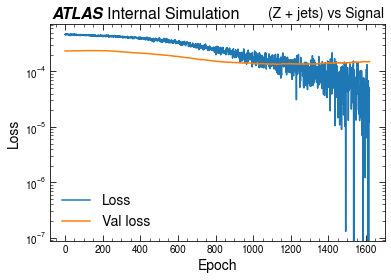

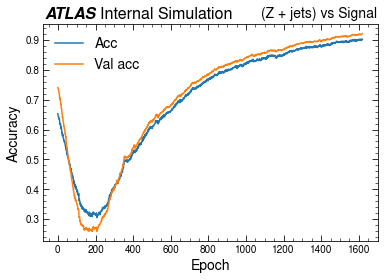

In [89]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('(Z + jets) vs Signal', fontsize=14, loc='right')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/zjets_vs_signal_loss.png')
plt.savefig('plots/per_type_test/zjets_vs_signal_loss.pdf')

plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend(frameon=False, fontsize=14)

plt.title('(Z + jets) vs Signal', fontsize=14, loc='right')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/zjets_vs_signal_acc.png')
plt.savefig('plots/per_type_test/zjets_vs_signal_acc.pdf')

plt.show()

In [79]:
bg_test['nn_output'] = classifier_Zjets.predict(bg_test[train_feats], batch_size=10000)
sig_test['nn_output'] = classifier_Zjets.predict(sig_test[train_feats], batch_size=10000)

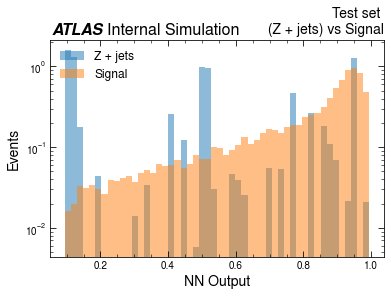

In [84]:
_, b, _ = plt.hist(bg_test.nn_output, alpha=0.5, bins=50, weights=bg_test.wgt, label='Z + jets')
plt.hist(sig_test.nn_output, bins=b, alpha=0.5, weights=sig_test.wgt, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Test set \n (Z + jets) vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/zjets_vs_signal_test_output.png')
plt.savefig('plots/per_type_test/zjets_vs_signal_test_output.pdf')

In [14]:
classifier_Zjets = keras.models.load_model('models/per_type_test/zjets_vs_signal')

In [15]:
bg_full['Zjets_classifier_out'] = classifier_Zjets.predict(bg_full[train_feats], batch_size=10000)
sig['Zjets_classifier_out'] = classifier_Zjets.predict(sig[train_feats], batch_size=10000)

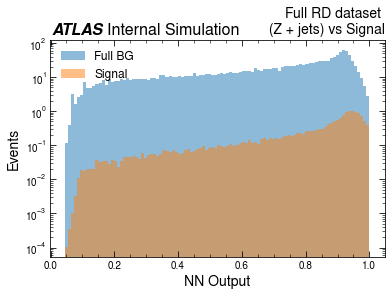

In [16]:
_, b, _ = plt.hist(bg_full.Zjets_classifier_out, bins=100, weights=bg_full.wgt, alpha=0.5, label='Full BG')
plt.hist(sig.Zjets_classifier_out, bins=b, weights=sig.wgt, alpha=0.5, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Full RD dataset \n (Z + jets) vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/zjets_vs_signal_full_output.png')
plt.savefig('plots/per_type_test/zjets_vs_signal_full_output.pdf')

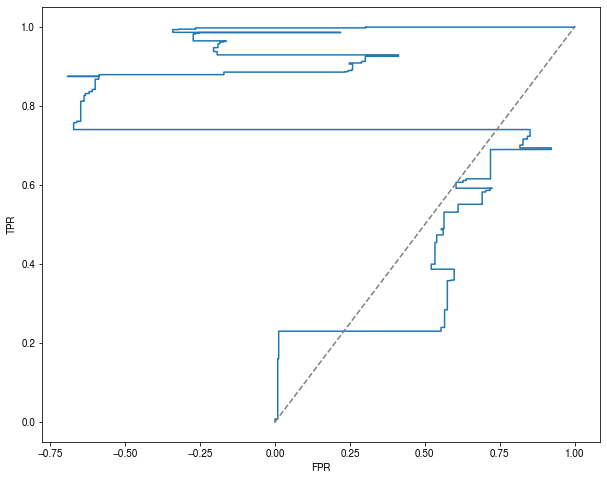

In [88]:
plt.figure(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_test, classifier_Zjets.predict(x_test[train_feats], batch_size=10000), 
                        sample_weight=w_test)
#     auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Signal vs WZ

WZ events account for

In [102]:
current_bg = bg_WZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.43444048884115444

percent of the total background. The amount relative to signal is

In [103]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 2.1478386340407623 %
Weight: 36.55120305765064 %


In [104]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# n_sig_copies = 16
n_sig_copies = 1

x_train_sig = pd.concat([sig_train[train_feats]] * n_sig_copies)
x_train_bg = bg_train[train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] * n_sig_copies + [np.zeros(len(bg_train))])
# w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
#                                     (n_sig + n_bg) / n_bg * bg_train['wgt']]))
w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = len(sig_train) # should be weighted?
n_bg_test = len(bg_train)

x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([sig_test['wgt'], bg_test['wgt']]))

x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [ ]:
# Fit ML classifier
EPOCHS = 5000
batch_size = 512
num_nodes = 32
dropout = 0.1

# Generate and fit model
classifier_WZ = Sequential()
classifier_WZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_WZ.add(Dropout(dropout))
classifier_WZ.add(Dense(num_nodes, activation='relu'))
classifier_WZ.add(Dropout(dropout))
classifier_WZ.add(Dense(num_nodes, activation='relu'))
classifier_WZ.add(Dropout(dropout))
classifier_WZ.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_WZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = classifier_WZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                               validation_data=(x_test, y_test, w_test
                                         ), sample_weight=w_train, 
                               verbose=1, callbacks=[callback])

Epoch 1/5000
67/67 [==============================] - 1s 6ms/step - loss: 2.5429e-04 - accuracy: 0.4368 - val_loss: 2.5402e-04 - val_accuracy: 0.4691
Epoch 2/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.6529e-04 - accuracy: 0.4687 - val_loss: 2.5235e-04 - val_accuracy: 0.5128
Epoch 3/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.5098e-04 - accuracy: 0.5154 - val_loss: 2.5066e-04 - val_accuracy: 0.5463
Epoch 4/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.6283e-04 - accuracy: 0.5482 - val_loss: 2.4906e-04 - val_accuracy: 0.5689
Epoch 5/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.5833e-04 - accuracy: 0.5845 - val_loss: 2.4753e-04 - val_accuracy: 0.5930
Epoch 6/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.4493e-04 - accuracy: 0.6227 - val_loss: 2.4602e-04 - val_accuracy: 0.6255
Epoch 7/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.5206e-04 - accuracy: 0.6

67/67 [==============================] - 0s 6ms/step - loss: 2.1463e-04 - accuracy: 0.9783 - val_loss: 2.1254e-04 - val_accuracy: 0.9790
Epoch 110/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1145e-04 - accuracy: 0.9791 - val_loss: 2.1253e-04 - val_accuracy: 0.9790
Epoch 111/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1610e-04 - accuracy: 0.9796 - val_loss: 2.1251e-04 - val_accuracy: 0.9790
Epoch 112/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2024e-04 - accuracy: 0.9793 - val_loss: 2.1251e-04 - val_accuracy: 0.9790
Epoch 113/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1407e-04 - accuracy: 0.9797 - val_loss: 2.1249e-04 - val_accuracy: 0.9790
Epoch 114/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3767e-04 - accuracy: 0.9788 - val_loss: 2.1247e-04 - val_accuracy: 0.9790
Epoch 115/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2378e-04 - accuracy: 0.97

Epoch 163/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8700e-04 - accuracy: 0.9801 - val_loss: 2.1189e-04 - val_accuracy: 0.9790
Epoch 164/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1404e-04 - accuracy: 0.9800 - val_loss: 2.1188e-04 - val_accuracy: 0.9790
Epoch 165/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1122e-04 - accuracy: 0.9785 - val_loss: 2.1187e-04 - val_accuracy: 0.9790
Epoch 166/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0585e-04 - accuracy: 0.9794 - val_loss: 2.1186e-04 - val_accuracy: 0.9790
Epoch 167/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0880e-04 - accuracy: 0.9789 - val_loss: 2.1186e-04 - val_accuracy: 0.9790
Epoch 168/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1431e-04 - accuracy: 0.9786 - val_loss: 2.1184e-04 - val_accuracy: 0.9790
Epoch 169/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1447e-04 -

Epoch 217/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3043e-04 - accuracy: 0.9797 - val_loss: 2.1123e-04 - val_accuracy: 0.9790
Epoch 218/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9820e-04 - accuracy: 0.9791 - val_loss: 2.1122e-04 - val_accuracy: 0.9790
Epoch 219/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0615e-04 - accuracy: 0.9785 - val_loss: 2.1121e-04 - val_accuracy: 0.9790
Epoch 220/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3281e-04 - accuracy: 0.9778 - val_loss: 2.1120e-04 - val_accuracy: 0.9790
Epoch 221/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1945e-04 - accuracy: 0.9793 - val_loss: 2.1119e-04 - val_accuracy: 0.9790
Epoch 222/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9953e-04 - accuracy: 0.9802 - val_loss: 2.1117e-04 - val_accuracy: 0.9790
Epoch 223/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0765e-04 -

Epoch 271/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1705e-04 - accuracy: 0.9796 - val_loss: 2.1065e-04 - val_accuracy: 0.9790
Epoch 272/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0113e-04 - accuracy: 0.9791 - val_loss: 2.1064e-04 - val_accuracy: 0.9790
Epoch 273/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3157e-04 - accuracy: 0.9784 - val_loss: 2.1063e-04 - val_accuracy: 0.9790
Epoch 274/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0464e-04 - accuracy: 0.9804 - val_loss: 2.1062e-04 - val_accuracy: 0.9790
Epoch 275/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3316e-04 - accuracy: 0.9788 - val_loss: 2.1061e-04 - val_accuracy: 0.9790
Epoch 276/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1714e-04 - accuracy: 0.9787 - val_loss: 2.1059e-04 - val_accuracy: 0.9790
Epoch 277/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1654e-04 -

Epoch 325/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1934e-04 - accuracy: 0.9787 - val_loss: 2.0994e-04 - val_accuracy: 0.9790
Epoch 326/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.4215e-04 - accuracy: 0.9786 - val_loss: 2.0993e-04 - val_accuracy: 0.9790
Epoch 327/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1836e-04 - accuracy: 0.9784 - val_loss: 2.0990e-04 - val_accuracy: 0.9790
Epoch 328/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8622e-04 - accuracy: 0.9802 - val_loss: 2.0991e-04 - val_accuracy: 0.9790
Epoch 329/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2463e-04 - accuracy: 0.9783 - val_loss: 2.0990e-04 - val_accuracy: 0.9790
Epoch 330/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1210e-04 - accuracy: 0.9785 - val_loss: 2.0989e-04 - val_accuracy: 0.9790
Epoch 331/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1705e-04 -

Epoch 379/5000
67/67 [==============================] - 0s 5ms/step - loss: 2.3127e-04 - accuracy: 0.9780 - val_loss: 2.0925e-04 - val_accuracy: 0.9790
Epoch 380/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0773e-04 - accuracy: 0.9795 - val_loss: 2.0923e-04 - val_accuracy: 0.9790
Epoch 381/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2340e-04 - accuracy: 0.9781 - val_loss: 2.0922e-04 - val_accuracy: 0.9790
Epoch 382/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9308e-04 - accuracy: 0.9798 - val_loss: 2.0921e-04 - val_accuracy: 0.9790
Epoch 383/5000
67/67 [==============================] - 0s 5ms/step - loss: 2.2421e-04 - accuracy: 0.9787 - val_loss: 2.0919e-04 - val_accuracy: 0.9790
Epoch 384/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1198e-04 - accuracy: 0.9788 - val_loss: 2.0918e-04 - val_accuracy: 0.9790
Epoch 385/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0459e-04 -

Epoch 433/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0185e-04 - accuracy: 0.9798 - val_loss: 2.0848e-04 - val_accuracy: 0.9790
Epoch 434/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1169e-04 - accuracy: 0.9794 - val_loss: 2.0846e-04 - val_accuracy: 0.9790
Epoch 435/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1886e-04 - accuracy: 0.9793 - val_loss: 2.0845e-04 - val_accuracy: 0.9790
Epoch 436/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1008e-04 - accuracy: 0.9797 - val_loss: 2.0843e-04 - val_accuracy: 0.9790
Epoch 437/5000
67/67 [==============================] - 0s 5ms/step - loss: 2.0629e-04 - accuracy: 0.9783 - val_loss: 2.0841e-04 - val_accuracy: 0.9790
Epoch 438/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0485e-04 - accuracy: 0.9794 - val_loss: 2.0839e-04 - val_accuracy: 0.9790
Epoch 439/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.3140e-04 -

Epoch 487/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0970e-04 - accuracy: 0.9795 - val_loss: 2.0764e-04 - val_accuracy: 0.9790
Epoch 488/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1780e-04 - accuracy: 0.9795 - val_loss: 2.0763e-04 - val_accuracy: 0.9790
Epoch 489/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0929e-04 - accuracy: 0.9786 - val_loss: 2.0760e-04 - val_accuracy: 0.9790
Epoch 490/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2534e-04 - accuracy: 0.9793 - val_loss: 2.0759e-04 - val_accuracy: 0.9790
Epoch 491/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1168e-04 - accuracy: 0.9798 - val_loss: 2.0757e-04 - val_accuracy: 0.9790
Epoch 492/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2591e-04 - accuracy: 0.9773 - val_loss: 2.0756e-04 - val_accuracy: 0.9790
Epoch 493/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0388e-04 -

Epoch 541/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1264e-04 - accuracy: 0.9794 - val_loss: 2.0684e-04 - val_accuracy: 0.9790
Epoch 542/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1494e-04 - accuracy: 0.9780 - val_loss: 2.0682e-04 - val_accuracy: 0.9790
Epoch 543/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2441e-04 - accuracy: 0.9799 - val_loss: 2.0681e-04 - val_accuracy: 0.9790
Epoch 544/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1168e-04 - accuracy: 0.9794 - val_loss: 2.0679e-04 - val_accuracy: 0.9790
Epoch 545/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2760e-04 - accuracy: 0.9780 - val_loss: 2.0678e-04 - val_accuracy: 0.9790
Epoch 546/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2238e-04 - accuracy: 0.9786 - val_loss: 2.0676e-04 - val_accuracy: 0.9790
Epoch 547/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1080e-04 -

Epoch 595/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9632e-04 - accuracy: 0.9789 - val_loss: 2.0608e-04 - val_accuracy: 0.9790
Epoch 596/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1321e-04 - accuracy: 0.9789 - val_loss: 2.0606e-04 - val_accuracy: 0.9790
Epoch 597/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0748e-04 - accuracy: 0.9797 - val_loss: 2.0604e-04 - val_accuracy: 0.9790
Epoch 598/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8545e-04 - accuracy: 0.9804 - val_loss: 2.0601e-04 - val_accuracy: 0.9790
Epoch 599/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2086e-04 - accuracy: 0.9783 - val_loss: 2.0601e-04 - val_accuracy: 0.9790
Epoch 600/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1005e-04 - accuracy: 0.9803 - val_loss: 2.0600e-04 - val_accuracy: 0.9790
Epoch 601/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1714e-04 -

Epoch 649/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9722e-04 - accuracy: 0.9799 - val_loss: 2.0523e-04 - val_accuracy: 0.9790
Epoch 650/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2571e-04 - accuracy: 0.9789 - val_loss: 2.0521e-04 - val_accuracy: 0.9790
Epoch 651/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0655e-04 - accuracy: 0.9781 - val_loss: 2.0520e-04 - val_accuracy: 0.9790
Epoch 652/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9658e-04 - accuracy: 0.9798 - val_loss: 2.0518e-04 - val_accuracy: 0.9790
Epoch 653/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2618e-04 - accuracy: 0.9787 - val_loss: 2.0518e-04 - val_accuracy: 0.9790
Epoch 654/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1154e-04 - accuracy: 0.9791 - val_loss: 2.0518e-04 - val_accuracy: 0.9790
Epoch 655/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0927e-04 -

Epoch 703/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9706e-04 - accuracy: 0.9792 - val_loss: 2.0428e-04 - val_accuracy: 0.9790
Epoch 704/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0832e-04 - accuracy: 0.9780 - val_loss: 2.0427e-04 - val_accuracy: 0.9790
Epoch 705/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1657e-04 - accuracy: 0.9785 - val_loss: 2.0425e-04 - val_accuracy: 0.9790
Epoch 706/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2302e-04 - accuracy: 0.9773 - val_loss: 2.0424e-04 - val_accuracy: 0.9790
Epoch 707/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1511e-04 - accuracy: 0.9788 - val_loss: 2.0422e-04 - val_accuracy: 0.9790
Epoch 708/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1944e-04 - accuracy: 0.9800 - val_loss: 2.0419e-04 - val_accuracy: 0.9790
Epoch 709/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9941e-04 -

Epoch 757/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0193e-04 - accuracy: 0.9789 - val_loss: 2.0328e-04 - val_accuracy: 0.9790
Epoch 758/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0308e-04 - accuracy: 0.9784 - val_loss: 2.0327e-04 - val_accuracy: 0.9790
Epoch 759/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0374e-04 - accuracy: 0.9799 - val_loss: 2.0325e-04 - val_accuracy: 0.9790
Epoch 760/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9381e-04 - accuracy: 0.9795 - val_loss: 2.0322e-04 - val_accuracy: 0.9790
Epoch 761/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9359e-04 - accuracy: 0.9802 - val_loss: 2.0320e-04 - val_accuracy: 0.9790
Epoch 762/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1476e-04 - accuracy: 0.9791 - val_loss: 2.0319e-04 - val_accuracy: 0.9790
Epoch 763/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1613e-04 -

Epoch 811/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9840e-04 - accuracy: 0.9794 - val_loss: 2.0241e-04 - val_accuracy: 0.9790
Epoch 812/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1335e-04 - accuracy: 0.9783 - val_loss: 2.0240e-04 - val_accuracy: 0.9790
Epoch 813/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0677e-04 - accuracy: 0.9797 - val_loss: 2.0239e-04 - val_accuracy: 0.9790
Epoch 814/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0079e-04 - accuracy: 0.9788 - val_loss: 2.0236e-04 - val_accuracy: 0.9790
Epoch 815/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9123e-04 - accuracy: 0.9792 - val_loss: 2.0234e-04 - val_accuracy: 0.9790
Epoch 816/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8934e-04 - accuracy: 0.9797 - val_loss: 2.0234e-04 - val_accuracy: 0.9790
Epoch 817/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1288e-04 -

Epoch 865/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1194e-04 - accuracy: 0.9788 - val_loss: 2.0146e-04 - val_accuracy: 0.9790
Epoch 866/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.2334e-04 - accuracy: 0.9786 - val_loss: 2.0144e-04 - val_accuracy: 0.9790
Epoch 867/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0025e-04 - accuracy: 0.9788 - val_loss: 2.0142e-04 - val_accuracy: 0.9790
Epoch 868/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0029e-04 - accuracy: 0.9782 - val_loss: 2.0141e-04 - val_accuracy: 0.9790
Epoch 869/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8433e-04 - accuracy: 0.9796 - val_loss: 2.0138e-04 - val_accuracy: 0.9790
Epoch 870/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9753e-04 - accuracy: 0.9798 - val_loss: 2.0137e-04 - val_accuracy: 0.9790
Epoch 871/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0380e-04 -

Epoch 919/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0455e-04 - accuracy: 0.9801 - val_loss: 2.0058e-04 - val_accuracy: 0.9790
Epoch 920/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0332e-04 - accuracy: 0.9789 - val_loss: 2.0057e-04 - val_accuracy: 0.9790
Epoch 921/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9186e-04 - accuracy: 0.9782 - val_loss: 2.0055e-04 - val_accuracy: 0.9790
Epoch 922/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0854e-04 - accuracy: 0.9764 - val_loss: 2.0053e-04 - val_accuracy: 0.9790
Epoch 923/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9625e-04 - accuracy: 0.9798 - val_loss: 2.0053e-04 - val_accuracy: 0.9790
Epoch 924/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0266e-04 - accuracy: 0.9783 - val_loss: 2.0050e-04 - val_accuracy: 0.9790
Epoch 925/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.1060e-04 -

Epoch 973/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9606e-04 - accuracy: 0.9773 - val_loss: 1.9975e-04 - val_accuracy: 0.9790
Epoch 974/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.8777e-04 - accuracy: 0.9791 - val_loss: 1.9974e-04 - val_accuracy: 0.9790
Epoch 975/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0144e-04 - accuracy: 0.9788 - val_loss: 1.9974e-04 - val_accuracy: 0.9790
Epoch 976/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0328e-04 - accuracy: 0.9781 - val_loss: 1.9974e-04 - val_accuracy: 0.9790
Epoch 977/5000
67/67 [==============================] - 0s 6ms/step - loss: 2.0143e-04 - accuracy: 0.9786 - val_loss: 1.9971e-04 - val_accuracy: 0.9790
Epoch 978/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9778e-04 - accuracy: 0.9798 - val_loss: 1.9970e-04 - val_accuracy: 0.9790
Epoch 979/5000
67/67 [==============================] - 0s 6ms/step - loss: 1.9680e-04 -

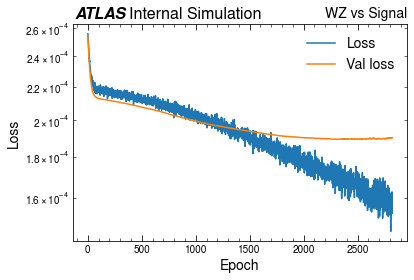

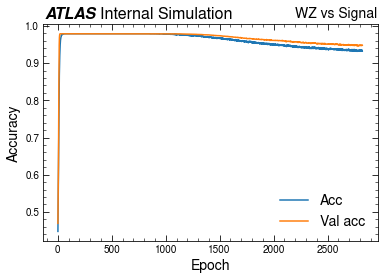

In [107]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('WZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/wz_vs_signal_loss.png')
plt.savefig('plots/per_type_test/wz_vs_signal_loss.pdf')

plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend(frameon=False, fontsize=14)

plt.title('WZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/wz_vs_signal_acc.png')
plt.savefig('plots/per_type_test/wz_vs_signal_acc.pdf')

plt.show()

In [108]:
bg_test['nn_output'] = classifier_WZ.predict(bg_test[train_feats], batch_size=10000)
sig_test['nn_output'] = classifier_WZ.predict(sig_test[train_feats], batch_size=10000)

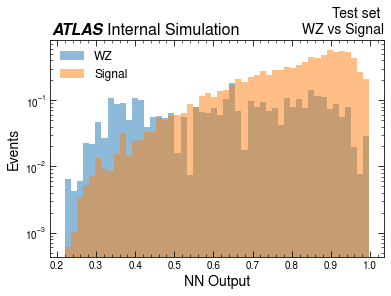

In [110]:
_, b, _ = plt.hist(bg_test.nn_output, alpha=0.5, bins=50, weights=bg_test.wgt, label='WZ')
plt.hist(sig_test.nn_output, bins=b, alpha=0.5, weights=sig_test.wgt, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Test set \n WZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/wz_vs_signal_test_output.png')
plt.savefig('plots/per_type_test/wz_vs_signal_test_output.pdf')

In [17]:
classifier_WZ = keras.models.load_model('models/per_type_test/wz_vs_signal')

In [18]:
bg_full['WZ_classifier_out'] = classifier_WZ.predict(bg_full[train_feats], batch_size=10000)
sig['WZ_classifier_out'] = classifier_WZ.predict(sig[train_feats], batch_size=10000)

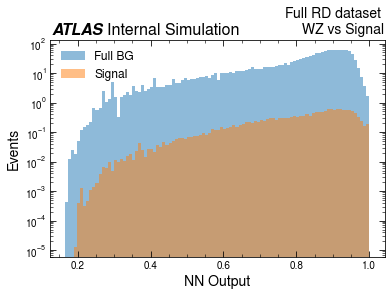

In [19]:
_, b, _ = plt.hist(bg_full.WZ_classifier_out, bins=100, weights=bg_full.wgt, alpha=0.5, label='Full BG')
plt.hist(sig.WZ_classifier_out, bins=b, weights=sig.wgt, alpha=0.5, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Full RD dataset \n WZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/wz_vs_signal_full_output.png')
plt.savefig('plots/per_type_test/wz_vs_signal_full_output.pdf')

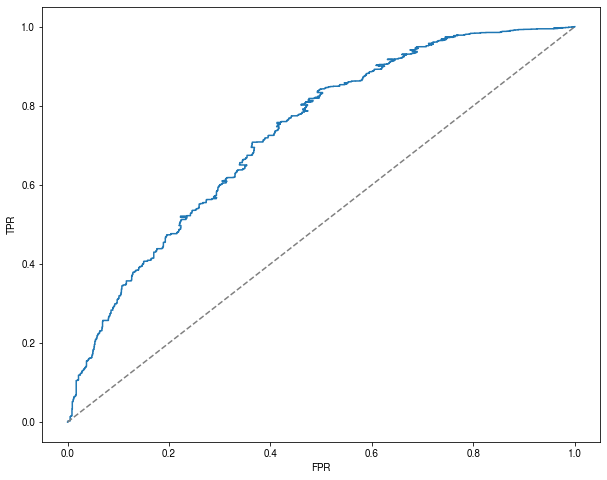

In [113]:
plt.figure(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_test, classifier_WZ.predict(x_test[train_feats], batch_size=10000), 
                        sample_weight=w_test)
#     auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Signal vs ttZ

ttZ events account for

In [115]:
current_bg = bg_ttZ
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.5854206891520616

percent of the total background. The amount relative to signal is

In [116]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 12.496242409667529 %
Weight: 49.253766702142066 %


In [117]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# n_sig_copies = 16
n_sig_copies = 1

x_train_sig = pd.concat([sig_train[train_feats]] * n_sig_copies)
x_train_bg = bg_train[train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] * n_sig_copies + [np.zeros(len(bg_train))])
# w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
#                                     (n_sig + n_bg) / n_bg * bg_train['wgt']]))
w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = len(sig_train) # should be weighted?
n_bg_test = len(bg_train)

x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([sig_test['wgt'], bg_test['wgt']]))

x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [118]:
# Fit ML classifier
EPOCHS = 5000
batch_size = 512
num_nodes = 32
dropout = 0.1

# Generate and fit model
classifier_ttZ = Sequential()
classifier_ttZ.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_ttZ.add(Dropout(dropout))
classifier_ttZ.add(Dense(num_nodes, activation='relu'))
classifier_ttZ.add(Dropout(dropout))
classifier_ttZ.add(Dense(num_nodes, activation='relu'))
classifier_ttZ.add(Dropout(dropout))
classifier_ttZ.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_ttZ.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = classifier_ttZ.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                             validation_data=(x_test, y_test, w_test
                                             ), sample_weight=w_train, 
                             verbose=1, callbacks=[callback])

Epoch 1/5000
74/74 [==============================] - 1s 6ms/step - loss: 2.4559e-04 - accuracy: 0.7870 - val_loss: 2.4155e-04 - val_accuracy: 0.8829
Epoch 2/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4548e-04 - accuracy: 0.8045 - val_loss: 2.4059e-04 - val_accuracy: 0.8860
Epoch 3/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3881e-04 - accuracy: 0.8123 - val_loss: 2.3964e-04 - val_accuracy: 0.8875
Epoch 4/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4561e-04 - accuracy: 0.8309 - val_loss: 2.3888e-04 - val_accuracy: 0.8884
Epoch 5/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4551e-04 - accuracy: 0.8391 - val_loss: 2.3814e-04 - val_accuracy: 0.8888
Epoch 6/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4873e-04 - accuracy: 0.8425 - val_loss: 2.3751e-04 - val_accuracy: 0.8888
Epoch 7/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4215e-04 - accuracy: 0.8

74/74 [==============================] - 0s 6ms/step - loss: 2.2770e-04 - accuracy: 0.8878 - val_loss: 2.2832e-04 - val_accuracy: 0.8889
Epoch 110/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3308e-04 - accuracy: 0.8873 - val_loss: 2.2828e-04 - val_accuracy: 0.8889
Epoch 111/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3780e-04 - accuracy: 0.8871 - val_loss: 2.2825e-04 - val_accuracy: 0.8889
Epoch 112/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3743e-04 - accuracy: 0.8862 - val_loss: 2.2822e-04 - val_accuracy: 0.8889
Epoch 113/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.4602e-04 - accuracy: 0.8867 - val_loss: 2.2819e-04 - val_accuracy: 0.8889
Epoch 114/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3313e-04 - accuracy: 0.8878 - val_loss: 2.2814e-04 - val_accuracy: 0.8889
Epoch 115/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3663e-04 - accuracy: 0.88

Epoch 163/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3001e-04 - accuracy: 0.8863 - val_loss: 2.2644e-04 - val_accuracy: 0.8889
Epoch 164/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3038e-04 - accuracy: 0.8880 - val_loss: 2.2641e-04 - val_accuracy: 0.8889
Epoch 165/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3340e-04 - accuracy: 0.8890 - val_loss: 2.2638e-04 - val_accuracy: 0.8889
Epoch 166/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3876e-04 - accuracy: 0.8874 - val_loss: 2.2634e-04 - val_accuracy: 0.8889
Epoch 167/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2213e-04 - accuracy: 0.8908 - val_loss: 2.2630e-04 - val_accuracy: 0.8889
Epoch 168/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2955e-04 - accuracy: 0.8886 - val_loss: 2.2627e-04 - val_accuracy: 0.8889
Epoch 169/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3589e-04 -

Epoch 217/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2689e-04 - accuracy: 0.8880 - val_loss: 2.2457e-04 - val_accuracy: 0.8889
Epoch 218/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2359e-04 - accuracy: 0.8903 - val_loss: 2.2455e-04 - val_accuracy: 0.8889
Epoch 219/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3724e-04 - accuracy: 0.8860 - val_loss: 2.2452e-04 - val_accuracy: 0.8889
Epoch 220/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3285e-04 - accuracy: 0.8844 - val_loss: 2.2450e-04 - val_accuracy: 0.8889
Epoch 221/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2294e-04 - accuracy: 0.8856 - val_loss: 2.2448e-04 - val_accuracy: 0.8889
Epoch 222/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2498e-04 - accuracy: 0.8867 - val_loss: 2.2443e-04 - val_accuracy: 0.8889
Epoch 223/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2767e-04 -

Epoch 271/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2380e-04 - accuracy: 0.8876 - val_loss: 2.2312e-04 - val_accuracy: 0.8889
Epoch 272/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2938e-04 - accuracy: 0.8882 - val_loss: 2.2310e-04 - val_accuracy: 0.8889
Epoch 273/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2806e-04 - accuracy: 0.8875 - val_loss: 2.2306e-04 - val_accuracy: 0.8889
Epoch 274/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.2072e-04 - accuracy: 0.8894 - val_loss: 2.2304e-04 - val_accuracy: 0.8889
Epoch 275/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2882e-04 - accuracy: 0.8888 - val_loss: 2.2301e-04 - val_accuracy: 0.8889
Epoch 276/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2636e-04 - accuracy: 0.8886 - val_loss: 2.2300e-04 - val_accuracy: 0.8889
Epoch 277/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2553e-04 -

Epoch 325/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3700e-04 - accuracy: 0.8841 - val_loss: 2.2199e-04 - val_accuracy: 0.8889
Epoch 326/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2947e-04 - accuracy: 0.8856 - val_loss: 2.2199e-04 - val_accuracy: 0.8889
Epoch 327/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2799e-04 - accuracy: 0.8859 - val_loss: 2.2195e-04 - val_accuracy: 0.8889
Epoch 328/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2440e-04 - accuracy: 0.8834 - val_loss: 2.2195e-04 - val_accuracy: 0.8889
Epoch 329/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2340e-04 - accuracy: 0.8852 - val_loss: 2.2194e-04 - val_accuracy: 0.8889
Epoch 330/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2854e-04 - accuracy: 0.8873 - val_loss: 2.2194e-04 - val_accuracy: 0.8889
Epoch 331/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2770e-04 -

Epoch 379/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3112e-04 - accuracy: 0.8864 - val_loss: 2.2116e-04 - val_accuracy: 0.8887
Epoch 380/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3162e-04 - accuracy: 0.8830 - val_loss: 2.2113e-04 - val_accuracy: 0.8887
Epoch 381/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2364e-04 - accuracy: 0.8859 - val_loss: 2.2112e-04 - val_accuracy: 0.8887
Epoch 382/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3168e-04 - accuracy: 0.8853 - val_loss: 2.2110e-04 - val_accuracy: 0.8887
Epoch 383/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3140e-04 - accuracy: 0.8853 - val_loss: 2.2110e-04 - val_accuracy: 0.8888
Epoch 384/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2006e-04 - accuracy: 0.8864 - val_loss: 2.2110e-04 - val_accuracy: 0.8888
Epoch 385/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1724e-04 -

Epoch 433/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3269e-04 - accuracy: 0.8847 - val_loss: 2.2046e-04 - val_accuracy: 0.8883
Epoch 434/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2143e-04 - accuracy: 0.8870 - val_loss: 2.2043e-04 - val_accuracy: 0.8884
Epoch 435/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2332e-04 - accuracy: 0.8839 - val_loss: 2.2045e-04 - val_accuracy: 0.8884
Epoch 436/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3013e-04 - accuracy: 0.8855 - val_loss: 2.2044e-04 - val_accuracy: 0.8883
Epoch 437/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2948e-04 - accuracy: 0.8827 - val_loss: 2.2040e-04 - val_accuracy: 0.8884
Epoch 438/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2659e-04 - accuracy: 0.8837 - val_loss: 2.2039e-04 - val_accuracy: 0.8884
Epoch 439/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.1990e-04 -

Epoch 487/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3029e-04 - accuracy: 0.8845 - val_loss: 2.1982e-04 - val_accuracy: 0.8879
Epoch 488/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2652e-04 - accuracy: 0.8853 - val_loss: 2.1980e-04 - val_accuracy: 0.8879
Epoch 489/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2355e-04 - accuracy: 0.8837 - val_loss: 2.1979e-04 - val_accuracy: 0.8878
Epoch 490/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2564e-04 - accuracy: 0.8838 - val_loss: 2.1977e-04 - val_accuracy: 0.8879
Epoch 491/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2435e-04 - accuracy: 0.8860 - val_loss: 2.1978e-04 - val_accuracy: 0.8878
Epoch 492/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2598e-04 - accuracy: 0.8848 - val_loss: 2.1980e-04 - val_accuracy: 0.8878
Epoch 493/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2223e-04 -

Epoch 541/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2104e-04 - accuracy: 0.8860 - val_loss: 2.1919e-04 - val_accuracy: 0.8879
Epoch 542/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2294e-04 - accuracy: 0.8843 - val_loss: 2.1917e-04 - val_accuracy: 0.8879
Epoch 543/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2014e-04 - accuracy: 0.8840 - val_loss: 2.1918e-04 - val_accuracy: 0.8879
Epoch 544/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2343e-04 - accuracy: 0.8818 - val_loss: 2.1916e-04 - val_accuracy: 0.8879
Epoch 545/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2644e-04 - accuracy: 0.8841 - val_loss: 2.1915e-04 - val_accuracy: 0.8879
Epoch 546/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2759e-04 - accuracy: 0.8842 - val_loss: 2.1913e-04 - val_accuracy: 0.8879
Epoch 547/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2856e-04 -

Epoch 595/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2820e-04 - accuracy: 0.8841 - val_loss: 2.1863e-04 - val_accuracy: 0.8876
Epoch 596/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2322e-04 - accuracy: 0.8820 - val_loss: 2.1860e-04 - val_accuracy: 0.8876
Epoch 597/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3077e-04 - accuracy: 0.8831 - val_loss: 2.1860e-04 - val_accuracy: 0.8876
Epoch 598/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2601e-04 - accuracy: 0.8848 - val_loss: 2.1857e-04 - val_accuracy: 0.8876
Epoch 599/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2082e-04 - accuracy: 0.8848 - val_loss: 2.1857e-04 - val_accuracy: 0.8876
Epoch 600/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2985e-04 - accuracy: 0.8842 - val_loss: 2.1857e-04 - val_accuracy: 0.8876
Epoch 601/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3008e-04 -

Epoch 649/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1614e-04 - accuracy: 0.8863 - val_loss: 2.1801e-04 - val_accuracy: 0.8875
Epoch 650/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.2939e-04 - accuracy: 0.8820 - val_loss: 2.1801e-04 - val_accuracy: 0.8876
Epoch 651/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1897e-04 - accuracy: 0.8835 - val_loss: 2.1801e-04 - val_accuracy: 0.8876
Epoch 652/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.1809e-04 - accuracy: 0.8840 - val_loss: 2.1801e-04 - val_accuracy: 0.8876
Epoch 653/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2391e-04 - accuracy: 0.8849 - val_loss: 2.1801e-04 - val_accuracy: 0.8876
Epoch 654/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2287e-04 - accuracy: 0.8847 - val_loss: 2.1799e-04 - val_accuracy: 0.8876
Epoch 655/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2914e-04 -

Epoch 703/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.3211e-04 - accuracy: 0.8814 - val_loss: 2.1742e-04 - val_accuracy: 0.8871
Epoch 704/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1974e-04 - accuracy: 0.8845 - val_loss: 2.1742e-04 - val_accuracy: 0.8871
Epoch 705/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2571e-04 - accuracy: 0.8818 - val_loss: 2.1742e-04 - val_accuracy: 0.8869
Epoch 706/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2569e-04 - accuracy: 0.8794 - val_loss: 2.1744e-04 - val_accuracy: 0.8867
Epoch 707/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2324e-04 - accuracy: 0.8792 - val_loss: 2.1741e-04 - val_accuracy: 0.8867
Epoch 708/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1956e-04 - accuracy: 0.8853 - val_loss: 2.1738e-04 - val_accuracy: 0.8869
Epoch 709/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1617e-04 -

Epoch 757/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1652e-04 - accuracy: 0.8826 - val_loss: 2.1687e-04 - val_accuracy: 0.8861
Epoch 758/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1497e-04 - accuracy: 0.8821 - val_loss: 2.1686e-04 - val_accuracy: 0.8860
Epoch 759/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1846e-04 - accuracy: 0.8841 - val_loss: 2.1686e-04 - val_accuracy: 0.8859
Epoch 760/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1634e-04 - accuracy: 0.8824 - val_loss: 2.1684e-04 - val_accuracy: 0.8860
Epoch 761/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2122e-04 - accuracy: 0.8828 - val_loss: 2.1682e-04 - val_accuracy: 0.8860
Epoch 762/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1686e-04 - accuracy: 0.8809 - val_loss: 2.1680e-04 - val_accuracy: 0.8860
Epoch 763/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2029e-04 -

Epoch 811/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2344e-04 - accuracy: 0.8820 - val_loss: 2.1627e-04 - val_accuracy: 0.8857
Epoch 812/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2398e-04 - accuracy: 0.8797 - val_loss: 2.1626e-04 - val_accuracy: 0.8855
Epoch 813/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1576e-04 - accuracy: 0.8814 - val_loss: 2.1623e-04 - val_accuracy: 0.8857
Epoch 814/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1713e-04 - accuracy: 0.8851 - val_loss: 2.1624e-04 - val_accuracy: 0.8855
Epoch 815/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2117e-04 - accuracy: 0.8825 - val_loss: 2.1624e-04 - val_accuracy: 0.8853
Epoch 816/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1539e-04 - accuracy: 0.8839 - val_loss: 2.1623e-04 - val_accuracy: 0.8853
Epoch 817/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1327e-04 -

Epoch 865/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2178e-04 - accuracy: 0.8843 - val_loss: 2.1572e-04 - val_accuracy: 0.8839
Epoch 866/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2183e-04 - accuracy: 0.8827 - val_loss: 2.1569e-04 - val_accuracy: 0.8840
Epoch 867/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1886e-04 - accuracy: 0.8841 - val_loss: 2.1570e-04 - val_accuracy: 0.8838
Epoch 868/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2181e-04 - accuracy: 0.8847 - val_loss: 2.1569e-04 - val_accuracy: 0.8837
Epoch 869/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2469e-04 - accuracy: 0.8805 - val_loss: 2.1567e-04 - val_accuracy: 0.8838
Epoch 870/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1862e-04 - accuracy: 0.8815 - val_loss: 2.1566e-04 - val_accuracy: 0.8838
Epoch 871/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1374e-04 -

Epoch 919/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0843e-04 - accuracy: 0.8812 - val_loss: 2.1508e-04 - val_accuracy: 0.8831
Epoch 920/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.2226e-04 - accuracy: 0.8806 - val_loss: 2.1510e-04 - val_accuracy: 0.8828
Epoch 921/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1872e-04 - accuracy: 0.8800 - val_loss: 2.1507e-04 - val_accuracy: 0.8828
Epoch 922/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1789e-04 - accuracy: 0.8785 - val_loss: 2.1505e-04 - val_accuracy: 0.8828
Epoch 923/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1629e-04 - accuracy: 0.8838 - val_loss: 2.1503e-04 - val_accuracy: 0.8828
Epoch 924/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2330e-04 - accuracy: 0.8794 - val_loss: 2.1503e-04 - val_accuracy: 0.8829
Epoch 925/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2210e-04 -

Epoch 973/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1552e-04 - accuracy: 0.8785 - val_loss: 2.1445e-04 - val_accuracy: 0.8812
Epoch 974/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2650e-04 - accuracy: 0.8771 - val_loss: 2.1441e-04 - val_accuracy: 0.8815
Epoch 975/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1324e-04 - accuracy: 0.8806 - val_loss: 2.1442e-04 - val_accuracy: 0.8813
Epoch 976/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1804e-04 - accuracy: 0.8794 - val_loss: 2.1442e-04 - val_accuracy: 0.8810
Epoch 977/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1462e-04 - accuracy: 0.8795 - val_loss: 2.1441e-04 - val_accuracy: 0.8809
Epoch 978/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2222e-04 - accuracy: 0.8801 - val_loss: 2.1441e-04 - val_accuracy: 0.8810
Epoch 979/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2097e-04 -

Epoch 1027/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1717e-04 - accuracy: 0.8790 - val_loss: 2.1374e-04 - val_accuracy: 0.8796
Epoch 1028/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1980e-04 - accuracy: 0.8744 - val_loss: 2.1374e-04 - val_accuracy: 0.8792
Epoch 1029/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1807e-04 - accuracy: 0.8787 - val_loss: 2.1372e-04 - val_accuracy: 0.8795
Epoch 1030/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1950e-04 - accuracy: 0.8781 - val_loss: 2.1370e-04 - val_accuracy: 0.8796
Epoch 1031/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1954e-04 - accuracy: 0.8781 - val_loss: 2.1369e-04 - val_accuracy: 0.8794
Epoch 1032/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2008e-04 - accuracy: 0.8782 - val_loss: 2.1367e-04 - val_accuracy: 0.8794
Epoch 1033/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.116

74/74 [==============================] - 0s 6ms/step - loss: 2.0950e-04 - accuracy: 0.8742 - val_loss: 2.1240e-04 - val_accuracy: 0.8759
Epoch 1134/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1726e-04 - accuracy: 0.8753 - val_loss: 2.1239e-04 - val_accuracy: 0.8759
Epoch 1135/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.2349e-04 - accuracy: 0.8736 - val_loss: 2.1241e-04 - val_accuracy: 0.8756
Epoch 1136/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1530e-04 - accuracy: 0.8734 - val_loss: 2.1237e-04 - val_accuracy: 0.8758
Epoch 1137/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0798e-04 - accuracy: 0.8767 - val_loss: 2.1236e-04 - val_accuracy: 0.8757
Epoch 1138/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1751e-04 - accuracy: 0.8775 - val_loss: 2.1234e-04 - val_accuracy: 0.8759
Epoch 1139/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0908e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.2122e-04 - accuracy: 0.8700 - val_loss: 2.1104e-04 - val_accuracy: 0.8748
Epoch 1240/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1627e-04 - accuracy: 0.8719 - val_loss: 2.1105e-04 - val_accuracy: 0.8747
Epoch 1241/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1688e-04 - accuracy: 0.8742 - val_loss: 2.1104e-04 - val_accuracy: 0.8748
Epoch 1242/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.2022e-04 - accuracy: 0.8707 - val_loss: 2.1104e-04 - val_accuracy: 0.8747
Epoch 1243/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1055e-04 - accuracy: 0.8716 - val_loss: 2.1101e-04 - val_accuracy: 0.8748
Epoch 1244/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1157e-04 - accuracy: 0.8711 - val_loss: 2.1099e-04 - val_accuracy: 0.8748
Epoch 1245/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1885e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.1260e-04 - accuracy: 0.8681 - val_loss: 2.0970e-04 - val_accuracy: 0.8726
Epoch 1346/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1674e-04 - accuracy: 0.8657 - val_loss: 2.0971e-04 - val_accuracy: 0.8722
Epoch 1347/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1397e-04 - accuracy: 0.8682 - val_loss: 2.0968e-04 - val_accuracy: 0.8725
Epoch 1348/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1131e-04 - accuracy: 0.8706 - val_loss: 2.0967e-04 - val_accuracy: 0.8726
Epoch 1349/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0761e-04 - accuracy: 0.8698 - val_loss: 2.0966e-04 - val_accuracy: 0.8724
Epoch 1350/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0791e-04 - accuracy: 0.8692 - val_loss: 2.0963e-04 - val_accuracy: 0.8727
Epoch 1351/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0250e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.1399e-04 - accuracy: 0.8662 - val_loss: 2.0829e-04 - val_accuracy: 0.8703
Epoch 1452/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1883e-04 - accuracy: 0.8650 - val_loss: 2.0826e-04 - val_accuracy: 0.8705
Epoch 1453/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.0939e-04 - accuracy: 0.8662 - val_loss: 2.0825e-04 - val_accuracy: 0.8704
Epoch 1454/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1184e-04 - accuracy: 0.8645 - val_loss: 2.0825e-04 - val_accuracy: 0.8701
Epoch 1455/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1349e-04 - accuracy: 0.8660 - val_loss: 2.0824e-04 - val_accuracy: 0.8699
Epoch 1456/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1506e-04 - accuracy: 0.8653 - val_loss: 2.0820e-04 - val_accuracy: 0.8703
Epoch 1457/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.1037e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0949e-04 - accuracy: 0.8631 - val_loss: 2.0692e-04 - val_accuracy: 0.8672
Epoch 1558/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1529e-04 - accuracy: 0.8619 - val_loss: 2.0691e-04 - val_accuracy: 0.8671
Epoch 1559/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0115e-04 - accuracy: 0.8627 - val_loss: 2.0687e-04 - val_accuracy: 0.8678
Epoch 1560/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1494e-04 - accuracy: 0.8628 - val_loss: 2.0686e-04 - val_accuracy: 0.8673
Epoch 1561/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0636e-04 - accuracy: 0.8615 - val_loss: 2.0685e-04 - val_accuracy: 0.8674
Epoch 1562/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.1641e-04 - accuracy: 0.8632 - val_loss: 2.0686e-04 - val_accuracy: 0.8670
Epoch 1563/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0919e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0844e-04 - accuracy: 0.8628 - val_loss: 2.0558e-04 - val_accuracy: 0.8666
Epoch 1664/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0954e-04 - accuracy: 0.8603 - val_loss: 2.0560e-04 - val_accuracy: 0.8657
Epoch 1665/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0977e-04 - accuracy: 0.8591 - val_loss: 2.0557e-04 - val_accuracy: 0.8660
Epoch 1666/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9976e-04 - accuracy: 0.8645 - val_loss: 2.0554e-04 - val_accuracy: 0.8663
Epoch 1667/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1539e-04 - accuracy: 0.8583 - val_loss: 2.0555e-04 - val_accuracy: 0.8658
Epoch 1668/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1418e-04 - accuracy: 0.8596 - val_loss: 2.0557e-04 - val_accuracy: 0.8653
Epoch 1669/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1022e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0900e-04 - accuracy: 0.8571 - val_loss: 2.0433e-04 - val_accuracy: 0.8632
Epoch 1770/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0413e-04 - accuracy: 0.8600 - val_loss: 2.0431e-04 - val_accuracy: 0.8634
Epoch 1771/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0781e-04 - accuracy: 0.8558 - val_loss: 2.0430e-04 - val_accuracy: 0.8634
Epoch 1772/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0558e-04 - accuracy: 0.8579 - val_loss: 2.0428e-04 - val_accuracy: 0.8635
Epoch 1773/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1078e-04 - accuracy: 0.8602 - val_loss: 2.0425e-04 - val_accuracy: 0.8638
Epoch 1774/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0625e-04 - accuracy: 0.8580 - val_loss: 2.0424e-04 - val_accuracy: 0.8638
Epoch 1775/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0379e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.1058e-04 - accuracy: 0.8522 - val_loss: 2.0324e-04 - val_accuracy: 0.8615
Epoch 1876/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1187e-04 - accuracy: 0.8591 - val_loss: 2.0321e-04 - val_accuracy: 0.8619
Epoch 1877/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0348e-04 - accuracy: 0.8525 - val_loss: 2.0321e-04 - val_accuracy: 0.8613
Epoch 1878/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0687e-04 - accuracy: 0.8552 - val_loss: 2.0317e-04 - val_accuracy: 0.8620
Epoch 1879/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0150e-04 - accuracy: 0.8549 - val_loss: 2.0316e-04 - val_accuracy: 0.8617
Epoch 1880/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0592e-04 - accuracy: 0.8557 - val_loss: 2.0312e-04 - val_accuracy: 0.8625
Epoch 1881/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1315e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0245e-04 - accuracy: 0.8532 - val_loss: 2.0232e-04 - val_accuracy: 0.8607
Epoch 1982/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9818e-04 - accuracy: 0.8574 - val_loss: 2.0230e-04 - val_accuracy: 0.8608
Epoch 1983/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0461e-04 - accuracy: 0.8530 - val_loss: 2.0228e-04 - val_accuracy: 0.8609
Epoch 1984/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0875e-04 - accuracy: 0.8524 - val_loss: 2.0227e-04 - val_accuracy: 0.8609
Epoch 1985/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0622e-04 - accuracy: 0.8551 - val_loss: 2.0226e-04 - val_accuracy: 0.8613
Epoch 1986/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0252e-04 - accuracy: 0.8544 - val_loss: 2.0223e-04 - val_accuracy: 0.8615
Epoch 1987/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0814e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9930e-04 - accuracy: 0.8521 - val_loss: 2.0140e-04 - val_accuracy: 0.8599
Epoch 2088/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0060e-04 - accuracy: 0.8507 - val_loss: 2.0139e-04 - val_accuracy: 0.8600
Epoch 2089/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9636e-04 - accuracy: 0.8491 - val_loss: 2.0137e-04 - val_accuracy: 0.8600
Epoch 2090/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0358e-04 - accuracy: 0.8532 - val_loss: 2.0137e-04 - val_accuracy: 0.8598
Epoch 2091/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0293e-04 - accuracy: 0.8532 - val_loss: 2.0140e-04 - val_accuracy: 0.8588
Epoch 2092/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0867e-04 - accuracy: 0.8499 - val_loss: 2.0138e-04 - val_accuracy: 0.8590
Epoch 2093/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9866e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9565e-04 - accuracy: 0.8522 - val_loss: 2.0053e-04 - val_accuracy: 0.8583
Epoch 2194/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0259e-04 - accuracy: 0.8504 - val_loss: 2.0054e-04 - val_accuracy: 0.8581
Epoch 2195/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0554e-04 - accuracy: 0.8544 - val_loss: 2.0054e-04 - val_accuracy: 0.8575
Epoch 2196/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0285e-04 - accuracy: 0.8489 - val_loss: 2.0053e-04 - val_accuracy: 0.8577
Epoch 2197/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.1220e-04 - accuracy: 0.8492 - val_loss: 2.0053e-04 - val_accuracy: 0.8575
Epoch 2198/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9942e-04 - accuracy: 0.8515 - val_loss: 2.0050e-04 - val_accuracy: 0.8584
Epoch 2199/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0085e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0513e-04 - accuracy: 0.8473 - val_loss: 1.9981e-04 - val_accuracy: 0.8570
Epoch 2300/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0196e-04 - accuracy: 0.8487 - val_loss: 1.9980e-04 - val_accuracy: 0.8569
Epoch 2301/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0758e-04 - accuracy: 0.8483 - val_loss: 1.9979e-04 - val_accuracy: 0.8569
Epoch 2302/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0231e-04 - accuracy: 0.8455 - val_loss: 1.9978e-04 - val_accuracy: 0.8570
Epoch 2303/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9512e-04 - accuracy: 0.8483 - val_loss: 1.9977e-04 - val_accuracy: 0.8569
Epoch 2304/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9891e-04 - accuracy: 0.8492 - val_loss: 1.9978e-04 - val_accuracy: 0.8569
Epoch 2305/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9867e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0057e-04 - accuracy: 0.8461 - val_loss: 1.9921e-04 - val_accuracy: 0.8557
Epoch 2406/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0043e-04 - accuracy: 0.8474 - val_loss: 1.9923e-04 - val_accuracy: 0.8552
Epoch 2407/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9979e-04 - accuracy: 0.8451 - val_loss: 1.9923e-04 - val_accuracy: 0.8552
Epoch 2408/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0149e-04 - accuracy: 0.8462 - val_loss: 1.9923e-04 - val_accuracy: 0.8549
Epoch 2409/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9877e-04 - accuracy: 0.8465 - val_loss: 1.9921e-04 - val_accuracy: 0.8555
Epoch 2410/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9813e-04 - accuracy: 0.8483 - val_loss: 1.9922e-04 - val_accuracy: 0.8552
Epoch 2411/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0763e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9958e-04 - accuracy: 0.8434 - val_loss: 1.9878e-04 - val_accuracy: 0.8539
Epoch 2512/5000
74/74 [==============================] - 0s 5ms/step - loss: 2.0230e-04 - accuracy: 0.8462 - val_loss: 1.9878e-04 - val_accuracy: 0.8542
Epoch 2513/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9676e-04 - accuracy: 0.8445 - val_loss: 1.9876e-04 - val_accuracy: 0.8541
Epoch 2514/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9330e-04 - accuracy: 0.8509 - val_loss: 1.9875e-04 - val_accuracy: 0.8543
Epoch 2515/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0469e-04 - accuracy: 0.8425 - val_loss: 1.9875e-04 - val_accuracy: 0.8537
Epoch 2516/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9735e-04 - accuracy: 0.8489 - val_loss: 1.9875e-04 - val_accuracy: 0.8542
Epoch 2517/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9757e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0213e-04 - accuracy: 0.8471 - val_loss: 1.9827e-04 - val_accuracy: 0.8524
Epoch 2618/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9683e-04 - accuracy: 0.8466 - val_loss: 1.9828e-04 - val_accuracy: 0.8520
Epoch 2619/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9797e-04 - accuracy: 0.8462 - val_loss: 1.9827e-04 - val_accuracy: 0.8525
Epoch 2620/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0282e-04 - accuracy: 0.8420 - val_loss: 1.9827e-04 - val_accuracy: 0.8522
Epoch 2621/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0083e-04 - accuracy: 0.8457 - val_loss: 1.9827e-04 - val_accuracy: 0.8523
Epoch 2622/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0084e-04 - accuracy: 0.8426 - val_loss: 1.9826e-04 - val_accuracy: 0.8530
Epoch 2623/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9822e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9185e-04 - accuracy: 0.8461 - val_loss: 1.9781e-04 - val_accuracy: 0.8517
Epoch 2724/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0019e-04 - accuracy: 0.8456 - val_loss: 1.9781e-04 - val_accuracy: 0.8517
Epoch 2725/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8871e-04 - accuracy: 0.8462 - val_loss: 1.9780e-04 - val_accuracy: 0.8517
Epoch 2726/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9643e-04 - accuracy: 0.8402 - val_loss: 1.9780e-04 - val_accuracy: 0.8510
Epoch 2727/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9343e-04 - accuracy: 0.8409 - val_loss: 1.9780e-04 - val_accuracy: 0.8509
Epoch 2728/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9155e-04 - accuracy: 0.8458 - val_loss: 1.9779e-04 - val_accuracy: 0.8513
Epoch 2729/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9571e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9868e-04 - accuracy: 0.8456 - val_loss: 1.9737e-04 - val_accuracy: 0.8507
Epoch 2830/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9167e-04 - accuracy: 0.8452 - val_loss: 1.9737e-04 - val_accuracy: 0.8501
Epoch 2831/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9409e-04 - accuracy: 0.8427 - val_loss: 1.9737e-04 - val_accuracy: 0.8500
Epoch 2832/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9589e-04 - accuracy: 0.8454 - val_loss: 1.9737e-04 - val_accuracy: 0.8498
Epoch 2833/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0422e-04 - accuracy: 0.8395 - val_loss: 1.9736e-04 - val_accuracy: 0.8501
Epoch 2834/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.9789e-04 - accuracy: 0.8411 - val_loss: 1.9736e-04 - val_accuracy: 0.8500
Epoch 2835/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9742e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9769e-04 - accuracy: 0.8469 - val_loss: 1.9699e-04 - val_accuracy: 0.8506
Epoch 2936/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9326e-04 - accuracy: 0.8440 - val_loss: 1.9699e-04 - val_accuracy: 0.8509
Epoch 2937/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9214e-04 - accuracy: 0.8464 - val_loss: 1.9699e-04 - val_accuracy: 0.8509
Epoch 2938/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9395e-04 - accuracy: 0.8454 - val_loss: 1.9698e-04 - val_accuracy: 0.8505
Epoch 2939/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8773e-04 - accuracy: 0.8421 - val_loss: 1.9699e-04 - val_accuracy: 0.8504
Epoch 2940/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9539e-04 - accuracy: 0.8434 - val_loss: 1.9698e-04 - val_accuracy: 0.8502
Epoch 2941/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9570e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 2.0249e-04 - accuracy: 0.8397 - val_loss: 1.9664e-04 - val_accuracy: 0.8494
Epoch 3042/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0088e-04 - accuracy: 0.8426 - val_loss: 1.9664e-04 - val_accuracy: 0.8495
Epoch 3043/5000
74/74 [==============================] - 0s 6ms/step - loss: 2.0200e-04 - accuracy: 0.8399 - val_loss: 1.9664e-04 - val_accuracy: 0.8496
Epoch 3044/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9156e-04 - accuracy: 0.8405 - val_loss: 1.9664e-04 - val_accuracy: 0.8497
Epoch 3045/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9393e-04 - accuracy: 0.8405 - val_loss: 1.9663e-04 - val_accuracy: 0.8498
Epoch 3046/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9579e-04 - accuracy: 0.8443 - val_loss: 1.9663e-04 - val_accuracy: 0.8491
Epoch 3047/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8836e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9384e-04 - accuracy: 0.8437 - val_loss: 1.9640e-04 - val_accuracy: 0.8482
Epoch 3148/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9363e-04 - accuracy: 0.8421 - val_loss: 1.9639e-04 - val_accuracy: 0.8490
Epoch 3149/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9452e-04 - accuracy: 0.8432 - val_loss: 1.9639e-04 - val_accuracy: 0.8491
Epoch 3150/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8753e-04 - accuracy: 0.8412 - val_loss: 1.9639e-04 - val_accuracy: 0.8489
Epoch 3151/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8811e-04 - accuracy: 0.8429 - val_loss: 1.9638e-04 - val_accuracy: 0.8484
Epoch 3152/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9504e-04 - accuracy: 0.8391 - val_loss: 1.9637e-04 - val_accuracy: 0.8476
Epoch 3153/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8777e-04 - accuracy

74/74 [==============================] - 0s 5ms/step - loss: 1.9488e-04 - accuracy: 0.8424 - val_loss: 1.9605e-04 - val_accuracy: 0.8478
Epoch 3254/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9448e-04 - accuracy: 0.8408 - val_loss: 1.9604e-04 - val_accuracy: 0.8476
Epoch 3255/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9259e-04 - accuracy: 0.8428 - val_loss: 1.9603e-04 - val_accuracy: 0.8484
Epoch 3256/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9499e-04 - accuracy: 0.8404 - val_loss: 1.9604e-04 - val_accuracy: 0.8481
Epoch 3257/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9342e-04 - accuracy: 0.8408 - val_loss: 1.9603e-04 - val_accuracy: 0.8478
Epoch 3258/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9168e-04 - accuracy: 0.8437 - val_loss: 1.9603e-04 - val_accuracy: 0.8476
Epoch 3259/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9800e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8810e-04 - accuracy: 0.8411 - val_loss: 1.9585e-04 - val_accuracy: 0.8479
Epoch 3360/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9020e-04 - accuracy: 0.8450 - val_loss: 1.9584e-04 - val_accuracy: 0.8475
Epoch 3361/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9150e-04 - accuracy: 0.8449 - val_loss: 1.9584e-04 - val_accuracy: 0.8477
Epoch 3362/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9552e-04 - accuracy: 0.8416 - val_loss: 1.9583e-04 - val_accuracy: 0.8482
Epoch 3363/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9800e-04 - accuracy: 0.8440 - val_loss: 1.9584e-04 - val_accuracy: 0.8483
Epoch 3364/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8885e-04 - accuracy: 0.8408 - val_loss: 1.9583e-04 - val_accuracy: 0.8474
Epoch 3365/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8947e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9577e-04 - accuracy: 0.8459 - val_loss: 1.9567e-04 - val_accuracy: 0.8489
Epoch 3466/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8890e-04 - accuracy: 0.8422 - val_loss: 1.9567e-04 - val_accuracy: 0.8492
Epoch 3467/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9145e-04 - accuracy: 0.8425 - val_loss: 1.9565e-04 - val_accuracy: 0.8488
Epoch 3468/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9237e-04 - accuracy: 0.8398 - val_loss: 1.9563e-04 - val_accuracy: 0.8482
Epoch 3469/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9140e-04 - accuracy: 0.8434 - val_loss: 1.9563e-04 - val_accuracy: 0.8483
Epoch 3470/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8801e-04 - accuracy: 0.8434 - val_loss: 1.9563e-04 - val_accuracy: 0.8487
Epoch 3471/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9104e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8491e-04 - accuracy: 0.8416 - val_loss: 1.9548e-04 - val_accuracy: 0.8490
Epoch 3572/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9380e-04 - accuracy: 0.8418 - val_loss: 1.9547e-04 - val_accuracy: 0.8490
Epoch 3573/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9450e-04 - accuracy: 0.8440 - val_loss: 1.9547e-04 - val_accuracy: 0.8492
Epoch 3574/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8871e-04 - accuracy: 0.8438 - val_loss: 1.9548e-04 - val_accuracy: 0.8491
Epoch 3575/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9570e-04 - accuracy: 0.8460 - val_loss: 1.9547e-04 - val_accuracy: 0.8487
Epoch 3576/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9212e-04 - accuracy: 0.8447 - val_loss: 1.9546e-04 - val_accuracy: 0.8485
Epoch 3577/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9552e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8207e-04 - accuracy: 0.8421 - val_loss: 1.9533e-04 - val_accuracy: 0.8480
Epoch 3678/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9210e-04 - accuracy: 0.8411 - val_loss: 1.9532e-04 - val_accuracy: 0.8471
Epoch 3679/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8740e-04 - accuracy: 0.8380 - val_loss: 1.9532e-04 - val_accuracy: 0.8475
Epoch 3680/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9329e-04 - accuracy: 0.8390 - val_loss: 1.9535e-04 - val_accuracy: 0.8483
Epoch 3681/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9191e-04 - accuracy: 0.8431 - val_loss: 1.9535e-04 - val_accuracy: 0.8482
Epoch 3682/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8928e-04 - accuracy: 0.8441 - val_loss: 1.9534e-04 - val_accuracy: 0.8478
Epoch 3683/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8444e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8946e-04 - accuracy: 0.8414 - val_loss: 1.9521e-04 - val_accuracy: 0.8477
Epoch 3784/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9881e-04 - accuracy: 0.8404 - val_loss: 1.9520e-04 - val_accuracy: 0.8474
Epoch 3785/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9471e-04 - accuracy: 0.8436 - val_loss: 1.9520e-04 - val_accuracy: 0.8476
Epoch 3786/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9608e-04 - accuracy: 0.8410 - val_loss: 1.9520e-04 - val_accuracy: 0.8475
Epoch 3787/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9586e-04 - accuracy: 0.8425 - val_loss: 1.9521e-04 - val_accuracy: 0.8477
Epoch 3788/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9123e-04 - accuracy: 0.8417 - val_loss: 1.9523e-04 - val_accuracy: 0.8489
Epoch 3789/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8782e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8980e-04 - accuracy: 0.8451 - val_loss: 1.9514e-04 - val_accuracy: 0.8481
Epoch 3890/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9759e-04 - accuracy: 0.8431 - val_loss: 1.9511e-04 - val_accuracy: 0.8476
Epoch 3891/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9114e-04 - accuracy: 0.8421 - val_loss: 1.9511e-04 - val_accuracy: 0.8477
Epoch 3892/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8608e-04 - accuracy: 0.8421 - val_loss: 1.9512e-04 - val_accuracy: 0.8480
Epoch 3893/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8696e-04 - accuracy: 0.8422 - val_loss: 1.9508e-04 - val_accuracy: 0.8471
Epoch 3894/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8705e-04 - accuracy: 0.8436 - val_loss: 1.9510e-04 - val_accuracy: 0.8473
Epoch 3895/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9232e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9323e-04 - accuracy: 0.8446 - val_loss: 1.9497e-04 - val_accuracy: 0.8472
Epoch 3996/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9118e-04 - accuracy: 0.8452 - val_loss: 1.9498e-04 - val_accuracy: 0.8476
Epoch 3997/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9089e-04 - accuracy: 0.8426 - val_loss: 1.9496e-04 - val_accuracy: 0.8473
Epoch 3998/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8554e-04 - accuracy: 0.8388 - val_loss: 1.9494e-04 - val_accuracy: 0.8467
Epoch 3999/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7497e-04 - accuracy: 0.8436 - val_loss: 1.9496e-04 - val_accuracy: 0.8472
Epoch 4000/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9154e-04 - accuracy: 0.8395 - val_loss: 1.9496e-04 - val_accuracy: 0.8475
Epoch 4001/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7399e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9507e-04 - accuracy: 0.8437 - val_loss: 1.9480e-04 - val_accuracy: 0.8477
Epoch 4102/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9303e-04 - accuracy: 0.8449 - val_loss: 1.9480e-04 - val_accuracy: 0.8477
Epoch 4103/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8251e-04 - accuracy: 0.8464 - val_loss: 1.9482e-04 - val_accuracy: 0.8479
Epoch 4104/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9092e-04 - accuracy: 0.8388 - val_loss: 1.9480e-04 - val_accuracy: 0.8476
Epoch 4105/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8475e-04 - accuracy: 0.8409 - val_loss: 1.9479e-04 - val_accuracy: 0.8476
Epoch 4106/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.9218e-04 - accuracy: 0.8427 - val_loss: 1.9478e-04 - val_accuracy: 0.8477
Epoch 4107/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8616e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8502e-04 - accuracy: 0.8404 - val_loss: 1.9457e-04 - val_accuracy: 0.8461
Epoch 4208/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7993e-04 - accuracy: 0.8473 - val_loss: 1.9458e-04 - val_accuracy: 0.8468
Epoch 4209/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8557e-04 - accuracy: 0.8431 - val_loss: 1.9458e-04 - val_accuracy: 0.8466
Epoch 4210/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.9161e-04 - accuracy: 0.8429 - val_loss: 1.9457e-04 - val_accuracy: 0.8471
Epoch 4211/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8250e-04 - accuracy: 0.8417 - val_loss: 1.9457e-04 - val_accuracy: 0.8473
Epoch 4212/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8860e-04 - accuracy: 0.8406 - val_loss: 1.9455e-04 - val_accuracy: 0.8468
Epoch 4213/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9269e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8421e-04 - accuracy: 0.8433 - val_loss: 1.9453e-04 - val_accuracy: 0.8480
Epoch 4314/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8576e-04 - accuracy: 0.8431 - val_loss: 1.9453e-04 - val_accuracy: 0.8477
Epoch 4315/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8203e-04 - accuracy: 0.8419 - val_loss: 1.9453e-04 - val_accuracy: 0.8480
Epoch 4316/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.9499e-04 - accuracy: 0.8393 - val_loss: 1.9450e-04 - val_accuracy: 0.8470
Epoch 4317/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.8854e-04 - accuracy: 0.8441 - val_loss: 1.9452e-04 - val_accuracy: 0.8479
Epoch 4318/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8968e-04 - accuracy: 0.8430 - val_loss: 1.9451e-04 - val_accuracy: 0.8473
Epoch 4319/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8781e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9127e-04 - accuracy: 0.8395 - val_loss: 1.9443e-04 - val_accuracy: 0.8464
Epoch 4420/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8319e-04 - accuracy: 0.8410 - val_loss: 1.9445e-04 - val_accuracy: 0.8473
Epoch 4421/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8857e-04 - accuracy: 0.8442 - val_loss: 1.9442e-04 - val_accuracy: 0.8469
Epoch 4422/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8613e-04 - accuracy: 0.8455 - val_loss: 1.9446e-04 - val_accuracy: 0.8478
Epoch 4423/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7865e-04 - accuracy: 0.8435 - val_loss: 1.9444e-04 - val_accuracy: 0.8472
Epoch 4424/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8225e-04 - accuracy: 0.8460 - val_loss: 1.9438e-04 - val_accuracy: 0.8455
Epoch 4425/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8935e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9130e-04 - accuracy: 0.8413 - val_loss: 1.9431e-04 - val_accuracy: 0.8457
Epoch 4526/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7984e-04 - accuracy: 0.8429 - val_loss: 1.9432e-04 - val_accuracy: 0.8461
Epoch 4527/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8528e-04 - accuracy: 0.8446 - val_loss: 1.9431e-04 - val_accuracy: 0.8461
Epoch 4528/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8528e-04 - accuracy: 0.8410 - val_loss: 1.9429e-04 - val_accuracy: 0.8455
Epoch 4529/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8271e-04 - accuracy: 0.8407 - val_loss: 1.9429e-04 - val_accuracy: 0.8456
Epoch 4530/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8068e-04 - accuracy: 0.8408 - val_loss: 1.9429e-04 - val_accuracy: 0.8456
Epoch 4531/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9658e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8964e-04 - accuracy: 0.8398 - val_loss: 1.9426e-04 - val_accuracy: 0.8463
Epoch 4632/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8514e-04 - accuracy: 0.8392 - val_loss: 1.9429e-04 - val_accuracy: 0.8465
Epoch 4633/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8644e-04 - accuracy: 0.8410 - val_loss: 1.9427e-04 - val_accuracy: 0.8460
Epoch 4634/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8736e-04 - accuracy: 0.8462 - val_loss: 1.9426e-04 - val_accuracy: 0.8461
Epoch 4635/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8527e-04 - accuracy: 0.8420 - val_loss: 1.9426e-04 - val_accuracy: 0.8460
Epoch 4636/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8998e-04 - accuracy: 0.8411 - val_loss: 1.9425e-04 - val_accuracy: 0.8457
Epoch 4637/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8566e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.9027e-04 - accuracy: 0.8416 - val_loss: 1.9412e-04 - val_accuracy: 0.8456
Epoch 4738/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8918e-04 - accuracy: 0.8412 - val_loss: 1.9414e-04 - val_accuracy: 0.8458
Epoch 4739/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9010e-04 - accuracy: 0.8410 - val_loss: 1.9412e-04 - val_accuracy: 0.8455
Epoch 4740/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8463e-04 - accuracy: 0.8399 - val_loss: 1.9414e-04 - val_accuracy: 0.8456
Epoch 4741/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8824e-04 - accuracy: 0.8440 - val_loss: 1.9412e-04 - val_accuracy: 0.8453
Epoch 4742/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8789e-04 - accuracy: 0.8416 - val_loss: 1.9415e-04 - val_accuracy: 0.8458
Epoch 4743/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7793e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.7738e-04 - accuracy: 0.8403 - val_loss: 1.9408e-04 - val_accuracy: 0.8454
Epoch 4844/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8186e-04 - accuracy: 0.8418 - val_loss: 1.9407e-04 - val_accuracy: 0.8451
Epoch 4845/5000
74/74 [==============================] - 0s 5ms/step - loss: 1.8597e-04 - accuracy: 0.8421 - val_loss: 1.9408e-04 - val_accuracy: 0.8455
Epoch 4846/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8326e-04 - accuracy: 0.8387 - val_loss: 1.9411e-04 - val_accuracy: 0.8465
Epoch 4847/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7894e-04 - accuracy: 0.8468 - val_loss: 1.9410e-04 - val_accuracy: 0.8462
Epoch 4848/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8186e-04 - accuracy: 0.8419 - val_loss: 1.9408e-04 - val_accuracy: 0.8455
Epoch 4849/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8414e-04 - accuracy

74/74 [==============================] - 0s 6ms/step - loss: 1.8579e-04 - accuracy: 0.8444 - val_loss: 1.9406e-04 - val_accuracy: 0.8453
Epoch 4950/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8485e-04 - accuracy: 0.8464 - val_loss: 1.9406e-04 - val_accuracy: 0.8456
Epoch 4951/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8715e-04 - accuracy: 0.8403 - val_loss: 1.9408e-04 - val_accuracy: 0.8457
Epoch 4952/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.8514e-04 - accuracy: 0.8407 - val_loss: 1.9410e-04 - val_accuracy: 0.8464
Epoch 4953/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9416e-04 - accuracy: 0.8375 - val_loss: 1.9404e-04 - val_accuracy: 0.8450
Epoch 4954/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.9175e-04 - accuracy: 0.8410 - val_loss: 1.9405e-04 - val_accuracy: 0.8451
Epoch 4955/5000
74/74 [==============================] - 0s 6ms/step - loss: 1.7941e-04 - accuracy

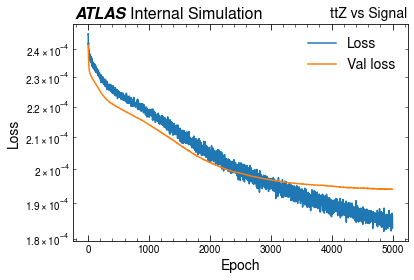

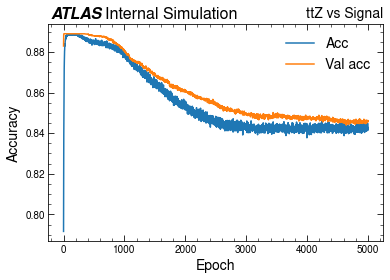

In [119]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('ttZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/ttz_vs_signal_loss.png')
plt.savefig('plots/per_type_test/ttz_vs_signal_loss.pdf')

plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend(frameon=False, fontsize=14)

plt.title('ttZ vs Signal', fontsize=14, loc='right')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/ttz_vs_signal_acc.png')
plt.savefig('plots/per_type_test/ttz_vs_signal_acc.pdf')

plt.show()

In [120]:
bg_test['nn_output'] = classifier_WZ.predict(bg_test[train_feats], batch_size=10000)
sig_test['nn_output'] = classifier_WZ.predict(sig_test[train_feats], batch_size=10000)

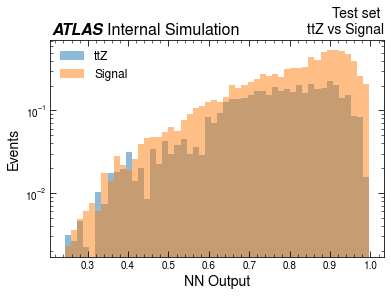

In [124]:
_, b, _ = plt.hist(bg_test.nn_output, alpha=0.5, bins=50, weights=bg_test.wgt, label='ttZ')
plt.hist(sig_test.nn_output, bins=b, alpha=0.5, weights=sig_test.wgt, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Test set \n ttZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/ttz_vs_signal_test_output.png')
plt.savefig('plots/per_type_test/ttz_vs_signal_test_output.pdf')

In [20]:
classifier_ttZ = keras.models.load_model('models/per_type_test/ttz_vs_signal')

In [21]:
bg_full['ttZ_classifier_out'] = classifier_ttZ.predict(bg_full[train_feats], batch_size=10000)
sig['ttZ_classifier_out'] = classifier_ttZ.predict(sig[train_feats], batch_size=10000)

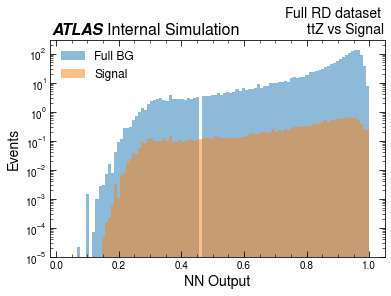

In [22]:
_, b, _ = plt.hist(bg_full.ttZ_classifier_out, bins=100, weights=bg_full.wgt, alpha=0.5, label='Full BG')
plt.hist(sig.ttZ_classifier_out, bins=b, weights=sig.wgt, alpha=0.5, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Full RD dataset \n ttZ vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/ttz_vs_signal_full_output.png')
plt.savefig('plots/per_type_test/ttz_vs_signal_full_output.pdf')

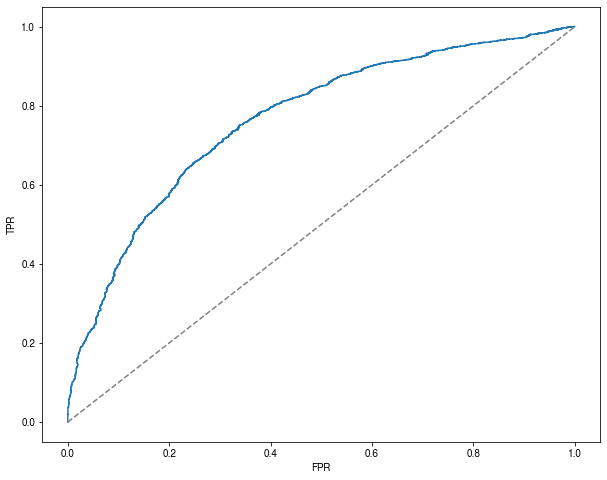

In [127]:
plt.figure(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_test, classifier_ttZ.predict(x_test[train_feats], batch_size=10000), 
                        sample_weight=w_test)
#     auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Signal vs other

Other events account for

In [134]:
current_bg = bg_other
sum(current_bg.wgt) / sum(bg_full.wgt) * 100

0.6680981427197882

percent of the total background. The amount relative to signal is

In [135]:
print('Number:', len(current_bg)/len(sig) * 100, '%')
print('Weight:', sum(current_bg.wgt)/sum(sig.wgt) * 100, '%')

Number: 0.5516142608068297 %
Weight: 56.20974910080009 %


In [136]:
# Split train and test data
sig_train, sig_test = train_test_split(sig[train_feats + ['wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(current_bg[train_feats + ['wgt']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# n_sig_copies = 16
n_sig_copies = 1

x_train_sig = pd.concat([sig_train[train_feats]] * n_sig_copies)
x_train_bg = bg_train[train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] * n_sig_copies + [np.zeros(len(bg_train))])
# w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
#                                     (n_sig + n_bg) / n_bg * bg_train['wgt']]))
w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = len(sig_train) # should be weighted?
n_bg_test = len(bg_train)

x_test = pd.concat([sig_test[train_feats], bg_test[train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([sig_test['wgt'], bg_test['wgt']]))

x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [137]:
# Fit ML classifier
EPOCHS = 5000
batch_size = 512
num_nodes = 32
dropout = 0.1

# Generate and fit model
classifier_other = Sequential()
classifier_other.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_other.add(Dropout(dropout))
classifier_other.add(Dense(num_nodes, activation='relu'))
classifier_other.add(Dropout(dropout))
classifier_other.add(Dense(num_nodes, activation='relu'))
classifier_other.add(Dropout(dropout))
classifier_other.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_other.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

history = classifier_other.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                               validation_data=(x_test, y_test, w_test
                                         ), sample_weight=w_train, 
                               verbose=1, callbacks=[callback])

Epoch 1/5000
66/66 [==============================] - 1s 7ms/step - loss: 3.1215e-04 - accuracy: 0.0358 - val_loss: 3.2634e-04 - val_accuracy: 0.0059
Epoch 2/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.1421e-04 - accuracy: 0.0467 - val_loss: 3.2439e-04 - val_accuracy: 0.0065
Epoch 3/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0922e-04 - accuracy: 0.0599 - val_loss: 3.2264e-04 - val_accuracy: 0.0077
Epoch 4/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0413e-04 - accuracy: 0.0725 - val_loss: 3.2094e-04 - val_accuracy: 0.0106
Epoch 5/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.1599e-04 - accuracy: 0.0897 - val_loss: 3.1939e-04 - val_accuracy: 0.0160
Epoch 6/5000
66/66 [==============================] - 0s 6ms/step - loss: 3.0051e-04 - accuracy: 0.1073 - val_loss: 3.1782e-04 - val_accuracy: 0.0257
Epoch 7/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8753e-04 - accuracy: 0.1

66/66 [==============================] - 0s 6ms/step - loss: 2.7093e-04 - accuracy: 0.9916 - val_loss: 2.9032e-04 - val_accuracy: 0.9945
Epoch 110/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8586e-04 - accuracy: 0.9919 - val_loss: 2.9026e-04 - val_accuracy: 0.9945
Epoch 111/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3664e-04 - accuracy: 0.9937 - val_loss: 2.9023e-04 - val_accuracy: 0.9945
Epoch 112/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8548e-04 - accuracy: 0.9924 - val_loss: 2.9017e-04 - val_accuracy: 0.9945
Epoch 113/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7000e-04 - accuracy: 0.9922 - val_loss: 2.9013e-04 - val_accuracy: 0.9945
Epoch 114/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7533e-04 - accuracy: 0.9926 - val_loss: 2.9008e-04 - val_accuracy: 0.9945
Epoch 115/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8139e-04 - accuracy: 0.99

Epoch 163/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5402e-04 - accuracy: 0.9920 - val_loss: 2.8784e-04 - val_accuracy: 0.9945
Epoch 164/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4348e-04 - accuracy: 0.9928 - val_loss: 2.8781e-04 - val_accuracy: 0.9945
Epoch 165/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6200e-04 - accuracy: 0.9921 - val_loss: 2.8776e-04 - val_accuracy: 0.9945
Epoch 166/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7131e-04 - accuracy: 0.9917 - val_loss: 2.8772e-04 - val_accuracy: 0.9945
Epoch 167/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4980e-04 - accuracy: 0.9921 - val_loss: 2.8771e-04 - val_accuracy: 0.9945
Epoch 168/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6047e-04 - accuracy: 0.9916 - val_loss: 2.8765e-04 - val_accuracy: 0.9945
Epoch 169/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.7062e-04 -

Epoch 217/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5979e-04 - accuracy: 0.9892 - val_loss: 2.8512e-04 - val_accuracy: 0.9945
Epoch 218/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4711e-04 - accuracy: 0.9901 - val_loss: 2.8503e-04 - val_accuracy: 0.9945
Epoch 219/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5007e-04 - accuracy: 0.9893 - val_loss: 2.8497e-04 - val_accuracy: 0.9945
Epoch 220/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5527e-04 - accuracy: 0.9889 - val_loss: 2.8492e-04 - val_accuracy: 0.9945
Epoch 221/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5366e-04 - accuracy: 0.9901 - val_loss: 2.8490e-04 - val_accuracy: 0.9945
Epoch 222/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4471e-04 - accuracy: 0.9891 - val_loss: 2.8487e-04 - val_accuracy: 0.9945
Epoch 223/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5653e-04 -

Epoch 271/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6807e-04 - accuracy: 0.9841 - val_loss: 2.8162e-04 - val_accuracy: 0.9929
Epoch 272/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3401e-04 - accuracy: 0.9837 - val_loss: 2.8157e-04 - val_accuracy: 0.9929
Epoch 273/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4150e-04 - accuracy: 0.9847 - val_loss: 2.8149e-04 - val_accuracy: 0.9928
Epoch 274/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4188e-04 - accuracy: 0.9829 - val_loss: 2.8132e-04 - val_accuracy: 0.9921
Epoch 275/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1854e-04 - accuracy: 0.9845 - val_loss: 2.8134e-04 - val_accuracy: 0.9923
Epoch 276/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5826e-04 - accuracy: 0.9826 - val_loss: 2.8124e-04 - val_accuracy: 0.9920
Epoch 277/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.6501e-04 -

Epoch 325/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2903e-04 - accuracy: 0.9763 - val_loss: 2.7714e-04 - val_accuracy: 0.9836
Epoch 326/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5243e-04 - accuracy: 0.9744 - val_loss: 2.7705e-04 - val_accuracy: 0.9834
Epoch 327/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5279e-04 - accuracy: 0.9739 - val_loss: 2.7698e-04 - val_accuracy: 0.9833
Epoch 328/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4962e-04 - accuracy: 0.9762 - val_loss: 2.7690e-04 - val_accuracy: 0.9831
Epoch 329/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5934e-04 - accuracy: 0.9754 - val_loss: 2.7681e-04 - val_accuracy: 0.9827
Epoch 330/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4330e-04 - accuracy: 0.9755 - val_loss: 2.7676e-04 - val_accuracy: 0.9826
Epoch 331/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4571e-04 -

Epoch 379/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.8360e-04 - accuracy: 0.9685 - val_loss: 2.7198e-04 - val_accuracy: 0.9749
Epoch 380/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4492e-04 - accuracy: 0.9687 - val_loss: 2.7190e-04 - val_accuracy: 0.9749
Epoch 381/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5662e-04 - accuracy: 0.9670 - val_loss: 2.7181e-04 - val_accuracy: 0.9748
Epoch 382/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3289e-04 - accuracy: 0.9681 - val_loss: 2.7173e-04 - val_accuracy: 0.9751
Epoch 383/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4308e-04 - accuracy: 0.9697 - val_loss: 2.7157e-04 - val_accuracy: 0.9743
Epoch 384/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2467e-04 - accuracy: 0.9666 - val_loss: 2.7148e-04 - val_accuracy: 0.9746
Epoch 385/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4835e-04 -

Epoch 433/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2115e-04 - accuracy: 0.9605 - val_loss: 2.6544e-04 - val_accuracy: 0.9670
Epoch 434/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2183e-04 - accuracy: 0.9637 - val_loss: 2.6529e-04 - val_accuracy: 0.9670
Epoch 435/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3783e-04 - accuracy: 0.9628 - val_loss: 2.6517e-04 - val_accuracy: 0.9668
Epoch 436/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1161e-04 - accuracy: 0.9623 - val_loss: 2.6515e-04 - val_accuracy: 0.9671
Epoch 437/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2526e-04 - accuracy: 0.9607 - val_loss: 2.6495e-04 - val_accuracy: 0.9666
Epoch 438/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3808e-04 - accuracy: 0.9613 - val_loss: 2.6479e-04 - val_accuracy: 0.9662
Epoch 439/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2352e-04 -

Epoch 487/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2649e-04 - accuracy: 0.9562 - val_loss: 2.5883e-04 - val_accuracy: 0.9634
Epoch 488/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1702e-04 - accuracy: 0.9556 - val_loss: 2.5866e-04 - val_accuracy: 0.9632
Epoch 489/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3019e-04 - accuracy: 0.9569 - val_loss: 2.5851e-04 - val_accuracy: 0.9628
Epoch 490/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1918e-04 - accuracy: 0.9539 - val_loss: 2.5841e-04 - val_accuracy: 0.9629
Epoch 491/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3159e-04 - accuracy: 0.9559 - val_loss: 2.5831e-04 - val_accuracy: 0.9628
Epoch 492/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3339e-04 - accuracy: 0.9547 - val_loss: 2.5815e-04 - val_accuracy: 0.9626
Epoch 493/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1743e-04 -

Epoch 541/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0699e-04 - accuracy: 0.9527 - val_loss: 2.5166e-04 - val_accuracy: 0.9585
Epoch 542/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.4874e-04 - accuracy: 0.9503 - val_loss: 2.5138e-04 - val_accuracy: 0.9576
Epoch 543/5000
66/66 [==============================] - 0s 5ms/step - loss: 2.2108e-04 - accuracy: 0.9515 - val_loss: 2.5133e-04 - val_accuracy: 0.9580
Epoch 544/5000
66/66 [==============================] - 0s 5ms/step - loss: 2.1679e-04 - accuracy: 0.9499 - val_loss: 2.5118e-04 - val_accuracy: 0.9575
Epoch 545/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.3280e-04 - accuracy: 0.9485 - val_loss: 2.5103e-04 - val_accuracy: 0.9575
Epoch 546/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1617e-04 - accuracy: 0.9482 - val_loss: 2.5102e-04 - val_accuracy: 0.9581
Epoch 547/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2538e-04 -

Epoch 595/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0661e-04 - accuracy: 0.9495 - val_loss: 2.4471e-04 - val_accuracy: 0.9544
Epoch 596/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1258e-04 - accuracy: 0.9447 - val_loss: 2.4471e-04 - val_accuracy: 0.9549
Epoch 597/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1526e-04 - accuracy: 0.9474 - val_loss: 2.4461e-04 - val_accuracy: 0.9548
Epoch 598/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2640e-04 - accuracy: 0.9450 - val_loss: 2.4441e-04 - val_accuracy: 0.9540
Epoch 599/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2207e-04 - accuracy: 0.9457 - val_loss: 2.4428e-04 - val_accuracy: 0.9541
Epoch 600/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0774e-04 - accuracy: 0.9480 - val_loss: 2.4432e-04 - val_accuracy: 0.9549
Epoch 601/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9968e-04 -

Epoch 649/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8352e-04 - accuracy: 0.9414 - val_loss: 2.3831e-04 - val_accuracy: 0.9488
Epoch 650/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9461e-04 - accuracy: 0.9408 - val_loss: 2.3814e-04 - val_accuracy: 0.9481
Epoch 651/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9979e-04 - accuracy: 0.9420 - val_loss: 2.3794e-04 - val_accuracy: 0.9475
Epoch 652/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0583e-04 - accuracy: 0.9382 - val_loss: 2.3786e-04 - val_accuracy: 0.9476
Epoch 653/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0264e-04 - accuracy: 0.9392 - val_loss: 2.3774e-04 - val_accuracy: 0.9474
Epoch 654/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.5225e-04 - accuracy: 0.9375 - val_loss: 2.3742e-04 - val_accuracy: 0.9457
Epoch 655/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1472e-04 -

Epoch 703/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8728e-04 - accuracy: 0.9368 - val_loss: 2.3234e-04 - val_accuracy: 0.9439
Epoch 704/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2737e-04 - accuracy: 0.9360 - val_loss: 2.3223e-04 - val_accuracy: 0.9436
Epoch 705/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.2592e-04 - accuracy: 0.9359 - val_loss: 2.3217e-04 - val_accuracy: 0.9438
Epoch 706/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0358e-04 - accuracy: 0.9347 - val_loss: 2.3222e-04 - val_accuracy: 0.9445
Epoch 707/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0195e-04 - accuracy: 0.9366 - val_loss: 2.3211e-04 - val_accuracy: 0.9445
Epoch 708/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0475e-04 - accuracy: 0.9375 - val_loss: 2.3195e-04 - val_accuracy: 0.9442
Epoch 709/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0622e-04 -

Epoch 757/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1979e-04 - accuracy: 0.9332 - val_loss: 2.2739e-04 - val_accuracy: 0.9409
Epoch 758/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9719e-04 - accuracy: 0.9315 - val_loss: 2.2740e-04 - val_accuracy: 0.9415
Epoch 759/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1917e-04 - accuracy: 0.9341 - val_loss: 2.2740e-04 - val_accuracy: 0.9419
Epoch 760/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0013e-04 - accuracy: 0.9337 - val_loss: 2.2743e-04 - val_accuracy: 0.9421
Epoch 761/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1566e-04 - accuracy: 0.9299 - val_loss: 2.2727e-04 - val_accuracy: 0.9421
Epoch 762/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9046e-04 - accuracy: 0.9349 - val_loss: 2.2726e-04 - val_accuracy: 0.9421
Epoch 763/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0367e-04 -

Epoch 811/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9525e-04 - accuracy: 0.9303 - val_loss: 2.2318e-04 - val_accuracy: 0.9402
Epoch 812/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0274e-04 - accuracy: 0.9288 - val_loss: 2.2313e-04 - val_accuracy: 0.9402
Epoch 813/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0506e-04 - accuracy: 0.9311 - val_loss: 2.2305e-04 - val_accuracy: 0.9404
Epoch 814/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8988e-04 - accuracy: 0.9336 - val_loss: 2.2305e-04 - val_accuracy: 0.9408
Epoch 815/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9611e-04 - accuracy: 0.9320 - val_loss: 2.2298e-04 - val_accuracy: 0.9408
Epoch 816/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0018e-04 - accuracy: 0.9315 - val_loss: 2.2281e-04 - val_accuracy: 0.9405
Epoch 817/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0155e-04 -

Epoch 865/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1007e-04 - accuracy: 0.9297 - val_loss: 2.1916e-04 - val_accuracy: 0.9387
Epoch 866/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.1315e-04 - accuracy: 0.9301 - val_loss: 2.1911e-04 - val_accuracy: 0.9387
Epoch 867/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9602e-04 - accuracy: 0.9304 - val_loss: 2.1907e-04 - val_accuracy: 0.9390
Epoch 868/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8443e-04 - accuracy: 0.9276 - val_loss: 2.1880e-04 - val_accuracy: 0.9379
Epoch 869/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9400e-04 - accuracy: 0.9308 - val_loss: 2.1862e-04 - val_accuracy: 0.9372
Epoch 870/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8385e-04 - accuracy: 0.9282 - val_loss: 2.1866e-04 - val_accuracy: 0.9376
Epoch 871/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9154e-04 -

Epoch 919/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8487e-04 - accuracy: 0.9283 - val_loss: 2.1558e-04 - val_accuracy: 0.9380
Epoch 920/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9960e-04 - accuracy: 0.9325 - val_loss: 2.1557e-04 - val_accuracy: 0.9381
Epoch 921/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9194e-04 - accuracy: 0.9292 - val_loss: 2.1541e-04 - val_accuracy: 0.9377
Epoch 922/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7136e-04 - accuracy: 0.9301 - val_loss: 2.1563e-04 - val_accuracy: 0.9392
Epoch 923/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9072e-04 - accuracy: 0.9295 - val_loss: 2.1539e-04 - val_accuracy: 0.9381
Epoch 924/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9013e-04 - accuracy: 0.9298 - val_loss: 2.1532e-04 - val_accuracy: 0.9383
Epoch 925/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9156e-04 -

Epoch 973/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8869e-04 - accuracy: 0.9283 - val_loss: 2.1175e-04 - val_accuracy: 0.9369
Epoch 974/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9213e-04 - accuracy: 0.9250 - val_loss: 2.1175e-04 - val_accuracy: 0.9370
Epoch 975/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6864e-04 - accuracy: 0.9309 - val_loss: 2.1164e-04 - val_accuracy: 0.9367
Epoch 976/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0192e-04 - accuracy: 0.9247 - val_loss: 2.1150e-04 - val_accuracy: 0.9363
Epoch 977/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7789e-04 - accuracy: 0.9270 - val_loss: 2.1184e-04 - val_accuracy: 0.9378
Epoch 978/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9359e-04 - accuracy: 0.9261 - val_loss: 2.1155e-04 - val_accuracy: 0.9369
Epoch 979/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8788e-04 -

Epoch 1027/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8895e-04 - accuracy: 0.9249 - val_loss: 2.0864e-04 - val_accuracy: 0.9371
Epoch 1028/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8354e-04 - accuracy: 0.9267 - val_loss: 2.0857e-04 - val_accuracy: 0.9370
Epoch 1029/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7253e-04 - accuracy: 0.9256 - val_loss: 2.0855e-04 - val_accuracy: 0.9370
Epoch 1030/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9140e-04 - accuracy: 0.9256 - val_loss: 2.0823e-04 - val_accuracy: 0.9356
Epoch 1031/5000
66/66 [==============================] - 0s 6ms/step - loss: 2.0086e-04 - accuracy: 0.9257 - val_loss: 2.0813e-04 - val_accuracy: 0.9353
Epoch 1032/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8458e-04 - accuracy: 0.9256 - val_loss: 2.0811e-04 - val_accuracy: 0.9355
Epoch 1033/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.835

66/66 [==============================] - 0s 6ms/step - loss: 1.7500e-04 - accuracy: 0.9266 - val_loss: 2.0307e-04 - val_accuracy: 0.9353
Epoch 1134/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9880e-04 - accuracy: 0.9222 - val_loss: 2.0300e-04 - val_accuracy: 0.9352
Epoch 1135/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8455e-04 - accuracy: 0.9247 - val_loss: 2.0309e-04 - val_accuracy: 0.9360
Epoch 1136/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6713e-04 - accuracy: 0.9264 - val_loss: 2.0314e-04 - val_accuracy: 0.9361
Epoch 1137/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7523e-04 - accuracy: 0.9244 - val_loss: 2.0294e-04 - val_accuracy: 0.9358
Epoch 1138/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8337e-04 - accuracy: 0.9232 - val_loss: 2.0295e-04 - val_accuracy: 0.9358
Epoch 1139/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9365e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.6523e-04 - accuracy: 0.9203 - val_loss: 1.9861e-04 - val_accuracy: 0.9343
Epoch 1240/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7700e-04 - accuracy: 0.9230 - val_loss: 1.9857e-04 - val_accuracy: 0.9346
Epoch 1241/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.9363e-04 - accuracy: 0.9208 - val_loss: 1.9847e-04 - val_accuracy: 0.9341
Epoch 1242/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6974e-04 - accuracy: 0.9238 - val_loss: 1.9836e-04 - val_accuracy: 0.9340
Epoch 1243/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5473e-04 - accuracy: 0.9198 - val_loss: 1.9852e-04 - val_accuracy: 0.9351
Epoch 1244/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7568e-04 - accuracy: 0.9236 - val_loss: 1.9836e-04 - val_accuracy: 0.9342
Epoch 1245/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7347e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.7450e-04 - accuracy: 0.9204 - val_loss: 1.9457e-04 - val_accuracy: 0.9332
Epoch 1346/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5175e-04 - accuracy: 0.9226 - val_loss: 1.9440e-04 - val_accuracy: 0.9327
Epoch 1347/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6752e-04 - accuracy: 0.9207 - val_loss: 1.9447e-04 - val_accuracy: 0.9332
Epoch 1348/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8521e-04 - accuracy: 0.9206 - val_loss: 1.9457e-04 - val_accuracy: 0.9335
Epoch 1349/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5281e-04 - accuracy: 0.9246 - val_loss: 1.9436e-04 - val_accuracy: 0.9329
Epoch 1350/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7675e-04 - accuracy: 0.9189 - val_loss: 1.9413e-04 - val_accuracy: 0.9325
Epoch 1351/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6659e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.7206e-04 - accuracy: 0.9219 - val_loss: 1.9176e-04 - val_accuracy: 0.9332
Epoch 1452/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8269e-04 - accuracy: 0.9204 - val_loss: 1.9197e-04 - val_accuracy: 0.9337
Epoch 1453/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6871e-04 - accuracy: 0.9211 - val_loss: 1.9177e-04 - val_accuracy: 0.9331
Epoch 1454/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6269e-04 - accuracy: 0.9208 - val_loss: 1.9183e-04 - val_accuracy: 0.9333
Epoch 1455/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6742e-04 - accuracy: 0.9200 - val_loss: 1.9158e-04 - val_accuracy: 0.9323
Epoch 1456/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7252e-04 - accuracy: 0.9218 - val_loss: 1.9150e-04 - val_accuracy: 0.9322
Epoch 1457/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6370e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.9150e-04 - accuracy: 0.9206 - val_loss: 1.8876e-04 - val_accuracy: 0.9322
Epoch 1558/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5457e-04 - accuracy: 0.9165 - val_loss: 1.8869e-04 - val_accuracy: 0.9319
Epoch 1559/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5407e-04 - accuracy: 0.9164 - val_loss: 1.8875e-04 - val_accuracy: 0.9321
Epoch 1560/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5611e-04 - accuracy: 0.9218 - val_loss: 1.8867e-04 - val_accuracy: 0.9319
Epoch 1561/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.8475e-04 - accuracy: 0.9155 - val_loss: 1.8831e-04 - val_accuracy: 0.9305
Epoch 1562/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6687e-04 - accuracy: 0.9187 - val_loss: 1.8838e-04 - val_accuracy: 0.9314
Epoch 1563/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5114e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.4380e-04 - accuracy: 0.9206 - val_loss: 1.8679e-04 - val_accuracy: 0.9332
Epoch 1664/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6654e-04 - accuracy: 0.9196 - val_loss: 1.8658e-04 - val_accuracy: 0.9327
Epoch 1665/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4871e-04 - accuracy: 0.9191 - val_loss: 1.8647e-04 - val_accuracy: 0.9323
Epoch 1666/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5131e-04 - accuracy: 0.9170 - val_loss: 1.8661e-04 - val_accuracy: 0.9330
Epoch 1667/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4791e-04 - accuracy: 0.9252 - val_loss: 1.8642e-04 - val_accuracy: 0.9323
Epoch 1668/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5919e-04 - accuracy: 0.9185 - val_loss: 1.8612e-04 - val_accuracy: 0.9315
Epoch 1669/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5084e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.5723e-04 - accuracy: 0.9185 - val_loss: 1.8431e-04 - val_accuracy: 0.9332
Epoch 1770/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.7266e-04 - accuracy: 0.9189 - val_loss: 1.8415e-04 - val_accuracy: 0.9328
Epoch 1771/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4167e-04 - accuracy: 0.9187 - val_loss: 1.8396e-04 - val_accuracy: 0.9321
Epoch 1772/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5975e-04 - accuracy: 0.9189 - val_loss: 1.8395e-04 - val_accuracy: 0.9323
Epoch 1773/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5694e-04 - accuracy: 0.9207 - val_loss: 1.8392e-04 - val_accuracy: 0.9324
Epoch 1774/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5404e-04 - accuracy: 0.9179 - val_loss: 1.8407e-04 - val_accuracy: 0.9329
Epoch 1775/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6793e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.5149e-04 - accuracy: 0.9205 - val_loss: 1.8254e-04 - val_accuracy: 0.9326
Epoch 1876/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5700e-04 - accuracy: 0.9200 - val_loss: 1.8266e-04 - val_accuracy: 0.9332
Epoch 1877/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5239e-04 - accuracy: 0.9198 - val_loss: 1.8260e-04 - val_accuracy: 0.9329
Epoch 1878/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4592e-04 - accuracy: 0.9223 - val_loss: 1.8245e-04 - val_accuracy: 0.9325
Epoch 1879/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6087e-04 - accuracy: 0.9173 - val_loss: 1.8218e-04 - val_accuracy: 0.9315
Epoch 1880/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5119e-04 - accuracy: 0.9167 - val_loss: 1.8255e-04 - val_accuracy: 0.9328
Epoch 1881/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.6268e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.5988e-04 - accuracy: 0.9195 - val_loss: 1.8062e-04 - val_accuracy: 0.9316
Epoch 1982/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4292e-04 - accuracy: 0.9192 - val_loss: 1.8116e-04 - val_accuracy: 0.9329
Epoch 1983/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3597e-04 - accuracy: 0.9218 - val_loss: 1.8137e-04 - val_accuracy: 0.9337
Epoch 1984/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3501e-04 - accuracy: 0.9220 - val_loss: 1.8106e-04 - val_accuracy: 0.9330
Epoch 1985/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4887e-04 - accuracy: 0.9251 - val_loss: 1.8121e-04 - val_accuracy: 0.9338
Epoch 1986/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3522e-04 - accuracy: 0.9221 - val_loss: 1.8079e-04 - val_accuracy: 0.9323
Epoch 1987/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4294e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.5304e-04 - accuracy: 0.9203 - val_loss: 1.7951e-04 - val_accuracy: 0.9326
Epoch 2088/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3427e-04 - accuracy: 0.9212 - val_loss: 1.7967e-04 - val_accuracy: 0.9331
Epoch 2089/5000
66/66 [==============================] - 0s 5ms/step - loss: 1.4568e-04 - accuracy: 0.9191 - val_loss: 1.7993e-04 - val_accuracy: 0.9340
Epoch 2090/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4130e-04 - accuracy: 0.9228 - val_loss: 1.7985e-04 - val_accuracy: 0.9336
Epoch 2091/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4190e-04 - accuracy: 0.9223 - val_loss: 1.7890e-04 - val_accuracy: 0.9313
Epoch 2092/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3967e-04 - accuracy: 0.9216 - val_loss: 1.7896e-04 - val_accuracy: 0.9315
Epoch 2093/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3933e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.3699e-04 - accuracy: 0.9228 - val_loss: 1.7788e-04 - val_accuracy: 0.9318
Epoch 2194/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3593e-04 - accuracy: 0.9201 - val_loss: 1.7772e-04 - val_accuracy: 0.9317
Epoch 2195/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3921e-04 - accuracy: 0.9213 - val_loss: 1.7785e-04 - val_accuracy: 0.9319
Epoch 2196/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4093e-04 - accuracy: 0.9214 - val_loss: 1.7816e-04 - val_accuracy: 0.9327
Epoch 2197/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2330e-04 - accuracy: 0.9240 - val_loss: 1.7824e-04 - val_accuracy: 0.9330
Epoch 2198/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4247e-04 - accuracy: 0.9197 - val_loss: 1.7798e-04 - val_accuracy: 0.9323
Epoch 2199/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2694e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.3608e-04 - accuracy: 0.9192 - val_loss: 1.7636e-04 - val_accuracy: 0.9305
Epoch 2300/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4148e-04 - accuracy: 0.9206 - val_loss: 1.7613e-04 - val_accuracy: 0.9300
Epoch 2301/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3606e-04 - accuracy: 0.9185 - val_loss: 1.7609e-04 - val_accuracy: 0.9303
Epoch 2302/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3139e-04 - accuracy: 0.9212 - val_loss: 1.7592e-04 - val_accuracy: 0.9297
Epoch 2303/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5429e-04 - accuracy: 0.9155 - val_loss: 1.7604e-04 - val_accuracy: 0.9300
Epoch 2304/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4608e-04 - accuracy: 0.9189 - val_loss: 1.7602e-04 - val_accuracy: 0.9299
Epoch 2305/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3145e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.2632e-04 - accuracy: 0.9207 - val_loss: 1.7628e-04 - val_accuracy: 0.9332
Epoch 2406/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4118e-04 - accuracy: 0.9216 - val_loss: 1.7585e-04 - val_accuracy: 0.9320
Epoch 2407/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4991e-04 - accuracy: 0.9193 - val_loss: 1.7573e-04 - val_accuracy: 0.9316
Epoch 2408/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2900e-04 - accuracy: 0.9237 - val_loss: 1.7570e-04 - val_accuracy: 0.9317
Epoch 2409/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4444e-04 - accuracy: 0.9203 - val_loss: 1.7549e-04 - val_accuracy: 0.9311
Epoch 2410/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3686e-04 - accuracy: 0.9192 - val_loss: 1.7567e-04 - val_accuracy: 0.9314
Epoch 2411/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2972e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.3090e-04 - accuracy: 0.9208 - val_loss: 1.7506e-04 - val_accuracy: 0.9329
Epoch 2512/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1841e-04 - accuracy: 0.9244 - val_loss: 1.7488e-04 - val_accuracy: 0.9324
Epoch 2513/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3846e-04 - accuracy: 0.9231 - val_loss: 1.7509e-04 - val_accuracy: 0.9330
Epoch 2514/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3207e-04 - accuracy: 0.9230 - val_loss: 1.7510e-04 - val_accuracy: 0.9329
Epoch 2515/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2352e-04 - accuracy: 0.9233 - val_loss: 1.7470e-04 - val_accuracy: 0.9319
Epoch 2516/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2623e-04 - accuracy: 0.9223 - val_loss: 1.7510e-04 - val_accuracy: 0.9329
Epoch 2517/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2474e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1640e-04 - accuracy: 0.9239 - val_loss: 1.7516e-04 - val_accuracy: 0.9344
Epoch 2618/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1903e-04 - accuracy: 0.9264 - val_loss: 1.7540e-04 - val_accuracy: 0.9352
Epoch 2619/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2155e-04 - accuracy: 0.9253 - val_loss: 1.7571e-04 - val_accuracy: 0.9358
Epoch 2620/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3609e-04 - accuracy: 0.9255 - val_loss: 1.7527e-04 - val_accuracy: 0.9352
Epoch 2621/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.5265e-04 - accuracy: 0.9259 - val_loss: 1.7527e-04 - val_accuracy: 0.9352
Epoch 2622/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1659e-04 - accuracy: 0.9259 - val_loss: 1.7536e-04 - val_accuracy: 0.9354
Epoch 2623/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3042e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1952e-04 - accuracy: 0.9243 - val_loss: 1.7525e-04 - val_accuracy: 0.9363
Epoch 2724/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2146e-04 - accuracy: 0.9265 - val_loss: 1.7525e-04 - val_accuracy: 0.9361
Epoch 2725/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4095e-04 - accuracy: 0.9257 - val_loss: 1.7520e-04 - val_accuracy: 0.9360
Epoch 2726/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2758e-04 - accuracy: 0.9261 - val_loss: 1.7486e-04 - val_accuracy: 0.9352
Epoch 2727/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3181e-04 - accuracy: 0.9251 - val_loss: 1.7459e-04 - val_accuracy: 0.9342
Epoch 2728/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2969e-04 - accuracy: 0.9234 - val_loss: 1.7483e-04 - val_accuracy: 0.9350
Epoch 2729/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2348e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.2564e-04 - accuracy: 0.9250 - val_loss: 1.7464e-04 - val_accuracy: 0.9359
Epoch 2830/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3390e-04 - accuracy: 0.9290 - val_loss: 1.7507e-04 - val_accuracy: 0.9368
Epoch 2831/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3281e-04 - accuracy: 0.9252 - val_loss: 1.7518e-04 - val_accuracy: 0.9369
Epoch 2832/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3417e-04 - accuracy: 0.9275 - val_loss: 1.7514e-04 - val_accuracy: 0.9370
Epoch 2833/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2339e-04 - accuracy: 0.9283 - val_loss: 1.7462e-04 - val_accuracy: 0.9358
Epoch 2834/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3611e-04 - accuracy: 0.9253 - val_loss: 1.7495e-04 - val_accuracy: 0.9366
Epoch 2835/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4158e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1338e-04 - accuracy: 0.9239 - val_loss: 1.7329e-04 - val_accuracy: 0.9344
Epoch 2936/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3096e-04 - accuracy: 0.9249 - val_loss: 1.7299e-04 - val_accuracy: 0.9338
Epoch 2937/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2979e-04 - accuracy: 0.9237 - val_loss: 1.7383e-04 - val_accuracy: 0.9356
Epoch 2938/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1861e-04 - accuracy: 0.9276 - val_loss: 1.7404e-04 - val_accuracy: 0.9361
Epoch 2939/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.4428e-04 - accuracy: 0.9241 - val_loss: 1.7385e-04 - val_accuracy: 0.9357
Epoch 2940/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1366e-04 - accuracy: 0.9288 - val_loss: 1.7385e-04 - val_accuracy: 0.9358
Epoch 2941/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1780e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.3582e-04 - accuracy: 0.9260 - val_loss: 1.7386e-04 - val_accuracy: 0.9363
Epoch 3042/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3071e-04 - accuracy: 0.9257 - val_loss: 1.7337e-04 - val_accuracy: 0.9354
Epoch 3043/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2148e-04 - accuracy: 0.9273 - val_loss: 1.7339e-04 - val_accuracy: 0.9355
Epoch 3044/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2748e-04 - accuracy: 0.9265 - val_loss: 1.7364e-04 - val_accuracy: 0.9357
Epoch 3045/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1604e-04 - accuracy: 0.9258 - val_loss: 1.7418e-04 - val_accuracy: 0.9369
Epoch 3046/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2717e-04 - accuracy: 0.9277 - val_loss: 1.7409e-04 - val_accuracy: 0.9370
Epoch 3047/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3239e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1029e-04 - accuracy: 0.9286 - val_loss: 1.7467e-04 - val_accuracy: 0.9389
Epoch 3148/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1072e-04 - accuracy: 0.9320 - val_loss: 1.7434e-04 - val_accuracy: 0.9381
Epoch 3149/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0812e-04 - accuracy: 0.9330 - val_loss: 1.7425e-04 - val_accuracy: 0.9379
Epoch 3150/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1133e-04 - accuracy: 0.9296 - val_loss: 1.7396e-04 - val_accuracy: 0.9372
Epoch 3151/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0899e-04 - accuracy: 0.9274 - val_loss: 1.7416e-04 - val_accuracy: 0.9376
Epoch 3152/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1718e-04 - accuracy: 0.9292 - val_loss: 1.7407e-04 - val_accuracy: 0.9374
Epoch 3153/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3291e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1736e-04 - accuracy: 0.9254 - val_loss: 1.7332e-04 - val_accuracy: 0.9369
Epoch 3254/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1210e-04 - accuracy: 0.9261 - val_loss: 1.7306e-04 - val_accuracy: 0.9364
Epoch 3255/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1892e-04 - accuracy: 0.9269 - val_loss: 1.7324e-04 - val_accuracy: 0.9369
Epoch 3256/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0930e-04 - accuracy: 0.9299 - val_loss: 1.7351e-04 - val_accuracy: 0.9373
Epoch 3257/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2238e-04 - accuracy: 0.9257 - val_loss: 1.7277e-04 - val_accuracy: 0.9359
Epoch 3258/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1087e-04 - accuracy: 0.9256 - val_loss: 1.7317e-04 - val_accuracy: 0.9366
Epoch 3259/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2614e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1245e-04 - accuracy: 0.9311 - val_loss: 1.7398e-04 - val_accuracy: 0.9383
Epoch 3360/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1471e-04 - accuracy: 0.9302 - val_loss: 1.7406e-04 - val_accuracy: 0.9385
Epoch 3361/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1513e-04 - accuracy: 0.9312 - val_loss: 1.7361e-04 - val_accuracy: 0.9378
Epoch 3362/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1128e-04 - accuracy: 0.9314 - val_loss: 1.7357e-04 - val_accuracy: 0.9378
Epoch 3363/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1655e-04 - accuracy: 0.9300 - val_loss: 1.7372e-04 - val_accuracy: 0.9380
Epoch 3364/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1082e-04 - accuracy: 0.9272 - val_loss: 1.7380e-04 - val_accuracy: 0.9379
Epoch 3365/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1253e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1651e-04 - accuracy: 0.9287 - val_loss: 1.7332e-04 - val_accuracy: 0.9382
Epoch 3466/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2495e-04 - accuracy: 0.9264 - val_loss: 1.7375e-04 - val_accuracy: 0.9389
Epoch 3467/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0931e-04 - accuracy: 0.9318 - val_loss: 1.7361e-04 - val_accuracy: 0.9388
Epoch 3468/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0686e-04 - accuracy: 0.9324 - val_loss: 1.7390e-04 - val_accuracy: 0.9391
Epoch 3469/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0492e-04 - accuracy: 0.9313 - val_loss: 1.7403e-04 - val_accuracy: 0.9393
Epoch 3470/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0575e-04 - accuracy: 0.9309 - val_loss: 1.7418e-04 - val_accuracy: 0.9397
Epoch 3471/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2517e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1955e-04 - accuracy: 0.9324 - val_loss: 1.7332e-04 - val_accuracy: 0.9392
Epoch 3572/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1840e-04 - accuracy: 0.9321 - val_loss: 1.7367e-04 - val_accuracy: 0.9396
Epoch 3573/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1428e-04 - accuracy: 0.9309 - val_loss: 1.7360e-04 - val_accuracy: 0.9394
Epoch 3574/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1908e-04 - accuracy: 0.9321 - val_loss: 1.7313e-04 - val_accuracy: 0.9386
Epoch 3575/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1362e-04 - accuracy: 0.9300 - val_loss: 1.7332e-04 - val_accuracy: 0.9390
Epoch 3576/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0393e-04 - accuracy: 0.9323 - val_loss: 1.7375e-04 - val_accuracy: 0.9396
Epoch 3577/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2700e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.2973e-04 - accuracy: 0.9313 - val_loss: 1.7364e-04 - val_accuracy: 0.9398
Epoch 3678/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1518e-04 - accuracy: 0.9311 - val_loss: 1.7332e-04 - val_accuracy: 0.9393
Epoch 3679/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0941e-04 - accuracy: 0.9340 - val_loss: 1.7347e-04 - val_accuracy: 0.9398
Epoch 3680/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1515e-04 - accuracy: 0.9282 - val_loss: 1.7332e-04 - val_accuracy: 0.9395
Epoch 3681/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.0753e-04 - accuracy: 0.9316 - val_loss: 1.7342e-04 - val_accuracy: 0.9396
Epoch 3682/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3721e-04 - accuracy: 0.9278 - val_loss: 1.7322e-04 - val_accuracy: 0.9394
Epoch 3683/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2983e-04 - accuracy

66/66 [==============================] - 0s 6ms/step - loss: 1.1086e-04 - accuracy: 0.9315 - val_loss: 1.7339e-04 - val_accuracy: 0.9404
Epoch 3784/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1031e-04 - accuracy: 0.9296 - val_loss: 1.7288e-04 - val_accuracy: 0.9392
Epoch 3785/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.3967e-04 - accuracy: 0.9280 - val_loss: 1.7296e-04 - val_accuracy: 0.9395
Epoch 3786/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1293e-04 - accuracy: 0.9324 - val_loss: 1.7327e-04 - val_accuracy: 0.9400
Epoch 3787/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1022e-04 - accuracy: 0.9352 - val_loss: 1.7285e-04 - val_accuracy: 0.9394
Epoch 3788/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.2885e-04 - accuracy: 0.9320 - val_loss: 1.7332e-04 - val_accuracy: 0.9401
Epoch 3789/5000
66/66 [==============================] - 0s 6ms/step - loss: 1.1974e-04 - accuracy

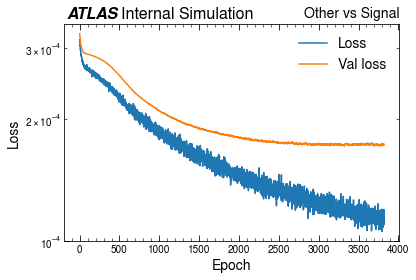

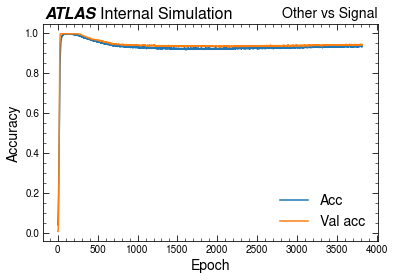

In [138]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.yscale('log')
plt.legend(frameon=False, fontsize=14)

plt.title('Other vs Signal', fontsize=14, loc='right')
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/other_vs_signal_loss.png')
plt.savefig('plots/per_type_test/other_vs_signal_loss.pdf')

plt.show()

plt.plot(history.history['accuracy'], label='Acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend(frameon=False, fontsize=14)

plt.title('Other vs Signal', fontsize=14, loc='right')
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)

atlasify('Internal Simulation', outside=True)

plt.minorticks_on()

plt.savefig('plots/per_type_test/other_vs_signal_acc.png')
plt.savefig('plots/per_type_test/other_vs_signal_acc.pdf')

plt.show()

In [139]:
bg_test['nn_output'] = classifier_other.predict(bg_test[train_feats], batch_size=10000)
sig_test['nn_output'] = classifier_other.predict(sig_test[train_feats], batch_size=10000)

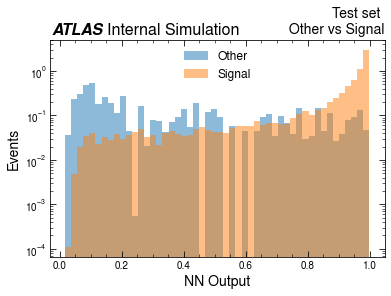

In [140]:
_, b, _ = plt.hist(bg_test.nn_output, alpha=0.5, bins=50, weights=bg_test.wgt, label='Other')
plt.hist(sig_test.nn_output, bins=b, alpha=0.5, weights=sig_test.wgt, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Test set \n Other vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/other_vs_signal_test_output.png')
plt.savefig('plots/per_type_test/other_vs_signal_test_output.pdf')

In [23]:
classifier_other = keras.models.load_model('models/per_type_test/other_vs_signal')

In [24]:
bg_full['other_classifier_out'] = classifier_other.predict(bg_full[train_feats], batch_size=10000)
sig['other_classifier_out'] = classifier_other.predict(sig[train_feats], batch_size=10000)

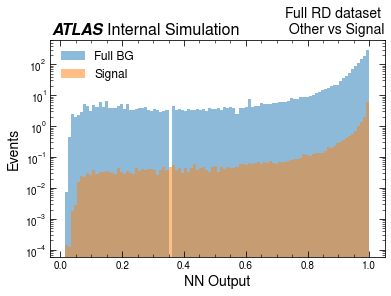

In [25]:
_, b, _ = plt.hist(bg_full.other_classifier_out, bins=100, weights=bg_full.wgt, alpha=0.5, label='Full BG')
plt.hist(sig.other_classifier_out, bins=b, weights=sig.wgt, alpha=0.5, label='Signal')
plt.yscale('log')

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Events', fontsize=14)
plt.title('Full RD dataset \n Other vs Signal', fontsize=14, loc='right')
plt.legend(fontsize=12)

atlasify('Internal Simulation', outside=True)
plt.minorticks_on()

plt.savefig('plots/per_type_test/other_vs_signal_full_output.png')
plt.savefig('plots/per_type_test/other_vs_signal_full_output.pdf')

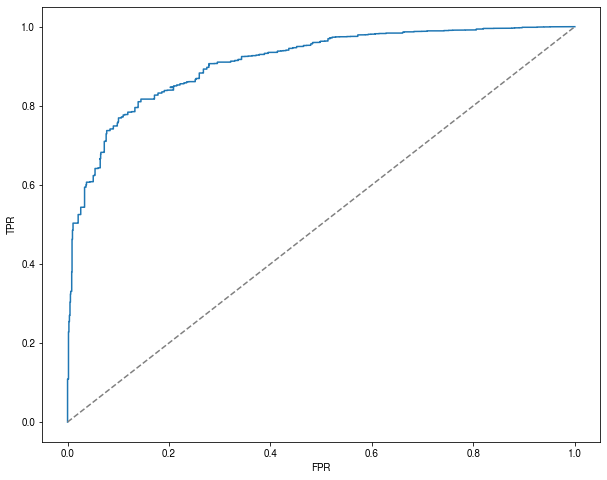

In [143]:
plt.figure(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_test, classifier_other.predict(x_test[train_feats], batch_size=10000), 
                        sample_weight=w_test)
#     auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

# Putting it all together

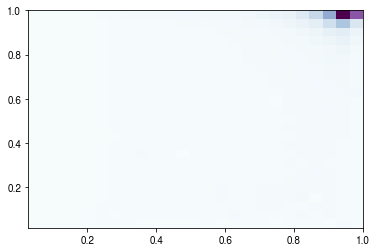

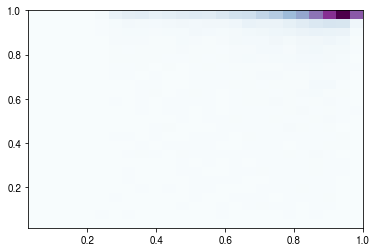

In [26]:
feat1 = 'ttZ_classifier_out'
feat2 = 'other_classifier_out'

_, bx, by, _ = plt.hist2d(bg_full[feat1], bg_full[feat2], bins=25, weights=bg_full.wgt, cmap=plt.cm.BuPu)

plt.show()

plt.hist2d(sig[feat1], sig[feat2], bins=(bx, by), weights=sig.wgt, cmap=plt.cm.BuPu)

plt.show()

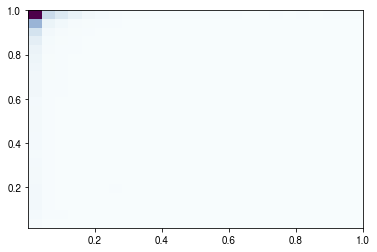

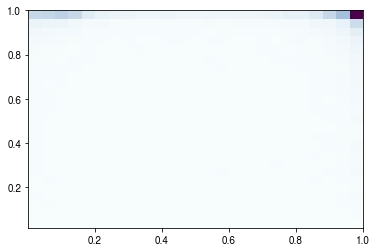

In [27]:
feat1 = 'ZZ_classifier_out'
feat2 = 'other_classifier_out'

_, bx, by, _ = plt.hist2d(bg_full[feat1], bg_full[feat2], bins=25, weights=bg_full.wgt, cmap=plt.cm.BuPu)

plt.show()

plt.hist2d(sig[feat1], sig[feat2], bins=(bx, by), weights=sig.wgt, cmap=plt.cm.BuPu)

plt.show()

In [28]:
combined_train_feats = ['Zjets_classifier_out', 'WZ_classifier_out', 'ZZ_classifier_out', 
                        'ttZ_classifier_out', 'other_classifier_out'] + train_feats

# Split train and test data
sig_train, sig_test = train_test_split(sig[combined_train_feats + ['wgt']], train_size=0.5)
bg_train, bg_test = train_test_split(bg_full[combined_train_feats + ['wgt']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

n_sig_copies = 16
# n_sig_copies = 1

x_train_sig = pd.concat([sig_train[combined_train_feats]] * n_sig_copies)
x_train_bg = bg_train[combined_train_feats]

x_train = pd.concat([x_train_sig, x_train_bg])
y_train = np.concatenate([np.ones(len(sig_train))] * n_sig_copies + [np.zeros(len(bg_train))])
# w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
#                                     (n_sig + n_bg) / n_bg * bg_train['wgt']]))
w_train = pd.Series(np.concatenate([sig_train['wgt']]*n_sig_copies + [bg_train['wgt']]))

n_sig_test = len(sig_train) # should be weighted?
n_bg_test = len(bg_train)

x_test = pd.concat([sig_test[combined_train_feats], bg_test[combined_train_feats]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])
w_test = pd.Series(np.concatenate([sig_test['wgt'], bg_test['wgt']]))

In [ ]:
# Fit ML classifier
EPOCHS = 10000
batch_size = 512
num_nodes = 64
dropout = 0.1

# x_test_results = x_test.copy()

# Generate and fit model
classifier_combined = Sequential()
classifier_combined.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
classifier_combined.add(Dropout(dropout))
classifier_combined.add(Dense(num_nodes, activation='relu'))
classifier_combined.add(Dropout(dropout))
classifier_combined.add(Dense(num_nodes, activation='relu'))
classifier_combined.add(Dropout(dropout))
classifier_combined.add(Dense(1, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=1e-5)
classifier_combined.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, restore_best_weights=True)

history = classifier_combined.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                  validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                  verbose=1, callbacks=[callback], shuffle=True)

Epoch 1/10000
2108/2108 [==============================] - 10s 5ms/step - loss: 5.4893e-04 - accuracy: 0.4817 - val_loss: 3.1015e-04 - val_accuracy: 0.9426
Epoch 2/10000
2108/2108 [==============================] - 9s 4ms/step - loss: 3.5215e-04 - accuracy: 0.5063 - val_loss: 2.0735e-04 - val_accuracy: 0.9426
Epoch 3/10000
2108/2108 [==============================] - 10s 5ms/step - loss: 2.8944e-04 - accuracy: 0.5290 - val_loss: 1.7715e-04 - val_accuracy: 0.9395
Epoch 4/10000
2108/2108 [==============================] - 10s 5ms/step - loss: 2.4698e-04 - accuracy: 0.6078 - val_loss: 1.6191e-04 - val_accuracy: 0.9379
Epoch 5/10000
2108/2108 [==============================] - 10s 5ms/step - loss: 2.3245e-04 - accuracy: 0.6370 - val_loss: 1.5797e-04 - val_accuracy: 0.9366
Epoch 6/10000
2108/2108 [==============================] - 10s 5ms/step - loss: 2.2503e-04 - accuracy: 0.6510 - val_loss: 1.5626e-04 - val_accuracy: 0.9356
Epoch 7/10000
2108/2108 [==============================] - 10s 5m

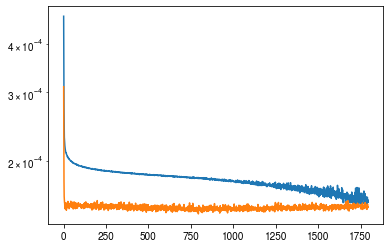

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

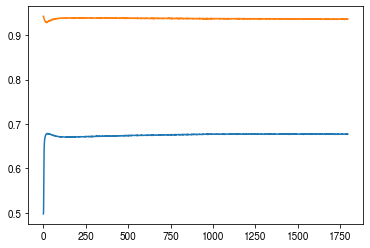

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [32]:
sig_test['classifier_output'] = classifier_combined.predict(sig_test[combined_train_feats], batch_size=10000)
bg_test['classifier_output'] = classifier_combined.predict(bg_test[combined_train_feats], batch_size=10000)

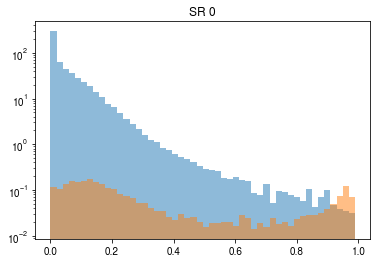

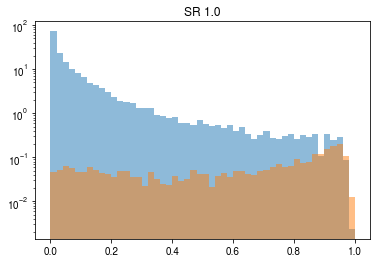

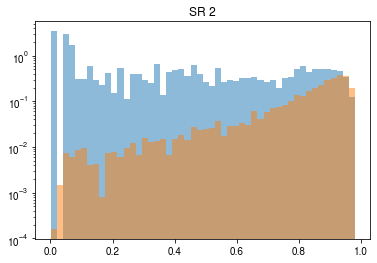

In [33]:
for sr in [0, 0.5, 1]:
    _, b, _ = plt.hist(bg_test[bg_test.SR == sr].classifier_output, bins=50, alpha=0.5, 
                       weights=bg_test[bg_test.SR == sr].wgt)
    plt.hist(sig_test[sig_test.SR == sr].classifier_output, bins=b, alpha=0.5, 
             weights=sig_test[sig_test.SR == sr].wgt)

    plt.title('SR ' + str(2*sr))
    plt.yscale('log')

    plt.show()

In [38]:
nn_cut = 0.85

n_sig = sum(sig_test[sig_test.classifier_output > nn_cut].wgt)
n_bg = sum(bg_test[bg_test.classifier_output > nn_cut].wgt)

print('N sig:', n_sig)
print('N bg:', n_bg)
print('S / sqrt(B)', n_sig / np.sqrt(n_bg))

N sig: 3.308751400906378
N bg: 4.711528594735402
S / sqrt(B) 1.524344831506069


In [51]:
def region_sig(s, b):
    if s == 0:
        return 0
    return np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))

sigs = [0, 0, 0]
nn_cuts = [0.9, 0.7, 0.75]

for i, sr_num in enumerate([0, 0.5, 1]):
    print('------ SR %i ------'%int(2*sr_num))
    
    nn_cut = nn_cuts[i]
    
    sig_passed_cut = sig_test[sig_test.classifier_output > nn_cut]
    bg_passed_cut = bg_test[bg_test.classifier_output > nn_cut]
    
    sig_passed_cut_sr = sig_passed_cut[sig_passed_cut.SR == sr_num]
    bg_passed_cut_sr = bg_passed_cut[bg_passed_cut.SR == sr_num]

    n_sig_passed_cut = sum(sig_passed_cut_sr.wgt)
    n_bg_passed_cut = sum(bg_passed_cut_sr.wgt)

    print('Signal passing cut:', n_sig_passed_cut, 
          '; Corresponds to %.2f'%(100 * n_sig_passed_cut / sum(sig_test.wgt)) + '%')
    print('Background passing cut:', n_bg_passed_cut, 
          '; Corresponds to %.2f'%(100 * n_bg_passed_cut / sum(bg_test.wgt)) + '%')
    print('')
    print('Initial sig = %.2f'%(region_sig(sum(sig_test.wgt), sum(bg_test.wgt))))
    
    new_sig = region_sig(n_sig_passed_cut, n_bg_passed_cut)
    print('After cut sig = %.2f'%(new_sig))
    print('')

    sigs[i] = new_sig
    
print('------ Total ------')
print('Sig = %.2f'%np.sqrt(sum(np.square(sigs))))

------ SR 0 ------
Signal passing cut: 0.33383093777060446 ; Corresponds to 3.64%
Background passing cut: 0.1955992957350245 ; Corresponds to 0.03%

Initial sig = 0.33
After cut sig = 0.62

------ SR 1 ------
Signal passing cut: 1.4541210402949873 ; Corresponds to 15.87%
Background passing cut: 3.8522105415394425 ; Corresponds to 0.50%

Initial sig = 0.33
After cut sig = 0.70

------ SR 2 ------
Signal passing cut: 2.591408718704834 ; Corresponds to 28.27%
Background passing cut: 5.041435069342655 ; Corresponds to 0.65%

Initial sig = 0.33
After cut sig = 1.07

------ Total ------
Sig = 1.42
